In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.act0  = nn.SiLU()
        self.quan0 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.act1  = nn.SiLU()
        self.quan1 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.act2  = nn.SiLU()
        self.quan2 = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.quan0(self.act0(self.bn0(self.fc0(out)))))
        out = self.drop1(self.quan1(self.act1(self.bn1(self.fc1(out)))))
        out = self.drop2(self.quan2(self.act2(self.bn2(self.fc2(out)))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2801, Acc: 0.9159 | Val Loss: 0.1612, Acc: 0.9527


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1342, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1166, Acc: 0.9646 | Val Loss: 0.1301, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9706 | Val Loss: 0.1096, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9754 | Val Loss: 0.1238, Acc: 0.9662


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9794 | Val Loss: 0.1212, Acc: 0.9673


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9824 | Val Loss: 0.1146, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.1276, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.1117, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.1074, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.1224, Acc: 0.9724


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1331, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9898 | Val Loss: 0.1261, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.1359, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9923 | Val Loss: 0.1342, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.1278, Acc: 0.9730


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9929 | Val Loss: 0.1336, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1301, Acc: 0.9729


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1301, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1443, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9934 | Val Loss: 0.1178, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1282, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1463, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.1697, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9941 | Val Loss: 0.1366, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1386, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.1669, Acc: 0.9712


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1399, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9949 | Val Loss: 0.1450, Acc: 0.9737


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1358, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9960 | Val Loss: 0.1629, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1508, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1447, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1704, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9954 | Val Loss: 0.1455, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1665, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1709, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.1552, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1668, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9958 | Val Loss: 0.1701, Acc: 0.9731


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9962 | Val Loss: 0.1602, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1707, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.1777, Acc: 0.9741


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1555, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9968 | Val Loss: 0.1735, Acc: 0.9761


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.1524, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.1766, Acc: 0.9749


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9973 | Val Loss: 0.2067, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9963 | Val Loss: 0.1621, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1677, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9969 | Val Loss: 0.1752, Acc: 0.9756


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9966 | Val Loss: 0.1902, Acc: 0.9745


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1816, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9967 | Val Loss: 0.1907, Acc: 0.9749


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9968 | Val Loss: 0.1942, Acc: 0.9752


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.1800, Acc: 0.9749


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.2055, Acc: 0.9748


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.2225, Acc: 0.9743


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9964 | Val Loss: 0.1798, Acc: 0.9754


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1887, Acc: 0.9747


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1853, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.1927, Acc: 0.9753


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1869, Acc: 0.9773


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9978 | Val Loss: 0.1960, Acc: 0.9766


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.2154, Acc: 0.9738


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9974 | Val Loss: 0.1903, Acc: 0.9766


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.1917, Acc: 0.9778


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.2042, Acc: 0.9739


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9970 | Val Loss: 0.1877, Acc: 0.9767


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.2151, Acc: 0.9762


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.2207, Acc: 0.9742


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9976 | Val Loss: 0.2166, Acc: 0.9771


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9980 | Val Loss: 0.2141, Acc: 0.9763


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.2377, Acc: 0.9751


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.2166, Acc: 0.9762


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9974 | Val Loss: 0.2323, Acc: 0.9752


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9978 | Val Loss: 0.2107, Acc: 0.9778


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9980 | Val Loss: 0.2134, Acc: 0.9772


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.2174, Acc: 0.9747


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9981 | Val Loss: 0.2236, Acc: 0.9757


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.2377, Acc: 0.9742


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9975 | Val Loss: 0.2323, Acc: 0.9750


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9978 | Val Loss: 0.2323, Acc: 0.9771


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9979 | Val Loss: 0.2559, Acc: 0.9744


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9980 | Val Loss: 0.2096, Acc: 0.9768


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9981 | Val Loss: 0.2383, Acc: 0.9762


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.2440, Acc: 0.9739


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9979 | Val Loss: 0.2497, Acc: 0.9765


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9979 | Val Loss: 0.2338, Acc: 0.9760


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9984 | Val Loss: 0.2227, Acc: 0.9769


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.2272, Acc: 0.9773


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.2339, Acc: 0.9756


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.2449, Acc: 0.9749


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9978 | Val Loss: 0.2460, Acc: 0.9760


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.2347, Acc: 0.9772


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9986 | Val Loss: 0.2238, Acc: 0.9773


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9983 | Val Loss: 0.2415, Acc: 0.9759


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.2215, Acc: 0.9786


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.2146, Acc: 0.9770


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.2283, Acc: 0.9768


Final Test Loss: 0.2045 Accuracy: 0.9788


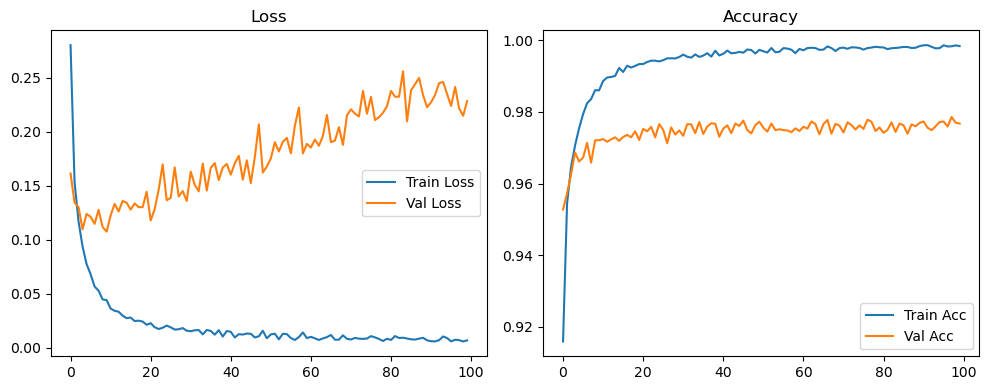

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3291, Acc: 0.9022 | Val Loss: 0.1684, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1972, Acc: 0.9423 | Val Loss: 0.1407, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1652, Acc: 0.9517 | Val Loss: 0.1250, Acc: 0.9623


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9563 | Val Loss: 0.1233, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9622 | Val Loss: 0.1131, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9671 | Val Loss: 0.1116, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9702 | Val Loss: 0.1029, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9733 | Val Loss: 0.1196, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0846, Acc: 0.9739 | Val Loss: 0.1353, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9754 | Val Loss: 0.1078, Acc: 0.9734


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9768 | Val Loss: 0.1167, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9778 | Val Loss: 0.1253, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9780 | Val Loss: 0.1167, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9799 | Val Loss: 0.1255, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1319, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9825 | Val Loss: 0.1137, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9839 | Val Loss: 0.1093, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9835 | Val Loss: 0.1072, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9846 | Val Loss: 0.1319, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9839 | Val Loss: 0.1298, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9846 | Val Loss: 0.1280, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9856 | Val Loss: 0.1440, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9855 | Val Loss: 0.1382, Acc: 0.9730


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9855 | Val Loss: 0.1342, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9876 | Val Loss: 0.1363, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9875 | Val Loss: 0.1489, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9867 | Val Loss: 0.1357, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9866 | Val Loss: 0.1460, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9888 | Val Loss: 0.1587, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9879 | Val Loss: 0.1527, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9880 | Val Loss: 0.1435, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9884 | Val Loss: 0.1406, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9891 | Val Loss: 0.1421, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9872 | Val Loss: 0.1386, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9901 | Val Loss: 0.1543, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9889 | Val Loss: 0.1599, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9886 | Val Loss: 0.1557, Acc: 0.9743


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9898 | Val Loss: 0.1732, Acc: 0.9734


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9909 | Val Loss: 0.1702, Acc: 0.9740


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9895 | Val Loss: 0.1470, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9903 | Val Loss: 0.1618, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9914 | Val Loss: 0.1640, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9900 | Val Loss: 0.1618, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9900 | Val Loss: 0.1622, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9902 | Val Loss: 0.1413, Acc: 0.9773


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9913 | Val Loss: 0.1668, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9915 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9902 | Val Loss: 0.1819, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9910 | Val Loss: 0.1703, Acc: 0.9758


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9916 | Val Loss: 0.1920, Acc: 0.9762


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9922 | Val Loss: 0.1888, Acc: 0.9767


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9918 | Val Loss: 0.1703, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9916 | Val Loss: 0.1696, Acc: 0.9782


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9914 | Val Loss: 0.1804, Acc: 0.9752


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9912 | Val Loss: 0.1609, Acc: 0.9782


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9926 | Val Loss: 0.2070, Acc: 0.9774


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9926 | Val Loss: 0.1904, Acc: 0.9764


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9918 | Val Loss: 0.1775, Acc: 0.9769


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9922 | Val Loss: 0.1676, Acc: 0.9768


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9928 | Val Loss: 0.1983, Acc: 0.9746


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9911 | Val Loss: 0.1630, Acc: 0.9771


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9920 | Val Loss: 0.1844, Acc: 0.9766


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9929 | Val Loss: 0.1634, Acc: 0.9785


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9921 | Val Loss: 0.1970, Acc: 0.9768


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9927 | Val Loss: 0.1816, Acc: 0.9785


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9924 | Val Loss: 0.1870, Acc: 0.9776


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9930 | Val Loss: 0.1868, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9926 | Val Loss: 0.1720, Acc: 0.9778


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9929 | Val Loss: 0.2051, Acc: 0.9757


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9930 | Val Loss: 0.2100, Acc: 0.9765


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9929 | Val Loss: 0.1960, Acc: 0.9777


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9930 | Val Loss: 0.1755, Acc: 0.9773


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9930 | Val Loss: 0.2069, Acc: 0.9753


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9934 | Val Loss: 0.2106, Acc: 0.9782


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9929 | Val Loss: 0.1905, Acc: 0.9769


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9929 | Val Loss: 0.1799, Acc: 0.9778


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9934 | Val Loss: 0.2113, Acc: 0.9776


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9931 | Val Loss: 0.2117, Acc: 0.9772


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9935 | Val Loss: 0.1795, Acc: 0.9793


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9939 | Val Loss: 0.1907, Acc: 0.9772


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9933 | Val Loss: 0.2086, Acc: 0.9769


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9937 | Val Loss: 0.2065, Acc: 0.9774


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9937 | Val Loss: 0.2213, Acc: 0.9764


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9929 | Val Loss: 0.1884, Acc: 0.9757


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9935 | Val Loss: 0.2044, Acc: 0.9765


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9936 | Val Loss: 0.2032, Acc: 0.9768


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9938 | Val Loss: 0.2072, Acc: 0.9782


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9943 | Val Loss: 0.2284, Acc: 0.9754


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9938 | Val Loss: 0.2160, Acc: 0.9782


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9943 | Val Loss: 0.2063, Acc: 0.9783


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9940 | Val Loss: 0.2070, Acc: 0.9773


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9936 | Val Loss: 0.1738, Acc: 0.9783


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9935 | Val Loss: 0.1971, Acc: 0.9783


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9947 | Val Loss: 0.2108, Acc: 0.9784


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9942 | Val Loss: 0.2015, Acc: 0.9772


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9936 | Val Loss: 0.2515, Acc: 0.9752


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9938 | Val Loss: 0.2345, Acc: 0.9763


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9936 | Val Loss: 0.2316, Acc: 0.9778


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9939 | Val Loss: 0.2243, Acc: 0.9775


Final Test Loss: 0.2176 Accuracy: 0.9771


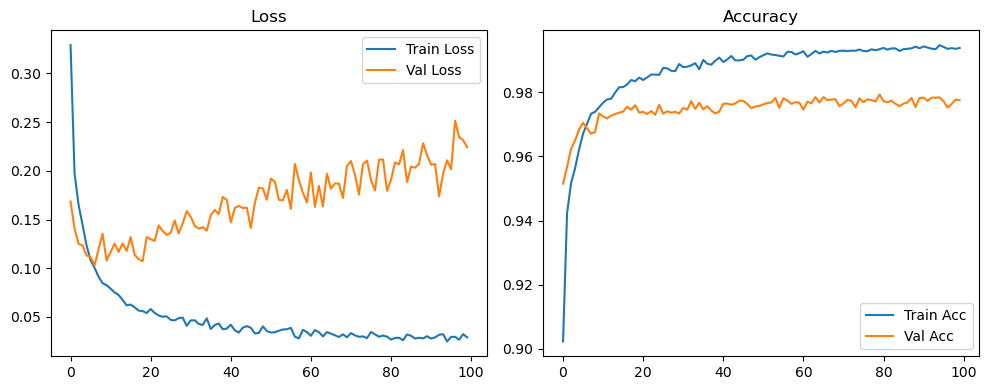

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4978, Acc: 0.8554 | Val Loss: 0.2039, Acc: 0.9391


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3463, Acc: 0.8988 | Val Loss: 0.1692, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9127 | Val Loss: 0.1499, Acc: 0.9545


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2728, Acc: 0.9221 | Val Loss: 0.1343, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2545, Acc: 0.9286 | Val Loss: 0.1280, Acc: 0.9628


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2353, Acc: 0.9319 | Val Loss: 0.1324, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2241, Acc: 0.9356 | Val Loss: 0.1176, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1219, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2053, Acc: 0.9419 | Val Loss: 0.1247, Acc: 0.9655


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2017, Acc: 0.9425 | Val Loss: 0.1139, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1929, Acc: 0.9451 | Val Loss: 0.1210, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1939, Acc: 0.9451 | Val Loss: 0.1097, Acc: 0.9702


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9461 | Val Loss: 0.1076, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1795, Acc: 0.9489 | Val Loss: 0.1204, Acc: 0.9705


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9497 | Val Loss: 0.1142, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9524 | Val Loss: 0.1146, Acc: 0.9705


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9543 | Val Loss: 0.1108, Acc: 0.9723


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9536 | Val Loss: 0.1157, Acc: 0.9698


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1632, Acc: 0.9536 | Val Loss: 0.1033, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9573 | Val Loss: 0.1141, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9568 | Val Loss: 0.1127, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9570 | Val Loss: 0.1074, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1512, Acc: 0.9576 | Val Loss: 0.1080, Acc: 0.9735


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9598 | Val Loss: 0.1211, Acc: 0.9706


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9583 | Val Loss: 0.1095, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9603 | Val Loss: 0.1071, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1406, Acc: 0.9612 | Val Loss: 0.1134, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9606 | Val Loss: 0.1088, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9618 | Val Loss: 0.1075, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9640 | Val Loss: 0.1120, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9618 | Val Loss: 0.1119, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1277, Acc: 0.9642 | Val Loss: 0.1073, Acc: 0.9738


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9637 | Val Loss: 0.1071, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9626 | Val Loss: 0.1114, Acc: 0.9730


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9630 | Val Loss: 0.1046, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9633 | Val Loss: 0.1061, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9645 | Val Loss: 0.1233, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1260, Acc: 0.9658 | Val Loss: 0.1107, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9682 | Val Loss: 0.1167, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1225, Acc: 0.9667 | Val Loss: 0.1147, Acc: 0.9737


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9646 | Val Loss: 0.1076, Acc: 0.9744


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9685 | Val Loss: 0.1229, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9666 | Val Loss: 0.1212, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9669 | Val Loss: 0.1216, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1145, Acc: 0.9674 | Val Loss: 0.1150, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9675 | Val Loss: 0.1311, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9672 | Val Loss: 0.1209, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9692 | Val Loss: 0.1263, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9690 | Val Loss: 0.1225, Acc: 0.9739


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1111, Acc: 0.9698 | Val Loss: 0.1114, Acc: 0.9748


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.1168, Acc: 0.9692 | Val Loss: 0.1165, Acc: 0.9748


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.1118, Acc: 0.9693 | Val Loss: 0.1181, Acc: 0.9747


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.1123, Acc: 0.9685 | Val Loss: 0.1180, Acc: 0.9754


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.1129, Acc: 0.9686 | Val Loss: 0.1218, Acc: 0.9740


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9679 | Val Loss: 0.1137, Acc: 0.9759


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.1120, Acc: 0.9703 | Val Loss: 0.1115, Acc: 0.9760


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.1112, Acc: 0.9689 | Val Loss: 0.1331, Acc: 0.9731


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9717 | Val Loss: 0.1154, Acc: 0.9750


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.1117, Acc: 0.9695 | Val Loss: 0.1210, Acc: 0.9760


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9699 | Val Loss: 0.1229, Acc: 0.9758


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.1056, Acc: 0.9717 | Val Loss: 0.1328, Acc: 0.9741


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9712 | Val Loss: 0.1320, Acc: 0.9737


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.1060, Acc: 0.9719 | Val Loss: 0.1371, Acc: 0.9752


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.1024, Acc: 0.9729 | Val Loss: 0.1292, Acc: 0.9750


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0990, Acc: 0.9729 | Val Loss: 0.1327, Acc: 0.9752


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.1121, Acc: 0.9704 | Val Loss: 0.1312, Acc: 0.9746


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.1025, Acc: 0.9723 | Val Loss: 0.1463, Acc: 0.9748


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.1072, Acc: 0.9729 | Val Loss: 0.1251, Acc: 0.9725


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.1088, Acc: 0.9715 | Val Loss: 0.1227, Acc: 0.9750


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9736 | Val Loss: 0.1293, Acc: 0.9747


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9722 | Val Loss: 0.1279, Acc: 0.9758


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.1026, Acc: 0.9720 | Val Loss: 0.1316, Acc: 0.9752


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0983, Acc: 0.9733 | Val Loss: 0.1356, Acc: 0.9766


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0977, Acc: 0.9741 | Val Loss: 0.1300, Acc: 0.9762


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0997, Acc: 0.9740 | Val Loss: 0.1388, Acc: 0.9760


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9741 | Val Loss: 0.1198, Acc: 0.9758


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9749 | Val Loss: 0.1235, Acc: 0.9753


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9728 | Val Loss: 0.1279, Acc: 0.9752


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9751 | Val Loss: 0.1302, Acc: 0.9762


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.1026, Acc: 0.9732 | Val Loss: 0.1192, Acc: 0.9757


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9741 | Val Loss: 0.1359, Acc: 0.9752


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.1031, Acc: 0.9730 | Val Loss: 0.1335, Acc: 0.9747


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9747 | Val Loss: 0.1526, Acc: 0.9747


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9754 | Val Loss: 0.1274, Acc: 0.9743


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.1009, Acc: 0.9738 | Val Loss: 0.1376, Acc: 0.9745


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9761 | Val Loss: 0.1276, Acc: 0.9772


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9740 | Val Loss: 0.1369, Acc: 0.9764


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9756 | Val Loss: 0.1412, Acc: 0.9748


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0974, Acc: 0.9749 | Val Loss: 0.1397, Acc: 0.9749


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9756 | Val Loss: 0.1366, Acc: 0.9738


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9743 | Val Loss: 0.1330, Acc: 0.9725


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9747 | Val Loss: 0.1588, Acc: 0.9712


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9751 | Val Loss: 0.1353, Acc: 0.9766


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9733 | Val Loss: 0.1359, Acc: 0.9758


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9751 | Val Loss: 0.1352, Acc: 0.9761


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.1017, Acc: 0.9742 | Val Loss: 0.1444, Acc: 0.9730


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9765 | Val Loss: 0.1449, Acc: 0.9737


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9760 | Val Loss: 0.1366, Acc: 0.9750


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9754 | Val Loss: 0.1305, Acc: 0.9751


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9753 | Val Loss: 0.1439, Acc: 0.9757


Final Test Loss: 0.1227 Accuracy: 0.9776


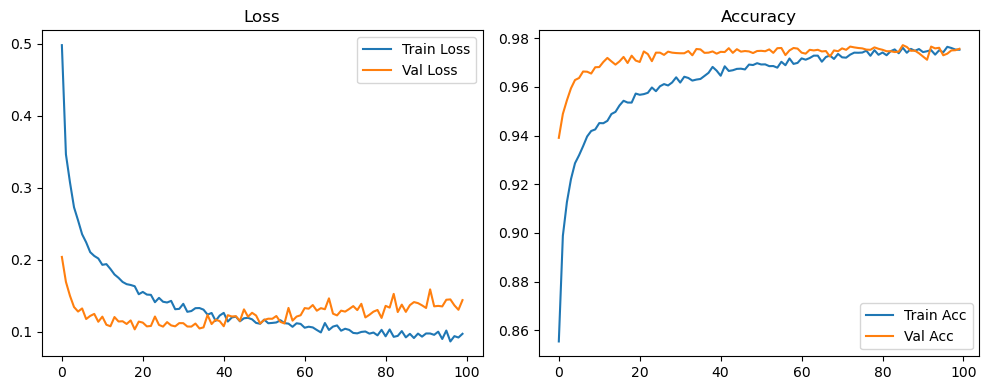

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2801, Acc: 0.9159 | Val Loss: 0.1612, Acc: 0.9527


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1342, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1166, Acc: 0.9646 | Val Loss: 0.1301, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9706 | Val Loss: 0.1096, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9754 | Val Loss: 0.1238, Acc: 0.9662


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9794 | Val Loss: 0.1212, Acc: 0.9673


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9824 | Val Loss: 0.1146, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.1276, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.1117, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.1074, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.1224, Acc: 0.9724


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1331, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9898 | Val Loss: 0.1261, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.1359, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9923 | Val Loss: 0.1342, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.1278, Acc: 0.9730


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9929 | Val Loss: 0.1336, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1301, Acc: 0.9729


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1301, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1443, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9934 | Val Loss: 0.1178, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1282, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1463, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.1697, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9941 | Val Loss: 0.1366, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1386, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.1669, Acc: 0.9712


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1399, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9949 | Val Loss: 0.1450, Acc: 0.9737


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1358, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9960 | Val Loss: 0.1629, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1508, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1447, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1704, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9954 | Val Loss: 0.1455, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1665, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1709, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.1552, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1668, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9958 | Val Loss: 0.1701, Acc: 0.9731


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9962 | Val Loss: 0.1602, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1707, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.1777, Acc: 0.9741


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1555, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9968 | Val Loss: 0.1735, Acc: 0.9761


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.1524, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.1766, Acc: 0.9749


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9973 | Val Loss: 0.2067, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9963 | Val Loss: 0.1621, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1677, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1518, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1658, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1682, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1758, Acc: 0.9778


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1791, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1892, Acc: 0.9763


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.2134, Acc: 0.9777


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1897, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2056, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2268, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.2031, Acc: 0.9777


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1972, Acc: 0.9786


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2240, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.2409, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2126, Acc: 0.9770


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2203, Acc: 0.9773


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.2252, Acc: 0.9766


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.2205, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2189, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1993, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.2233, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.2350, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2409, Acc: 0.9779


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.2222, Acc: 0.9774


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2103, Acc: 0.9754


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2234, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.2250, Acc: 0.9769


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2415, Acc: 0.9774


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.2122, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2268, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.2215, Acc: 0.9785


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2295, Acc: 0.9788


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2259, Acc: 0.9791


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2366, Acc: 0.9775


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.2421, Acc: 0.9776


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2420, Acc: 0.9771


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2347, Acc: 0.9784


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2312, Acc: 0.9786


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2324, Acc: 0.9788


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2371, Acc: 0.9789


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2323, Acc: 0.9792


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2432, Acc: 0.9788


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.2494, Acc: 0.9778


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.2537, Acc: 0.9786


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.2465, Acc: 0.9786


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2402, Acc: 0.9797


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2305, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.2372, Acc: 0.9794


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2340, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2482, Acc: 0.9795


Final Test Loss: 0.2062 Accuracy: 0.9809


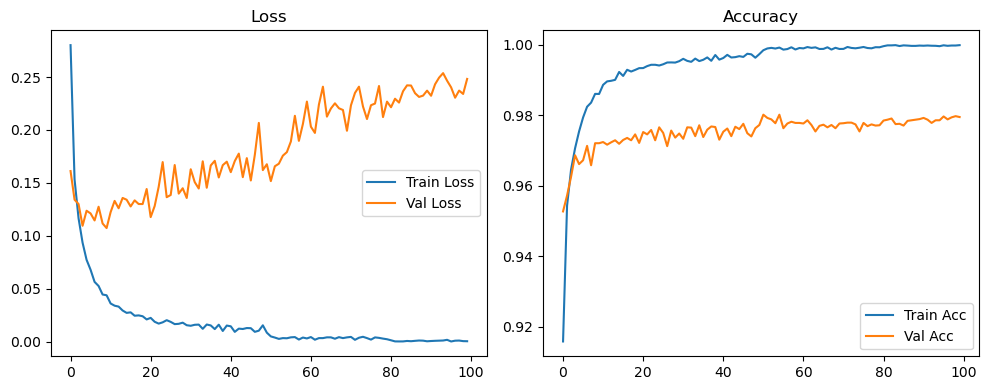

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3291, Acc: 0.9022 | Val Loss: 0.1684, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1972, Acc: 0.9423 | Val Loss: 0.1407, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1652, Acc: 0.9517 | Val Loss: 0.1250, Acc: 0.9623


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9563 | Val Loss: 0.1233, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9622 | Val Loss: 0.1131, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9671 | Val Loss: 0.1116, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9702 | Val Loss: 0.1029, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9733 | Val Loss: 0.1196, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0846, Acc: 0.9739 | Val Loss: 0.1353, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9754 | Val Loss: 0.1078, Acc: 0.9734


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9768 | Val Loss: 0.1167, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9778 | Val Loss: 0.1253, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9780 | Val Loss: 0.1167, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9799 | Val Loss: 0.1255, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1319, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9825 | Val Loss: 0.1137, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9839 | Val Loss: 0.1093, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9835 | Val Loss: 0.1072, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9846 | Val Loss: 0.1319, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9839 | Val Loss: 0.1298, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9846 | Val Loss: 0.1280, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9856 | Val Loss: 0.1440, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9855 | Val Loss: 0.1382, Acc: 0.9730


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9855 | Val Loss: 0.1342, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9876 | Val Loss: 0.1363, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9875 | Val Loss: 0.1489, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9867 | Val Loss: 0.1357, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9866 | Val Loss: 0.1460, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9888 | Val Loss: 0.1587, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9879 | Val Loss: 0.1527, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9880 | Val Loss: 0.1435, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9884 | Val Loss: 0.1406, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9891 | Val Loss: 0.1421, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9872 | Val Loss: 0.1386, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9901 | Val Loss: 0.1543, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9889 | Val Loss: 0.1599, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9886 | Val Loss: 0.1557, Acc: 0.9743


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9898 | Val Loss: 0.1732, Acc: 0.9734


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9909 | Val Loss: 0.1702, Acc: 0.9740


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9895 | Val Loss: 0.1470, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9903 | Val Loss: 0.1618, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9914 | Val Loss: 0.1640, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9900 | Val Loss: 0.1618, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9900 | Val Loss: 0.1622, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9902 | Val Loss: 0.1413, Acc: 0.9773


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9913 | Val Loss: 0.1668, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9915 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9902 | Val Loss: 0.1819, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9910 | Val Loss: 0.1703, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9943 | Val Loss: 0.1499, Acc: 0.9797


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9949 | Val Loss: 0.1530, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9956 | Val Loss: 0.1531, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9956 | Val Loss: 0.1676, Acc: 0.9789


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9949 | Val Loss: 0.1623, Acc: 0.9791


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9950 | Val Loss: 0.1651, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9959 | Val Loss: 0.1577, Acc: 0.9781


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1724, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9956 | Val Loss: 0.1776, Acc: 0.9790


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9962 | Val Loss: 0.1697, Acc: 0.9797


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9954 | Val Loss: 0.1777, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9966 | Val Loss: 0.1799, Acc: 0.9788


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9954 | Val Loss: 0.1634, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9959 | Val Loss: 0.1652, Acc: 0.9786


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9958 | Val Loss: 0.1773, Acc: 0.9789


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9957 | Val Loss: 0.1729, Acc: 0.9795


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9960 | Val Loss: 0.1777, Acc: 0.9795


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9961 | Val Loss: 0.1790, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9959 | Val Loss: 0.1673, Acc: 0.9805


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.1934, Acc: 0.9780


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9965 | Val Loss: 0.2006, Acc: 0.9786


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9967 | Val Loss: 0.1929, Acc: 0.9784


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9960 | Val Loss: 0.1911, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9965 | Val Loss: 0.1840, Acc: 0.9790


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9966 | Val Loss: 0.2025, Acc: 0.9786


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9963 | Val Loss: 0.1865, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9955 | Val Loss: 0.1817, Acc: 0.9791


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9970 | Val Loss: 0.1949, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9962 | Val Loss: 0.1978, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9963 | Val Loss: 0.1997, Acc: 0.9774


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9967 | Val Loss: 0.1794, Acc: 0.9795


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1752, Acc: 0.9795


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1918, Acc: 0.9800


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1872, Acc: 0.9806


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9974 | Val Loss: 0.1863, Acc: 0.9805


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9981 | Val Loss: 0.1868, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9979 | Val Loss: 0.1814, Acc: 0.9796


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1858, Acc: 0.9801


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1886, Acc: 0.9808


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.1735, Acc: 0.9816


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1771, Acc: 0.9820


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1813, Acc: 0.9812


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.1799, Acc: 0.9814


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1895, Acc: 0.9812


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9984 | Val Loss: 0.1889, Acc: 0.9813


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.1836, Acc: 0.9812


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1947, Acc: 0.9805


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9982 | Val Loss: 0.1871, Acc: 0.9798


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1973, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1918, Acc: 0.9798


Final Test Loss: 0.1754 Accuracy: 0.9819


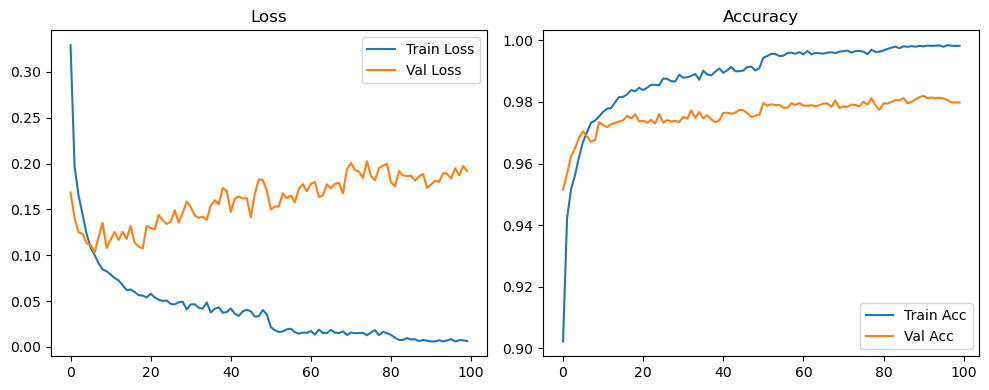

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4978, Acc: 0.8554 | Val Loss: 0.2039, Acc: 0.9391


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3463, Acc: 0.8988 | Val Loss: 0.1692, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9127 | Val Loss: 0.1499, Acc: 0.9545


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2728, Acc: 0.9221 | Val Loss: 0.1343, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2545, Acc: 0.9286 | Val Loss: 0.1280, Acc: 0.9628


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2353, Acc: 0.9319 | Val Loss: 0.1324, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2241, Acc: 0.9356 | Val Loss: 0.1176, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1219, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2053, Acc: 0.9419 | Val Loss: 0.1247, Acc: 0.9655


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2017, Acc: 0.9425 | Val Loss: 0.1139, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1929, Acc: 0.9451 | Val Loss: 0.1210, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1939, Acc: 0.9451 | Val Loss: 0.1097, Acc: 0.9702


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9461 | Val Loss: 0.1076, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1795, Acc: 0.9489 | Val Loss: 0.1204, Acc: 0.9705


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9497 | Val Loss: 0.1142, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9524 | Val Loss: 0.1146, Acc: 0.9705


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9543 | Val Loss: 0.1108, Acc: 0.9723


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9536 | Val Loss: 0.1157, Acc: 0.9698


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1632, Acc: 0.9536 | Val Loss: 0.1033, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9573 | Val Loss: 0.1141, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9568 | Val Loss: 0.1127, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9570 | Val Loss: 0.1074, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1512, Acc: 0.9576 | Val Loss: 0.1080, Acc: 0.9735


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9598 | Val Loss: 0.1211, Acc: 0.9706


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9583 | Val Loss: 0.1095, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9603 | Val Loss: 0.1071, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1406, Acc: 0.9612 | Val Loss: 0.1134, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9606 | Val Loss: 0.1088, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9618 | Val Loss: 0.1075, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9640 | Val Loss: 0.1120, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9618 | Val Loss: 0.1119, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1277, Acc: 0.9642 | Val Loss: 0.1073, Acc: 0.9738


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9637 | Val Loss: 0.1071, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9626 | Val Loss: 0.1114, Acc: 0.9730


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9630 | Val Loss: 0.1046, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9633 | Val Loss: 0.1061, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9645 | Val Loss: 0.1233, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1260, Acc: 0.9658 | Val Loss: 0.1107, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9682 | Val Loss: 0.1167, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1225, Acc: 0.9667 | Val Loss: 0.1147, Acc: 0.9737


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9646 | Val Loss: 0.1076, Acc: 0.9744


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9685 | Val Loss: 0.1229, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9666 | Val Loss: 0.1212, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9669 | Val Loss: 0.1216, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1145, Acc: 0.9674 | Val Loss: 0.1150, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9675 | Val Loss: 0.1311, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9672 | Val Loss: 0.1209, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9692 | Val Loss: 0.1263, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9690 | Val Loss: 0.1225, Acc: 0.9739


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1111, Acc: 0.9698 | Val Loss: 0.1114, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9731 | Val Loss: 0.1074, Acc: 0.9760


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0795, Acc: 0.9759 | Val Loss: 0.1137, Acc: 0.9761


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9765 | Val Loss: 0.1041, Acc: 0.9761


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9767 | Val Loss: 0.1155, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9756 | Val Loss: 0.1034, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9779 | Val Loss: 0.1084, Acc: 0.9750


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9774 | Val Loss: 0.1102, Acc: 0.9754


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9776 | Val Loss: 0.1111, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9786 | Val Loss: 0.1106, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9796 | Val Loss: 0.1156, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9784 | Val Loss: 0.1195, Acc: 0.9760


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9785 | Val Loss: 0.1174, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9800 | Val Loss: 0.1109, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9804 | Val Loss: 0.1144, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9817 | Val Loss: 0.1146, Acc: 0.9748


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9774 | Val Loss: 0.1090, Acc: 0.9777


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9803 | Val Loss: 0.1172, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9800 | Val Loss: 0.1088, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9793 | Val Loss: 0.1075, Acc: 0.9768


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9806 | Val Loss: 0.1202, Acc: 0.9757


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9808 | Val Loss: 0.1159, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9798 | Val Loss: 0.1162, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9808 | Val Loss: 0.1261, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9810 | Val Loss: 0.1199, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9809 | Val Loss: 0.1194, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0645, Acc: 0.9810 | Val Loss: 0.1118, Acc: 0.9775


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9820 | Val Loss: 0.1232, Acc: 0.9751


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9814 | Val Loss: 0.1205, Acc: 0.9769


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9819 | Val Loss: 0.1139, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9813 | Val Loss: 0.1154, Acc: 0.9756


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9832 | Val Loss: 0.1164, Acc: 0.9775


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9840 | Val Loss: 0.1118, Acc: 0.9762


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9848 | Val Loss: 0.1198, Acc: 0.9764


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9857 | Val Loss: 0.1080, Acc: 0.9772


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9854 | Val Loss: 0.1176, Acc: 0.9763


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9867 | Val Loss: 0.1135, Acc: 0.9767


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9863 | Val Loss: 0.1166, Acc: 0.9764


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9865 | Val Loss: 0.1119, Acc: 0.9772


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9858 | Val Loss: 0.1066, Acc: 0.9772


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9862 | Val Loss: 0.1039, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.1046, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9865 | Val Loss: 0.1075, Acc: 0.9766


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9864 | Val Loss: 0.1111, Acc: 0.9781


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0462, Acc: 0.9860 | Val Loss: 0.1083, Acc: 0.9779


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1085, Acc: 0.9771


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9869 | Val Loss: 0.1121, Acc: 0.9774


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9872 | Val Loss: 0.1112, Acc: 0.9771


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9871 | Val Loss: 0.1090, Acc: 0.9776


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9870 | Val Loss: 0.1078, Acc: 0.9774


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.1094, Acc: 0.9783


Final Test Loss: 0.0989 Accuracy: 0.9811


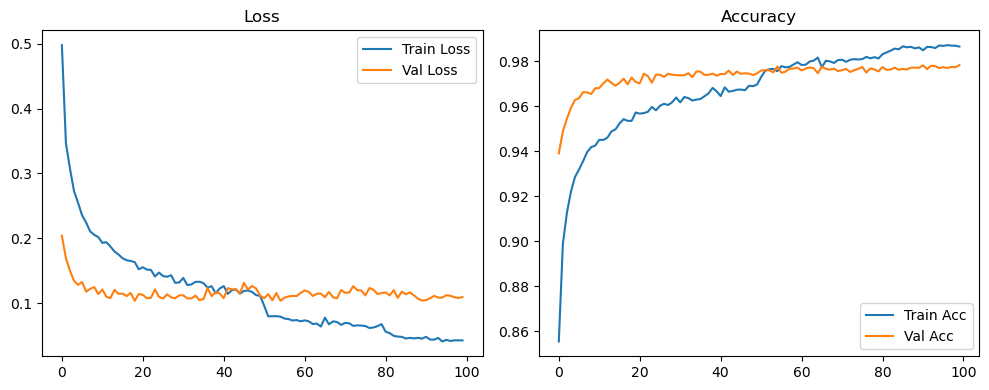

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2801, Acc: 0.9159 | Val Loss: 0.1612, Acc: 0.9527


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1342, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1166, Acc: 0.9646 | Val Loss: 0.1301, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9706 | Val Loss: 0.1096, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9754 | Val Loss: 0.1238, Acc: 0.9662


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9794 | Val Loss: 0.1212, Acc: 0.9673


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9824 | Val Loss: 0.1146, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.1276, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.1117, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.1074, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.1224, Acc: 0.9724


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1331, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9898 | Val Loss: 0.1261, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.1359, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9923 | Val Loss: 0.1342, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.1278, Acc: 0.9730


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9929 | Val Loss: 0.1336, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1301, Acc: 0.9729


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1301, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1443, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9934 | Val Loss: 0.1178, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1282, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1463, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.1697, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9941 | Val Loss: 0.1366, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1386, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.1669, Acc: 0.9712


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1399, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9949 | Val Loss: 0.1450, Acc: 0.9737


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1358, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9960 | Val Loss: 0.1629, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1508, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1447, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1704, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9954 | Val Loss: 0.1455, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1665, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1709, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.1552, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1668, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9958 | Val Loss: 0.1701, Acc: 0.9731


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9962 | Val Loss: 0.1602, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1707, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.1777, Acc: 0.9741


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1555, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9968 | Val Loss: 0.1735, Acc: 0.9761


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.1524, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.1766, Acc: 0.9749


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9973 | Val Loss: 0.2067, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9963 | Val Loss: 0.1621, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1677, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1518, Acc: 0.9802


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1658, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1682, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1758, Acc: 0.9778


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1791, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1892, Acc: 0.9763


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.2134, Acc: 0.9777


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1897, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2056, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.2268, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.2031, Acc: 0.9777


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1972, Acc: 0.9786


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2240, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.2409, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2126, Acc: 0.9770


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2203, Acc: 0.9773


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.2252, Acc: 0.9766


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.2205, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2189, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1993, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.2233, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.2350, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.2409, Acc: 0.9779


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9990 | Val Loss: 0.2222, Acc: 0.9774


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.2103, Acc: 0.9754


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2234, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9991 | Val Loss: 0.2250, Acc: 0.9769


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.2415, Acc: 0.9774


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9993 | Val Loss: 0.2122, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.2268, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2183, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.2195, Acc: 0.9785


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2230, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2216, Acc: 0.9787


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2334, Acc: 0.9786


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2170, Acc: 0.9789


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2158, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2123, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.2148, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2100, Acc: 0.9789


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2210, Acc: 0.9785


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2202, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2261, Acc: 0.9805


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2221, Acc: 0.9793


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2339, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2288, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2228, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2211, Acc: 0.9806


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2221, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2245, Acc: 0.9802


Final Test Loss: 0.1892 Accuracy: 0.9816


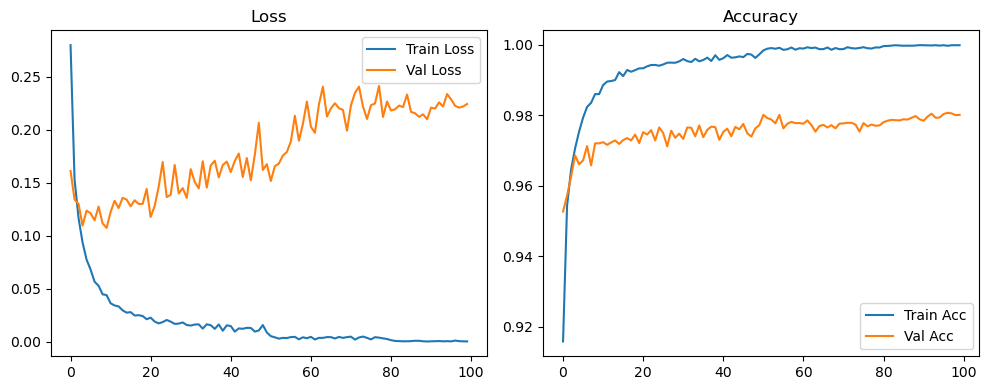

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3291, Acc: 0.9022 | Val Loss: 0.1684, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1972, Acc: 0.9423 | Val Loss: 0.1407, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1652, Acc: 0.9517 | Val Loss: 0.1250, Acc: 0.9623


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9563 | Val Loss: 0.1233, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9622 | Val Loss: 0.1131, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9671 | Val Loss: 0.1116, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9702 | Val Loss: 0.1029, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9733 | Val Loss: 0.1196, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0846, Acc: 0.9739 | Val Loss: 0.1353, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9754 | Val Loss: 0.1078, Acc: 0.9734


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9768 | Val Loss: 0.1167, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9778 | Val Loss: 0.1253, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9780 | Val Loss: 0.1167, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9799 | Val Loss: 0.1255, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1319, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9825 | Val Loss: 0.1137, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9839 | Val Loss: 0.1093, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9835 | Val Loss: 0.1072, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9846 | Val Loss: 0.1319, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9839 | Val Loss: 0.1298, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9846 | Val Loss: 0.1280, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9856 | Val Loss: 0.1440, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9855 | Val Loss: 0.1382, Acc: 0.9730


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9855 | Val Loss: 0.1342, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9876 | Val Loss: 0.1363, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9875 | Val Loss: 0.1489, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9867 | Val Loss: 0.1357, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9866 | Val Loss: 0.1460, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9888 | Val Loss: 0.1587, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9879 | Val Loss: 0.1527, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9880 | Val Loss: 0.1435, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9884 | Val Loss: 0.1406, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9891 | Val Loss: 0.1421, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9872 | Val Loss: 0.1386, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9901 | Val Loss: 0.1543, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9889 | Val Loss: 0.1599, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9886 | Val Loss: 0.1557, Acc: 0.9743


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9898 | Val Loss: 0.1732, Acc: 0.9734


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9909 | Val Loss: 0.1702, Acc: 0.9740


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9895 | Val Loss: 0.1470, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9903 | Val Loss: 0.1618, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9914 | Val Loss: 0.1640, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9900 | Val Loss: 0.1618, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9900 | Val Loss: 0.1622, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9902 | Val Loss: 0.1413, Acc: 0.9773


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9913 | Val Loss: 0.1668, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9915 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9902 | Val Loss: 0.1819, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9910 | Val Loss: 0.1703, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9943 | Val Loss: 0.1499, Acc: 0.9797


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9949 | Val Loss: 0.1530, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9956 | Val Loss: 0.1531, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9956 | Val Loss: 0.1676, Acc: 0.9789


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9949 | Val Loss: 0.1623, Acc: 0.9791


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9950 | Val Loss: 0.1651, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9959 | Val Loss: 0.1577, Acc: 0.9781


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1724, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9956 | Val Loss: 0.1776, Acc: 0.9790


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9962 | Val Loss: 0.1697, Acc: 0.9797


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9954 | Val Loss: 0.1777, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9966 | Val Loss: 0.1799, Acc: 0.9788


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9954 | Val Loss: 0.1634, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9959 | Val Loss: 0.1652, Acc: 0.9786


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9958 | Val Loss: 0.1773, Acc: 0.9789


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9957 | Val Loss: 0.1729, Acc: 0.9795


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9960 | Val Loss: 0.1777, Acc: 0.9795


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9961 | Val Loss: 0.1790, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9959 | Val Loss: 0.1673, Acc: 0.9805


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.1934, Acc: 0.9780


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9965 | Val Loss: 0.2006, Acc: 0.9786


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9967 | Val Loss: 0.1929, Acc: 0.9784


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9960 | Val Loss: 0.1911, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9965 | Val Loss: 0.1840, Acc: 0.9790


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9966 | Val Loss: 0.2025, Acc: 0.9786


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9963 | Val Loss: 0.1865, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9955 | Val Loss: 0.1817, Acc: 0.9791


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9970 | Val Loss: 0.1949, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9962 | Val Loss: 0.1978, Acc: 0.9788


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9963 | Val Loss: 0.1997, Acc: 0.9774


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9972 | Val Loss: 0.1828, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1757, Acc: 0.9805


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1846, Acc: 0.9799


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1859, Acc: 0.9806


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9979 | Val Loss: 0.1775, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9980 | Val Loss: 0.1842, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1737, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1753, Acc: 0.9809


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1823, Acc: 0.9817


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1641, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1738, Acc: 0.9825


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1766, Acc: 0.9813


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1848, Acc: 0.9809


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1793, Acc: 0.9815


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9986 | Val Loss: 0.1788, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1709, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1746, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1774, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.1812, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1756, Acc: 0.9812


Final Test Loss: 0.1650 Accuracy: 0.9807


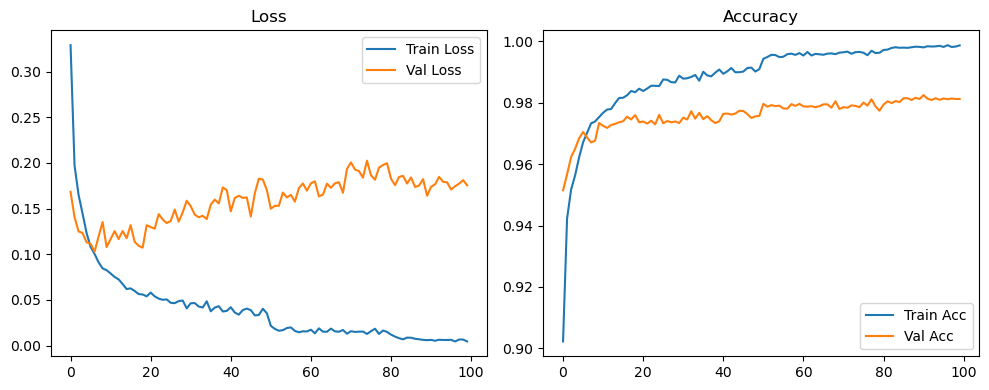

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4978, Acc: 0.8554 | Val Loss: 0.2039, Acc: 0.9391


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3463, Acc: 0.8988 | Val Loss: 0.1692, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9127 | Val Loss: 0.1499, Acc: 0.9545


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2728, Acc: 0.9221 | Val Loss: 0.1343, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2545, Acc: 0.9286 | Val Loss: 0.1280, Acc: 0.9628


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2353, Acc: 0.9319 | Val Loss: 0.1324, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2241, Acc: 0.9356 | Val Loss: 0.1176, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1219, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2053, Acc: 0.9419 | Val Loss: 0.1247, Acc: 0.9655


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2017, Acc: 0.9425 | Val Loss: 0.1139, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1929, Acc: 0.9451 | Val Loss: 0.1210, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1939, Acc: 0.9451 | Val Loss: 0.1097, Acc: 0.9702


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9461 | Val Loss: 0.1076, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1795, Acc: 0.9489 | Val Loss: 0.1204, Acc: 0.9705


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9497 | Val Loss: 0.1142, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9524 | Val Loss: 0.1146, Acc: 0.9705


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9543 | Val Loss: 0.1108, Acc: 0.9723


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9536 | Val Loss: 0.1157, Acc: 0.9698


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1632, Acc: 0.9536 | Val Loss: 0.1033, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9573 | Val Loss: 0.1141, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9568 | Val Loss: 0.1127, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9570 | Val Loss: 0.1074, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1512, Acc: 0.9576 | Val Loss: 0.1080, Acc: 0.9735


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9598 | Val Loss: 0.1211, Acc: 0.9706


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9583 | Val Loss: 0.1095, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9603 | Val Loss: 0.1071, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1406, Acc: 0.9612 | Val Loss: 0.1134, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9606 | Val Loss: 0.1088, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9618 | Val Loss: 0.1075, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9640 | Val Loss: 0.1120, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9618 | Val Loss: 0.1119, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1277, Acc: 0.9642 | Val Loss: 0.1073, Acc: 0.9738


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9637 | Val Loss: 0.1071, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9626 | Val Loss: 0.1114, Acc: 0.9730


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9630 | Val Loss: 0.1046, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9633 | Val Loss: 0.1061, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9645 | Val Loss: 0.1233, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1260, Acc: 0.9658 | Val Loss: 0.1107, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9682 | Val Loss: 0.1167, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1225, Acc: 0.9667 | Val Loss: 0.1147, Acc: 0.9737


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9646 | Val Loss: 0.1076, Acc: 0.9744


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9685 | Val Loss: 0.1229, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9666 | Val Loss: 0.1212, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9669 | Val Loss: 0.1216, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1145, Acc: 0.9674 | Val Loss: 0.1150, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9675 | Val Loss: 0.1311, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9672 | Val Loss: 0.1209, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9692 | Val Loss: 0.1263, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9690 | Val Loss: 0.1225, Acc: 0.9739


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1111, Acc: 0.9698 | Val Loss: 0.1114, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9731 | Val Loss: 0.1074, Acc: 0.9760


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0795, Acc: 0.9759 | Val Loss: 0.1137, Acc: 0.9761


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0797, Acc: 0.9765 | Val Loss: 0.1041, Acc: 0.9761


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9767 | Val Loss: 0.1155, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0791, Acc: 0.9756 | Val Loss: 0.1034, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9779 | Val Loss: 0.1084, Acc: 0.9750


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9774 | Val Loss: 0.1102, Acc: 0.9754


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9776 | Val Loss: 0.1111, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0738, Acc: 0.9786 | Val Loss: 0.1106, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9796 | Val Loss: 0.1156, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0733, Acc: 0.9784 | Val Loss: 0.1195, Acc: 0.9760


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9785 | Val Loss: 0.1174, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9800 | Val Loss: 0.1109, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9804 | Val Loss: 0.1144, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9817 | Val Loss: 0.1146, Acc: 0.9748


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9774 | Val Loss: 0.1090, Acc: 0.9777


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9803 | Val Loss: 0.1172, Acc: 0.9768


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0718, Acc: 0.9800 | Val Loss: 0.1088, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9793 | Val Loss: 0.1075, Acc: 0.9768


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9806 | Val Loss: 0.1202, Acc: 0.9757


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9808 | Val Loss: 0.1159, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9798 | Val Loss: 0.1162, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0648, Acc: 0.9808 | Val Loss: 0.1261, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9810 | Val Loss: 0.1199, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0653, Acc: 0.9809 | Val Loss: 0.1194, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0645, Acc: 0.9810 | Val Loss: 0.1118, Acc: 0.9775


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9820 | Val Loss: 0.1232, Acc: 0.9751


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0623, Acc: 0.9814 | Val Loss: 0.1205, Acc: 0.9769


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9819 | Val Loss: 0.1139, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0675, Acc: 0.9813 | Val Loss: 0.1154, Acc: 0.9756


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9832 | Val Loss: 0.1128, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9838 | Val Loss: 0.1132, Acc: 0.9762


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9850 | Val Loss: 0.1135, Acc: 0.9777


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9857 | Val Loss: 0.1072, Acc: 0.9777


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9861 | Val Loss: 0.1128, Acc: 0.9761


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9871 | Val Loss: 0.1125, Acc: 0.9767


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9863 | Val Loss: 0.1113, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9872 | Val Loss: 0.1116, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9865 | Val Loss: 0.1106, Acc: 0.9779


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9867 | Val Loss: 0.1078, Acc: 0.9775


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9864 | Val Loss: 0.1061, Acc: 0.9776


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.1080, Acc: 0.9777


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0412, Acc: 0.9864 | Val Loss: 0.1122, Acc: 0.9779


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9870 | Val Loss: 0.1089, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9877 | Val Loss: 0.1085, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.1064, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.1049, Acc: 0.9778


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9887 | Val Loss: 0.1065, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.1047, Acc: 0.9766


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9877 | Val Loss: 0.1062, Acc: 0.9785


Final Test Loss: 0.0955 Accuracy: 0.9811


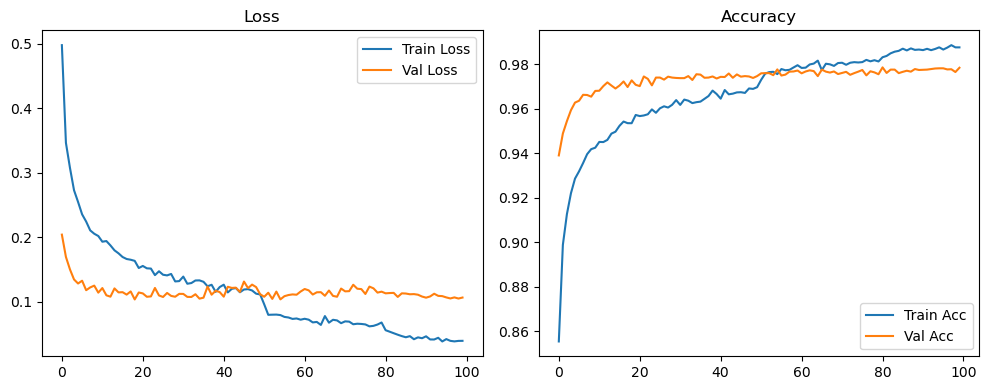

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2801, Acc: 0.9159 | Val Loss: 0.1612, Acc: 0.9527


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9544 | Val Loss: 0.1342, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1166, Acc: 0.9646 | Val Loss: 0.1301, Acc: 0.9626


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0937, Acc: 0.9706 | Val Loss: 0.1096, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9754 | Val Loss: 0.1238, Acc: 0.9662


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9794 | Val Loss: 0.1212, Acc: 0.9673


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9824 | Val Loss: 0.1146, Acc: 0.9713


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.1276, Acc: 0.9658


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.1117, Acc: 0.9721


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9860 | Val Loss: 0.1074, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.1224, Acc: 0.9724


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9896 | Val Loss: 0.1331, Acc: 0.9717


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9898 | Val Loss: 0.1261, Acc: 0.9723


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.1359, Acc: 0.9729


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9923 | Val Loss: 0.1342, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.1278, Acc: 0.9730


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9929 | Val Loss: 0.1336, Acc: 0.9736


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9924 | Val Loss: 0.1301, Acc: 0.9729


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9929 | Val Loss: 0.1301, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1443, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9934 | Val Loss: 0.1178, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1282, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1463, Acc: 0.9758


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.1697, Acc: 0.9729


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9941 | Val Loss: 0.1366, Acc: 0.9766


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9945 | Val Loss: 0.1386, Acc: 0.9750


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.1669, Acc: 0.9712


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1399, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9949 | Val Loss: 0.1450, Acc: 0.9737


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1358, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9960 | Val Loss: 0.1629, Acc: 0.9733


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.1508, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1447, Acc: 0.9765


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1704, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9954 | Val Loss: 0.1455, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1665, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9964 | Val Loss: 0.1709, Acc: 0.9759


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9954 | Val Loss: 0.1552, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1668, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9958 | Val Loss: 0.1701, Acc: 0.9731


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9962 | Val Loss: 0.1602, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1707, Acc: 0.9762


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.1777, Acc: 0.9741


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1555, Acc: 0.9768


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9968 | Val Loss: 0.1735, Acc: 0.9761


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.1524, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.1766, Acc: 0.9749


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9973 | Val Loss: 0.2067, Acc: 0.9740


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9963 | Val Loss: 0.1621, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1677, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1517, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1509, Acc: 0.9800


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1635, Acc: 0.9784


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1520, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1610, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1677, Acc: 0.9799


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1658, Acc: 0.9803


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1617, Acc: 0.9820


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1722, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1731, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1765, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1742, Acc: 0.9786


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1760, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1742, Acc: 0.9793


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1871, Acc: 0.9794


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1993, Acc: 0.9796


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1938, Acc: 0.9808


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2023, Acc: 0.9787


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1996, Acc: 0.9793


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1913, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1986, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2107, Acc: 0.9800


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1951, Acc: 0.9803


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1918, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2086, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2148, Acc: 0.9800


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2051, Acc: 0.9804


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2246, Acc: 0.9795


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2173, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.2024, Acc: 0.9797


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2131, Acc: 0.9803


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2110, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2096, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2034, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2171, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2118, Acc: 0.9816


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2104, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2153, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.2321, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2239, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2286, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2205, Acc: 0.9801


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2178, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2233, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2312, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2331, Acc: 0.9809


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2229, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2344, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2350, Acc: 0.9801


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2360, Acc: 0.9808


Final Test Loss: 0.1911 Accuracy: 0.9815


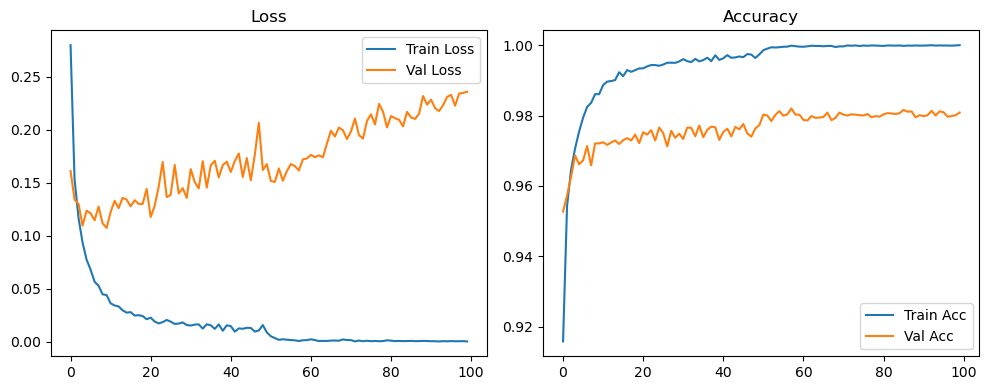

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3291, Acc: 0.9022 | Val Loss: 0.1684, Acc: 0.9515


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1972, Acc: 0.9423 | Val Loss: 0.1407, Acc: 0.9567


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1652, Acc: 0.9517 | Val Loss: 0.1250, Acc: 0.9623


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1445, Acc: 0.9563 | Val Loss: 0.1233, Acc: 0.9650


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1234, Acc: 0.9622 | Val Loss: 0.1131, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1081, Acc: 0.9671 | Val Loss: 0.1116, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1004, Acc: 0.9702 | Val Loss: 0.1029, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9733 | Val Loss: 0.1196, Acc: 0.9671


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0846, Acc: 0.9739 | Val Loss: 0.1353, Acc: 0.9677


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9754 | Val Loss: 0.1078, Acc: 0.9734


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9768 | Val Loss: 0.1167, Acc: 0.9725


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9778 | Val Loss: 0.1253, Acc: 0.9718


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9780 | Val Loss: 0.1167, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9799 | Val Loss: 0.1255, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9816 | Val Loss: 0.1176, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9816 | Val Loss: 0.1319, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9825 | Val Loss: 0.1137, Acc: 0.9755


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9839 | Val Loss: 0.1093, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9835 | Val Loss: 0.1072, Acc: 0.9760


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9846 | Val Loss: 0.1319, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9839 | Val Loss: 0.1298, Acc: 0.9739


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9846 | Val Loss: 0.1280, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9856 | Val Loss: 0.1440, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9855 | Val Loss: 0.1382, Acc: 0.9730


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9855 | Val Loss: 0.1342, Acc: 0.9761


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9876 | Val Loss: 0.1363, Acc: 0.9733


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9875 | Val Loss: 0.1489, Acc: 0.9741


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9867 | Val Loss: 0.1357, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9866 | Val Loss: 0.1460, Acc: 0.9739


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9888 | Val Loss: 0.1587, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9879 | Val Loss: 0.1527, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9880 | Val Loss: 0.1435, Acc: 0.9746


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9884 | Val Loss: 0.1406, Acc: 0.9772


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9891 | Val Loss: 0.1421, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9872 | Val Loss: 0.1386, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9901 | Val Loss: 0.1543, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9889 | Val Loss: 0.1599, Acc: 0.9757


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9886 | Val Loss: 0.1557, Acc: 0.9743


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9898 | Val Loss: 0.1732, Acc: 0.9734


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9909 | Val Loss: 0.1702, Acc: 0.9740


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9895 | Val Loss: 0.1470, Acc: 0.9764


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9903 | Val Loss: 0.1618, Acc: 0.9765


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9914 | Val Loss: 0.1640, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9900 | Val Loss: 0.1618, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9900 | Val Loss: 0.1622, Acc: 0.9774


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9902 | Val Loss: 0.1413, Acc: 0.9773


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9913 | Val Loss: 0.1668, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9915 | Val Loss: 0.1827, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9902 | Val Loss: 0.1819, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9910 | Val Loss: 0.1703, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9945 | Val Loss: 0.1445, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9956 | Val Loss: 0.1487, Acc: 0.9791


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.1493, Acc: 0.9811


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9963 | Val Loss: 0.1518, Acc: 0.9793


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9962 | Val Loss: 0.1474, Acc: 0.9804


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9964 | Val Loss: 0.1452, Acc: 0.9804


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1409, Acc: 0.9801


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1571, Acc: 0.9803


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1520, Acc: 0.9812


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1638, Acc: 0.9805


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.1634, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1601, Acc: 0.9799


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9976 | Val Loss: 0.1548, Acc: 0.9810


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1442, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1571, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9973 | Val Loss: 0.1515, Acc: 0.9803


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9977 | Val Loss: 0.1605, Acc: 0.9800


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9972 | Val Loss: 0.1502, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9973 | Val Loss: 0.1408, Acc: 0.9808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1566, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1622, Acc: 0.9803


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1610, Acc: 0.9810


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9979 | Val Loss: 0.1522, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9976 | Val Loss: 0.1613, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1600, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1686, Acc: 0.9802


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9978 | Val Loss: 0.1627, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1644, Acc: 0.9810


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1656, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9978 | Val Loss: 0.1560, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1570, Acc: 0.9807


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9984 | Val Loss: 0.1568, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1575, Acc: 0.9807


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1594, Acc: 0.9813


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.1584, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1569, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1620, Acc: 0.9804


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1551, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1615, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1503, Acc: 0.9810


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1591, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1625, Acc: 0.9799


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1692, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1645, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1655, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1592, Acc: 0.9806


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1632, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1665, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1619, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1611, Acc: 0.9816


Final Test Loss: 0.1603 Accuracy: 0.9820


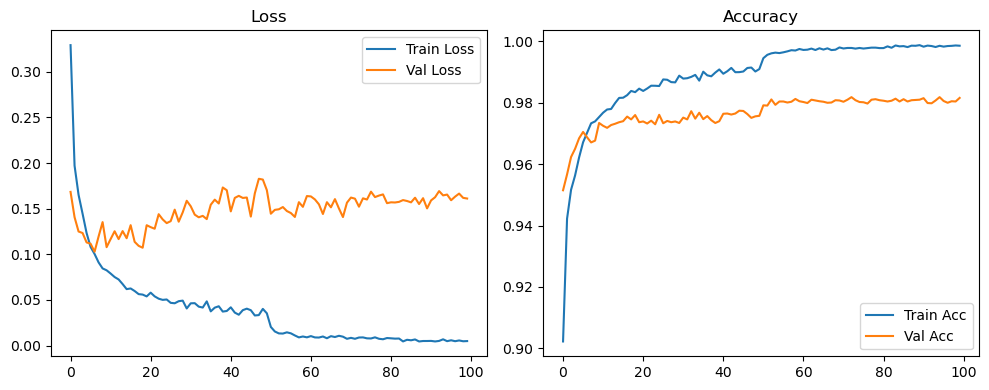

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4978, Acc: 0.8554 | Val Loss: 0.2039, Acc: 0.9391


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3463, Acc: 0.8988 | Val Loss: 0.1692, Acc: 0.9489


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9127 | Val Loss: 0.1499, Acc: 0.9545


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2728, Acc: 0.9221 | Val Loss: 0.1343, Acc: 0.9594


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2545, Acc: 0.9286 | Val Loss: 0.1280, Acc: 0.9628


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2353, Acc: 0.9319 | Val Loss: 0.1324, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2241, Acc: 0.9356 | Val Loss: 0.1176, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.2105, Acc: 0.9396 | Val Loss: 0.1219, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.2053, Acc: 0.9419 | Val Loss: 0.1247, Acc: 0.9655


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.2017, Acc: 0.9425 | Val Loss: 0.1139, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1929, Acc: 0.9451 | Val Loss: 0.1210, Acc: 0.9682


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1939, Acc: 0.9451 | Val Loss: 0.1097, Acc: 0.9702


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1872, Acc: 0.9461 | Val Loss: 0.1076, Acc: 0.9719


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1795, Acc: 0.9489 | Val Loss: 0.1204, Acc: 0.9705


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1748, Acc: 0.9497 | Val Loss: 0.1142, Acc: 0.9692


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9524 | Val Loss: 0.1146, Acc: 0.9705


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1661, Acc: 0.9543 | Val Loss: 0.1108, Acc: 0.9723


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1649, Acc: 0.9536 | Val Loss: 0.1157, Acc: 0.9698


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1632, Acc: 0.9536 | Val Loss: 0.1033, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9573 | Val Loss: 0.1141, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1553, Acc: 0.9568 | Val Loss: 0.1127, Acc: 0.9702


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9570 | Val Loss: 0.1074, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1512, Acc: 0.9576 | Val Loss: 0.1080, Acc: 0.9735


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9598 | Val Loss: 0.1211, Acc: 0.9706


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1470, Acc: 0.9583 | Val Loss: 0.1095, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1416, Acc: 0.9603 | Val Loss: 0.1071, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1406, Acc: 0.9612 | Val Loss: 0.1134, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9606 | Val Loss: 0.1088, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1313, Acc: 0.9618 | Val Loss: 0.1075, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1318, Acc: 0.9640 | Val Loss: 0.1120, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9618 | Val Loss: 0.1119, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1277, Acc: 0.9642 | Val Loss: 0.1073, Acc: 0.9738


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1287, Acc: 0.9637 | Val Loss: 0.1071, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1327, Acc: 0.9626 | Val Loss: 0.1114, Acc: 0.9730


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9630 | Val Loss: 0.1046, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1307, Acc: 0.9633 | Val Loss: 0.1061, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9645 | Val Loss: 0.1233, Acc: 0.9740


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1260, Acc: 0.9658 | Val Loss: 0.1107, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9682 | Val Loss: 0.1167, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1225, Acc: 0.9667 | Val Loss: 0.1147, Acc: 0.9737


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1262, Acc: 0.9646 | Val Loss: 0.1076, Acc: 0.9744


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1142, Acc: 0.9685 | Val Loss: 0.1229, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1198, Acc: 0.9666 | Val Loss: 0.1212, Acc: 0.9759


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9669 | Val Loss: 0.1216, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1145, Acc: 0.9674 | Val Loss: 0.1150, Acc: 0.9755


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9675 | Val Loss: 0.1311, Acc: 0.9745


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1193, Acc: 0.9672 | Val Loss: 0.1209, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1172, Acc: 0.9692 | Val Loss: 0.1263, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1122, Acc: 0.9690 | Val Loss: 0.1225, Acc: 0.9739


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1111, Acc: 0.9698 | Val Loss: 0.1114, Acc: 0.9748


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0927, Acc: 0.9741 | Val Loss: 0.1057, Acc: 0.9759


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9770 | Val Loss: 0.1135, Acc: 0.9763


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0743, Acc: 0.9784 | Val Loss: 0.1050, Acc: 0.9767


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9790 | Val Loss: 0.1023, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0697, Acc: 0.9785 | Val Loss: 0.1011, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0636, Acc: 0.9806 | Val Loss: 0.1002, Acc: 0.9771


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0996, Acc: 0.9773


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9814 | Val Loss: 0.1031, Acc: 0.9776


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9825 | Val Loss: 0.1009, Acc: 0.9779


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9828 | Val Loss: 0.1020, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9829 | Val Loss: 0.1059, Acc: 0.9773


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9824 | Val Loss: 0.1080, Acc: 0.9761


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9838 | Val Loss: 0.1001, Acc: 0.9777


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9843 | Val Loss: 0.1057, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.1007, Acc: 0.9769


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9822 | Val Loss: 0.0994, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9842 | Val Loss: 0.1075, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9848 | Val Loss: 0.1001, Acc: 0.9773


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9836 | Val Loss: 0.0983, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9851 | Val Loss: 0.1056, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9843 | Val Loss: 0.1039, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9842 | Val Loss: 0.1042, Acc: 0.9773


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9850 | Val Loss: 0.1042, Acc: 0.9774


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9854 | Val Loss: 0.1043, Acc: 0.9774


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9852 | Val Loss: 0.1023, Acc: 0.9777


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9847 | Val Loss: 0.1008, Acc: 0.9786


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9864 | Val Loss: 0.1051, Acc: 0.9771


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 0.1113, Acc: 0.9776


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9854 | Val Loss: 0.1010, Acc: 0.9781


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9847 | Val Loss: 0.0998, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.1010, Acc: 0.9783


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9856 | Val Loss: 0.1022, Acc: 0.9777


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 0.1054, Acc: 0.9776


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9871 | Val Loss: 0.1011, Acc: 0.9793


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 0.1042, Acc: 0.9776


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9867 | Val Loss: 0.1045, Acc: 0.9776


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9873 | Val Loss: 0.1046, Acc: 0.9773


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9874 | Val Loss: 0.1023, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.0992, Acc: 0.9786


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0984, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9858 | Val Loss: 0.0984, Acc: 0.9781


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9870 | Val Loss: 0.1009, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.1040, Acc: 0.9783


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9866 | Val Loss: 0.1015, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.0978, Acc: 0.9790


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9871 | Val Loss: 0.1002, Acc: 0.9783


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9881 | Val Loss: 0.0992, Acc: 0.9779


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9889 | Val Loss: 0.0992, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9876 | Val Loss: 0.1009, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.0983, Acc: 0.9787


Final Test Loss: 0.0882 Accuracy: 0.9817


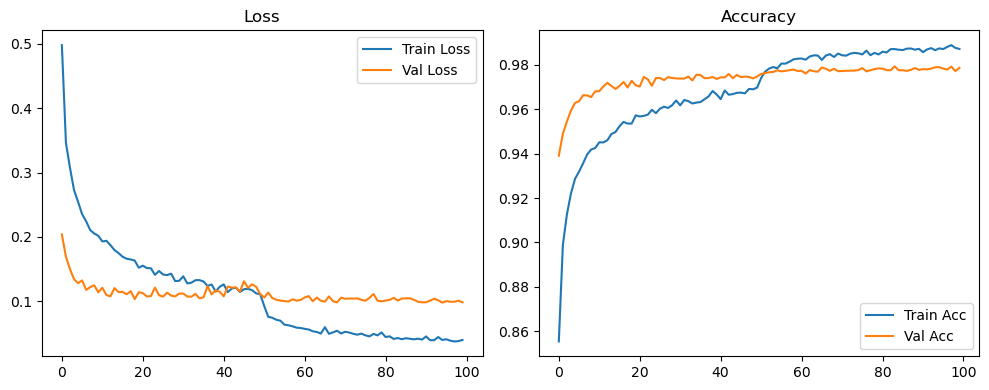

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2628, Acc: 0.9213 | Val Loss: 0.1430, Acc: 0.9563


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1437, Acc: 0.9571 | Val Loss: 0.1257, Acc: 0.9612


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9671 | Val Loss: 0.1209, Acc: 0.9627


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9714 | Val Loss: 0.1154, Acc: 0.9680


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9763 | Val Loss: 0.1154, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9804 | Val Loss: 0.1233, Acc: 0.9674


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9826 | Val Loss: 0.1194, Acc: 0.9688


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9849 | Val Loss: 0.1811, Acc: 0.9524


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9856 | Val Loss: 0.1263, Acc: 0.9696


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.1073, Acc: 0.9736


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9892 | Val Loss: 0.1209, Acc: 0.9720


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1171, Acc: 0.9734


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1203, Acc: 0.9716


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1426, Acc: 0.9692


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.1460, Acc: 0.9684


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.1255, Acc: 0.9722


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1341, Acc: 0.9719


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1183, Acc: 0.9746


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.1339, Acc: 0.9750


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1277, Acc: 0.9744


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.1398, Acc: 0.9726


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1334, Acc: 0.9736


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.1336, Acc: 0.9738


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1441, Acc: 0.9753


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.1334, Acc: 0.9747


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.1318, Acc: 0.9744


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1477, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1413, Acc: 0.9746


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1502, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1603, Acc: 0.9726


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1710, Acc: 0.9730


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1454, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9951 | Val Loss: 0.1510, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1390, Acc: 0.9764


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1643, Acc: 0.9746


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1454, Acc: 0.9760


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1620, Acc: 0.9746


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1497, Acc: 0.9751


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1583, Acc: 0.9755


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1731, Acc: 0.9735


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9965 | Val Loss: 0.1592, Acc: 0.9756


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.1739, Acc: 0.9726


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1597, Acc: 0.9753


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1612, Acc: 0.9732


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.1550, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1753, Acc: 0.9746


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1639, Acc: 0.9752


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1685, Acc: 0.9761


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1820, Acc: 0.9748


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1616, Acc: 0.9758


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.1616, Acc: 0.9761


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9970 | Val Loss: 0.1630, Acc: 0.9755


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.1542, Acc: 0.9760


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1793, Acc: 0.9749


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.1676, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9979 | Val Loss: 0.1523, Acc: 0.9763


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1769, Acc: 0.9745


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1655, Acc: 0.9767


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1646, Acc: 0.9780


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1661, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1938, Acc: 0.9748


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1786, Acc: 0.9750


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1718, Acc: 0.9758


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1942, Acc: 0.9755


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1849, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9976 | Val Loss: 0.1682, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1761, Acc: 0.9779


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.1752, Acc: 0.9764


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1864, Acc: 0.9777


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9976 | Val Loss: 0.1927, Acc: 0.9732


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1984, Acc: 0.9756


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1830, Acc: 0.9769


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1656, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1823, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1876, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.1956, Acc: 0.9763


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.2011, Acc: 0.9756


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.2066, Acc: 0.9765


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.2001, Acc: 0.9778


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.2264, Acc: 0.9746


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.2272, Acc: 0.9758


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9980 | Val Loss: 0.2326, Acc: 0.9742


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.2230, Acc: 0.9759


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.2274, Acc: 0.9769


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.2207, Acc: 0.9764


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.2119, Acc: 0.9766


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9985 | Val Loss: 0.2118, Acc: 0.9771


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.2099, Acc: 0.9767


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9980 | Val Loss: 0.1934, Acc: 0.9770


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9981 | Val Loss: 0.1950, Acc: 0.9753


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.2346, Acc: 0.9753


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9979 | Val Loss: 0.2085, Acc: 0.9748


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.2068, Acc: 0.9752


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9981 | Val Loss: 0.2272, Acc: 0.9767


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.2110, Acc: 0.9772


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.2309, Acc: 0.9768


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9978 | Val Loss: 0.2414, Acc: 0.9762


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.2278, Acc: 0.9752


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1994, Acc: 0.9776


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9987 | Val Loss: 0.2326, Acc: 0.9757


Final Test Loss: 0.2328 Accuracy: 0.9761


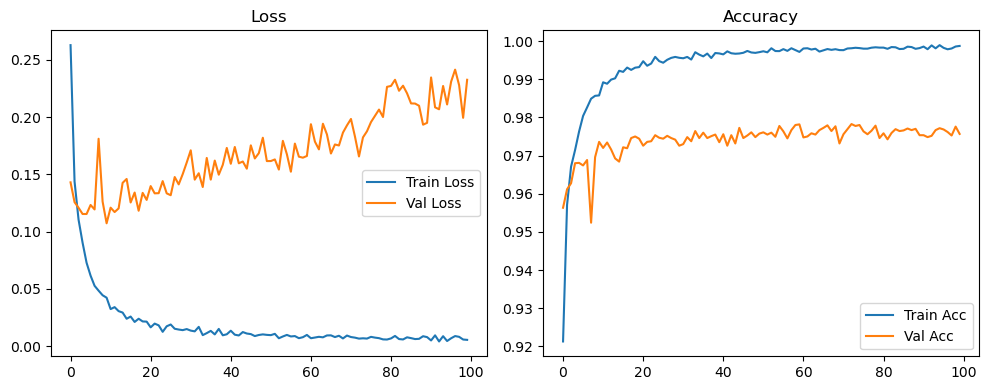

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3086, Acc: 0.9072 | Val Loss: 0.1591, Acc: 0.9509


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1830, Acc: 0.9461 | Val Loss: 0.1255, Acc: 0.9617


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1537, Acc: 0.9538 | Val Loss: 0.1303, Acc: 0.9599


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1315, Acc: 0.9593 | Val Loss: 0.1210, Acc: 0.9639


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1118, Acc: 0.9649 | Val Loss: 0.1112, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1024, Acc: 0.9676 | Val Loss: 0.1138, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0903, Acc: 0.9717 | Val Loss: 0.1027, Acc: 0.9715


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9736 | Val Loss: 0.1129, Acc: 0.9654


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9746 | Val Loss: 0.0992, Acc: 0.9735


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9759 | Val Loss: 0.1052, Acc: 0.9740


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9783 | Val Loss: 0.1170, Acc: 0.9699


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9799 | Val Loss: 0.1090, Acc: 0.9717


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9805 | Val Loss: 0.0999, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9819 | Val Loss: 0.1067, Acc: 0.9738


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9834 | Val Loss: 0.1112, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9829 | Val Loss: 0.1075, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9837 | Val Loss: 0.1128, Acc: 0.9737


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.1154, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 0.0999, Acc: 0.9762


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9866 | Val Loss: 0.1035, Acc: 0.9768


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9863 | Val Loss: 0.1086, Acc: 0.9741


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.1093, Acc: 0.9739


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9874 | Val Loss: 0.1092, Acc: 0.9737


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.1083, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9878 | Val Loss: 0.1094, Acc: 0.9754


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9871 | Val Loss: 0.1168, Acc: 0.9744


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9884 | Val Loss: 0.1131, Acc: 0.9751


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.1248, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9891 | Val Loss: 0.1272, Acc: 0.9758


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.1124, Acc: 0.9764


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9900 | Val Loss: 0.1174, Acc: 0.9759


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9893 | Val Loss: 0.1201, Acc: 0.9765


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.1295, Acc: 0.9752


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.1360, Acc: 0.9755


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9899 | Val Loss: 0.1313, Acc: 0.9748


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.1374, Acc: 0.9758


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9910 | Val Loss: 0.1361, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9913 | Val Loss: 0.1248, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9915 | Val Loss: 0.1322, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.1342, Acc: 0.9757


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.1273, Acc: 0.9762


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9913 | Val Loss: 0.1250, Acc: 0.9786


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9920 | Val Loss: 0.1375, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9915 | Val Loss: 0.1435, Acc: 0.9740


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9924 | Val Loss: 0.1447, Acc: 0.9754


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9921 | Val Loss: 0.1464, Acc: 0.9769


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9923 | Val Loss: 0.1375, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9928 | Val Loss: 0.1375, Acc: 0.9769


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.1452, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9927 | Val Loss: 0.1420, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9933 | Val Loss: 0.1446, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9920 | Val Loss: 0.1473, Acc: 0.9746


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9929 | Val Loss: 0.1387, Acc: 0.9764


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9931 | Val Loss: 0.1522, Acc: 0.9772


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9928 | Val Loss: 0.1517, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9930 | Val Loss: 0.1687, Acc: 0.9756


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9940 | Val Loss: 0.1614, Acc: 0.9759


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9934 | Val Loss: 0.1714, Acc: 0.9759


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9936 | Val Loss: 0.1589, Acc: 0.9763


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9936 | Val Loss: 0.1584, Acc: 0.9755


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9942 | Val Loss: 0.1703, Acc: 0.9766


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9945 | Val Loss: 0.1578, Acc: 0.9772


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9933 | Val Loss: 0.1512, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9935 | Val Loss: 0.1577, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9941 | Val Loss: 0.1624, Acc: 0.9768


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9928 | Val Loss: 0.1507, Acc: 0.9768


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9947 | Val Loss: 0.1706, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9943 | Val Loss: 0.1498, Acc: 0.9777


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9937 | Val Loss: 0.1635, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9945 | Val Loss: 0.1652, Acc: 0.9753


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9941 | Val Loss: 0.1488, Acc: 0.9784


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.1637, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9940 | Val Loss: 0.1715, Acc: 0.9762


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9935 | Val Loss: 0.1588, Acc: 0.9749


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9939 | Val Loss: 0.1518, Acc: 0.9765


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9943 | Val Loss: 0.1412, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9936 | Val Loss: 0.1447, Acc: 0.9758


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9952 | Val Loss: 0.1624, Acc: 0.9756


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9936 | Val Loss: 0.1585, Acc: 0.9779


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9943 | Val Loss: 0.1607, Acc: 0.9778


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9946 | Val Loss: 0.1609, Acc: 0.9769


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9949 | Val Loss: 0.1626, Acc: 0.9777


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9941 | Val Loss: 0.1766, Acc: 0.9767


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9948 | Val Loss: 0.1765, Acc: 0.9764


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9939 | Val Loss: 0.1765, Acc: 0.9762


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9944 | Val Loss: 0.1838, Acc: 0.9758


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9944 | Val Loss: 0.1742, Acc: 0.9773


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9948 | Val Loss: 0.1847, Acc: 0.9761


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9949 | Val Loss: 0.1657, Acc: 0.9776


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9955 | Val Loss: 0.1817, Acc: 0.9768


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9959 | Val Loss: 0.1960, Acc: 0.9758


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9940 | Val Loss: 0.1620, Acc: 0.9776


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9953 | Val Loss: 0.1794, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1819, Acc: 0.9787


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9953 | Val Loss: 0.1767, Acc: 0.9778


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9950 | Val Loss: 0.1765, Acc: 0.9771


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9956 | Val Loss: 0.1802, Acc: 0.9768


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9948 | Val Loss: 0.1650, Acc: 0.9779


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9946 | Val Loss: 0.1778, Acc: 0.9762


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9950 | Val Loss: 0.1902, Acc: 0.9755


Final Test Loss: 0.1684 Accuracy: 0.9781


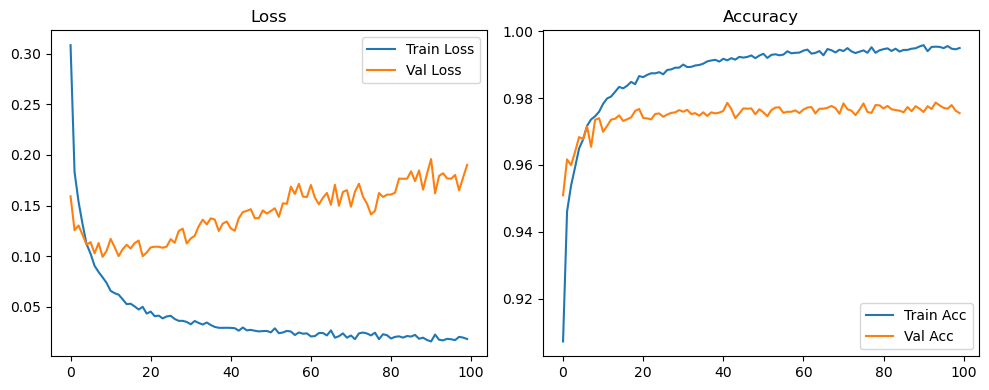

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4675, Acc: 0.8606 | Val Loss: 0.1995, Acc: 0.9396


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3136, Acc: 0.9079 | Val Loss: 0.1610, Acc: 0.9503


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2736, Acc: 0.9190 | Val Loss: 0.1455, Acc: 0.9566


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2486, Acc: 0.9287 | Val Loss: 0.1268, Acc: 0.9626


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2256, Acc: 0.9335 | Val Loss: 0.1168, Acc: 0.9654


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2122, Acc: 0.9388 | Val Loss: 0.1183, Acc: 0.9645


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1963, Acc: 0.9425 | Val Loss: 0.1180, Acc: 0.9670


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1833, Acc: 0.9451 | Val Loss: 0.1136, Acc: 0.9667


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1792, Acc: 0.9466 | Val Loss: 0.1212, Acc: 0.9655


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1743, Acc: 0.9479 | Val Loss: 0.1042, Acc: 0.9698


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1666, Acc: 0.9496 | Val Loss: 0.1105, Acc: 0.9676


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1615, Acc: 0.9522 | Val Loss: 0.1079, Acc: 0.9701


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1579, Acc: 0.9526 | Val Loss: 0.1011, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1526, Acc: 0.9544 | Val Loss: 0.1042, Acc: 0.9698


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1497, Acc: 0.9553 | Val Loss: 0.1045, Acc: 0.9712


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1382, Acc: 0.9588 | Val Loss: 0.1050, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1365, Acc: 0.9588 | Val Loss: 0.1000, Acc: 0.9718


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1384, Acc: 0.9593 | Val Loss: 0.1037, Acc: 0.9718


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9596 | Val Loss: 0.0965, Acc: 0.9723


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1303, Acc: 0.9610 | Val Loss: 0.1005, Acc: 0.9736


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1328, Acc: 0.9602 | Val Loss: 0.0996, Acc: 0.9720


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1239, Acc: 0.9628 | Val Loss: 0.0993, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1175, Acc: 0.9648 | Val Loss: 0.0969, Acc: 0.9743


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1204, Acc: 0.9640 | Val Loss: 0.1065, Acc: 0.9718


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1182, Acc: 0.9645 | Val Loss: 0.1048, Acc: 0.9735


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1227, Acc: 0.9634 | Val Loss: 0.1013, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1157, Acc: 0.9655 | Val Loss: 0.1037, Acc: 0.9746


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9663 | Val Loss: 0.0951, Acc: 0.9738


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1081, Acc: 0.9670 | Val Loss: 0.1038, Acc: 0.9734


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9685 | Val Loss: 0.1097, Acc: 0.9728


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9667 | Val Loss: 0.1062, Acc: 0.9731


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.1118, Acc: 0.9657 | Val Loss: 0.1031, Acc: 0.9730


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1098, Acc: 0.9682 | Val Loss: 0.0984, Acc: 0.9741


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.1032, Acc: 0.9684 | Val Loss: 0.1056, Acc: 0.9727


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9681 | Val Loss: 0.1054, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9689 | Val Loss: 0.1100, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9702 | Val Loss: 0.1092, Acc: 0.9736


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.1039, Acc: 0.9686 | Val Loss: 0.1032, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.1010, Acc: 0.9687 | Val Loss: 0.1048, Acc: 0.9753


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0978, Acc: 0.9708 | Val Loss: 0.0988, Acc: 0.9751


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9721 | Val Loss: 0.0976, Acc: 0.9763


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9724 | Val Loss: 0.1000, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0973, Acc: 0.9712 | Val Loss: 0.1061, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9722 | Val Loss: 0.1110, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0909, Acc: 0.9721 | Val Loss: 0.1045, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0913, Acc: 0.9732 | Val Loss: 0.1082, Acc: 0.9747


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0982, Acc: 0.9705 | Val Loss: 0.1024, Acc: 0.9766


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0922, Acc: 0.9728 | Val Loss: 0.1111, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9730 | Val Loss: 0.1113, Acc: 0.9737


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9742 | Val Loss: 0.1030, Acc: 0.9760


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0910, Acc: 0.9730 | Val Loss: 0.1038, Acc: 0.9751


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0918, Acc: 0.9735 | Val Loss: 0.1094, Acc: 0.9748


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0896, Acc: 0.9736 | Val Loss: 0.1079, Acc: 0.9748


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0879, Acc: 0.9736 | Val Loss: 0.1136, Acc: 0.9740


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9726 | Val Loss: 0.1061, Acc: 0.9748


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0886, Acc: 0.9737 | Val Loss: 0.1018, Acc: 0.9752


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0886, Acc: 0.9730 | Val Loss: 0.1130, Acc: 0.9739


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9736 | Val Loss: 0.1036, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9755 | Val Loss: 0.1057, Acc: 0.9760


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9741 | Val Loss: 0.1040, Acc: 0.9754


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9745 | Val Loss: 0.1083, Acc: 0.9737


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0818, Acc: 0.9753 | Val Loss: 0.1148, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9747 | Val Loss: 0.1169, Acc: 0.9734


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0795, Acc: 0.9762 | Val Loss: 0.1140, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9752 | Val Loss: 0.1108, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9751 | Val Loss: 0.1155, Acc: 0.9742


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0802, Acc: 0.9759 | Val Loss: 0.1149, Acc: 0.9765


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0801, Acc: 0.9759 | Val Loss: 0.1004, Acc: 0.9767


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9755 | Val Loss: 0.1104, Acc: 0.9760


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9765 | Val Loss: 0.1117, Acc: 0.9748


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0865, Acc: 0.9748 | Val Loss: 0.1099, Acc: 0.9764


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0833, Acc: 0.9755 | Val Loss: 0.1092, Acc: 0.9748


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9777 | Val Loss: 0.1137, Acc: 0.9754


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9776 | Val Loss: 0.1131, Acc: 0.9758


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9777 | Val Loss: 0.1098, Acc: 0.9766


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9774 | Val Loss: 0.1149, Acc: 0.9742


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0787, Acc: 0.9769 | Val Loss: 0.1210, Acc: 0.9747


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9767 | Val Loss: 0.1146, Acc: 0.9745


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0756, Acc: 0.9773 | Val Loss: 0.1138, Acc: 0.9769


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0769, Acc: 0.9780 | Val Loss: 0.1198, Acc: 0.9747


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0743, Acc: 0.9778 | Val Loss: 0.1203, Acc: 0.9751


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0786, Acc: 0.9780 | Val Loss: 0.1176, Acc: 0.9751


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0796, Acc: 0.9770 | Val Loss: 0.1172, Acc: 0.9743


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0717, Acc: 0.9781 | Val Loss: 0.1161, Acc: 0.9764


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0763, Acc: 0.9779 | Val Loss: 0.1192, Acc: 0.9763


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0701, Acc: 0.9790 | Val Loss: 0.1125, Acc: 0.9751


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9779 | Val Loss: 0.1301, Acc: 0.9739


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0744, Acc: 0.9787 | Val Loss: 0.1146, Acc: 0.9775


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0708, Acc: 0.9783 | Val Loss: 0.1249, Acc: 0.9737


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9797 | Val Loss: 0.1252, Acc: 0.9755


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9787 | Val Loss: 0.1160, Acc: 0.9761


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0724, Acc: 0.9787 | Val Loss: 0.1168, Acc: 0.9746


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9800 | Val Loss: 0.1212, Acc: 0.9762


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0744, Acc: 0.9781 | Val Loss: 0.1197, Acc: 0.9754


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9796 | Val Loss: 0.1122, Acc: 0.9760


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0741, Acc: 0.9777 | Val Loss: 0.1140, Acc: 0.9759


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9805 | Val Loss: 0.1162, Acc: 0.9749


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0743, Acc: 0.9781 | Val Loss: 0.1168, Acc: 0.9752


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9802 | Val Loss: 0.1168, Acc: 0.9770


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9794 | Val Loss: 0.1125, Acc: 0.9759


Final Test Loss: 0.1064 Accuracy: 0.9778


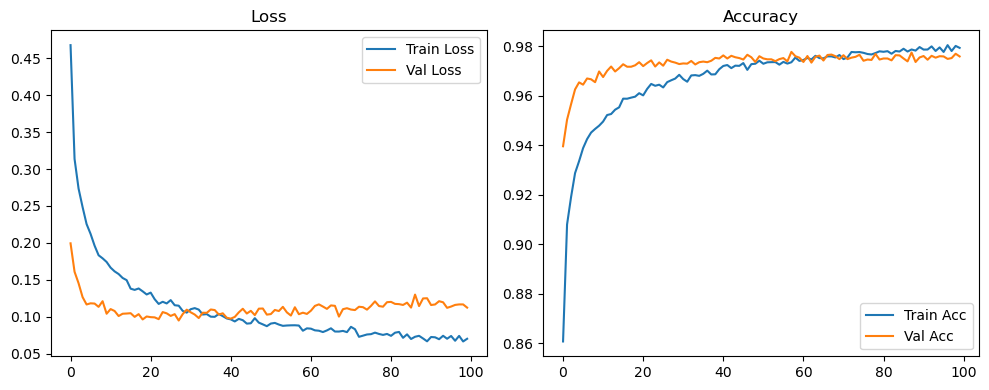

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2628, Acc: 0.9213 | Val Loss: 0.1430, Acc: 0.9563


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1437, Acc: 0.9571 | Val Loss: 0.1257, Acc: 0.9612


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9671 | Val Loss: 0.1209, Acc: 0.9627


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9714 | Val Loss: 0.1154, Acc: 0.9680


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9763 | Val Loss: 0.1154, Acc: 0.9681


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9804 | Val Loss: 0.1233, Acc: 0.9674


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9826 | Val Loss: 0.1194, Acc: 0.9688


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9849 | Val Loss: 0.1811, Acc: 0.9524


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9856 | Val Loss: 0.1263, Acc: 0.9696


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.1073, Acc: 0.9736


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9892 | Val Loss: 0.1209, Acc: 0.9720


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1171, Acc: 0.9734


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1203, Acc: 0.9716


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.1426, Acc: 0.9692


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.1460, Acc: 0.9684


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9919 | Val Loss: 0.1255, Acc: 0.9722


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.1341, Acc: 0.9719


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1183, Acc: 0.9746


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.1339, Acc: 0.9750


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1277, Acc: 0.9744


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.1398, Acc: 0.9726


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1334, Acc: 0.9736


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.1336, Acc: 0.9738


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1441, Acc: 0.9753


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.1334, Acc: 0.9747


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.1318, Acc: 0.9744


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1477, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1413, Acc: 0.9746


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1502, Acc: 0.9742


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.1603, Acc: 0.9726


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1710, Acc: 0.9730


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1454, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9951 | Val Loss: 0.1510, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1390, Acc: 0.9764


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1643, Acc: 0.9746


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1454, Acc: 0.9760


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1620, Acc: 0.9746


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1497, Acc: 0.9751


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1583, Acc: 0.9755


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1731, Acc: 0.9735


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9965 | Val Loss: 0.1592, Acc: 0.9756


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.1739, Acc: 0.9726


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1597, Acc: 0.9753


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1612, Acc: 0.9732


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.1550, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1753, Acc: 0.9746


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1639, Acc: 0.9752


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1685, Acc: 0.9761


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1820, Acc: 0.9748


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1616, Acc: 0.9758


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1351, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1420, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1511, Acc: 0.9783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1587, Acc: 0.9778


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1455, Acc: 0.9795


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1496, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1524, Acc: 0.9793


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1572, Acc: 0.9795


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1562, Acc: 0.9804


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1693, Acc: 0.9780


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1744, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1771, Acc: 0.9782


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1800, Acc: 0.9784


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1796, Acc: 0.9784


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1996, Acc: 0.9774


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1905, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1875, Acc: 0.9774


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1834, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1737, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1926, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2040, Acc: 0.9777


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1997, Acc: 0.9786


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1870, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1774, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1874, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.2087, Acc: 0.9781


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.2123, Acc: 0.9779


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.2041, Acc: 0.9793


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.2189, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1967, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1941, Acc: 0.9795


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1973, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1961, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1980, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2049, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1999, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2005, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.2118, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2011, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1989, Acc: 0.9791


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.2075, Acc: 0.9790


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.2046, Acc: 0.9787


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2145, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2109, Acc: 0.9789


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.2265, Acc: 0.9790


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2172, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.2140, Acc: 0.9791


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.2137, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2150, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2154, Acc: 0.9794


Final Test Loss: 0.2050 Accuracy: 0.9825


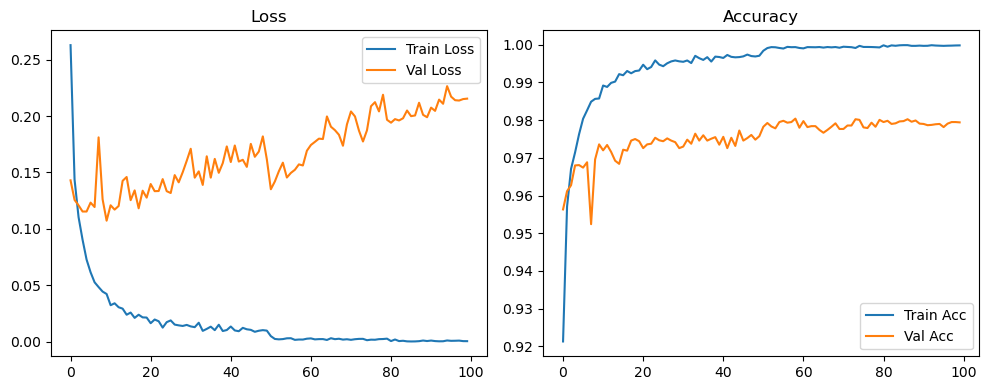

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3086, Acc: 0.9072 | Val Loss: 0.1591, Acc: 0.9509


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1830, Acc: 0.9461 | Val Loss: 0.1255, Acc: 0.9617


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1537, Acc: 0.9538 | Val Loss: 0.1303, Acc: 0.9599


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1315, Acc: 0.9593 | Val Loss: 0.1210, Acc: 0.9639


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1118, Acc: 0.9649 | Val Loss: 0.1112, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1024, Acc: 0.9676 | Val Loss: 0.1138, Acc: 0.9677


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0903, Acc: 0.9717 | Val Loss: 0.1027, Acc: 0.9715


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9736 | Val Loss: 0.1129, Acc: 0.9654


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9746 | Val Loss: 0.0992, Acc: 0.9735


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9759 | Val Loss: 0.1052, Acc: 0.9740


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9783 | Val Loss: 0.1170, Acc: 0.9699


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9799 | Val Loss: 0.1090, Acc: 0.9717


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0619, Acc: 0.9805 | Val Loss: 0.0999, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9819 | Val Loss: 0.1067, Acc: 0.9738


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9834 | Val Loss: 0.1112, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9829 | Val Loss: 0.1075, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9837 | Val Loss: 0.1128, Acc: 0.9737


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9849 | Val Loss: 0.1154, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 0.0999, Acc: 0.9762


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9866 | Val Loss: 0.1035, Acc: 0.9768


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9863 | Val Loss: 0.1086, Acc: 0.9741


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.1093, Acc: 0.9739


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9874 | Val Loss: 0.1092, Acc: 0.9737


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.1083, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9878 | Val Loss: 0.1094, Acc: 0.9754


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9871 | Val Loss: 0.1168, Acc: 0.9744


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9884 | Val Loss: 0.1131, Acc: 0.9751


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.1248, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9891 | Val Loss: 0.1272, Acc: 0.9758


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.1124, Acc: 0.9764


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9900 | Val Loss: 0.1174, Acc: 0.9759


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9893 | Val Loss: 0.1201, Acc: 0.9765


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.1295, Acc: 0.9752


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.1360, Acc: 0.9755


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9899 | Val Loss: 0.1313, Acc: 0.9748


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9903 | Val Loss: 0.1374, Acc: 0.9758


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9910 | Val Loss: 0.1361, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9913 | Val Loss: 0.1248, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9915 | Val Loss: 0.1322, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9909 | Val Loss: 0.1342, Acc: 0.9757


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9918 | Val Loss: 0.1273, Acc: 0.9762


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9913 | Val Loss: 0.1250, Acc: 0.9786


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9920 | Val Loss: 0.1375, Acc: 0.9768


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9915 | Val Loss: 0.1435, Acc: 0.9740


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9924 | Val Loss: 0.1447, Acc: 0.9754


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9921 | Val Loss: 0.1464, Acc: 0.9769


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9923 | Val Loss: 0.1375, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9928 | Val Loss: 0.1375, Acc: 0.9769


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.1452, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9927 | Val Loss: 0.1420, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9950 | Val Loss: 0.1317, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9954 | Val Loss: 0.1328, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1371, Acc: 0.9780


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1483, Acc: 0.9785


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1540, Acc: 0.9777


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9966 | Val Loss: 0.1478, Acc: 0.9789


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.1407, Acc: 0.9795


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1518, Acc: 0.9792


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1446, Acc: 0.9796


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1495, Acc: 0.9796


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1536, Acc: 0.9790


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1487, Acc: 0.9784


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1583, Acc: 0.9794


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1583, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1591, Acc: 0.9771


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9965 | Val Loss: 0.1536, Acc: 0.9772


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1551, Acc: 0.9785


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1519, Acc: 0.9784


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1633, Acc: 0.9778


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1632, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1772, Acc: 0.9776


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1702, Acc: 0.9775


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1512, Acc: 0.9797


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1631, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1611, Acc: 0.9794


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1578, Acc: 0.9784


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9973 | Val Loss: 0.1479, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1509, Acc: 0.9804


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1615, Acc: 0.9790


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1634, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1619, Acc: 0.9789


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1590, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1558, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1600, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1630, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1716, Acc: 0.9789


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1581, Acc: 0.9796


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1697, Acc: 0.9801


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1756, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1650, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1720, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1761, Acc: 0.9800


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1796, Acc: 0.9796


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1798, Acc: 0.9783


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1740, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1793, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1741, Acc: 0.9794


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1692, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1745, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1729, Acc: 0.9792


Final Test Loss: 0.1526 Accuracy: 0.9809


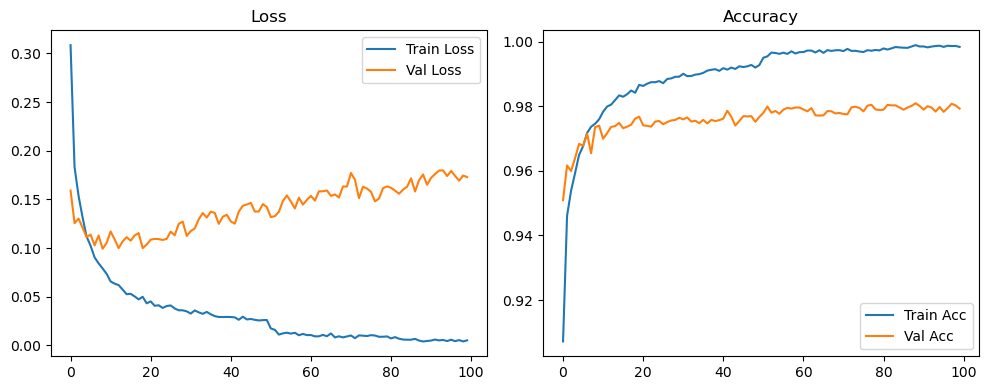

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4675, Acc: 0.8606 | Val Loss: 0.1995, Acc: 0.9396


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3136, Acc: 0.9079 | Val Loss: 0.1610, Acc: 0.9503


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2736, Acc: 0.9190 | Val Loss: 0.1455, Acc: 0.9566


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2486, Acc: 0.9287 | Val Loss: 0.1268, Acc: 0.9626


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2256, Acc: 0.9335 | Val Loss: 0.1168, Acc: 0.9654


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2122, Acc: 0.9388 | Val Loss: 0.1183, Acc: 0.9645


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1963, Acc: 0.9425 | Val Loss: 0.1180, Acc: 0.9670


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1833, Acc: 0.9451 | Val Loss: 0.1136, Acc: 0.9667


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1792, Acc: 0.9466 | Val Loss: 0.1212, Acc: 0.9655


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1743, Acc: 0.9479 | Val Loss: 0.1042, Acc: 0.9698


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1666, Acc: 0.9496 | Val Loss: 0.1105, Acc: 0.9676


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1615, Acc: 0.9522 | Val Loss: 0.1079, Acc: 0.9701


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1579, Acc: 0.9526 | Val Loss: 0.1011, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1526, Acc: 0.9544 | Val Loss: 0.1042, Acc: 0.9698


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1497, Acc: 0.9553 | Val Loss: 0.1045, Acc: 0.9712


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1382, Acc: 0.9588 | Val Loss: 0.1050, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1365, Acc: 0.9588 | Val Loss: 0.1000, Acc: 0.9718


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1384, Acc: 0.9593 | Val Loss: 0.1037, Acc: 0.9718


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1345, Acc: 0.9596 | Val Loss: 0.0965, Acc: 0.9723


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1303, Acc: 0.9610 | Val Loss: 0.1005, Acc: 0.9736


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1328, Acc: 0.9602 | Val Loss: 0.0996, Acc: 0.9720


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1239, Acc: 0.9628 | Val Loss: 0.0993, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1175, Acc: 0.9648 | Val Loss: 0.0969, Acc: 0.9743


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1204, Acc: 0.9640 | Val Loss: 0.1065, Acc: 0.9718


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1182, Acc: 0.9645 | Val Loss: 0.1048, Acc: 0.9735


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1227, Acc: 0.9634 | Val Loss: 0.1013, Acc: 0.9722


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1157, Acc: 0.9655 | Val Loss: 0.1037, Acc: 0.9746


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9663 | Val Loss: 0.0951, Acc: 0.9738


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1081, Acc: 0.9670 | Val Loss: 0.1038, Acc: 0.9734


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9685 | Val Loss: 0.1097, Acc: 0.9728


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1104, Acc: 0.9667 | Val Loss: 0.1062, Acc: 0.9731


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.1118, Acc: 0.9657 | Val Loss: 0.1031, Acc: 0.9730


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1098, Acc: 0.9682 | Val Loss: 0.0984, Acc: 0.9741


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.1032, Acc: 0.9684 | Val Loss: 0.1056, Acc: 0.9727


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9681 | Val Loss: 0.1054, Acc: 0.9736


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.1003, Acc: 0.9689 | Val Loss: 0.1100, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9702 | Val Loss: 0.1092, Acc: 0.9736


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.1039, Acc: 0.9686 | Val Loss: 0.1032, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.1010, Acc: 0.9687 | Val Loss: 0.1048, Acc: 0.9753


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0978, Acc: 0.9708 | Val Loss: 0.0988, Acc: 0.9751


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9721 | Val Loss: 0.0976, Acc: 0.9763


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0938, Acc: 0.9724 | Val Loss: 0.1000, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0973, Acc: 0.9712 | Val Loss: 0.1061, Acc: 0.9762


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0955, Acc: 0.9722 | Val Loss: 0.1110, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0909, Acc: 0.9721 | Val Loss: 0.1045, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0913, Acc: 0.9732 | Val Loss: 0.1082, Acc: 0.9747


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0982, Acc: 0.9705 | Val Loss: 0.1024, Acc: 0.9766


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0922, Acc: 0.9728 | Val Loss: 0.1111, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0899, Acc: 0.9730 | Val Loss: 0.1113, Acc: 0.9737


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9742 | Val Loss: 0.1030, Acc: 0.9760


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9775 | Val Loss: 0.1020, Acc: 0.9761


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9778 | Val Loss: 0.1033, Acc: 0.9762


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9797 | Val Loss: 0.1006, Acc: 0.9789


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0641, Acc: 0.9803 | Val Loss: 0.1041, Acc: 0.9770


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9808 | Val Loss: 0.1076, Acc: 0.9770


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9809 | Val Loss: 0.0990, Acc: 0.9777


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9815 | Val Loss: 0.1023, Acc: 0.9774


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9811 | Val Loss: 0.1017, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9820 | Val Loss: 0.1010, Acc: 0.9780


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0580, Acc: 0.9820 | Val Loss: 0.0954, Acc: 0.9793


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9828 | Val Loss: 0.1020, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9829 | Val Loss: 0.1078, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9833 | Val Loss: 0.1025, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9830 | Val Loss: 0.1051, Acc: 0.9779


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9836 | Val Loss: 0.1086, Acc: 0.9761


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1081, Acc: 0.9764


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9832 | Val Loss: 0.1155, Acc: 0.9768


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9838 | Val Loss: 0.0986, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9829 | Val Loss: 0.1042, Acc: 0.9771


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9839 | Val Loss: 0.1065, Acc: 0.9759


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9836 | Val Loss: 0.1039, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9842 | Val Loss: 0.1028, Acc: 0.9764


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9845 | Val Loss: 0.1064, Acc: 0.9762


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9856 | Val Loss: 0.1092, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.1086, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 0.1047, Acc: 0.9771


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9837 | Val Loss: 0.1080, Acc: 0.9762


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9832 | Val Loss: 0.1088, Acc: 0.9759


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9852 | Val Loss: 0.1075, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9846 | Val Loss: 0.1063, Acc: 0.9772


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.1095, Acc: 0.9777


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9858 | Val Loss: 0.1101, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.1060, Acc: 0.9775


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9867 | Val Loss: 0.1068, Acc: 0.9775


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9862 | Val Loss: 0.1082, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 0.1082, Acc: 0.9774


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.1104, Acc: 0.9773


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9877 | Val Loss: 0.1085, Acc: 0.9770


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9876 | Val Loss: 0.1097, Acc: 0.9765


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.1099, Acc: 0.9771


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9870 | Val Loss: 0.1063, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9870 | Val Loss: 0.1078, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9880 | Val Loss: 0.1100, Acc: 0.9776


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.1121, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.1087, Acc: 0.9771


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9871 | Val Loss: 0.1086, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.1150, Acc: 0.9762


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9875 | Val Loss: 0.1111, Acc: 0.9777


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.1153, Acc: 0.9767


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.1095, Acc: 0.9768


Final Test Loss: 0.0922 Accuracy: 0.9809


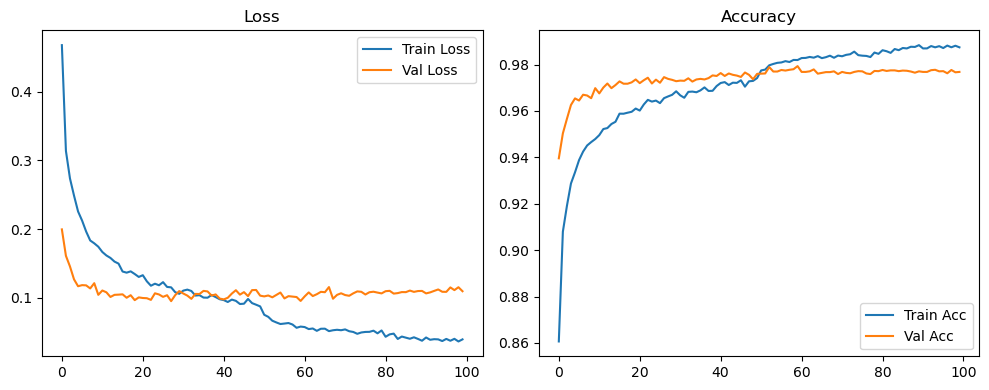

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2539, Acc: 0.9235 | Val Loss: 0.1356, Acc: 0.9597


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1326, Acc: 0.9594 | Val Loss: 0.1266, Acc: 0.9611


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1011, Acc: 0.9681 | Val Loss: 0.1150, Acc: 0.9641


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9744 | Val Loss: 0.1065, Acc: 0.9679


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9778 | Val Loss: 0.1091, Acc: 0.9691


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9798 | Val Loss: 0.1156, Acc: 0.9675


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9832 | Val Loss: 0.1073, Acc: 0.9705


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.1208, Acc: 0.9667


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9851 | Val Loss: 0.1173, Acc: 0.9692


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9872 | Val Loss: 0.1041, Acc: 0.9746


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.1112, Acc: 0.9711


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.1062, Acc: 0.9735


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 0.1172, Acc: 0.9724


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.1206, Acc: 0.9725


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.1182, Acc: 0.9724


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.1239, Acc: 0.9728


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.1203, Acc: 0.9728


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.1225, Acc: 0.9729


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.1175, Acc: 0.9746


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1383, Acc: 0.9718


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1363, Acc: 0.9712


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.1159, Acc: 0.9754


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9947 | Val Loss: 0.1288, Acc: 0.9736


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1365, Acc: 0.9713


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1358, Acc: 0.9722


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1272, Acc: 0.9738


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1300, Acc: 0.9743


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1408, Acc: 0.9734


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1470, Acc: 0.9722


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1358, Acc: 0.9738


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1423, Acc: 0.9728


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1286, Acc: 0.9749


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1370, Acc: 0.9734


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1343, Acc: 0.9733


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1417, Acc: 0.9748


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1411, Acc: 0.9733


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.1560, Acc: 0.9737


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1465, Acc: 0.9743


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1422, Acc: 0.9749


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1364, Acc: 0.9741


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1491, Acc: 0.9737


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1372, Acc: 0.9752


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1547, Acc: 0.9736


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1543, Acc: 0.9728


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1581, Acc: 0.9728


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1549, Acc: 0.9737


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1499, Acc: 0.9752


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1447, Acc: 0.9758


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1443, Acc: 0.9748


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1593, Acc: 0.9733


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1447, Acc: 0.9755


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1402, Acc: 0.9758


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1468, Acc: 0.9755


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1496, Acc: 0.9766


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1489, Acc: 0.9762


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1462, Acc: 0.9748


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1762, Acc: 0.9737


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1595, Acc: 0.9742


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1497, Acc: 0.9762


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1562, Acc: 0.9748


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1646, Acc: 0.9753


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1644, Acc: 0.9749


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1538, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1612, Acc: 0.9762


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1664, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9983 | Val Loss: 0.1575, Acc: 0.9767


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1636, Acc: 0.9756


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1563, Acc: 0.9765


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1563, Acc: 0.9758


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1886, Acc: 0.9738


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9980 | Val Loss: 0.1584, Acc: 0.9753


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1616, Acc: 0.9764


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1446, Acc: 0.9782


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1668, Acc: 0.9750


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1614, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1620, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1585, Acc: 0.9763


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1898, Acc: 0.9743


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1698, Acc: 0.9768


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1635, Acc: 0.9776


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1651, Acc: 0.9749


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1659, Acc: 0.9758


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1613, Acc: 0.9755


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1784, Acc: 0.9734


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1762, Acc: 0.9757


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1638, Acc: 0.9763


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1530, Acc: 0.9767


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1653, Acc: 0.9756


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1727, Acc: 0.9760


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1621, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1913, Acc: 0.9746


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1517, Acc: 0.9768


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1677, Acc: 0.9778


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1749, Acc: 0.9760


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1832, Acc: 0.9755


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1819, Acc: 0.9756


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1944, Acc: 0.9748


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1827, Acc: 0.9762


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1845, Acc: 0.9769


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1801, Acc: 0.9755


Final Test Loss: 0.1684 Accuracy: 0.9778


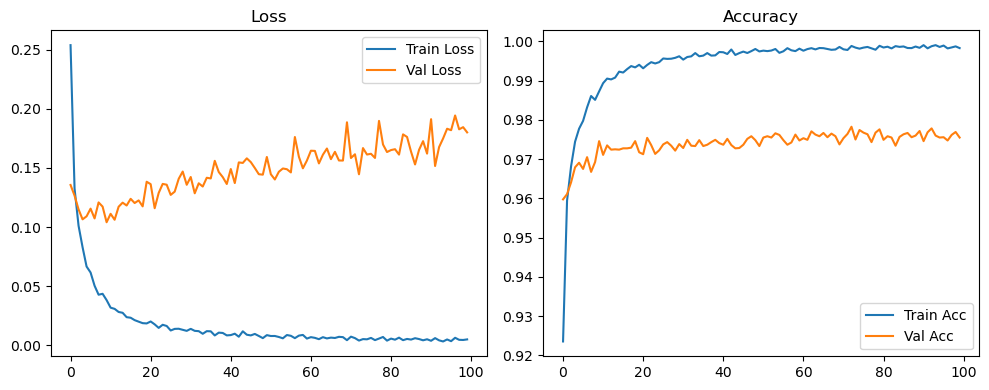

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3070, Acc: 0.9086 | Val Loss: 0.1504, Acc: 0.9557


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1765, Acc: 0.9468 | Val Loss: 0.1257, Acc: 0.9609


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1447, Acc: 0.9560 | Val Loss: 0.1227, Acc: 0.9610


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1250, Acc: 0.9617 | Val Loss: 0.1084, Acc: 0.9663


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1068, Acc: 0.9661 | Val Loss: 0.1046, Acc: 0.9693


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0978, Acc: 0.9686 | Val Loss: 0.1065, Acc: 0.9698


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0868, Acc: 0.9712 | Val Loss: 0.0937, Acc: 0.9724


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0793, Acc: 0.9746 | Val Loss: 0.1036, Acc: 0.9684


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0706, Acc: 0.9774 | Val Loss: 0.1047, Acc: 0.9703


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0703, Acc: 0.9775 | Val Loss: 0.0962, Acc: 0.9716


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0622, Acc: 0.9802 | Val Loss: 0.1047, Acc: 0.9712


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9800 | Val Loss: 0.0976, Acc: 0.9731


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9818 | Val Loss: 0.0984, Acc: 0.9735


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9823 | Val Loss: 0.0982, Acc: 0.9733


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9842 | Val Loss: 0.1019, Acc: 0.9741


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9846 | Val Loss: 0.0960, Acc: 0.9749


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9845 | Val Loss: 0.0977, Acc: 0.9758


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9864 | Val Loss: 0.1015, Acc: 0.9737


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9859 | Val Loss: 0.0961, Acc: 0.9754


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.1093, Acc: 0.9744


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.1048, Acc: 0.9752


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.1008, Acc: 0.9737


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0923, Acc: 0.9769


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.1086, Acc: 0.9741


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0991, Acc: 0.9758


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1105, Acc: 0.9751


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9884 | Val Loss: 0.1018, Acc: 0.9767


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.1068, Acc: 0.9752


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9892 | Val Loss: 0.1149, Acc: 0.9742


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1080, Acc: 0.9768


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9909 | Val Loss: 0.1203, Acc: 0.9735


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.1082, Acc: 0.9761


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9900 | Val Loss: 0.1140, Acc: 0.9741


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.1094, Acc: 0.9762


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.1104, Acc: 0.9757


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.1077, Acc: 0.9768


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 0.1102, Acc: 0.9762


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.1066, Acc: 0.9768


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.1107, Acc: 0.9752


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.1020, Acc: 0.9772


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.0959, Acc: 0.9770


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.1149, Acc: 0.9755


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.1128, Acc: 0.9752


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.1131, Acc: 0.9754


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1126, Acc: 0.9769


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9927 | Val Loss: 0.1116, Acc: 0.9745


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1196, Acc: 0.9757


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1251, Acc: 0.9746


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.1188, Acc: 0.9755


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9940 | Val Loss: 0.1135, Acc: 0.9766


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.1282, Acc: 0.9763


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.1207, Acc: 0.9768


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1146, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.1186, Acc: 0.9780


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.1201, Acc: 0.9752


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.1100, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1225, Acc: 0.9760


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1230, Acc: 0.9758


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.1148, Acc: 0.9772


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.1241, Acc: 0.9757


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1183, Acc: 0.9775


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1236, Acc: 0.9779


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1274, Acc: 0.9772


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.1212, Acc: 0.9773


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1252, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9944 | Val Loss: 0.1200, Acc: 0.9770


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1216, Acc: 0.9773


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1208, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1249, Acc: 0.9767


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1322, Acc: 0.9765


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.1271, Acc: 0.9762


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9955 | Val Loss: 0.1299, Acc: 0.9766


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.1321, Acc: 0.9780


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1449, Acc: 0.9759


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9955 | Val Loss: 0.1208, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1204, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1218, Acc: 0.9781


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1327, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1321, Acc: 0.9777


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1342, Acc: 0.9761


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.1367, Acc: 0.9764


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1285, Acc: 0.9768


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1362, Acc: 0.9760


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1379, Acc: 0.9763


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1310, Acc: 0.9768


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1262, Acc: 0.9774


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1374, Acc: 0.9744


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1312, Acc: 0.9782


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1394, Acc: 0.9775


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1352, Acc: 0.9768


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1287, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.1289, Acc: 0.9781


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1408, Acc: 0.9775


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9953 | Val Loss: 0.1381, Acc: 0.9778


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9968 | Val Loss: 0.1367, Acc: 0.9768


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1387, Acc: 0.9772


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.1389, Acc: 0.9762


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1341, Acc: 0.9779


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1338, Acc: 0.9770


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1334, Acc: 0.9773


Final Test Loss: 0.1330 Accuracy: 0.9775


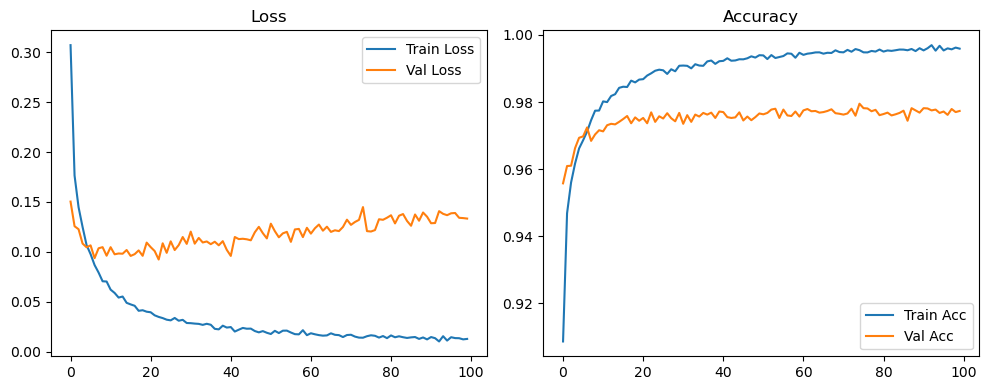

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4726, Acc: 0.8598 | Val Loss: 0.1926, Acc: 0.9419


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2938, Acc: 0.9131 | Val Loss: 0.1603, Acc: 0.9522


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2559, Acc: 0.9256 | Val Loss: 0.1413, Acc: 0.9575


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2340, Acc: 0.9293 | Val Loss: 0.1312, Acc: 0.9604


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2180, Acc: 0.9354 | Val Loss: 0.1210, Acc: 0.9636


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2014, Acc: 0.9406 | Val Loss: 0.1234, Acc: 0.9646


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1860, Acc: 0.9448 | Val Loss: 0.1139, Acc: 0.9665


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1782, Acc: 0.9466 | Val Loss: 0.1107, Acc: 0.9673


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1702, Acc: 0.9480 | Val Loss: 0.1115, Acc: 0.9687


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1653, Acc: 0.9501 | Val Loss: 0.1088, Acc: 0.9685


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1604, Acc: 0.9522 | Val Loss: 0.1056, Acc: 0.9690


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1484, Acc: 0.9559 | Val Loss: 0.0996, Acc: 0.9701


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1502, Acc: 0.9545 | Val Loss: 0.1018, Acc: 0.9704


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1397, Acc: 0.9572 | Val Loss: 0.1020, Acc: 0.9709


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1393, Acc: 0.9591 | Val Loss: 0.1019, Acc: 0.9711


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1353, Acc: 0.9586 | Val Loss: 0.1007, Acc: 0.9715


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1297, Acc: 0.9604 | Val Loss: 0.0990, Acc: 0.9727


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1299, Acc: 0.9592 | Val Loss: 0.1006, Acc: 0.9708


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1281, Acc: 0.9614 | Val Loss: 0.0965, Acc: 0.9728


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1196, Acc: 0.9625 | Val Loss: 0.0976, Acc: 0.9717


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1145, Acc: 0.9644 | Val Loss: 0.0994, Acc: 0.9724


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1144, Acc: 0.9649 | Val Loss: 0.0992, Acc: 0.9722


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1131, Acc: 0.9657 | Val Loss: 0.0971, Acc: 0.9730


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.1136, Acc: 0.9651 | Val Loss: 0.1023, Acc: 0.9714


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.1079, Acc: 0.9668 | Val Loss: 0.0967, Acc: 0.9717


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.1066, Acc: 0.9670 | Val Loss: 0.0980, Acc: 0.9723


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.1036, Acc: 0.9668 | Val Loss: 0.0990, Acc: 0.9735


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.1034, Acc: 0.9676 | Val Loss: 0.0938, Acc: 0.9741


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0981, Acc: 0.9692 | Val Loss: 0.0919, Acc: 0.9747


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0987, Acc: 0.9695 | Val Loss: 0.0923, Acc: 0.9733


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0997, Acc: 0.9707 | Val Loss: 0.0949, Acc: 0.9730


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0934, Acc: 0.9705 | Val Loss: 0.0981, Acc: 0.9722


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0973, Acc: 0.9696 | Val Loss: 0.0991, Acc: 0.9724


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0932, Acc: 0.9708 | Val Loss: 0.0937, Acc: 0.9740


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9706 | Val Loss: 0.1009, Acc: 0.9742


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0911, Acc: 0.9717 | Val Loss: 0.0987, Acc: 0.9744


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0911, Acc: 0.9719 | Val Loss: 0.0978, Acc: 0.9740


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0859, Acc: 0.9731 | Val Loss: 0.0977, Acc: 0.9747


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0882, Acc: 0.9724 | Val Loss: 0.0964, Acc: 0.9750


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0879, Acc: 0.9730 | Val Loss: 0.0946, Acc: 0.9750


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0851, Acc: 0.9739 | Val Loss: 0.0936, Acc: 0.9742


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0801, Acc: 0.9746 | Val Loss: 0.0933, Acc: 0.9750


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9737 | Val Loss: 0.0963, Acc: 0.9748


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0897, Acc: 0.9721 | Val Loss: 0.0950, Acc: 0.9750


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0783, Acc: 0.9753 | Val Loss: 0.1028, Acc: 0.9737


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0841, Acc: 0.9740 | Val Loss: 0.0957, Acc: 0.9754


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0814, Acc: 0.9746 | Val Loss: 0.0969, Acc: 0.9750


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0761, Acc: 0.9762 | Val Loss: 0.1002, Acc: 0.9747


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0745, Acc: 0.9765 | Val Loss: 0.1071, Acc: 0.9734


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9766 | Val Loss: 0.1010, Acc: 0.9751


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0761, Acc: 0.9758 | Val Loss: 0.0990, Acc: 0.9738


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9767 | Val Loss: 0.1015, Acc: 0.9755


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0755, Acc: 0.9762 | Val Loss: 0.0954, Acc: 0.9752


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0733, Acc: 0.9761 | Val Loss: 0.0981, Acc: 0.9738


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9767 | Val Loss: 0.0985, Acc: 0.9752


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0784, Acc: 0.9751 | Val Loss: 0.0949, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9770 | Val Loss: 0.1038, Acc: 0.9748


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0724, Acc: 0.9761 | Val Loss: 0.1041, Acc: 0.9752


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9765 | Val Loss: 0.1017, Acc: 0.9745


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9780 | Val Loss: 0.0935, Acc: 0.9761


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9771 | Val Loss: 0.1041, Acc: 0.9735


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9777 | Val Loss: 0.1087, Acc: 0.9734


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9775 | Val Loss: 0.1000, Acc: 0.9763


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9775 | Val Loss: 0.1033, Acc: 0.9752


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9788 | Val Loss: 0.1029, Acc: 0.9745


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0684, Acc: 0.9790 | Val Loss: 0.0990, Acc: 0.9762


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9782 | Val Loss: 0.1090, Acc: 0.9740


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0672, Acc: 0.9788 | Val Loss: 0.0984, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9794 | Val Loss: 0.0990, Acc: 0.9759


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0666, Acc: 0.9793 | Val Loss: 0.1013, Acc: 0.9751


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9798 | Val Loss: 0.1025, Acc: 0.9757


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9790 | Val Loss: 0.1003, Acc: 0.9751


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9796 | Val Loss: 0.1071, Acc: 0.9753


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9793 | Val Loss: 0.1067, Acc: 0.9752


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9807 | Val Loss: 0.1059, Acc: 0.9749


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0660, Acc: 0.9795 | Val Loss: 0.1025, Acc: 0.9752


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9794 | Val Loss: 0.1038, Acc: 0.9746


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.1082, Acc: 0.9747


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0656, Acc: 0.9801 | Val Loss: 0.1024, Acc: 0.9760


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9809 | Val Loss: 0.1061, Acc: 0.9730


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0619, Acc: 0.9807 | Val Loss: 0.1040, Acc: 0.9745


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0638, Acc: 0.9814 | Val Loss: 0.1021, Acc: 0.9751


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.1033, Acc: 0.9741


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9805 | Val Loss: 0.1052, Acc: 0.9751


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0624, Acc: 0.9802 | Val Loss: 0.1100, Acc: 0.9750


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9804 | Val Loss: 0.1035, Acc: 0.9747


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0589, Acc: 0.9813 | Val Loss: 0.1108, Acc: 0.9752


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9810 | Val Loss: 0.1105, Acc: 0.9755


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9806 | Val Loss: 0.1116, Acc: 0.9756


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9812 | Val Loss: 0.1071, Acc: 0.9752


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9813 | Val Loss: 0.1054, Acc: 0.9743


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9811 | Val Loss: 0.1060, Acc: 0.9747


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9810 | Val Loss: 0.1101, Acc: 0.9741


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9796 | Val Loss: 0.1035, Acc: 0.9758


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9830 | Val Loss: 0.1014, Acc: 0.9759


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0580, Acc: 0.9822 | Val Loss: 0.1084, Acc: 0.9748


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9815 | Val Loss: 0.1091, Acc: 0.9747


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9815 | Val Loss: 0.1068, Acc: 0.9755


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9818 | Val Loss: 0.1091, Acc: 0.9742


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9815 | Val Loss: 0.1035, Acc: 0.9758


Final Test Loss: 0.0961 Accuracy: 0.9781


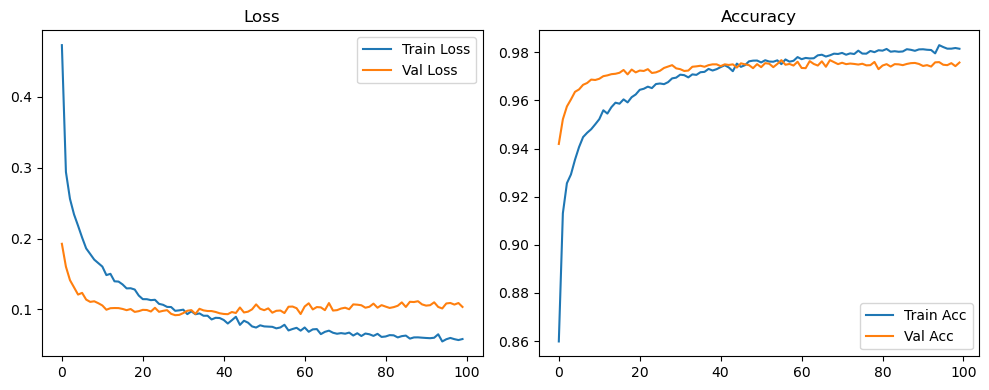

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2592, Acc: 0.9244 | Val Loss: 0.1345, Acc: 0.9586


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1262, Acc: 0.9610 | Val Loss: 0.1157, Acc: 0.9643


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0983, Acc: 0.9685 | Val Loss: 0.1192, Acc: 0.9620


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0766, Acc: 0.9757 | Val Loss: 0.1042, Acc: 0.9677


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0626, Acc: 0.9795 | Val Loss: 0.1018, Acc: 0.9695


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9805 | Val Loss: 0.1076, Acc: 0.9685


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9840 | Val Loss: 0.1045, Acc: 0.9709


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9861 | Val Loss: 0.1162, Acc: 0.9667


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9875 | Val Loss: 0.1090, Acc: 0.9703


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9874 | Val Loss: 0.0996, Acc: 0.9718


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.1074, Acc: 0.9717


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9906 | Val Loss: 0.1051, Acc: 0.9725


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.1131, Acc: 0.9733


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9919 | Val Loss: 0.1245, Acc: 0.9705


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.1215, Acc: 0.9702


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.1132, Acc: 0.9728


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.1115, Acc: 0.9738


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9927 | Val Loss: 0.1149, Acc: 0.9723


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9932 | Val Loss: 0.1054, Acc: 0.9762


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9932 | Val Loss: 0.1141, Acc: 0.9721


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1090, Acc: 0.9757


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1084, Acc: 0.9733


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9951 | Val Loss: 0.1110, Acc: 0.9746


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.1121, Acc: 0.9738


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.1115, Acc: 0.9736


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1080, Acc: 0.9738


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1239, Acc: 0.9738


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1079, Acc: 0.9747


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1245, Acc: 0.9730


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1284, Acc: 0.9728


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1252, Acc: 0.9739


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1223, Acc: 0.9742


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1135, Acc: 0.9759


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1159, Acc: 0.9752


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1295, Acc: 0.9737


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1198, Acc: 0.9758


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1252, Acc: 0.9748


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1242, Acc: 0.9751


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1321, Acc: 0.9742


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.1142, Acc: 0.9760


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1236, Acc: 0.9754


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1338, Acc: 0.9736


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1200, Acc: 0.9742


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1262, Acc: 0.9754


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1243, Acc: 0.9759


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1301, Acc: 0.9752


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1315, Acc: 0.9748


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1291, Acc: 0.9753


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1286, Acc: 0.9753


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1289, Acc: 0.9767


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1393, Acc: 0.9748


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1358, Acc: 0.9743


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1416, Acc: 0.9740


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1439, Acc: 0.9752


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1367, Acc: 0.9746


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1238, Acc: 0.9762


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1189, Acc: 0.9773


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1293, Acc: 0.9755


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1359, Acc: 0.9756


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1360, Acc: 0.9779


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1379, Acc: 0.9768


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1317, Acc: 0.9762


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1384, Acc: 0.9754


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1336, Acc: 0.9768


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1366, Acc: 0.9769


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1267, Acc: 0.9782


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1514, Acc: 0.9754


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1362, Acc: 0.9758


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1401, Acc: 0.9770


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1342, Acc: 0.9770


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1415, Acc: 0.9745


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1307, Acc: 0.9783


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1234, Acc: 0.9778


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1500, Acc: 0.9737


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1358, Acc: 0.9768


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1565, Acc: 0.9745


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1366, Acc: 0.9768


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1472, Acc: 0.9760


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1493, Acc: 0.9759


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1458, Acc: 0.9769


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1459, Acc: 0.9767


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1489, Acc: 0.9761


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1592, Acc: 0.9738


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1439, Acc: 0.9767


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1569, Acc: 0.9759


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1573, Acc: 0.9758


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1497, Acc: 0.9757


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1569, Acc: 0.9756


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1566, Acc: 0.9748


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1485, Acc: 0.9762


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1417, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1474, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1525, Acc: 0.9766


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1377, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1483, Acc: 0.9775


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1474, Acc: 0.9773


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1586, Acc: 0.9746


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1466, Acc: 0.9770


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1430, Acc: 0.9763


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1497, Acc: 0.9774


Final Test Loss: 0.1447 Accuracy: 0.9772


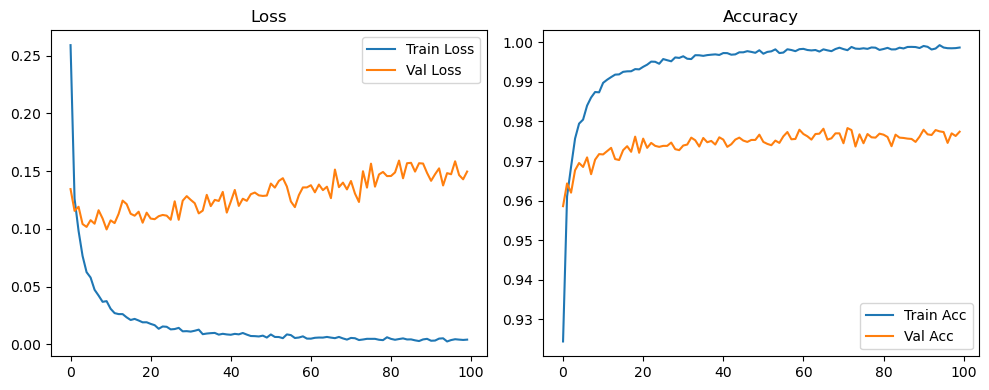

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3283, Acc: 0.9044 | Val Loss: 0.1548, Acc: 0.9521


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1747, Acc: 0.9469 | Val Loss: 0.1243, Acc: 0.9622


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1410, Acc: 0.9561 | Val Loss: 0.1172, Acc: 0.9650


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1225, Acc: 0.9620 | Val Loss: 0.1056, Acc: 0.9665


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1029, Acc: 0.9669 | Val Loss: 0.1073, Acc: 0.9670


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0963, Acc: 0.9689 | Val Loss: 0.1083, Acc: 0.9667


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0858, Acc: 0.9726 | Val Loss: 0.0960, Acc: 0.9722


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0770, Acc: 0.9750 | Val Loss: 0.1015, Acc: 0.9685


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0716, Acc: 0.9766 | Val Loss: 0.1125, Acc: 0.9677


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0706, Acc: 0.9766 | Val Loss: 0.0931, Acc: 0.9726


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0629, Acc: 0.9797 | Val Loss: 0.1009, Acc: 0.9716


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9808 | Val Loss: 0.0987, Acc: 0.9719


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9815 | Val Loss: 0.1051, Acc: 0.9710


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9827 | Val Loss: 0.0960, Acc: 0.9731


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9839 | Val Loss: 0.1054, Acc: 0.9715


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9846 | Val Loss: 0.1014, Acc: 0.9737


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.1031, Acc: 0.9726


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9838 | Val Loss: 0.1028, Acc: 0.9715


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9859 | Val Loss: 0.0998, Acc: 0.9732


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9866 | Val Loss: 0.1025, Acc: 0.9730


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.1030, Acc: 0.9722


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9873 | Val Loss: 0.1040, Acc: 0.9724


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9878 | Val Loss: 0.0976, Acc: 0.9731


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.1085, Acc: 0.9713


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.1003, Acc: 0.9736


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0953, Acc: 0.9756


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9890 | Val Loss: 0.1079, Acc: 0.9731


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.1027, Acc: 0.9742


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9902 | Val Loss: 0.1011, Acc: 0.9761


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9909 | Val Loss: 0.1046, Acc: 0.9752


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.1113, Acc: 0.9749


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1075, Acc: 0.9736


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.1064, Acc: 0.9747


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1096, Acc: 0.9751


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.1130, Acc: 0.9732


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.1085, Acc: 0.9750


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.1069, Acc: 0.9752


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1105, Acc: 0.9738


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.1116, Acc: 0.9734


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.1158, Acc: 0.9733


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.1128, Acc: 0.9746


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.1049, Acc: 0.9755


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.1090, Acc: 0.9761


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.1080, Acc: 0.9772


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1168, Acc: 0.9747


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1040, Acc: 0.9760


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.1093, Acc: 0.9761


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1086, Acc: 0.9768


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.1203, Acc: 0.9749


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1090, Acc: 0.9753


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1146, Acc: 0.9748


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9938 | Val Loss: 0.1143, Acc: 0.9757


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.1069, Acc: 0.9764


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1181, Acc: 0.9749


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1154, Acc: 0.9763


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1205, Acc: 0.9755


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1163, Acc: 0.9754


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1165, Acc: 0.9752


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1152, Acc: 0.9763


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1104, Acc: 0.9750


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1103, Acc: 0.9756


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1155, Acc: 0.9758


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1096, Acc: 0.9783


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1110, Acc: 0.9761


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.1178, Acc: 0.9760


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.1152, Acc: 0.9762


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9946 | Val Loss: 0.1205, Acc: 0.9761


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1179, Acc: 0.9758


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1128, Acc: 0.9763


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1203, Acc: 0.9752


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1168, Acc: 0.9762


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.1277, Acc: 0.9752


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1183, Acc: 0.9764


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1175, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1158, Acc: 0.9766


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1149, Acc: 0.9778


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1276, Acc: 0.9762


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1220, Acc: 0.9757


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9953 | Val Loss: 0.1142, Acc: 0.9766


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1129, Acc: 0.9763


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1243, Acc: 0.9762


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1249, Acc: 0.9766


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1243, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1252, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1226, Acc: 0.9771


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1218, Acc: 0.9766


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1132, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1235, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.1270, Acc: 0.9776


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1222, Acc: 0.9763


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1223, Acc: 0.9757


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1128, Acc: 0.9760


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1134, Acc: 0.9773


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1232, Acc: 0.9759


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1212, Acc: 0.9760


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1276, Acc: 0.9755


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1343, Acc: 0.9751


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1336, Acc: 0.9748


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1322, Acc: 0.9754


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1318, Acc: 0.9761


Final Test Loss: 0.1245 Accuracy: 0.9758


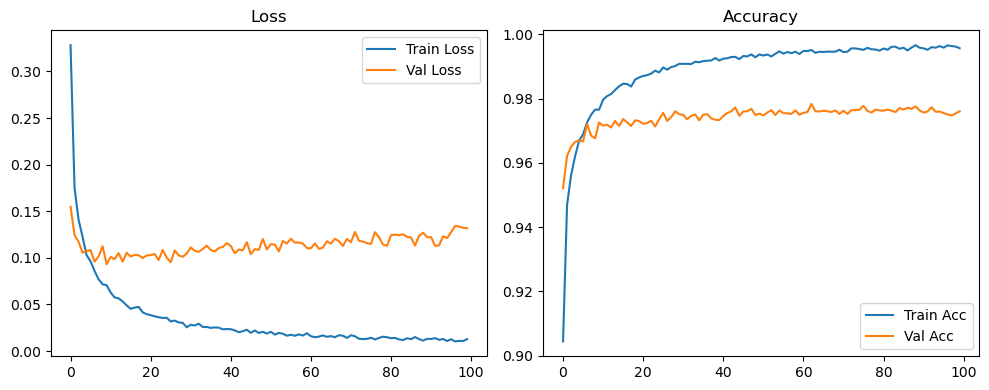

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5271, Acc: 0.8472 | Val Loss: 0.2079, Acc: 0.9369


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2986, Acc: 0.9118 | Val Loss: 0.1646, Acc: 0.9497


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2581, Acc: 0.9251 | Val Loss: 0.1468, Acc: 0.9567


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2337, Acc: 0.9309 | Val Loss: 0.1362, Acc: 0.9597


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2153, Acc: 0.9356 | Val Loss: 0.1247, Acc: 0.9622


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2005, Acc: 0.9411 | Val Loss: 0.1236, Acc: 0.9632


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1909, Acc: 0.9426 | Val Loss: 0.1174, Acc: 0.9657


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1774, Acc: 0.9476 | Val Loss: 0.1155, Acc: 0.9653


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1732, Acc: 0.9471 | Val Loss: 0.1120, Acc: 0.9670


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1664, Acc: 0.9487 | Val Loss: 0.1112, Acc: 0.9654


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1629, Acc: 0.9511 | Val Loss: 0.1128, Acc: 0.9665


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1539, Acc: 0.9538 | Val Loss: 0.1035, Acc: 0.9691


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1483, Acc: 0.9543 | Val Loss: 0.1064, Acc: 0.9702


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1415, Acc: 0.9562 | Val Loss: 0.1048, Acc: 0.9709


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1429, Acc: 0.9573 | Val Loss: 0.1071, Acc: 0.9692


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1348, Acc: 0.9582 | Val Loss: 0.1016, Acc: 0.9710


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1298, Acc: 0.9605 | Val Loss: 0.0985, Acc: 0.9712


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1313, Acc: 0.9602 | Val Loss: 0.1021, Acc: 0.9705


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1231, Acc: 0.9617 | Val Loss: 0.0993, Acc: 0.9716


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1210, Acc: 0.9626 | Val Loss: 0.0972, Acc: 0.9698


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1214, Acc: 0.9620 | Val Loss: 0.1008, Acc: 0.9717


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1161, Acc: 0.9637 | Val Loss: 0.1020, Acc: 0.9698


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1135, Acc: 0.9643 | Val Loss: 0.0990, Acc: 0.9727


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1123, Acc: 0.9647 | Val Loss: 0.1044, Acc: 0.9700


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.1115, Acc: 0.9650 | Val Loss: 0.0972, Acc: 0.9724


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.1095, Acc: 0.9660 | Val Loss: 0.0989, Acc: 0.9727


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1071, Acc: 0.9654 | Val Loss: 0.0965, Acc: 0.9734


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.1057, Acc: 0.9670 | Val Loss: 0.0936, Acc: 0.9730


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.1018, Acc: 0.9677 | Val Loss: 0.0951, Acc: 0.9722


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0994, Acc: 0.9689 | Val Loss: 0.0979, Acc: 0.9731


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0968, Acc: 0.9696 | Val Loss: 0.1004, Acc: 0.9735


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0978, Acc: 0.9701 | Val Loss: 0.0917, Acc: 0.9748


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0927, Acc: 0.9703 | Val Loss: 0.0962, Acc: 0.9736


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0940, Acc: 0.9704 | Val Loss: 0.0981, Acc: 0.9722


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0917, Acc: 0.9706 | Val Loss: 0.1001, Acc: 0.9738


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0966, Acc: 0.9702 | Val Loss: 0.0948, Acc: 0.9748


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0887, Acc: 0.9713 | Val Loss: 0.0939, Acc: 0.9740


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0904, Acc: 0.9718 | Val Loss: 0.0946, Acc: 0.9737


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0874, Acc: 0.9716 | Val Loss: 0.0968, Acc: 0.9729


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0847, Acc: 0.9734 | Val Loss: 0.0986, Acc: 0.9747


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0894, Acc: 0.9724 | Val Loss: 0.0978, Acc: 0.9739


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0819, Acc: 0.9732 | Val Loss: 0.0966, Acc: 0.9753


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0877, Acc: 0.9725 | Val Loss: 0.0974, Acc: 0.9738


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0858, Acc: 0.9720 | Val Loss: 0.0971, Acc: 0.9737


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9730 | Val Loss: 0.0982, Acc: 0.9744


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0870, Acc: 0.9719 | Val Loss: 0.0979, Acc: 0.9743


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0806, Acc: 0.9744 | Val Loss: 0.0948, Acc: 0.9744


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0790, Acc: 0.9746 | Val Loss: 0.0970, Acc: 0.9749


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0833, Acc: 0.9732 | Val Loss: 0.0941, Acc: 0.9756


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0799, Acc: 0.9745 | Val Loss: 0.0942, Acc: 0.9763


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0757, Acc: 0.9760 | Val Loss: 0.0948, Acc: 0.9746


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0757, Acc: 0.9759 | Val Loss: 0.0973, Acc: 0.9735


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9758 | Val Loss: 0.0968, Acc: 0.9748


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0752, Acc: 0.9757 | Val Loss: 0.0951, Acc: 0.9753


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0776, Acc: 0.9758 | Val Loss: 0.0947, Acc: 0.9759


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9768 | Val Loss: 0.0972, Acc: 0.9747


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9779 | Val Loss: 0.1024, Acc: 0.9750


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0728, Acc: 0.9770 | Val Loss: 0.0985, Acc: 0.9754


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9756 | Val Loss: 0.0985, Acc: 0.9736


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9764 | Val Loss: 0.0984, Acc: 0.9752


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0685, Acc: 0.9774 | Val Loss: 0.1026, Acc: 0.9749


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9774 | Val Loss: 0.1009, Acc: 0.9750


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9771 | Val Loss: 0.0928, Acc: 0.9758


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0692, Acc: 0.9771 | Val Loss: 0.1005, Acc: 0.9750


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9778 | Val Loss: 0.1004, Acc: 0.9764


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0697, Acc: 0.9771 | Val Loss: 0.0981, Acc: 0.9757


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0685, Acc: 0.9781 | Val Loss: 0.1050, Acc: 0.9736


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9786 | Val Loss: 0.1005, Acc: 0.9748


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0652, Acc: 0.9786 | Val Loss: 0.0977, Acc: 0.9762


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9789 | Val Loss: 0.1001, Acc: 0.9751


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9804 | Val Loss: 0.1027, Acc: 0.9752


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9796 | Val Loss: 0.1003, Acc: 0.9748


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9790 | Val Loss: 0.1008, Acc: 0.9751


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9800 | Val Loss: 0.1007, Acc: 0.9748


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0621, Acc: 0.9796 | Val Loss: 0.0988, Acc: 0.9751


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9796 | Val Loss: 0.0962, Acc: 0.9758


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0603, Acc: 0.9807 | Val Loss: 0.0993, Acc: 0.9760


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0663, Acc: 0.9790 | Val Loss: 0.1047, Acc: 0.9739


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9799 | Val Loss: 0.1012, Acc: 0.9755


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0601, Acc: 0.9799 | Val Loss: 0.1008, Acc: 0.9762


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0601, Acc: 0.9802 | Val Loss: 0.0995, Acc: 0.9763


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9802 | Val Loss: 0.1008, Acc: 0.9755


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0607, Acc: 0.9808 | Val Loss: 0.0994, Acc: 0.9758


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0574, Acc: 0.9809 | Val Loss: 0.1079, Acc: 0.9748


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9808 | Val Loss: 0.1074, Acc: 0.9758


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0612, Acc: 0.9806 | Val Loss: 0.1025, Acc: 0.9748


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9810 | Val Loss: 0.1009, Acc: 0.9746


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0599, Acc: 0.9808 | Val Loss: 0.0989, Acc: 0.9752


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9812 | Val Loss: 0.1035, Acc: 0.9743


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9812 | Val Loss: 0.1006, Acc: 0.9743


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.0980, Acc: 0.9756


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9815 | Val Loss: 0.0989, Acc: 0.9748


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9816 | Val Loss: 0.1041, Acc: 0.9766


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9820 | Val Loss: 0.1001, Acc: 0.9755


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0579, Acc: 0.9813 | Val Loss: 0.0985, Acc: 0.9757


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9828 | Val Loss: 0.1004, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9819 | Val Loss: 0.1061, Acc: 0.9748


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9811 | Val Loss: 0.0995, Acc: 0.9753


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9813 | Val Loss: 0.1025, Acc: 0.9752


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9815 | Val Loss: 0.1006, Acc: 0.9762


Final Test Loss: 0.0905 Accuracy: 0.9779


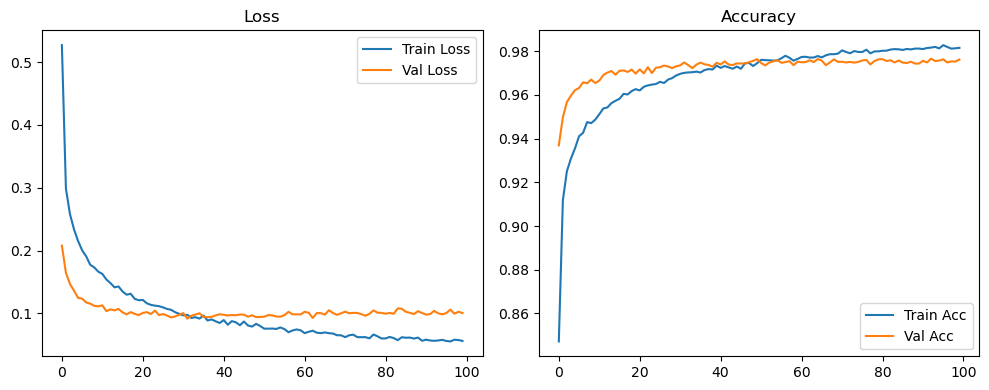

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2560, Acc: 0.9235 | Val Loss: 0.1537, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9592 | Val Loss: 0.1306, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9695 | Val Loss: 0.1315, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9761 | Val Loss: 0.1081, Acc: 0.9700


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9791 | Val Loss: 0.1192, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 0.1204, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1186, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.1277, Acc: 0.9683


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1490, Acc: 0.9661


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.1282, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.1273, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.1359, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1380, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1403, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1269, Acc: 0.9740


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1316, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1571, Acc: 0.9690


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.1421, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.1466, Acc: 0.9726


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1378, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1373, Acc: 0.9742


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1411, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1673, Acc: 0.9704


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1747, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1511, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9959 | Val Loss: 0.1512, Acc: 0.9725


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1600, Acc: 0.9728


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1687, Acc: 0.9724


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1729, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.1526, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.1710, Acc: 0.9722


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1660, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1716, Acc: 0.9717


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1534, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1556, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1588, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1609, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1748, Acc: 0.9723


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1636, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1623, Acc: 0.9739


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1890, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1844, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9968 | Val Loss: 0.1596, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1671, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1604, Acc: 0.9765


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1590, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1717, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1670, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1827, Acc: 0.9744


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1730, Acc: 0.9753


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1793, Acc: 0.9749


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1857, Acc: 0.9748


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.2034, Acc: 0.9733


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1733, Acc: 0.9755


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1865, Acc: 0.9742


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1722, Acc: 0.9757


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.1709, Acc: 0.9759


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1642, Acc: 0.9755


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.2151, Acc: 0.9738


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9981 | Val Loss: 0.1815, Acc: 0.9766


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.2011, Acc: 0.9735


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1721, Acc: 0.9762


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1816, Acc: 0.9741


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1890, Acc: 0.9743


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1835, Acc: 0.9750


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9987 | Val Loss: 0.1815, Acc: 0.9745


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1945, Acc: 0.9758


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.1978, Acc: 0.9740


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.2038, Acc: 0.9727


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1695, Acc: 0.9777


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.1944, Acc: 0.9748


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1718, Acc: 0.9758


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1943, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.2086, Acc: 0.9752


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.1941, Acc: 0.9758


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1827, Acc: 0.9772


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1812, Acc: 0.9786


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1931, Acc: 0.9752


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.2033, Acc: 0.9755


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9983 | Val Loss: 0.1899, Acc: 0.9767


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1816, Acc: 0.9760


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1852, Acc: 0.9764


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1981, Acc: 0.9770


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9985 | Val Loss: 0.2067, Acc: 0.9747


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2204, Acc: 0.9743


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.2081, Acc: 0.9771


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.2038, Acc: 0.9762


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.2119, Acc: 0.9769


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1954, Acc: 0.9767


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1859, Acc: 0.9780


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.2269, Acc: 0.9760


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.2219, Acc: 0.9752


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1910, Acc: 0.9778


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1994, Acc: 0.9768


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1861, Acc: 0.9781


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.2013, Acc: 0.9774


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1957, Acc: 0.9781


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.2000, Acc: 0.9772


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.2044, Acc: 0.9775


Final Test Loss: 0.1882 Accuracy: 0.9787


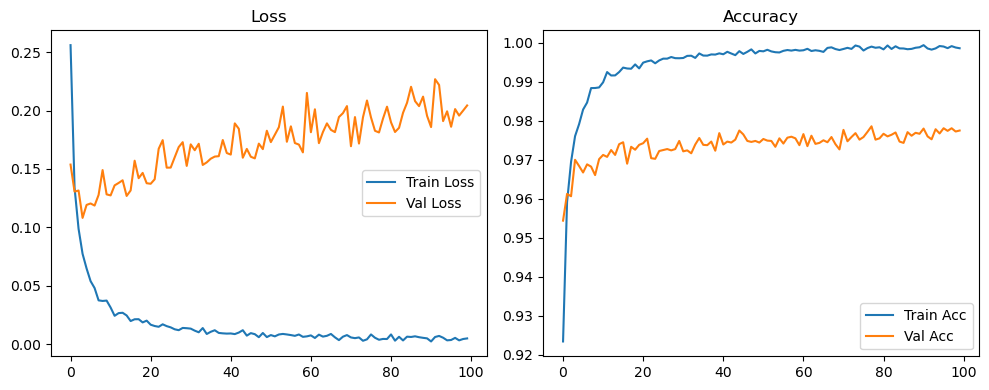

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3018, Acc: 0.9091 | Val Loss: 0.1585, Acc: 0.9504


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1728, Acc: 0.9480 | Val Loss: 0.1260, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9595 | Val Loss: 0.1354, Acc: 0.9601


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9646 | Val Loss: 0.1156, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9676 | Val Loss: 0.1083, Acc: 0.9706


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9728 | Val Loss: 0.1210, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9755 | Val Loss: 0.1059, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.1084, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9792 | Val Loss: 0.1195, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9800 | Val Loss: 0.1211, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1170, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1127, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9842 | Val Loss: 0.1217, Acc: 0.9710


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1122, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.1216, Acc: 0.9723


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.1238, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.1174, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9855 | Val Loss: 0.1288, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.1231, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.1167, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.1110, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 0.1287, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9894 | Val Loss: 0.1293, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1254, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.1286, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9890 | Val Loss: 0.1311, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9910 | Val Loss: 0.1479, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.1481, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9910 | Val Loss: 0.1377, Acc: 0.9757


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9911 | Val Loss: 0.1463, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.1422, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9915 | Val Loss: 0.1436, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9925 | Val Loss: 0.1445, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9917 | Val Loss: 0.1396, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1578, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9910 | Val Loss: 0.1485, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.1535, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9920 | Val Loss: 0.1452, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9931 | Val Loss: 0.1542, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9924 | Val Loss: 0.1614, Acc: 0.9753


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9925 | Val Loss: 0.1646, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9932 | Val Loss: 0.1400, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9936 | Val Loss: 0.1670, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9941 | Val Loss: 0.1680, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9926 | Val Loss: 0.1763, Acc: 0.9738


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9927 | Val Loss: 0.1684, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9929 | Val Loss: 0.1604, Acc: 0.9746


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9944 | Val Loss: 0.1741, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9943 | Val Loss: 0.1871, Acc: 0.9749


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9936 | Val Loss: 0.1673, Acc: 0.9750


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9944 | Val Loss: 0.1844, Acc: 0.9755


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9944 | Val Loss: 0.1524, Acc: 0.9773


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9930 | Val Loss: 0.1644, Acc: 0.9757


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9937 | Val Loss: 0.1756, Acc: 0.9755


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9937 | Val Loss: 0.1655, Acc: 0.9767


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9946 | Val Loss: 0.1672, Acc: 0.9776


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9947 | Val Loss: 0.1797, Acc: 0.9788


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9944 | Val Loss: 0.1836, Acc: 0.9765


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9944 | Val Loss: 0.1678, Acc: 0.9762


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9947 | Val Loss: 0.1882, Acc: 0.9764


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9940 | Val Loss: 0.1826, Acc: 0.9733


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9942 | Val Loss: 0.1878, Acc: 0.9745


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9945 | Val Loss: 0.1796, Acc: 0.9765


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9948 | Val Loss: 0.1787, Acc: 0.9766


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9949 | Val Loss: 0.1843, Acc: 0.9753


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9948 | Val Loss: 0.1920, Acc: 0.9767


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9946 | Val Loss: 0.1952, Acc: 0.9765


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9951 | Val Loss: 0.2186, Acc: 0.9749


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9948 | Val Loss: 0.1670, Acc: 0.9762


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9946 | Val Loss: 0.1866, Acc: 0.9770


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9950 | Val Loss: 0.1763, Acc: 0.9789


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9955 | Val Loss: 0.1784, Acc: 0.9763


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9955 | Val Loss: 0.1837, Acc: 0.9779


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9952 | Val Loss: 0.2229, Acc: 0.9761


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9958 | Val Loss: 0.1873, Acc: 0.9776


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9955 | Val Loss: 0.1804, Acc: 0.9778


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9954 | Val Loss: 0.1763, Acc: 0.9764


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9955 | Val Loss: 0.1967, Acc: 0.9777


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9956 | Val Loss: 0.2125, Acc: 0.9774


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9953 | Val Loss: 0.2074, Acc: 0.9762


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9952 | Val Loss: 0.2005, Acc: 0.9794


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9959 | Val Loss: 0.2190, Acc: 0.9765


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9954 | Val Loss: 0.1873, Acc: 0.9784


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9955 | Val Loss: 0.2009, Acc: 0.9778


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9961 | Val Loss: 0.2037, Acc: 0.9768


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9960 | Val Loss: 0.2091, Acc: 0.9750


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9952 | Val Loss: 0.1829, Acc: 0.9771


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9947 | Val Loss: 0.1854, Acc: 0.9791


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9959 | Val Loss: 0.2009, Acc: 0.9782


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9960 | Val Loss: 0.1995, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9965 | Val Loss: 0.2048, Acc: 0.9765


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9967 | Val Loss: 0.2178, Acc: 0.9773


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9958 | Val Loss: 0.1914, Acc: 0.9768


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9957 | Val Loss: 0.2123, Acc: 0.9768


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9956 | Val Loss: 0.2091, Acc: 0.9771


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9956 | Val Loss: 0.2030, Acc: 0.9777


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9960 | Val Loss: 0.2177, Acc: 0.9771


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9965 | Val Loss: 0.1945, Acc: 0.9775


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9957 | Val Loss: 0.2134, Acc: 0.9790


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9959 | Val Loss: 0.2338, Acc: 0.9772


Final Test Loss: 0.1866 Accuracy: 0.9807


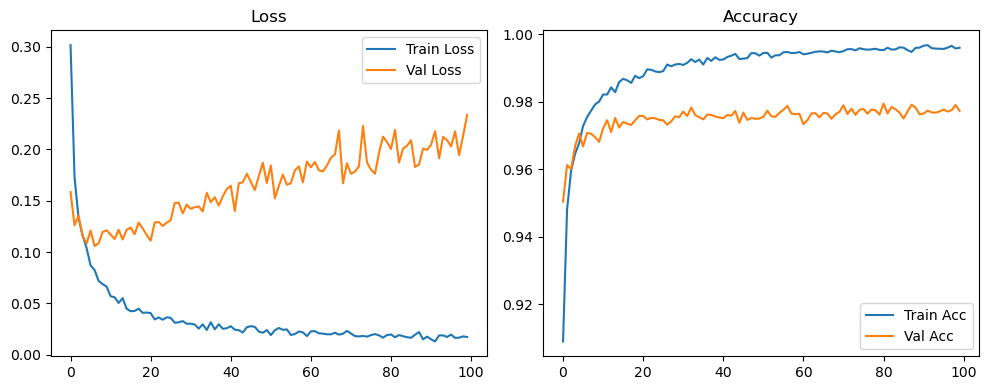

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4560, Acc: 0.8659 | Val Loss: 0.1883, Acc: 0.9438


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2998, Acc: 0.9118 | Val Loss: 0.1618, Acc: 0.9497


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2557, Acc: 0.9261 | Val Loss: 0.1508, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2247, Acc: 0.9344 | Val Loss: 0.1378, Acc: 0.9608


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2083, Acc: 0.9392 | Val Loss: 0.1373, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2011, Acc: 0.9425 | Val Loss: 0.1273, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1813, Acc: 0.9462 | Val Loss: 0.1227, Acc: 0.9645


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1739, Acc: 0.9487 | Val Loss: 0.1170, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9504 | Val Loss: 0.1095, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9531 | Val Loss: 0.1163, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9553 | Val Loss: 0.1088, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9580 | Val Loss: 0.1072, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9577 | Val Loss: 0.1071, Acc: 0.9721


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9594 | Val Loss: 0.1113, Acc: 0.9714


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9600 | Val Loss: 0.1212, Acc: 0.9697


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9622 | Val Loss: 0.1103, Acc: 0.9720


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9634 | Val Loss: 0.1060, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9634 | Val Loss: 0.1047, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1196, Acc: 0.9655 | Val Loss: 0.1071, Acc: 0.9737


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1228, Acc: 0.9638 | Val Loss: 0.1115, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9653 | Val Loss: 0.1060, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9658 | Val Loss: 0.1099, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1104, Acc: 0.9677 | Val Loss: 0.1034, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9673 | Val Loss: 0.1187, Acc: 0.9703


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9674 | Val Loss: 0.1014, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9682 | Val Loss: 0.1110, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9696 | Val Loss: 0.1111, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9702 | Val Loss: 0.1056, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9700 | Val Loss: 0.1108, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9713 | Val Loss: 0.1107, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9708 | Val Loss: 0.1144, Acc: 0.9718


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9711 | Val Loss: 0.1243, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9720 | Val Loss: 0.1095, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9723 | Val Loss: 0.1059, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9725 | Val Loss: 0.1108, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9730 | Val Loss: 0.1123, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9722 | Val Loss: 0.1246, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0955, Acc: 0.9729 | Val Loss: 0.1163, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9727 | Val Loss: 0.1198, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9742 | Val Loss: 0.1121, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9750 | Val Loss: 0.1171, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9750 | Val Loss: 0.1179, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1166, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9747 | Val Loss: 0.1327, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9749 | Val Loss: 0.1160, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1140, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9761 | Val Loss: 0.1188, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9777 | Val Loss: 0.1320, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9754 | Val Loss: 0.1191, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9765 | Val Loss: 0.1304, Acc: 0.9749


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9779 | Val Loss: 0.1169, Acc: 0.9760


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9764 | Val Loss: 0.1251, Acc: 0.9739


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9780 | Val Loss: 0.1220, Acc: 0.9755


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0837, Acc: 0.9763 | Val Loss: 0.1407, Acc: 0.9734


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9775 | Val Loss: 0.1137, Acc: 0.9768


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9783 | Val Loss: 0.1192, Acc: 0.9755


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0720, Acc: 0.9791 | Val Loss: 0.1293, Acc: 0.9736


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9787 | Val Loss: 0.1249, Acc: 0.9742


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9782 | Val Loss: 0.1420, Acc: 0.9729


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9792 | Val Loss: 0.1281, Acc: 0.9742


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9797 | Val Loss: 0.1368, Acc: 0.9754


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9789 | Val Loss: 0.1357, Acc: 0.9756


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9789 | Val Loss: 0.1204, Acc: 0.9768


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9787 | Val Loss: 0.1260, Acc: 0.9764


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9798 | Val Loss: 0.1358, Acc: 0.9747


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9774 | Val Loss: 0.1219, Acc: 0.9762


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9799 | Val Loss: 0.1360, Acc: 0.9742


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9798 | Val Loss: 0.1308, Acc: 0.9744


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9817 | Val Loss: 0.1248, Acc: 0.9762


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0743, Acc: 0.9791 | Val Loss: 0.1265, Acc: 0.9765


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9792 | Val Loss: 0.1452, Acc: 0.9743


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9809 | Val Loss: 0.1259, Acc: 0.9757


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0689, Acc: 0.9803 | Val Loss: 0.1274, Acc: 0.9766


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9795 | Val Loss: 0.1275, Acc: 0.9758


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9809 | Val Loss: 0.1254, Acc: 0.9753


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9809 | Val Loss: 0.1251, Acc: 0.9754


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9816 | Val Loss: 0.1312, Acc: 0.9753


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9815 | Val Loss: 0.1483, Acc: 0.9744


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0638, Acc: 0.9823 | Val Loss: 0.1362, Acc: 0.9762


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9815 | Val Loss: 0.1274, Acc: 0.9760


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9807 | Val Loss: 0.1428, Acc: 0.9762


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9817 | Val Loss: 0.1392, Acc: 0.9742


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9811 | Val Loss: 0.1190, Acc: 0.9758


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9830 | Val Loss: 0.1449, Acc: 0.9764


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9817 | Val Loss: 0.1352, Acc: 0.9755


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9817 | Val Loss: 0.1537, Acc: 0.9768


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0686, Acc: 0.9811 | Val Loss: 0.1403, Acc: 0.9750


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9808 | Val Loss: 0.1389, Acc: 0.9759


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9817 | Val Loss: 0.1414, Acc: 0.9756


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9829 | Val Loss: 0.1416, Acc: 0.9749


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0680, Acc: 0.9812 | Val Loss: 0.1345, Acc: 0.9746


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9819 | Val Loss: 0.1326, Acc: 0.9762


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9830 | Val Loss: 0.1368, Acc: 0.9748


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9840 | Val Loss: 0.1501, Acc: 0.9742


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9825 | Val Loss: 0.1393, Acc: 0.9747


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9825 | Val Loss: 0.1504, Acc: 0.9750


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9821 | Val Loss: 0.1479, Acc: 0.9739


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9823 | Val Loss: 0.1336, Acc: 0.9752


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9835 | Val Loss: 0.1386, Acc: 0.9765


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9832 | Val Loss: 0.1504, Acc: 0.9741


Final Test Loss: 0.1227 Accuracy: 0.9787


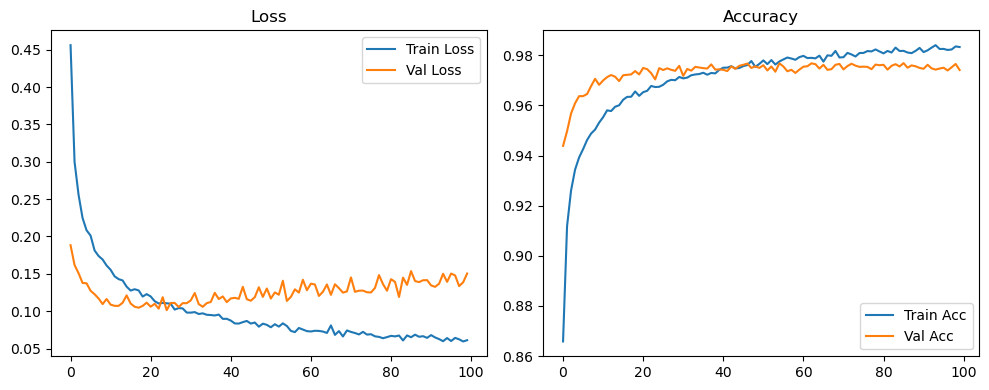

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2560, Acc: 0.9235 | Val Loss: 0.1537, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9592 | Val Loss: 0.1306, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9695 | Val Loss: 0.1315, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9761 | Val Loss: 0.1081, Acc: 0.9700


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9791 | Val Loss: 0.1192, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 0.1204, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1186, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.1277, Acc: 0.9683


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1490, Acc: 0.9661


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.1282, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.1273, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.1359, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1380, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1403, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1269, Acc: 0.9740


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1316, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1571, Acc: 0.9690


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.1421, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.1466, Acc: 0.9726


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1378, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1373, Acc: 0.9742


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1411, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1673, Acc: 0.9704


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1747, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1511, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9959 | Val Loss: 0.1512, Acc: 0.9725


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1600, Acc: 0.9728


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1687, Acc: 0.9724


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1729, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.1526, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.1710, Acc: 0.9722


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1660, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1716, Acc: 0.9717


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1534, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1556, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1588, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1609, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1748, Acc: 0.9723


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1636, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1623, Acc: 0.9739


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1890, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1844, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9968 | Val Loss: 0.1596, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1671, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1604, Acc: 0.9765


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1590, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1717, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1670, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1827, Acc: 0.9744


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1619, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1660, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1736, Acc: 0.9781


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1711, Acc: 0.9777


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1972, Acc: 0.9764


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1776, Acc: 0.9790


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1977, Acc: 0.9779


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2018, Acc: 0.9764


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2046, Acc: 0.9759


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2290, Acc: 0.9754


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1913, Acc: 0.9775


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1984, Acc: 0.9769


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2051, Acc: 0.9753


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9990 | Val Loss: 0.1933, Acc: 0.9779


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1984, Acc: 0.9777


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.2159, Acc: 0.9765


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1907, Acc: 0.9766


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1820, Acc: 0.9774


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1917, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2063, Acc: 0.9770


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2184, Acc: 0.9758


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.2139, Acc: 0.9760


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.2052, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1829, Acc: 0.9785


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2033, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2040, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1998, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2152, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2033, Acc: 0.9781


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2015, Acc: 0.9785


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.2004, Acc: 0.9796


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2018, Acc: 0.9781


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.2051, Acc: 0.9795


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2112, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2049, Acc: 0.9786


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2052, Acc: 0.9789


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1979, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1999, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1945, Acc: 0.9794


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2007, Acc: 0.9797


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2071, Acc: 0.9786


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2032, Acc: 0.9792


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2004, Acc: 0.9794


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2130, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2204, Acc: 0.9786


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2274, Acc: 0.9797


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2205, Acc: 0.9803


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.2129, Acc: 0.9793


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2166, Acc: 0.9796


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2206, Acc: 0.9789


Final Test Loss: 0.2086 Accuracy: 0.9797


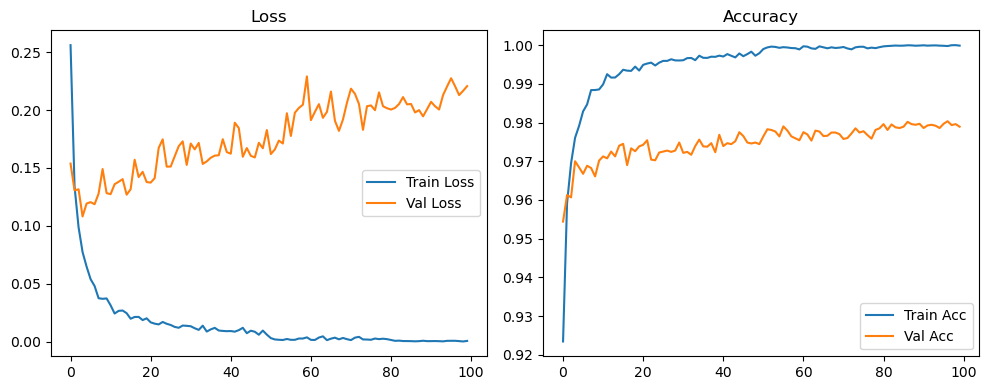

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3018, Acc: 0.9091 | Val Loss: 0.1585, Acc: 0.9504


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1728, Acc: 0.9480 | Val Loss: 0.1260, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9595 | Val Loss: 0.1354, Acc: 0.9601


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9646 | Val Loss: 0.1156, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9676 | Val Loss: 0.1083, Acc: 0.9706


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9728 | Val Loss: 0.1210, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9755 | Val Loss: 0.1059, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.1084, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9792 | Val Loss: 0.1195, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9800 | Val Loss: 0.1211, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1170, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1127, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9842 | Val Loss: 0.1217, Acc: 0.9710


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1122, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.1216, Acc: 0.9723


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.1238, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.1174, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9855 | Val Loss: 0.1288, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.1231, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.1167, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.1110, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 0.1287, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9894 | Val Loss: 0.1293, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1254, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.1286, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9890 | Val Loss: 0.1311, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9910 | Val Loss: 0.1479, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.1481, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9910 | Val Loss: 0.1377, Acc: 0.9757


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9911 | Val Loss: 0.1463, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.1422, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9915 | Val Loss: 0.1436, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9925 | Val Loss: 0.1445, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9917 | Val Loss: 0.1396, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1578, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9910 | Val Loss: 0.1485, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.1535, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9920 | Val Loss: 0.1452, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9931 | Val Loss: 0.1542, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9924 | Val Loss: 0.1614, Acc: 0.9753


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9925 | Val Loss: 0.1646, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9932 | Val Loss: 0.1400, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9936 | Val Loss: 0.1670, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9941 | Val Loss: 0.1680, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9926 | Val Loss: 0.1763, Acc: 0.9738


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9927 | Val Loss: 0.1684, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9929 | Val Loss: 0.1604, Acc: 0.9746


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9944 | Val Loss: 0.1741, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9943 | Val Loss: 0.1871, Acc: 0.9749


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9936 | Val Loss: 0.1673, Acc: 0.9750


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1505, Acc: 0.9781


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9968 | Val Loss: 0.1584, Acc: 0.9791


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9969 | Val Loss: 0.1567, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9967 | Val Loss: 0.1554, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1519, Acc: 0.9785


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1522, Acc: 0.9794


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1588, Acc: 0.9785


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9977 | Val Loss: 0.1694, Acc: 0.9779


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1570, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1822, Acc: 0.9788


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1808, Acc: 0.9777


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9970 | Val Loss: 0.2017, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1709, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1813, Acc: 0.9783


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9973 | Val Loss: 0.1872, Acc: 0.9779


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.1634, Acc: 0.9779


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9972 | Val Loss: 0.1652, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1804, Acc: 0.9785


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1842, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9973 | Val Loss: 0.1793, Acc: 0.9773


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9976 | Val Loss: 0.1926, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1837, Acc: 0.9772


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.1749, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.1861, Acc: 0.9780


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9974 | Val Loss: 0.1730, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1866, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1815, Acc: 0.9783


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9974 | Val Loss: 0.1908, Acc: 0.9773


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1843, Acc: 0.9776


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1753, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1797, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1801, Acc: 0.9787


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1809, Acc: 0.9796


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1817, Acc: 0.9793


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1889, Acc: 0.9792


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1955, Acc: 0.9795


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1817, Acc: 0.9798


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1946, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1884, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1841, Acc: 0.9804


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1813, Acc: 0.9799


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1927, Acc: 0.9785


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1947, Acc: 0.9796


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.2001, Acc: 0.9788


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1959, Acc: 0.9802


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1956, Acc: 0.9794


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1959, Acc: 0.9789


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1955, Acc: 0.9800


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.1911, Acc: 0.9788


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1872, Acc: 0.9808


Final Test Loss: 0.1849 Accuracy: 0.9808


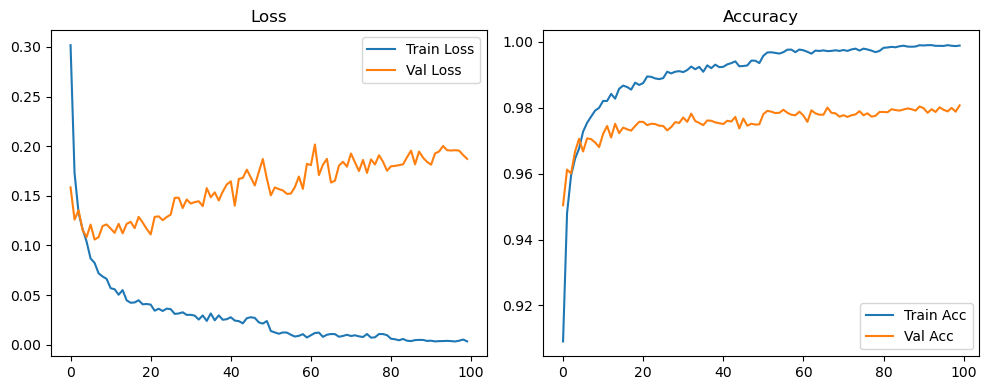

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4560, Acc: 0.8659 | Val Loss: 0.1883, Acc: 0.9438


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2998, Acc: 0.9118 | Val Loss: 0.1618, Acc: 0.9497


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2557, Acc: 0.9261 | Val Loss: 0.1508, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2247, Acc: 0.9344 | Val Loss: 0.1378, Acc: 0.9608


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2083, Acc: 0.9392 | Val Loss: 0.1373, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2011, Acc: 0.9425 | Val Loss: 0.1273, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1813, Acc: 0.9462 | Val Loss: 0.1227, Acc: 0.9645


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1739, Acc: 0.9487 | Val Loss: 0.1170, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9504 | Val Loss: 0.1095, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9531 | Val Loss: 0.1163, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9553 | Val Loss: 0.1088, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9580 | Val Loss: 0.1072, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9577 | Val Loss: 0.1071, Acc: 0.9721


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9594 | Val Loss: 0.1113, Acc: 0.9714


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9600 | Val Loss: 0.1212, Acc: 0.9697


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9622 | Val Loss: 0.1103, Acc: 0.9720


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9634 | Val Loss: 0.1060, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9634 | Val Loss: 0.1047, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1196, Acc: 0.9655 | Val Loss: 0.1071, Acc: 0.9737


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1228, Acc: 0.9638 | Val Loss: 0.1115, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9653 | Val Loss: 0.1060, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9658 | Val Loss: 0.1099, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1104, Acc: 0.9677 | Val Loss: 0.1034, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9673 | Val Loss: 0.1187, Acc: 0.9703


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9674 | Val Loss: 0.1014, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9682 | Val Loss: 0.1110, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9696 | Val Loss: 0.1111, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9702 | Val Loss: 0.1056, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9700 | Val Loss: 0.1108, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9713 | Val Loss: 0.1107, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9708 | Val Loss: 0.1144, Acc: 0.9718


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9711 | Val Loss: 0.1243, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9720 | Val Loss: 0.1095, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9723 | Val Loss: 0.1059, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9725 | Val Loss: 0.1108, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9730 | Val Loss: 0.1123, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9722 | Val Loss: 0.1246, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0955, Acc: 0.9729 | Val Loss: 0.1163, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9727 | Val Loss: 0.1198, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9742 | Val Loss: 0.1121, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9750 | Val Loss: 0.1171, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9750 | Val Loss: 0.1179, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1166, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9747 | Val Loss: 0.1327, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9749 | Val Loss: 0.1160, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1140, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9761 | Val Loss: 0.1188, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9777 | Val Loss: 0.1320, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9754 | Val Loss: 0.1191, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9765 | Val Loss: 0.1304, Acc: 0.9749


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9803 | Val Loss: 0.1171, Acc: 0.9766


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9815 | Val Loss: 0.1158, Acc: 0.9765


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9838 | Val Loss: 0.1180, Acc: 0.9769


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9832 | Val Loss: 0.1212, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9843 | Val Loss: 0.1089, Acc: 0.9782


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.1167, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9846 | Val Loss: 0.1240, Acc: 0.9774


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9851 | Val Loss: 0.1108, Acc: 0.9770


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9847 | Val Loss: 0.1227, Acc: 0.9764


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.1184, Acc: 0.9771


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9847 | Val Loss: 0.1205, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9852 | Val Loss: 0.1259, Acc: 0.9767


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9860 | Val Loss: 0.1183, Acc: 0.9771


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9850 | Val Loss: 0.1160, Acc: 0.9777


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9854 | Val Loss: 0.1161, Acc: 0.9771


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9850 | Val Loss: 0.1152, Acc: 0.9776


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.1216, Acc: 0.9764


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.1216, Acc: 0.9765


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9861 | Val Loss: 0.1229, Acc: 0.9771


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.1178, Acc: 0.9775


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9850 | Val Loss: 0.1303, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9860 | Val Loss: 0.1183, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9859 | Val Loss: 0.1227, Acc: 0.9770


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9868 | Val Loss: 0.1227, Acc: 0.9770


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9857 | Val Loss: 0.1265, Acc: 0.9757


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9862 | Val Loss: 0.1320, Acc: 0.9753


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9864 | Val Loss: 0.1280, Acc: 0.9767


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9864 | Val Loss: 0.1380, Acc: 0.9757


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9874 | Val Loss: 0.1295, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 0.1183, Acc: 0.9768


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.1200, Acc: 0.9773


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1231, Acc: 0.9757


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9886 | Val Loss: 0.1181, Acc: 0.9776


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.1283, Acc: 0.9787


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9897 | Val Loss: 0.1208, Acc: 0.9772


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.1231, Acc: 0.9777


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.1207, Acc: 0.9786


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9901 | Val Loss: 0.1204, Acc: 0.9782


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.1189, Acc: 0.9783


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9900 | Val Loss: 0.1247, Acc: 0.9770


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.1263, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.1235, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9908 | Val Loss: 0.1202, Acc: 0.9780


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.1195, Acc: 0.9774


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.1188, Acc: 0.9774


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.1255, Acc: 0.9775


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.1242, Acc: 0.9767


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9909 | Val Loss: 0.1210, Acc: 0.9768


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9912 | Val Loss: 0.1266, Acc: 0.9770


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.1219, Acc: 0.9771


Final Test Loss: 0.1143 Accuracy: 0.9804


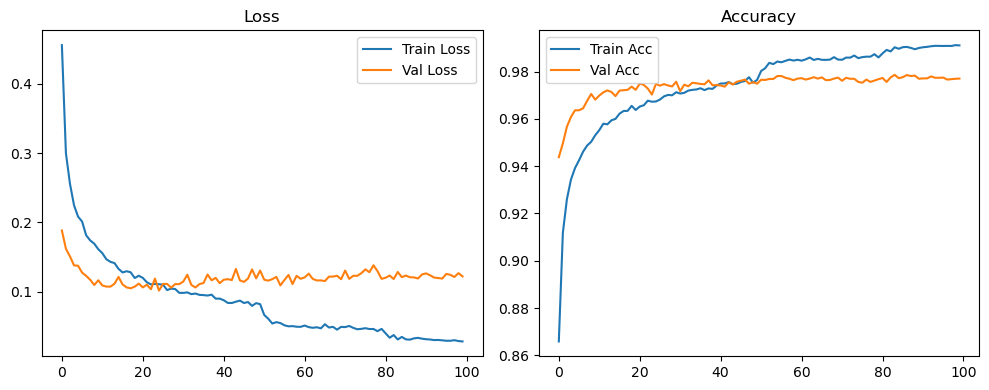

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2560, Acc: 0.9235 | Val Loss: 0.1537, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9592 | Val Loss: 0.1306, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9695 | Val Loss: 0.1315, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9761 | Val Loss: 0.1081, Acc: 0.9700


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9791 | Val Loss: 0.1192, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 0.1204, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1186, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.1277, Acc: 0.9683


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1490, Acc: 0.9661


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.1282, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.1273, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.1359, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1380, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1403, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1269, Acc: 0.9740


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1316, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1571, Acc: 0.9690


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.1421, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.1466, Acc: 0.9726


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1378, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1373, Acc: 0.9742


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1411, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1673, Acc: 0.9704


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1747, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1511, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9959 | Val Loss: 0.1512, Acc: 0.9725


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1600, Acc: 0.9728


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1687, Acc: 0.9724


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1729, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.1526, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.1710, Acc: 0.9722


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1660, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1716, Acc: 0.9717


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1534, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1556, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1588, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1609, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1748, Acc: 0.9723


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1636, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1623, Acc: 0.9739


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1890, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1844, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9968 | Val Loss: 0.1596, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1671, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1604, Acc: 0.9765


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1590, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1717, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1670, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1827, Acc: 0.9744


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1619, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1660, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1736, Acc: 0.9781


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1711, Acc: 0.9777


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1972, Acc: 0.9764


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1776, Acc: 0.9790


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1977, Acc: 0.9779


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2018, Acc: 0.9764


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.2046, Acc: 0.9759


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2290, Acc: 0.9754


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1913, Acc: 0.9775


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1984, Acc: 0.9769


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.2051, Acc: 0.9753


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9990 | Val Loss: 0.1933, Acc: 0.9779


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1984, Acc: 0.9777


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.2159, Acc: 0.9765


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1907, Acc: 0.9766


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1820, Acc: 0.9774


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1917, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2063, Acc: 0.9770


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.2184, Acc: 0.9758


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.2139, Acc: 0.9760


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.2052, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1829, Acc: 0.9785


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.2033, Acc: 0.9774


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.2040, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1998, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2152, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.2033, Acc: 0.9781


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2015, Acc: 0.9785


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1944, Acc: 0.9793


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1934, Acc: 0.9791


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1952, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1911, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1946, Acc: 0.9783


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1898, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1861, Acc: 0.9805


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1904, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1915, Acc: 0.9794


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1915, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1900, Acc: 0.9797


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1922, Acc: 0.9806


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1908, Acc: 0.9796


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1925, Acc: 0.9806


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2012, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1933, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2005, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2009, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1930, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2003, Acc: 0.9790


Final Test Loss: 0.1823 Accuracy: 0.9821


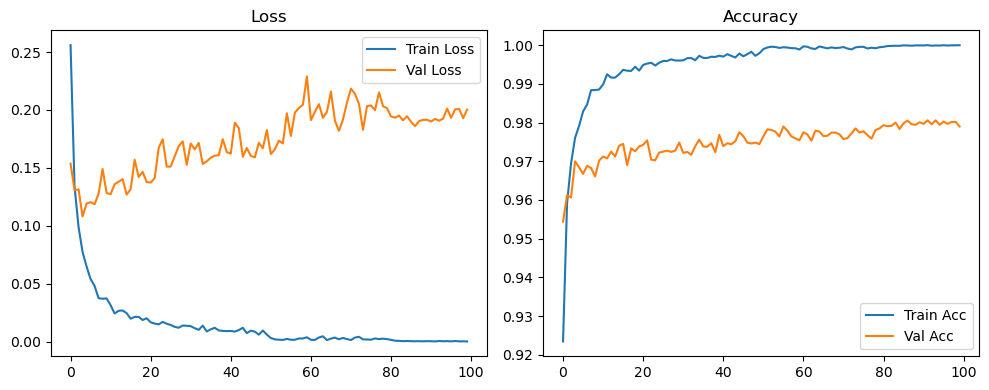

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3018, Acc: 0.9091 | Val Loss: 0.1585, Acc: 0.9504


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1728, Acc: 0.9480 | Val Loss: 0.1260, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9595 | Val Loss: 0.1354, Acc: 0.9601


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9646 | Val Loss: 0.1156, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9676 | Val Loss: 0.1083, Acc: 0.9706


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9728 | Val Loss: 0.1210, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9755 | Val Loss: 0.1059, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.1084, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9792 | Val Loss: 0.1195, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9800 | Val Loss: 0.1211, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1170, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1127, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9842 | Val Loss: 0.1217, Acc: 0.9710


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1122, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.1216, Acc: 0.9723


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.1238, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.1174, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9855 | Val Loss: 0.1288, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.1231, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.1167, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.1110, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 0.1287, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9894 | Val Loss: 0.1293, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1254, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.1286, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9890 | Val Loss: 0.1311, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9910 | Val Loss: 0.1479, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.1481, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9910 | Val Loss: 0.1377, Acc: 0.9757


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9911 | Val Loss: 0.1463, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.1422, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9915 | Val Loss: 0.1436, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9925 | Val Loss: 0.1445, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9917 | Val Loss: 0.1396, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1578, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9910 | Val Loss: 0.1485, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.1535, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9920 | Val Loss: 0.1452, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9931 | Val Loss: 0.1542, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9924 | Val Loss: 0.1614, Acc: 0.9753


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9925 | Val Loss: 0.1646, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9932 | Val Loss: 0.1400, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9936 | Val Loss: 0.1670, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9941 | Val Loss: 0.1680, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9926 | Val Loss: 0.1763, Acc: 0.9738


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9927 | Val Loss: 0.1684, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9929 | Val Loss: 0.1604, Acc: 0.9746


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9944 | Val Loss: 0.1741, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9943 | Val Loss: 0.1871, Acc: 0.9749


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9936 | Val Loss: 0.1673, Acc: 0.9750


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1505, Acc: 0.9781


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9968 | Val Loss: 0.1584, Acc: 0.9791


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9969 | Val Loss: 0.1567, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9967 | Val Loss: 0.1554, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1519, Acc: 0.9785


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1522, Acc: 0.9794


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1588, Acc: 0.9785


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9977 | Val Loss: 0.1694, Acc: 0.9779


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1570, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1822, Acc: 0.9788


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9975 | Val Loss: 0.1808, Acc: 0.9777


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9970 | Val Loss: 0.2017, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.1709, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1813, Acc: 0.9783


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9973 | Val Loss: 0.1872, Acc: 0.9779


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9975 | Val Loss: 0.1634, Acc: 0.9779


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9972 | Val Loss: 0.1652, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1804, Acc: 0.9785


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1842, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9973 | Val Loss: 0.1793, Acc: 0.9773


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9976 | Val Loss: 0.1926, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1837, Acc: 0.9772


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.1749, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.1861, Acc: 0.9780


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9974 | Val Loss: 0.1730, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1866, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1815, Acc: 0.9783


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9974 | Val Loss: 0.1908, Acc: 0.9773


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1843, Acc: 0.9776


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9973 | Val Loss: 0.1753, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1741, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1761, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1758, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1756, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1824, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1868, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1847, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1816, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1825, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1744, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1759, Acc: 0.9800


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1781, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1811, Acc: 0.9806


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1899, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1887, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1829, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1901, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1870, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1869, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1851, Acc: 0.9805


Final Test Loss: 0.1811 Accuracy: 0.9811


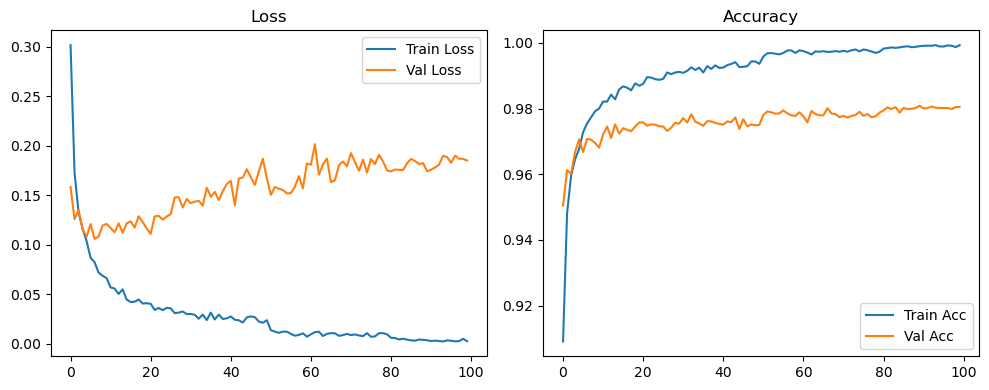

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4560, Acc: 0.8659 | Val Loss: 0.1883, Acc: 0.9438


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2998, Acc: 0.9118 | Val Loss: 0.1618, Acc: 0.9497


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2557, Acc: 0.9261 | Val Loss: 0.1508, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2247, Acc: 0.9344 | Val Loss: 0.1378, Acc: 0.9608


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2083, Acc: 0.9392 | Val Loss: 0.1373, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2011, Acc: 0.9425 | Val Loss: 0.1273, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1813, Acc: 0.9462 | Val Loss: 0.1227, Acc: 0.9645


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1739, Acc: 0.9487 | Val Loss: 0.1170, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9504 | Val Loss: 0.1095, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9531 | Val Loss: 0.1163, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9553 | Val Loss: 0.1088, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9580 | Val Loss: 0.1072, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9577 | Val Loss: 0.1071, Acc: 0.9721


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9594 | Val Loss: 0.1113, Acc: 0.9714


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9600 | Val Loss: 0.1212, Acc: 0.9697


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9622 | Val Loss: 0.1103, Acc: 0.9720


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9634 | Val Loss: 0.1060, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9634 | Val Loss: 0.1047, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1196, Acc: 0.9655 | Val Loss: 0.1071, Acc: 0.9737


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1228, Acc: 0.9638 | Val Loss: 0.1115, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9653 | Val Loss: 0.1060, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9658 | Val Loss: 0.1099, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1104, Acc: 0.9677 | Val Loss: 0.1034, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9673 | Val Loss: 0.1187, Acc: 0.9703


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9674 | Val Loss: 0.1014, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9682 | Val Loss: 0.1110, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9696 | Val Loss: 0.1111, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9702 | Val Loss: 0.1056, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9700 | Val Loss: 0.1108, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9713 | Val Loss: 0.1107, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9708 | Val Loss: 0.1144, Acc: 0.9718


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9711 | Val Loss: 0.1243, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9720 | Val Loss: 0.1095, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9723 | Val Loss: 0.1059, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9725 | Val Loss: 0.1108, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9730 | Val Loss: 0.1123, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9722 | Val Loss: 0.1246, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0955, Acc: 0.9729 | Val Loss: 0.1163, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9727 | Val Loss: 0.1198, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9742 | Val Loss: 0.1121, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9750 | Val Loss: 0.1171, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9750 | Val Loss: 0.1179, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1166, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9747 | Val Loss: 0.1327, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9749 | Val Loss: 0.1160, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1140, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9761 | Val Loss: 0.1188, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9777 | Val Loss: 0.1320, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9754 | Val Loss: 0.1191, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9765 | Val Loss: 0.1304, Acc: 0.9749


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9803 | Val Loss: 0.1171, Acc: 0.9766


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9815 | Val Loss: 0.1158, Acc: 0.9765


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9838 | Val Loss: 0.1180, Acc: 0.9769


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9832 | Val Loss: 0.1212, Acc: 0.9769


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9843 | Val Loss: 0.1089, Acc: 0.9782


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.1167, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9846 | Val Loss: 0.1240, Acc: 0.9774


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9851 | Val Loss: 0.1108, Acc: 0.9770


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9847 | Val Loss: 0.1227, Acc: 0.9764


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9850 | Val Loss: 0.1184, Acc: 0.9771


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9847 | Val Loss: 0.1205, Acc: 0.9772


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9852 | Val Loss: 0.1259, Acc: 0.9767


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9860 | Val Loss: 0.1183, Acc: 0.9771


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9850 | Val Loss: 0.1160, Acc: 0.9777


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9854 | Val Loss: 0.1161, Acc: 0.9771


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9850 | Val Loss: 0.1152, Acc: 0.9776


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.1216, Acc: 0.9764


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.1216, Acc: 0.9765


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9861 | Val Loss: 0.1229, Acc: 0.9771


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9851 | Val Loss: 0.1178, Acc: 0.9775


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9850 | Val Loss: 0.1303, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9860 | Val Loss: 0.1183, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9859 | Val Loss: 0.1227, Acc: 0.9770


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9868 | Val Loss: 0.1227, Acc: 0.9770


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9857 | Val Loss: 0.1265, Acc: 0.9757


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9862 | Val Loss: 0.1320, Acc: 0.9753


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9864 | Val Loss: 0.1280, Acc: 0.9767


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9864 | Val Loss: 0.1380, Acc: 0.9757


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9874 | Val Loss: 0.1295, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 0.1183, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9881 | Val Loss: 0.1188, Acc: 0.9767


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.1197, Acc: 0.9763


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9886 | Val Loss: 0.1150, Acc: 0.9778


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9908 | Val Loss: 0.1209, Acc: 0.9777


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9897 | Val Loss: 0.1208, Acc: 0.9777


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.1230, Acc: 0.9774


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9903 | Val Loss: 0.1198, Acc: 0.9781


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9900 | Val Loss: 0.1174, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9899 | Val Loss: 0.1203, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1197, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.1245, Acc: 0.9790


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9912 | Val Loss: 0.1167, Acc: 0.9775


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9914 | Val Loss: 0.1233, Acc: 0.9773


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.1218, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9914 | Val Loss: 0.1139, Acc: 0.9786


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.1173, Acc: 0.9777


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9911 | Val Loss: 0.1206, Acc: 0.9780


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.1215, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.1236, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.1194, Acc: 0.9778


Final Test Loss: 0.1138 Accuracy: 0.9806


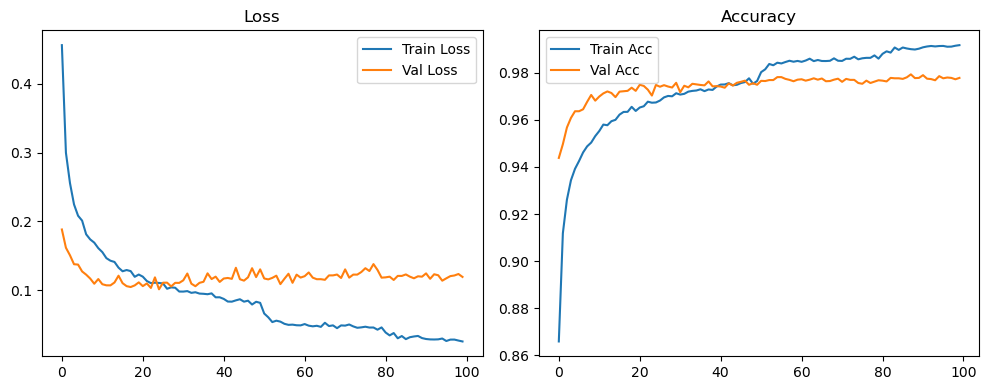

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2560, Acc: 0.9235 | Val Loss: 0.1537, Acc: 0.9544


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1339, Acc: 0.9592 | Val Loss: 0.1306, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9695 | Val Loss: 0.1315, Acc: 0.9607


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9761 | Val Loss: 0.1081, Acc: 0.9700


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9791 | Val Loss: 0.1192, Acc: 0.9684


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9829 | Val Loss: 0.1204, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.1186, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.1277, Acc: 0.9683


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.1490, Acc: 0.9661


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.1282, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.1273, Acc: 0.9712


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.1359, Acc: 0.9708


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.1380, Acc: 0.9725


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1403, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9925 | Val Loss: 0.1269, Acc: 0.9740


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.1316, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.1571, Acc: 0.9690


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.1421, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.1466, Acc: 0.9726


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1378, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1373, Acc: 0.9742


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1411, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1673, Acc: 0.9704


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1747, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9955 | Val Loss: 0.1511, Acc: 0.9722


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9959 | Val Loss: 0.1512, Acc: 0.9725


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1600, Acc: 0.9728


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.1687, Acc: 0.9724


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1729, Acc: 0.9728


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.1526, Acc: 0.9748


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9961 | Val Loss: 0.1710, Acc: 0.9722


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1660, Acc: 0.9724


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1716, Acc: 0.9717


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1534, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1556, Acc: 0.9756


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1588, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9738


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1609, Acc: 0.9747


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1748, Acc: 0.9723


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1636, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1623, Acc: 0.9739


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1890, Acc: 0.9747


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1844, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9968 | Val Loss: 0.1596, Acc: 0.9752


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1671, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1604, Acc: 0.9765


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1590, Acc: 0.9748


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1717, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1670, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1827, Acc: 0.9744


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1595, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1569, Acc: 0.9779


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1605, Acc: 0.9773


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1566, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1556, Acc: 0.9786


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1640, Acc: 0.9793


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1672, Acc: 0.9790


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1660, Acc: 0.9787


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1765, Acc: 0.9785


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1739, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1762, Acc: 0.9779


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1749, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1777, Acc: 0.9797


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1712, Acc: 0.9796


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1804, Acc: 0.9782


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1873, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1823, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1829, Acc: 0.9783


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1804, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1899, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1865, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1856, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1919, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1935, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1876, Acc: 0.9781


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1936, Acc: 0.9779


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1918, Acc: 0.9776


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2029, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2010, Acc: 0.9786


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1947, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1951, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2015, Acc: 0.9781


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1989, Acc: 0.9787


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1991, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1971, Acc: 0.9783


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1983, Acc: 0.9795


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1934, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1952, Acc: 0.9787


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1956, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2023, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2045, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2095, Acc: 0.9790


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2114, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2055, Acc: 0.9790


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2059, Acc: 0.9787


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2108, Acc: 0.9786


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2184, Acc: 0.9790


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2179, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2135, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2138, Acc: 0.9788


Final Test Loss: 0.1833 Accuracy: 0.9809


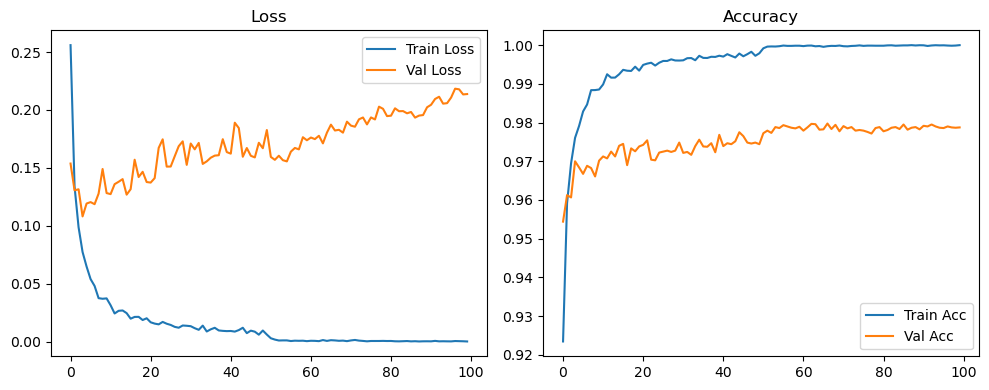

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3018, Acc: 0.9091 | Val Loss: 0.1585, Acc: 0.9504


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1728, Acc: 0.9480 | Val Loss: 0.1260, Acc: 0.9613


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1329, Acc: 0.9595 | Val Loss: 0.1354, Acc: 0.9601


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9646 | Val Loss: 0.1156, Acc: 0.9667


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1039, Acc: 0.9676 | Val Loss: 0.1083, Acc: 0.9706


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9728 | Val Loss: 0.1210, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9755 | Val Loss: 0.1059, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9773 | Val Loss: 0.1084, Acc: 0.9705


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9792 | Val Loss: 0.1195, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9800 | Val Loss: 0.1211, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9821 | Val Loss: 0.1170, Acc: 0.9721


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.1127, Acc: 0.9745


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9842 | Val Loss: 0.1217, Acc: 0.9710


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0550, Acc: 0.9828 | Val Loss: 0.1122, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.1216, Acc: 0.9723


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.1238, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.1174, Acc: 0.9735


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9855 | Val Loss: 0.1288, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.1231, Acc: 0.9745


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.1167, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.1110, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9895 | Val Loss: 0.1287, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9894 | Val Loss: 0.1293, Acc: 0.9752


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9889 | Val Loss: 0.1254, Acc: 0.9751


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9887 | Val Loss: 0.1286, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9890 | Val Loss: 0.1311, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9910 | Val Loss: 0.1479, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.1481, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9910 | Val Loss: 0.1377, Acc: 0.9757


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9911 | Val Loss: 0.1463, Acc: 0.9754


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9909 | Val Loss: 0.1422, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9915 | Val Loss: 0.1436, Acc: 0.9758


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9925 | Val Loss: 0.1445, Acc: 0.9782


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9917 | Val Loss: 0.1396, Acc: 0.9760


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1578, Acc: 0.9754


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9910 | Val Loss: 0.1485, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.1535, Acc: 0.9762


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9920 | Val Loss: 0.1452, Acc: 0.9761


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9931 | Val Loss: 0.1542, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9924 | Val Loss: 0.1614, Acc: 0.9753


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9925 | Val Loss: 0.1646, Acc: 0.9751


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9932 | Val Loss: 0.1400, Acc: 0.9761


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9936 | Val Loss: 0.1670, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9941 | Val Loss: 0.1680, Acc: 0.9772


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9926 | Val Loss: 0.1763, Acc: 0.9738


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9927 | Val Loss: 0.1684, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9929 | Val Loss: 0.1604, Acc: 0.9746


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9944 | Val Loss: 0.1741, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9943 | Val Loss: 0.1871, Acc: 0.9749


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9936 | Val Loss: 0.1673, Acc: 0.9750


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.1503, Acc: 0.9779


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1540, Acc: 0.9786


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1522, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1555, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9975 | Val Loss: 0.1466, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1478, Acc: 0.9788


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1441, Acc: 0.9791


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1442, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1408, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1485, Acc: 0.9805


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1560, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1519, Acc: 0.9799


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1537, Acc: 0.9799


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1595, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1468, Acc: 0.9806


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1492, Acc: 0.9785


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1480, Acc: 0.9806


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1571, Acc: 0.9797


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1517, Acc: 0.9804


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1598, Acc: 0.9797


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1648, Acc: 0.9810


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1601, Acc: 0.9799


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1562, Acc: 0.9809


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1674, Acc: 0.9805


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1668, Acc: 0.9809


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1749, Acc: 0.9801


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1754, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1746, Acc: 0.9800


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1762, Acc: 0.9797


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1651, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1629, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1650, Acc: 0.9796


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1669, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1694, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1687, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1727, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1657, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1679, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1716, Acc: 0.9801


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1689, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1701, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1700, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1744, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1787, Acc: 0.9801


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1762, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1674, Acc: 0.9820


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1776, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1674, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1782, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1738, Acc: 0.9807


Final Test Loss: 0.1674 Accuracy: 0.9815


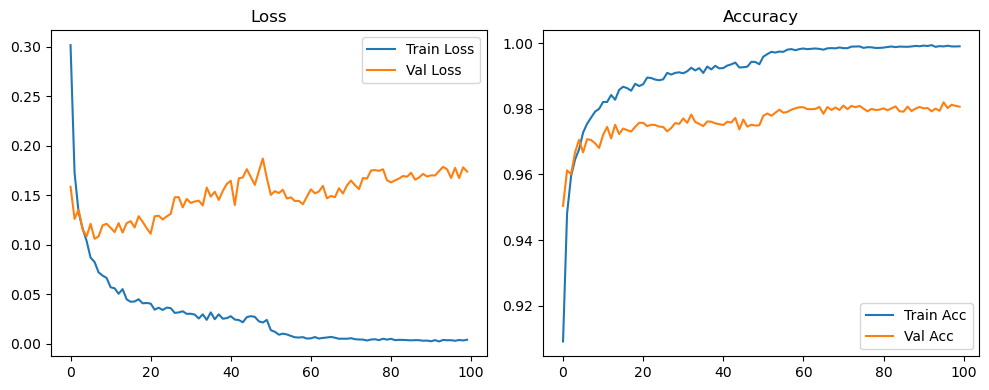

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4560, Acc: 0.8659 | Val Loss: 0.1883, Acc: 0.9438


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2998, Acc: 0.9118 | Val Loss: 0.1618, Acc: 0.9497


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2557, Acc: 0.9261 | Val Loss: 0.1508, Acc: 0.9567


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2247, Acc: 0.9344 | Val Loss: 0.1378, Acc: 0.9608


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2083, Acc: 0.9392 | Val Loss: 0.1373, Acc: 0.9637


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2011, Acc: 0.9425 | Val Loss: 0.1273, Acc: 0.9637


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1813, Acc: 0.9462 | Val Loss: 0.1227, Acc: 0.9645


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1739, Acc: 0.9487 | Val Loss: 0.1170, Acc: 0.9677


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1692, Acc: 0.9504 | Val Loss: 0.1095, Acc: 0.9706


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1611, Acc: 0.9531 | Val Loss: 0.1163, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9553 | Val Loss: 0.1088, Acc: 0.9699


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1466, Acc: 0.9580 | Val Loss: 0.1072, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9577 | Val Loss: 0.1071, Acc: 0.9721


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9594 | Val Loss: 0.1113, Acc: 0.9714


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1328, Acc: 0.9600 | Val Loss: 0.1212, Acc: 0.9697


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9622 | Val Loss: 0.1103, Acc: 0.9720


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9634 | Val Loss: 0.1060, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9634 | Val Loss: 0.1047, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1196, Acc: 0.9655 | Val Loss: 0.1071, Acc: 0.9737


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1228, Acc: 0.9638 | Val Loss: 0.1115, Acc: 0.9723


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1197, Acc: 0.9653 | Val Loss: 0.1060, Acc: 0.9749


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9658 | Val Loss: 0.1099, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1104, Acc: 0.9677 | Val Loss: 0.1034, Acc: 0.9728


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9673 | Val Loss: 0.1187, Acc: 0.9703


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1106, Acc: 0.9674 | Val Loss: 0.1014, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1099, Acc: 0.9682 | Val Loss: 0.1110, Acc: 0.9741


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1022, Acc: 0.9696 | Val Loss: 0.1111, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9702 | Val Loss: 0.1056, Acc: 0.9742


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9700 | Val Loss: 0.1108, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9713 | Val Loss: 0.1107, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9708 | Val Loss: 0.1144, Acc: 0.9718


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0988, Acc: 0.9711 | Val Loss: 0.1243, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9720 | Val Loss: 0.1095, Acc: 0.9738


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9723 | Val Loss: 0.1059, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0952, Acc: 0.9725 | Val Loss: 0.1108, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0949, Acc: 0.9730 | Val Loss: 0.1123, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9722 | Val Loss: 0.1246, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0955, Acc: 0.9729 | Val Loss: 0.1163, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9727 | Val Loss: 0.1198, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9742 | Val Loss: 0.1121, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9750 | Val Loss: 0.1171, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9750 | Val Loss: 0.1179, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1166, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9747 | Val Loss: 0.1327, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0869, Acc: 0.9749 | Val Loss: 0.1160, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9756 | Val Loss: 0.1140, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9761 | Val Loss: 0.1188, Acc: 0.9767


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9777 | Val Loss: 0.1320, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9754 | Val Loss: 0.1191, Acc: 0.9756


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9765 | Val Loss: 0.1304, Acc: 0.9749


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9810 | Val Loss: 0.1222, Acc: 0.9761


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0574, Acc: 0.9829 | Val Loss: 0.1169, Acc: 0.9769


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9842 | Val Loss: 0.1189, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9834 | Val Loss: 0.1168, Acc: 0.9768


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9855 | Val Loss: 0.1104, Acc: 0.9782


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 0.1133, Acc: 0.9783


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9860 | Val Loss: 0.1116, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9870 | Val Loss: 0.1093, Acc: 0.9778


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9878 | Val Loss: 0.1131, Acc: 0.9771


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9873 | Val Loss: 0.1089, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9866 | Val Loss: 0.1143, Acc: 0.9769


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.1195, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9875 | Val Loss: 0.1087, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9883 | Val Loss: 0.1099, Acc: 0.9778


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9886 | Val Loss: 0.1123, Acc: 0.9770


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9874 | Val Loss: 0.1074, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9886 | Val Loss: 0.1087, Acc: 0.9771


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9881 | Val Loss: 0.1104, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9896 | Val Loss: 0.1115, Acc: 0.9786


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9882 | Val Loss: 0.1102, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9882 | Val Loss: 0.1128, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9889 | Val Loss: 0.1137, Acc: 0.9774


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.1155, Acc: 0.9780


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9893 | Val Loss: 0.1184, Acc: 0.9777


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.1105, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9890 | Val Loss: 0.1161, Acc: 0.9771


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9894 | Val Loss: 0.1166, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9891 | Val Loss: 0.1147, Acc: 0.9779


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9897 | Val Loss: 0.1178, Acc: 0.9776


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9899 | Val Loss: 0.1136, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.1142, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.1121, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9896 | Val Loss: 0.1092, Acc: 0.9785


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9913 | Val Loss: 0.1131, Acc: 0.9782


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.1132, Acc: 0.9777


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.1146, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.1141, Acc: 0.9789


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9904 | Val Loss: 0.1101, Acc: 0.9783


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9908 | Val Loss: 0.1114, Acc: 0.9780


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9902 | Val Loss: 0.1141, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.1145, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.1097, Acc: 0.9784


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9918 | Val Loss: 0.1133, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9909 | Val Loss: 0.1108, Acc: 0.9785


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.1112, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.1131, Acc: 0.9779


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9914 | Val Loss: 0.1147, Acc: 0.9775


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.1149, Acc: 0.9775


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9914 | Val Loss: 0.1164, Acc: 0.9776


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9919 | Val Loss: 0.1102, Acc: 0.9782


Final Test Loss: 0.1029 Accuracy: 0.9803


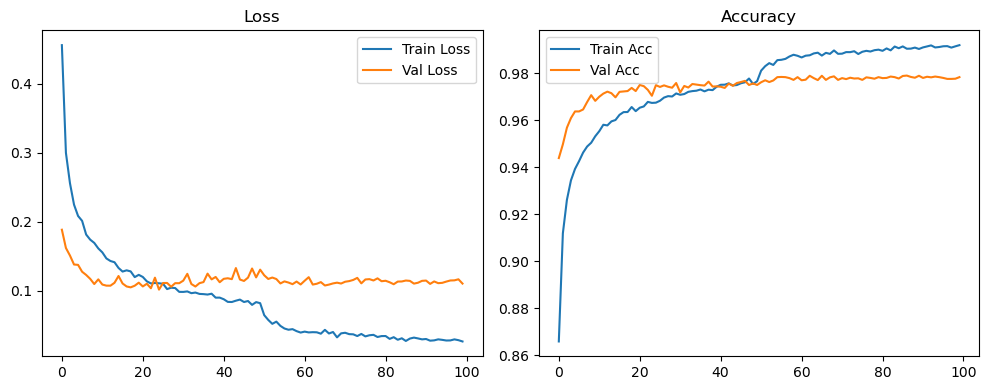

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2453, Acc: 0.9261 | Val Loss: 0.1427, Acc: 0.9563


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1212, Acc: 0.9632 | Val Loss: 0.1238, Acc: 0.9616


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9721 | Val Loss: 0.1269, Acc: 0.9623


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9775 | Val Loss: 0.1191, Acc: 0.9657


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9806 | Val Loss: 0.1126, Acc: 0.9707


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.1242, Acc: 0.9655


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9859 | Val Loss: 0.1088, Acc: 0.9699


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1235, Acc: 0.9689


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9885 | Val Loss: 0.1265, Acc: 0.9708


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.1165, Acc: 0.9717


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.1222, Acc: 0.9717


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1219, Acc: 0.9721


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.1308, Acc: 0.9723


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1441, Acc: 0.9698


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1312, Acc: 0.9725


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1233, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1230, Acc: 0.9728


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1379, Acc: 0.9715


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1343, Acc: 0.9753


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.1315, Acc: 0.9727


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9959 | Val Loss: 0.1400, Acc: 0.9726


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1253, Acc: 0.9750


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1413, Acc: 0.9740


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1271, Acc: 0.9757


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1258, Acc: 0.9744


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1385, Acc: 0.9720


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1384, Acc: 0.9745


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9963 | Val Loss: 0.1356, Acc: 0.9744


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1566, Acc: 0.9732


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1480, Acc: 0.9730


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1456, Acc: 0.9735


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1518, Acc: 0.9731


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1400, Acc: 0.9758


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1477, Acc: 0.9729


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1588, Acc: 0.9731


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1593, Acc: 0.9736


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1526, Acc: 0.9747


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1411, Acc: 0.9758


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1637, Acc: 0.9739


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1553, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1608, Acc: 0.9741


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1485, Acc: 0.9752


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1495, Acc: 0.9763


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1617, Acc: 0.9743


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1595, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1676, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1748, Acc: 0.9746


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1736, Acc: 0.9741


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1432, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1430, Acc: 0.9772


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1593, Acc: 0.9762


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1604, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1746, Acc: 0.9751


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1494, Acc: 0.9758


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1623, Acc: 0.9758


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1684, Acc: 0.9748


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.1778, Acc: 0.9736


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1661, Acc: 0.9729


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1718, Acc: 0.9741


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1633, Acc: 0.9752


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1796, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1616, Acc: 0.9764


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1676, Acc: 0.9757


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1600, Acc: 0.9770


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1769, Acc: 0.9749


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1679, Acc: 0.9754


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1701, Acc: 0.9749


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1778, Acc: 0.9757


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1760, Acc: 0.9751


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1824, Acc: 0.9755


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1790, Acc: 0.9753


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1697, Acc: 0.9754


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1920, Acc: 0.9744


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1821, Acc: 0.9758


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1786, Acc: 0.9747


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1647, Acc: 0.9758


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1823, Acc: 0.9756


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1829, Acc: 0.9756


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1816, Acc: 0.9778


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1746, Acc: 0.9776


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1706, Acc: 0.9773


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.1712, Acc: 0.9765


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1918, Acc: 0.9775


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1904, Acc: 0.9746


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1758, Acc: 0.9768


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.2007, Acc: 0.9743


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1884, Acc: 0.9761


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1916, Acc: 0.9755


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1931, Acc: 0.9760


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.2027, Acc: 0.9738


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.2078, Acc: 0.9742


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1880, Acc: 0.9769


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9987 | Val Loss: 0.1849, Acc: 0.9749


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1879, Acc: 0.9764


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1820, Acc: 0.9771


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2031, Acc: 0.9749


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.2032, Acc: 0.9752


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1786, Acc: 0.9777


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1823, Acc: 0.9778


Final Test Loss: 0.1881 Accuracy: 0.9763


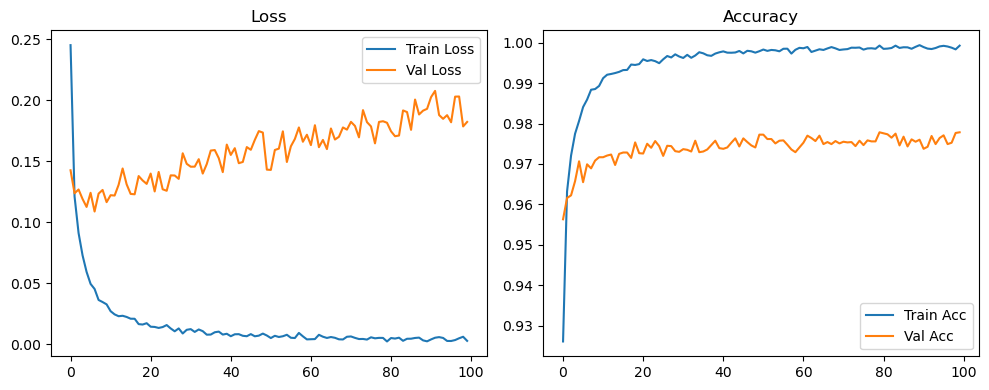

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2945, Acc: 0.9117 | Val Loss: 0.1524, Acc: 0.9539


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1614, Acc: 0.9509 | Val Loss: 0.1378, Acc: 0.9593


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1312, Acc: 0.9591 | Val Loss: 0.1226, Acc: 0.9616


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1086, Acc: 0.9662 | Val Loss: 0.1131, Acc: 0.9673


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9697 | Val Loss: 0.1112, Acc: 0.9677


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0846, Acc: 0.9732 | Val Loss: 0.1095, Acc: 0.9694


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9753 | Val Loss: 0.1075, Acc: 0.9696


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.1076, Acc: 0.9684


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9792 | Val Loss: 0.1070, Acc: 0.9706


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9804 | Val Loss: 0.1074, Acc: 0.9710


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 0.1129, Acc: 0.9721


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9843 | Val Loss: 0.1110, Acc: 0.9701


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9832 | Val Loss: 0.1051, Acc: 0.9731


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9856 | Val Loss: 0.1168, Acc: 0.9709


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.1184, Acc: 0.9721


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9879 | Val Loss: 0.1123, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.1087, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.1189, Acc: 0.9741


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1191, Acc: 0.9750


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.1078, Acc: 0.9742


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.1138, Acc: 0.9744


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.1086, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.1201, Acc: 0.9730


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.1331, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.1209, Acc: 0.9746


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1158, Acc: 0.9750


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.1245, Acc: 0.9734


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1240, Acc: 0.9737


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.1182, Acc: 0.9755


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.1237, Acc: 0.9758


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.1260, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1230, Acc: 0.9760


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.1216, Acc: 0.9748


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1306, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1504, Acc: 0.9722


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9938 | Val Loss: 0.1374, Acc: 0.9750


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.1273, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1261, Acc: 0.9762


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.1382, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.1244, Acc: 0.9765


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1366, Acc: 0.9771


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1241, Acc: 0.9767


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1362, Acc: 0.9761


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1410, Acc: 0.9747


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1520, Acc: 0.9746


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.1508, Acc: 0.9740


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.1495, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1577, Acc: 0.9743


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 0.1321, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1461, Acc: 0.9746


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9944 | Val Loss: 0.1528, Acc: 0.9753


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1568, Acc: 0.9734


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.1461, Acc: 0.9772


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 0.1585, Acc: 0.9745


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.1447, Acc: 0.9764


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9945 | Val Loss: 0.1453, Acc: 0.9770


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1603, Acc: 0.9758


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.1483, Acc: 0.9770


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9948 | Val Loss: 0.1455, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1482, Acc: 0.9761


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.1585, Acc: 0.9751


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9959 | Val Loss: 0.1432, Acc: 0.9778


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1582, Acc: 0.9778


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1578, Acc: 0.9762


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9954 | Val Loss: 0.1494, Acc: 0.9761


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.1517, Acc: 0.9766


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9952 | Val Loss: 0.1520, Acc: 0.9765


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1537, Acc: 0.9753


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.1612, Acc: 0.9778


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9958 | Val Loss: 0.1501, Acc: 0.9785


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.1614, Acc: 0.9763


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1531, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9963 | Val Loss: 0.1531, Acc: 0.9771


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1622, Acc: 0.9752


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.1604, Acc: 0.9769


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9951 | Val Loss: 0.1592, Acc: 0.9756


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9960 | Val Loss: 0.1513, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.1799, Acc: 0.9762


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9960 | Val Loss: 0.1550, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1502, Acc: 0.9782


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1470, Acc: 0.9769


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1468, Acc: 0.9780


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9958 | Val Loss: 0.1492, Acc: 0.9782


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.1548, Acc: 0.9781


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1659, Acc: 0.9764


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1760, Acc: 0.9759


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9962 | Val Loss: 0.1693, Acc: 0.9762


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.1677, Acc: 0.9778


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1675, Acc: 0.9777


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1588, Acc: 0.9781


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9964 | Val Loss: 0.1797, Acc: 0.9759


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1590, Acc: 0.9752


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9965 | Val Loss: 0.1700, Acc: 0.9764


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1647, Acc: 0.9794


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1681, Acc: 0.9778


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1578, Acc: 0.9782


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1681, Acc: 0.9770


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9966 | Val Loss: 0.1640, Acc: 0.9774


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1636, Acc: 0.9778


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9973 | Val Loss: 0.1644, Acc: 0.9766


Final Test Loss: 0.1504 Accuracy: 0.9778


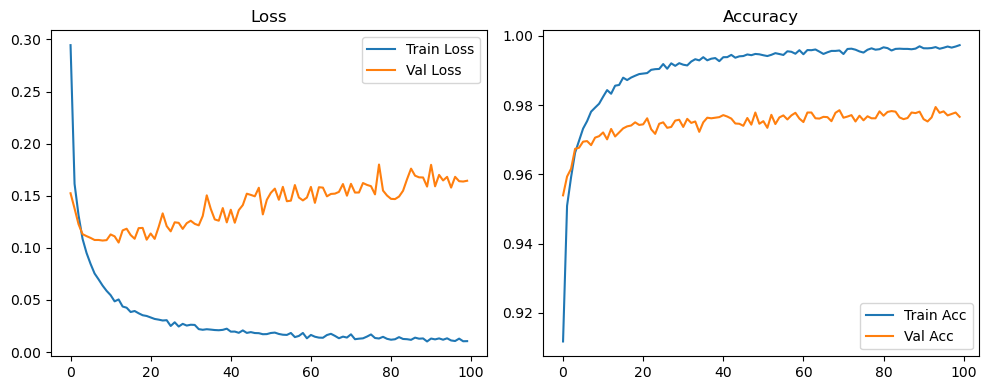

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4496, Acc: 0.8672 | Val Loss: 0.1972, Acc: 0.9407


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2827, Acc: 0.9168 | Val Loss: 0.1605, Acc: 0.9502


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2413, Acc: 0.9293 | Val Loss: 0.1484, Acc: 0.9565


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2172, Acc: 0.9362 | Val Loss: 0.1363, Acc: 0.9602


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1953, Acc: 0.9434 | Val Loss: 0.1266, Acc: 0.9636


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1824, Acc: 0.9474 | Val Loss: 0.1194, Acc: 0.9645


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1684, Acc: 0.9501 | Val Loss: 0.1135, Acc: 0.9667


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1625, Acc: 0.9520 | Val Loss: 0.1106, Acc: 0.9680


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1576, Acc: 0.9527 | Val Loss: 0.1077, Acc: 0.9688


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1492, Acc: 0.9556 | Val Loss: 0.1065, Acc: 0.9701


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1415, Acc: 0.9575 | Val Loss: 0.1041, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1346, Acc: 0.9597 | Val Loss: 0.1049, Acc: 0.9706


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1307, Acc: 0.9612 | Val Loss: 0.1054, Acc: 0.9709


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1230, Acc: 0.9628 | Val Loss: 0.1068, Acc: 0.9695


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1256, Acc: 0.9630 | Val Loss: 0.1106, Acc: 0.9699


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1204, Acc: 0.9642 | Val Loss: 0.1090, Acc: 0.9701


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1128, Acc: 0.9660 | Val Loss: 0.1051, Acc: 0.9726


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1162, Acc: 0.9649 | Val Loss: 0.1023, Acc: 0.9727


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1091, Acc: 0.9664 | Val Loss: 0.1059, Acc: 0.9732


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1076, Acc: 0.9688 | Val Loss: 0.0985, Acc: 0.9733


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1047, Acc: 0.9691 | Val Loss: 0.1018, Acc: 0.9713


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1006, Acc: 0.9690 | Val Loss: 0.1055, Acc: 0.9729


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1018, Acc: 0.9695 | Val Loss: 0.1076, Acc: 0.9717


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9715 | Val Loss: 0.1109, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.1053, Acc: 0.9725


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0941, Acc: 0.9721 | Val Loss: 0.1010, Acc: 0.9736


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9707 | Val Loss: 0.1013, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9713 | Val Loss: 0.1005, Acc: 0.9740


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0884, Acc: 0.9728 | Val Loss: 0.1089, Acc: 0.9734


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9736 | Val Loss: 0.1038, Acc: 0.9738


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0884, Acc: 0.9725 | Val Loss: 0.1026, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0796, Acc: 0.9749 | Val Loss: 0.1174, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9735 | Val Loss: 0.1029, Acc: 0.9733


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9732 | Val Loss: 0.1079, Acc: 0.9730


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9752 | Val Loss: 0.1177, Acc: 0.9723


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9761 | Val Loss: 0.1062, Acc: 0.9737


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9767 | Val Loss: 0.1131, Acc: 0.9739


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9768 | Val Loss: 0.1115, Acc: 0.9752


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9763 | Val Loss: 0.1082, Acc: 0.9738


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9767 | Val Loss: 0.1076, Acc: 0.9727


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9766 | Val Loss: 0.1103, Acc: 0.9752


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9789 | Val Loss: 0.1099, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9769 | Val Loss: 0.1136, Acc: 0.9730


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9772 | Val Loss: 0.1154, Acc: 0.9749


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9790 | Val Loss: 0.1140, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.1072, Acc: 0.9746


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9784 | Val Loss: 0.1125, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9781 | Val Loss: 0.1119, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9801 | Val Loss: 0.1052, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.1137, Acc: 0.9757


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9803 | Val Loss: 0.1060, Acc: 0.9761


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9797 | Val Loss: 0.1083, Acc: 0.9754


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9792 | Val Loss: 0.1093, Acc: 0.9751


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0654, Acc: 0.9795 | Val Loss: 0.1169, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9800 | Val Loss: 0.1092, Acc: 0.9759


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0618, Acc: 0.9807 | Val Loss: 0.1066, Acc: 0.9750


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9812 | Val Loss: 0.1257, Acc: 0.9737


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9815 | Val Loss: 0.1109, Acc: 0.9751


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9811 | Val Loss: 0.1225, Acc: 0.9745


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9817 | Val Loss: 0.1187, Acc: 0.9751


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9814 | Val Loss: 0.1103, Acc: 0.9752


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9812 | Val Loss: 0.1169, Acc: 0.9751


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9817 | Val Loss: 0.1153, Acc: 0.9752


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9819 | Val Loss: 0.1245, Acc: 0.9740


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9810 | Val Loss: 0.1166, Acc: 0.9752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9816 | Val Loss: 0.1151, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9809 | Val Loss: 0.1134, Acc: 0.9752


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.1224, Acc: 0.9748


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0568, Acc: 0.9821 | Val Loss: 0.1118, Acc: 0.9762


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9825 | Val Loss: 0.1156, Acc: 0.9751


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9834 | Val Loss: 0.1160, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9813 | Val Loss: 0.1170, Acc: 0.9742


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9841 | Val Loss: 0.1236, Acc: 0.9739


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9816 | Val Loss: 0.1173, Acc: 0.9743


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9826 | Val Loss: 0.1157, Acc: 0.9752


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9828 | Val Loss: 0.1167, Acc: 0.9757


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9833 | Val Loss: 0.1178, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9834 | Val Loss: 0.1170, Acc: 0.9761


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9835 | Val Loss: 0.1183, Acc: 0.9762


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9842 | Val Loss: 0.1214, Acc: 0.9753


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.1231, Acc: 0.9737


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9841 | Val Loss: 0.1246, Acc: 0.9742


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9840 | Val Loss: 0.1204, Acc: 0.9765


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9837 | Val Loss: 0.1181, Acc: 0.9748


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9845 | Val Loss: 0.1285, Acc: 0.9744


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9840 | Val Loss: 0.1223, Acc: 0.9749


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 0.1290, Acc: 0.9758


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9838 | Val Loss: 0.1198, Acc: 0.9757


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9846 | Val Loss: 0.1221, Acc: 0.9758


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 0.1148, Acc: 0.9753


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9847 | Val Loss: 0.1202, Acc: 0.9759


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9846 | Val Loss: 0.1141, Acc: 0.9760


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9848 | Val Loss: 0.1231, Acc: 0.9747


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9855 | Val Loss: 0.1258, Acc: 0.9750


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9864 | Val Loss: 0.1206, Acc: 0.9753


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9845 | Val Loss: 0.1244, Acc: 0.9747


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9846 | Val Loss: 0.1182, Acc: 0.9759


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.1215, Acc: 0.9763


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9845 | Val Loss: 0.1234, Acc: 0.9742


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9855 | Val Loss: 0.1141, Acc: 0.9757


Final Test Loss: 0.1043 Accuracy: 0.9790


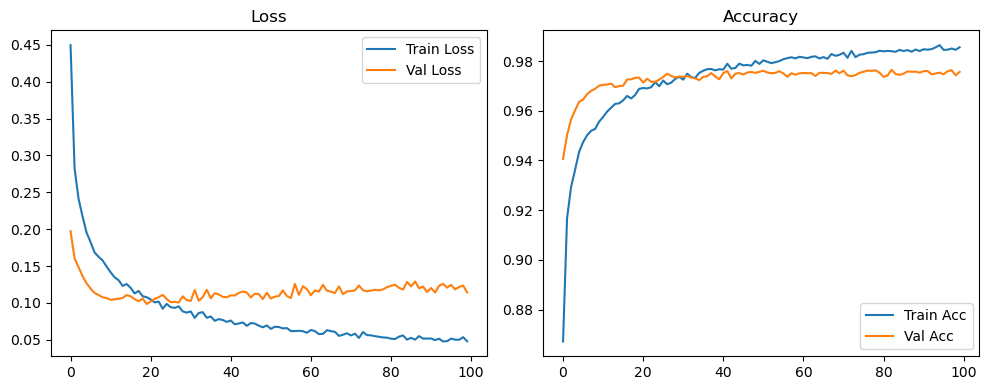

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2453, Acc: 0.9261 | Val Loss: 0.1427, Acc: 0.9563


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1212, Acc: 0.9632 | Val Loss: 0.1238, Acc: 0.9616


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0912, Acc: 0.9721 | Val Loss: 0.1269, Acc: 0.9623


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9775 | Val Loss: 0.1191, Acc: 0.9657


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9806 | Val Loss: 0.1126, Acc: 0.9707


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0495, Acc: 0.9841 | Val Loss: 0.1242, Acc: 0.9655


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9859 | Val Loss: 0.1088, Acc: 0.9699


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1235, Acc: 0.9689


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9885 | Val Loss: 0.1265, Acc: 0.9708


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9893 | Val Loss: 0.1165, Acc: 0.9717


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.1222, Acc: 0.9717


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1219, Acc: 0.9721


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.1308, Acc: 0.9723


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1441, Acc: 0.9698


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1312, Acc: 0.9725


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1233, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1230, Acc: 0.9728


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1379, Acc: 0.9715


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1343, Acc: 0.9753


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.1315, Acc: 0.9727


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9959 | Val Loss: 0.1400, Acc: 0.9726


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1253, Acc: 0.9750


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1413, Acc: 0.9740


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1271, Acc: 0.9757


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1258, Acc: 0.9744


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1385, Acc: 0.9720


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1384, Acc: 0.9745


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9963 | Val Loss: 0.1356, Acc: 0.9744


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1566, Acc: 0.9732


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1480, Acc: 0.9730


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1456, Acc: 0.9735


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1518, Acc: 0.9731


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1400, Acc: 0.9758


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1477, Acc: 0.9729


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1588, Acc: 0.9731


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1593, Acc: 0.9736


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1526, Acc: 0.9747


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1411, Acc: 0.9758


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1637, Acc: 0.9739


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1553, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1608, Acc: 0.9741


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1485, Acc: 0.9752


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1495, Acc: 0.9763


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1617, Acc: 0.9743


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1595, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1676, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1748, Acc: 0.9746


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1736, Acc: 0.9741


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1432, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1407, Acc: 0.9775


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1439, Acc: 0.9781


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1423, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1455, Acc: 0.9783


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1615, Acc: 0.9773


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1561, Acc: 0.9780


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1531, Acc: 0.9784


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1689, Acc: 0.9773


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1707, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1721, Acc: 0.9771


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1650, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1664, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1714, Acc: 0.9801


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1849, Acc: 0.9784


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1714, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1872, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1828, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1847, Acc: 0.9765


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1811, Acc: 0.9778


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1871, Acc: 0.9781


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1827, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1927, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1830, Acc: 0.9783


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1827, Acc: 0.9785


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1957, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1926, Acc: 0.9789


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1821, Acc: 0.9777


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1928, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1896, Acc: 0.9784


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1880, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1870, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1881, Acc: 0.9784


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1890, Acc: 0.9785


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1862, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1964, Acc: 0.9789


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1857, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1832, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1879, Acc: 0.9794


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1872, Acc: 0.9786


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1838, Acc: 0.9791


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1947, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1937, Acc: 0.9789


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1974, Acc: 0.9783


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2037, Acc: 0.9774


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2041, Acc: 0.9777


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2055, Acc: 0.9784


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1941, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1954, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1962, Acc: 0.9785


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1945, Acc: 0.9788


Final Test Loss: 0.1890 Accuracy: 0.9795


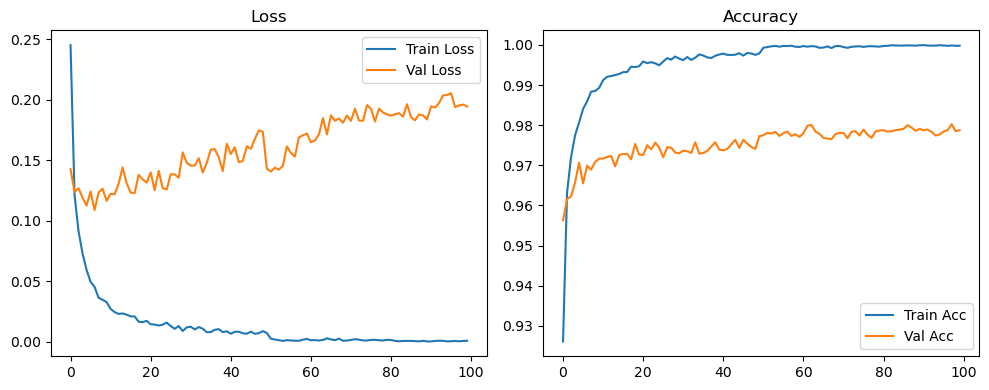

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2945, Acc: 0.9117 | Val Loss: 0.1524, Acc: 0.9539


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1614, Acc: 0.9509 | Val Loss: 0.1378, Acc: 0.9593


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1312, Acc: 0.9591 | Val Loss: 0.1226, Acc: 0.9616


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1086, Acc: 0.9662 | Val Loss: 0.1131, Acc: 0.9673


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9697 | Val Loss: 0.1112, Acc: 0.9677


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0846, Acc: 0.9732 | Val Loss: 0.1095, Acc: 0.9694


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9753 | Val Loss: 0.1075, Acc: 0.9696


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9781 | Val Loss: 0.1076, Acc: 0.9684


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9792 | Val Loss: 0.1070, Acc: 0.9706


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9804 | Val Loss: 0.1074, Acc: 0.9710


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 0.1129, Acc: 0.9721


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9843 | Val Loss: 0.1110, Acc: 0.9701


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9832 | Val Loss: 0.1051, Acc: 0.9731


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9856 | Val Loss: 0.1168, Acc: 0.9709


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.1184, Acc: 0.9721


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9879 | Val Loss: 0.1123, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.1087, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.1189, Acc: 0.9741


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1191, Acc: 0.9750


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.1078, Acc: 0.9742


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.1138, Acc: 0.9744


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.1086, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.1201, Acc: 0.9730


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.1331, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.1209, Acc: 0.9746


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1158, Acc: 0.9750


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.1245, Acc: 0.9734


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.1240, Acc: 0.9737


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.1182, Acc: 0.9755


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.1237, Acc: 0.9758


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.1260, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1230, Acc: 0.9760


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.1216, Acc: 0.9748


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.1306, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1504, Acc: 0.9722


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9938 | Val Loss: 0.1374, Acc: 0.9750


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.1273, Acc: 0.9763


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1261, Acc: 0.9762


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.1382, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.1244, Acc: 0.9765


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1366, Acc: 0.9771


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1241, Acc: 0.9767


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9945 | Val Loss: 0.1362, Acc: 0.9761


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.1410, Acc: 0.9747


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1520, Acc: 0.9746


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.1508, Acc: 0.9740


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9946 | Val Loss: 0.1495, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1577, Acc: 0.9743


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 0.1321, Acc: 0.9778


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1461, Acc: 0.9746


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.1282, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1320, Acc: 0.9784


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1368, Acc: 0.9780


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1431, Acc: 0.9787


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1403, Acc: 0.9780


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1380, Acc: 0.9780


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1522, Acc: 0.9771


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1455, Acc: 0.9775


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1465, Acc: 0.9784


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1463, Acc: 0.9795


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1534, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1526, Acc: 0.9789


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1491, Acc: 0.9789


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1552, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9981 | Val Loss: 0.1563, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1624, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1551, Acc: 0.9779


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1599, Acc: 0.9784


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1520, Acc: 0.9809


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1544, Acc: 0.9787


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1601, Acc: 0.9782


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1591, Acc: 0.9787


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1588, Acc: 0.9784


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1554, Acc: 0.9790


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1566, Acc: 0.9788


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1584, Acc: 0.9789


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1590, Acc: 0.9796


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1611, Acc: 0.9789


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1610, Acc: 0.9781


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1598, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1598, Acc: 0.9793


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1667, Acc: 0.9781


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1607, Acc: 0.9778


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1620, Acc: 0.9792


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1656, Acc: 0.9786


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1576, Acc: 0.9795


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1600, Acc: 0.9784


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1593, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1637, Acc: 0.9785


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1580, Acc: 0.9787


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1573, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1556, Acc: 0.9800


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1665, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1666, Acc: 0.9801


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1694, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1670, Acc: 0.9794


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1686, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1614, Acc: 0.9800


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1589, Acc: 0.9803


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1641, Acc: 0.9798


Final Test Loss: 0.1458 Accuracy: 0.9813


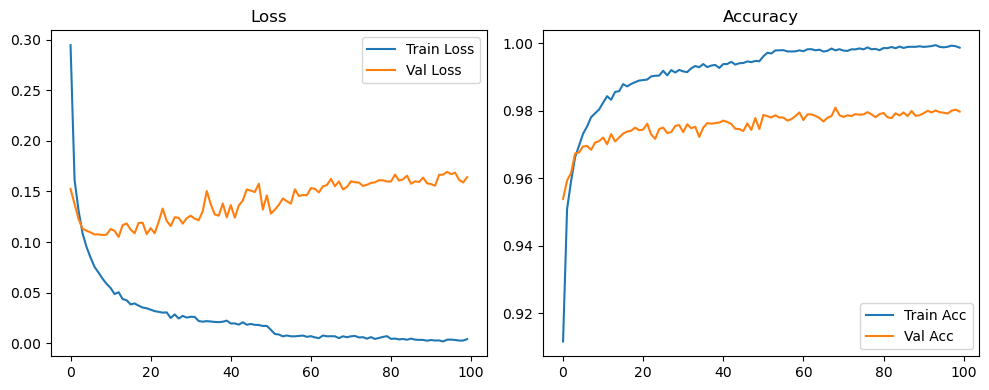

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4496, Acc: 0.8672 | Val Loss: 0.1972, Acc: 0.9407


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2827, Acc: 0.9168 | Val Loss: 0.1605, Acc: 0.9502


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2413, Acc: 0.9293 | Val Loss: 0.1484, Acc: 0.9565


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2172, Acc: 0.9362 | Val Loss: 0.1363, Acc: 0.9602


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1953, Acc: 0.9434 | Val Loss: 0.1266, Acc: 0.9636


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1824, Acc: 0.9474 | Val Loss: 0.1194, Acc: 0.9645


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1684, Acc: 0.9501 | Val Loss: 0.1135, Acc: 0.9667


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1625, Acc: 0.9520 | Val Loss: 0.1106, Acc: 0.9680


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1576, Acc: 0.9527 | Val Loss: 0.1077, Acc: 0.9688


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1492, Acc: 0.9556 | Val Loss: 0.1065, Acc: 0.9701


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1415, Acc: 0.9575 | Val Loss: 0.1041, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1346, Acc: 0.9597 | Val Loss: 0.1049, Acc: 0.9706


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1307, Acc: 0.9612 | Val Loss: 0.1054, Acc: 0.9709


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1230, Acc: 0.9628 | Val Loss: 0.1068, Acc: 0.9695


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1256, Acc: 0.9630 | Val Loss: 0.1106, Acc: 0.9699


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1204, Acc: 0.9642 | Val Loss: 0.1090, Acc: 0.9701


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1128, Acc: 0.9660 | Val Loss: 0.1051, Acc: 0.9726


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1162, Acc: 0.9649 | Val Loss: 0.1023, Acc: 0.9727


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1091, Acc: 0.9664 | Val Loss: 0.1059, Acc: 0.9732


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1076, Acc: 0.9688 | Val Loss: 0.0985, Acc: 0.9733


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1047, Acc: 0.9691 | Val Loss: 0.1018, Acc: 0.9713


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1006, Acc: 0.9690 | Val Loss: 0.1055, Acc: 0.9729


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1018, Acc: 0.9695 | Val Loss: 0.1076, Acc: 0.9717


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9715 | Val Loss: 0.1109, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9699 | Val Loss: 0.1053, Acc: 0.9725


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0941, Acc: 0.9721 | Val Loss: 0.1010, Acc: 0.9736


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0932, Acc: 0.9707 | Val Loss: 0.1013, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9713 | Val Loss: 0.1005, Acc: 0.9740


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0884, Acc: 0.9728 | Val Loss: 0.1089, Acc: 0.9734


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9736 | Val Loss: 0.1038, Acc: 0.9738


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0884, Acc: 0.9725 | Val Loss: 0.1026, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0796, Acc: 0.9749 | Val Loss: 0.1174, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9735 | Val Loss: 0.1029, Acc: 0.9733


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9732 | Val Loss: 0.1079, Acc: 0.9730


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9752 | Val Loss: 0.1177, Acc: 0.9723


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0815, Acc: 0.9761 | Val Loss: 0.1062, Acc: 0.9737


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9767 | Val Loss: 0.1131, Acc: 0.9739


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0780, Acc: 0.9768 | Val Loss: 0.1115, Acc: 0.9752


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9763 | Val Loss: 0.1082, Acc: 0.9738


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9767 | Val Loss: 0.1076, Acc: 0.9727


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9766 | Val Loss: 0.1103, Acc: 0.9752


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9789 | Val Loss: 0.1099, Acc: 0.9760


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0721, Acc: 0.9769 | Val Loss: 0.1136, Acc: 0.9730


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9772 | Val Loss: 0.1154, Acc: 0.9749


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0689, Acc: 0.9790 | Val Loss: 0.1140, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9782 | Val Loss: 0.1072, Acc: 0.9746


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9784 | Val Loss: 0.1125, Acc: 0.9754


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9781 | Val Loss: 0.1119, Acc: 0.9756


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9801 | Val Loss: 0.1052, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.1137, Acc: 0.9757


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0565, Acc: 0.9821 | Val Loss: 0.1062, Acc: 0.9765


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9834 | Val Loss: 0.1110, Acc: 0.9768


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9840 | Val Loss: 0.1064, Acc: 0.9771


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9860 | Val Loss: 0.1105, Acc: 0.9766


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9852 | Val Loss: 0.1109, Acc: 0.9753


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9859 | Val Loss: 0.1095, Acc: 0.9766


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9870 | Val Loss: 0.1136, Acc: 0.9753


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1110, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.1146, Acc: 0.9762


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.1091, Acc: 0.9758


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9874 | Val Loss: 0.1089, Acc: 0.9776


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.1114, Acc: 0.9762


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9878 | Val Loss: 0.1095, Acc: 0.9760


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.1131, Acc: 0.9757


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9872 | Val Loss: 0.1126, Acc: 0.9759


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1134, Acc: 0.9754


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.1130, Acc: 0.9762


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.1147, Acc: 0.9753


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.1103, Acc: 0.9755


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9876 | Val Loss: 0.1118, Acc: 0.9758


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9882 | Val Loss: 0.1156, Acc: 0.9765


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9881 | Val Loss: 0.1115, Acc: 0.9758


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.1164, Acc: 0.9764


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.1133, Acc: 0.9764


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.1144, Acc: 0.9748


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1134, Acc: 0.9777


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.1152, Acc: 0.9760


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.1149, Acc: 0.9762


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.1188, Acc: 0.9762


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1168, Acc: 0.9766


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1168, Acc: 0.9762


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.1149, Acc: 0.9755


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9903 | Val Loss: 0.1132, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.1130, Acc: 0.9765


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9912 | Val Loss: 0.1190, Acc: 0.9761


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.1191, Acc: 0.9751


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9907 | Val Loss: 0.1202, Acc: 0.9761


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1174, Acc: 0.9760


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.1162, Acc: 0.9754


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9921 | Val Loss: 0.1157, Acc: 0.9754


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.1189, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.1170, Acc: 0.9762


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9915 | Val Loss: 0.1241, Acc: 0.9762


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.1257, Acc: 0.9761


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.1172, Acc: 0.9770


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.1209, Acc: 0.9764


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.1235, Acc: 0.9759


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.1162, Acc: 0.9758


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9911 | Val Loss: 0.1183, Acc: 0.9766


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1186, Acc: 0.9765


Final Test Loss: 0.1023 Accuracy: 0.9796


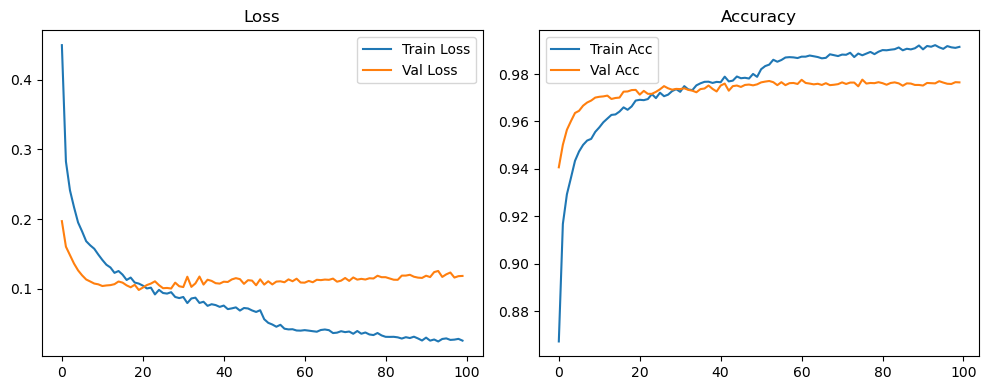

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2470, Acc: 0.9281 | Val Loss: 0.1471, Acc: 0.9543


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1148, Acc: 0.9649 | Val Loss: 0.1311, Acc: 0.9579


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0861, Acc: 0.9722 | Val Loss: 0.1282, Acc: 0.9623


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9784 | Val Loss: 0.1123, Acc: 0.9671


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9809 | Val Loss: 0.1156, Acc: 0.9668


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9851 | Val Loss: 0.1093, Acc: 0.9695


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.1062, Acc: 0.9703


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9881 | Val Loss: 0.1121, Acc: 0.9700


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9897 | Val Loss: 0.1297, Acc: 0.9681


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.1197, Acc: 0.9707


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.1175, Acc: 0.9708


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.1261, Acc: 0.9697


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.1170, Acc: 0.9705


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1192, Acc: 0.9724


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1299, Acc: 0.9694


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.1309, Acc: 0.9693


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9939 | Val Loss: 0.1262, Acc: 0.9716


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.1342, Acc: 0.9698


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1453, Acc: 0.9675


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1242, Acc: 0.9711


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1286, Acc: 0.9715


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1240, Acc: 0.9735


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1229, Acc: 0.9726


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.1376, Acc: 0.9712


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1300, Acc: 0.9735


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1252, Acc: 0.9728


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1344, Acc: 0.9744


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1373, Acc: 0.9721


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1294, Acc: 0.9740


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1251, Acc: 0.9754


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1340, Acc: 0.9737


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1397, Acc: 0.9728


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1215, Acc: 0.9749


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1341, Acc: 0.9746


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1291, Acc: 0.9748


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1358, Acc: 0.9731


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1350, Acc: 0.9748


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1305, Acc: 0.9751


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1231, Acc: 0.9750


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1328, Acc: 0.9751


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.1341, Acc: 0.9753


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1433, Acc: 0.9738


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9970 | Val Loss: 0.1425, Acc: 0.9740


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1334, Acc: 0.9741


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1377, Acc: 0.9743


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1320, Acc: 0.9757


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1491, Acc: 0.9745


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1449, Acc: 0.9740


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1530, Acc: 0.9738


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1473, Acc: 0.9743


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1437, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1415, Acc: 0.9756


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1471, Acc: 0.9748


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1402, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1555, Acc: 0.9745


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1441, Acc: 0.9749


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1559, Acc: 0.9740


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1339, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1370, Acc: 0.9742


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1464, Acc: 0.9748


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1478, Acc: 0.9758


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1428, Acc: 0.9773


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1436, Acc: 0.9784


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1394, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1483, Acc: 0.9755


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1532, Acc: 0.9736


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1439, Acc: 0.9765


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1472, Acc: 0.9769


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1436, Acc: 0.9773


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1477, Acc: 0.9766


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1465, Acc: 0.9770


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1519, Acc: 0.9758


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1524, Acc: 0.9769


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1584, Acc: 0.9764


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1476, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1642, Acc: 0.9749


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1651, Acc: 0.9728


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1781, Acc: 0.9743


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1665, Acc: 0.9759


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1645, Acc: 0.9750


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1657, Acc: 0.9762


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1556, Acc: 0.9769


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1628, Acc: 0.9776


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1529, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1625, Acc: 0.9752


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1607, Acc: 0.9764


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1569, Acc: 0.9768


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1543, Acc: 0.9766


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1585, Acc: 0.9736


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1575, Acc: 0.9757


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1614, Acc: 0.9776


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1669, Acc: 0.9758


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1550, Acc: 0.9764


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.1689, Acc: 0.9757


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1615, Acc: 0.9775


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1691, Acc: 0.9753


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1717, Acc: 0.9748


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1737, Acc: 0.9757


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1616, Acc: 0.9765


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1586, Acc: 0.9759


Final Test Loss: 0.1510 Accuracy: 0.9777


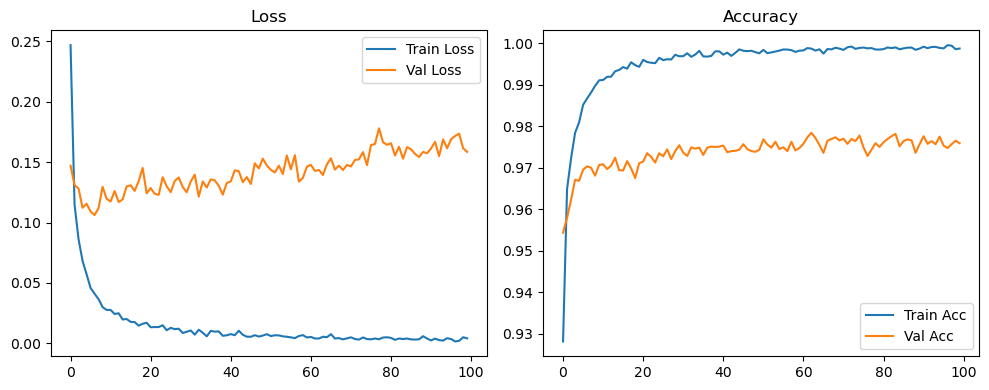

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3055, Acc: 0.9107 | Val Loss: 0.1524, Acc: 0.9533


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1574, Acc: 0.9524 | Val Loss: 0.1306, Acc: 0.9587


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1250, Acc: 0.9608 | Val Loss: 0.1229, Acc: 0.9630


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1050, Acc: 0.9670 | Val Loss: 0.1212, Acc: 0.9637


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0921, Acc: 0.9709 | Val Loss: 0.1082, Acc: 0.9680


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9733 | Val Loss: 0.1090, Acc: 0.9674


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0740, Acc: 0.9763 | Val Loss: 0.1062, Acc: 0.9697


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9788 | Val Loss: 0.1034, Acc: 0.9698


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9794 | Val Loss: 0.1067, Acc: 0.9707


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0598, Acc: 0.9806 | Val Loss: 0.1055, Acc: 0.9712


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9826 | Val Loss: 0.1015, Acc: 0.9714


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9844 | Val Loss: 0.1035, Acc: 0.9723


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 0.1056, Acc: 0.9724


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9841 | Val Loss: 0.1026, Acc: 0.9730


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 0.1052, Acc: 0.9722


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9873 | Val Loss: 0.1017, Acc: 0.9730


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9870 | Val Loss: 0.1075, Acc: 0.9708


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.1090, Acc: 0.9724


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9889 | Val Loss: 0.1113, Acc: 0.9743


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.0994, Acc: 0.9748


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.1154, Acc: 0.9724


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9874 | Val Loss: 0.1031, Acc: 0.9742


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.1071, Acc: 0.9745


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9899 | Val Loss: 0.1056, Acc: 0.9739


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9906 | Val Loss: 0.1035, Acc: 0.9752


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.1053, Acc: 0.9752


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9917 | Val Loss: 0.1161, Acc: 0.9737


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.1028, Acc: 0.9772


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.1181, Acc: 0.9740


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1149, Acc: 0.9742


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1145, Acc: 0.9748


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.1087, Acc: 0.9759


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.1221, Acc: 0.9730


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1152, Acc: 0.9739


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1223, Acc: 0.9757


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1186, Acc: 0.9737


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.1161, Acc: 0.9746


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.1189, Acc: 0.9751


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1157, Acc: 0.9750


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.1140, Acc: 0.9740


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1194, Acc: 0.9752


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1222, Acc: 0.9744


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.1264, Acc: 0.9753


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.1279, Acc: 0.9744


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.1227, Acc: 0.9759


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9948 | Val Loss: 0.1158, Acc: 0.9762


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1192, Acc: 0.9765


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1162, Acc: 0.9762


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1213, Acc: 0.9757


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1196, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.1199, Acc: 0.9752


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1159, Acc: 0.9771


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.1163, Acc: 0.9767


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1284, Acc: 0.9752


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1229, Acc: 0.9771


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1293, Acc: 0.9747


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1268, Acc: 0.9759


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.1217, Acc: 0.9752


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1167, Acc: 0.9784


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.1250, Acc: 0.9749


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1269, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.1213, Acc: 0.9770


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1351, Acc: 0.9767


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9952 | Val Loss: 0.1367, Acc: 0.9762


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1256, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1242, Acc: 0.9757


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1234, Acc: 0.9752


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1236, Acc: 0.9763


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1311, Acc: 0.9761


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1264, Acc: 0.9761


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1293, Acc: 0.9770


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1322, Acc: 0.9766


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1291, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1306, Acc: 0.9775


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1350, Acc: 0.9760


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1326, Acc: 0.9762


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1464, Acc: 0.9769


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1395, Acc: 0.9765


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1354, Acc: 0.9773


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1326, Acc: 0.9752


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.1308, Acc: 0.9772


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1390, Acc: 0.9762


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.1294, Acc: 0.9780


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1359, Acc: 0.9765


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1259, Acc: 0.9773


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1373, Acc: 0.9770


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1464, Acc: 0.9759


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1550, Acc: 0.9754


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1343, Acc: 0.9770


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1357, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1466, Acc: 0.9764


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.1291, Acc: 0.9774


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1276, Acc: 0.9767


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1331, Acc: 0.9781


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1306, Acc: 0.9774


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1357, Acc: 0.9760


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1403, Acc: 0.9766


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1334, Acc: 0.9764


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1291, Acc: 0.9760


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1303, Acc: 0.9766


Final Test Loss: 0.1263 Accuracy: 0.9787


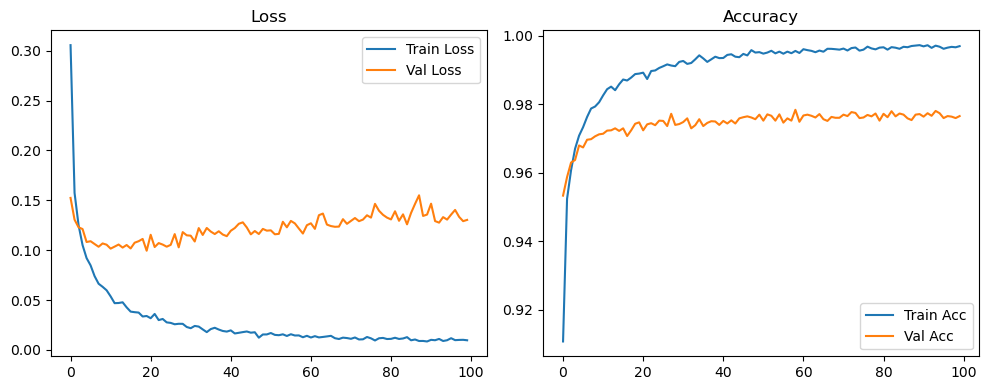

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4774, Acc: 0.8596 | Val Loss: 0.1956, Acc: 0.9415


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2780, Acc: 0.9165 | Val Loss: 0.1657, Acc: 0.9503


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2343, Acc: 0.9306 | Val Loss: 0.1482, Acc: 0.9554


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2135, Acc: 0.9376 | Val Loss: 0.1335, Acc: 0.9612


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1959, Acc: 0.9426 | Val Loss: 0.1247, Acc: 0.9643


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1828, Acc: 0.9460 | Val Loss: 0.1168, Acc: 0.9647


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1707, Acc: 0.9487 | Val Loss: 0.1219, Acc: 0.9665


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1601, Acc: 0.9528 | Val Loss: 0.1146, Acc: 0.9661


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1481, Acc: 0.9543 | Val Loss: 0.1127, Acc: 0.9682


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1517, Acc: 0.9549 | Val Loss: 0.1080, Acc: 0.9698


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1426, Acc: 0.9577 | Val Loss: 0.1096, Acc: 0.9689


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1339, Acc: 0.9598 | Val Loss: 0.1069, Acc: 0.9714


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1286, Acc: 0.9609 | Val Loss: 0.1084, Acc: 0.9699


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1266, Acc: 0.9611 | Val Loss: 0.1094, Acc: 0.9702


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1235, Acc: 0.9619 | Val Loss: 0.1075, Acc: 0.9708


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1155, Acc: 0.9647 | Val Loss: 0.1057, Acc: 0.9708


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1129, Acc: 0.9643 | Val Loss: 0.0986, Acc: 0.9732


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1073, Acc: 0.9671 | Val Loss: 0.1052, Acc: 0.9709


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1083, Acc: 0.9659 | Val Loss: 0.1035, Acc: 0.9732


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1054, Acc: 0.9685 | Val Loss: 0.1031, Acc: 0.9727


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1065, Acc: 0.9676 | Val Loss: 0.0996, Acc: 0.9710


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0972, Acc: 0.9687 | Val Loss: 0.1011, Acc: 0.9733


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0951, Acc: 0.9699 | Val Loss: 0.1029, Acc: 0.9746


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0935, Acc: 0.9711 | Val Loss: 0.1058, Acc: 0.9718


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0926, Acc: 0.9702 | Val Loss: 0.1053, Acc: 0.9738


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0957, Acc: 0.9705 | Val Loss: 0.0982, Acc: 0.9739


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0934, Acc: 0.9707 | Val Loss: 0.1074, Acc: 0.9728


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0889, Acc: 0.9725 | Val Loss: 0.1019, Acc: 0.9739


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0861, Acc: 0.9730 | Val Loss: 0.1011, Acc: 0.9739


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0851, Acc: 0.9739 | Val Loss: 0.1015, Acc: 0.9732


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0850, Acc: 0.9743 | Val Loss: 0.1039, Acc: 0.9727


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0799, Acc: 0.9744 | Val Loss: 0.1020, Acc: 0.9752


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0788, Acc: 0.9752 | Val Loss: 0.1034, Acc: 0.9739


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0789, Acc: 0.9748 | Val Loss: 0.1051, Acc: 0.9726


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9747 | Val Loss: 0.1105, Acc: 0.9714


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0773, Acc: 0.9763 | Val Loss: 0.1011, Acc: 0.9747


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0734, Acc: 0.9771 | Val Loss: 0.1014, Acc: 0.9758


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9763 | Val Loss: 0.1034, Acc: 0.9743


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0729, Acc: 0.9763 | Val Loss: 0.1048, Acc: 0.9748


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0743, Acc: 0.9771 | Val Loss: 0.1035, Acc: 0.9740


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9779 | Val Loss: 0.1031, Acc: 0.9747


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0726, Acc: 0.9771 | Val Loss: 0.1036, Acc: 0.9748


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9787 | Val Loss: 0.1098, Acc: 0.9737


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9784 | Val Loss: 0.1092, Acc: 0.9742


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0694, Acc: 0.9790 | Val Loss: 0.1019, Acc: 0.9752


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9789 | Val Loss: 0.0999, Acc: 0.9762


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0688, Acc: 0.9779 | Val Loss: 0.1023, Acc: 0.9751


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9802 | Val Loss: 0.1105, Acc: 0.9746


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0655, Acc: 0.9797 | Val Loss: 0.1044, Acc: 0.9754


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9797 | Val Loss: 0.1057, Acc: 0.9743


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0643, Acc: 0.9796 | Val Loss: 0.0976, Acc: 0.9753


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.1093, Acc: 0.9747


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.1077, Acc: 0.9747


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9798 | Val Loss: 0.1081, Acc: 0.9755


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9807 | Val Loss: 0.1061, Acc: 0.9752


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9802 | Val Loss: 0.1099, Acc: 0.9747


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9814 | Val Loss: 0.1094, Acc: 0.9752


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9824 | Val Loss: 0.1071, Acc: 0.9747


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9821 | Val Loss: 0.1141, Acc: 0.9736


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9811 | Val Loss: 0.1115, Acc: 0.9743


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9818 | Val Loss: 0.1104, Acc: 0.9746


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9829 | Val Loss: 0.1097, Acc: 0.9748


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9819 | Val Loss: 0.1122, Acc: 0.9743


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9822 | Val Loss: 0.1153, Acc: 0.9757


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9826 | Val Loss: 0.1125, Acc: 0.9746


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9808 | Val Loss: 0.1092, Acc: 0.9743


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9832 | Val Loss: 0.1122, Acc: 0.9739


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.1153, Acc: 0.9744


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.1113, Acc: 0.9759


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 0.1151, Acc: 0.9730


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9836 | Val Loss: 0.1107, Acc: 0.9761


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9835 | Val Loss: 0.1115, Acc: 0.9748


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 0.1113, Acc: 0.9762


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0560, Acc: 0.9829 | Val Loss: 0.1089, Acc: 0.9756


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9843 | Val Loss: 0.1074, Acc: 0.9769


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9841 | Val Loss: 0.1072, Acc: 0.9760


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9840 | Val Loss: 0.1098, Acc: 0.9746


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9846 | Val Loss: 0.1181, Acc: 0.9758


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9836 | Val Loss: 0.1062, Acc: 0.9761


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9843 | Val Loss: 0.1112, Acc: 0.9762


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9839 | Val Loss: 0.1129, Acc: 0.9753


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9847 | Val Loss: 0.1144, Acc: 0.9752


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9848 | Val Loss: 0.1096, Acc: 0.9762


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9845 | Val Loss: 0.1126, Acc: 0.9763


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.1160, Acc: 0.9748


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.1136, Acc: 0.9757


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9844 | Val Loss: 0.1150, Acc: 0.9766


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.1151, Acc: 0.9768


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9845 | Val Loss: 0.1122, Acc: 0.9770


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9851 | Val Loss: 0.1073, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0471, Acc: 0.9846 | Val Loss: 0.1113, Acc: 0.9768


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9860 | Val Loss: 0.1173, Acc: 0.9746


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9856 | Val Loss: 0.1099, Acc: 0.9756


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9855 | Val Loss: 0.1107, Acc: 0.9758


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.1118, Acc: 0.9754


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.1159, Acc: 0.9765


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9862 | Val Loss: 0.1098, Acc: 0.9760


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9860 | Val Loss: 0.1102, Acc: 0.9754


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.1140, Acc: 0.9759


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9857 | Val Loss: 0.1165, Acc: 0.9757


Final Test Loss: 0.1011 Accuracy: 0.9781


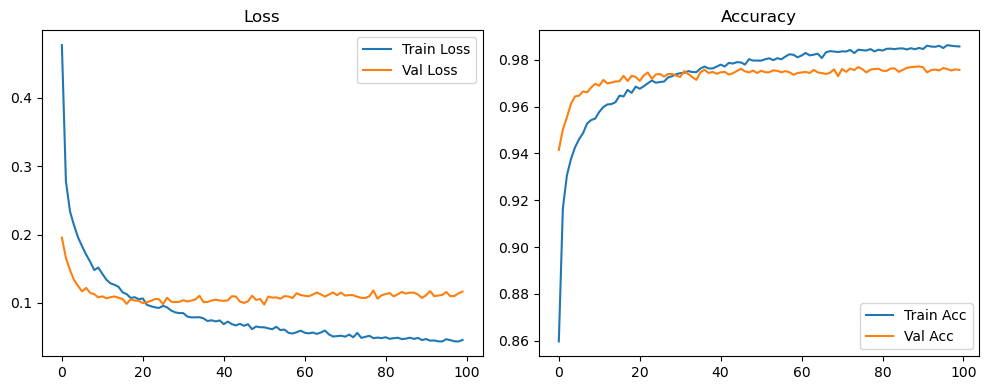

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2688, Acc: 0.9228 | Val Loss: 0.1401, Acc: 0.9560


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1100, Acc: 0.9662 | Val Loss: 0.1158, Acc: 0.9627


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0826, Acc: 0.9739 | Val Loss: 0.1194, Acc: 0.9631


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9799 | Val Loss: 0.1179, Acc: 0.9662


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9826 | Val Loss: 0.1089, Acc: 0.9690


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9844 | Val Loss: 0.1053, Acc: 0.9706


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9872 | Val Loss: 0.1210, Acc: 0.9663


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.1089, Acc: 0.9706


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.1184, Acc: 0.9702


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9909 | Val Loss: 0.1221, Acc: 0.9680


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.1142, Acc: 0.9712


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.1194, Acc: 0.9706


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.1226, Acc: 0.9698


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9927 | Val Loss: 0.1317, Acc: 0.9694


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.1218, Acc: 0.9717


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.1266, Acc: 0.9701


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1226, Acc: 0.9720


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1236, Acc: 0.9716


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.1334, Acc: 0.9699


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1287, Acc: 0.9722


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1272, Acc: 0.9703


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9952 | Val Loss: 0.1333, Acc: 0.9712


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1254, Acc: 0.9737


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1278, Acc: 0.9728


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1140, Acc: 0.9745


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1178, Acc: 0.9722


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1221, Acc: 0.9728


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9966 | Val Loss: 0.1219, Acc: 0.9733


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1240, Acc: 0.9738


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1277, Acc: 0.9742


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1291, Acc: 0.9719


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1320, Acc: 0.9740


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1253, Acc: 0.9746


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1345, Acc: 0.9718


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1287, Acc: 0.9741


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1423, Acc: 0.9719


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1370, Acc: 0.9728


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1261, Acc: 0.9745


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1296, Acc: 0.9746


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1244, Acc: 0.9740


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1344, Acc: 0.9722


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1302, Acc: 0.9745


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.1374, Acc: 0.9746


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1327, Acc: 0.9744


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1323, Acc: 0.9744


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1297, Acc: 0.9748


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1278, Acc: 0.9745


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1267, Acc: 0.9761


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1237, Acc: 0.9748


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1398, Acc: 0.9742


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1406, Acc: 0.9741


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1336, Acc: 0.9738


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1207, Acc: 0.9772


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1345, Acc: 0.9749


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1323, Acc: 0.9752


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1295, Acc: 0.9761


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1338, Acc: 0.9743


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1399, Acc: 0.9748


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1304, Acc: 0.9765


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1284, Acc: 0.9764


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1438, Acc: 0.9735


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1298, Acc: 0.9755


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1330, Acc: 0.9755


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1280, Acc: 0.9774


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1376, Acc: 0.9754


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1491, Acc: 0.9732


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1470, Acc: 0.9752


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1390, Acc: 0.9742


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1590, Acc: 0.9736


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1467, Acc: 0.9748


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1544, Acc: 0.9760


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1484, Acc: 0.9732


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1386, Acc: 0.9767


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1296, Acc: 0.9772


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1366, Acc: 0.9762


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1417, Acc: 0.9740


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1544, Acc: 0.9734


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1446, Acc: 0.9749


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1573, Acc: 0.9738


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1360, Acc: 0.9759


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1432, Acc: 0.9759


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1489, Acc: 0.9746


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1453, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1505, Acc: 0.9748


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1669, Acc: 0.9721


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1561, Acc: 0.9740


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1473, Acc: 0.9756


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1480, Acc: 0.9748


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1449, Acc: 0.9756


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1396, Acc: 0.9774


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1457, Acc: 0.9762


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1517, Acc: 0.9763


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1472, Acc: 0.9743


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1410, Acc: 0.9779


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1519, Acc: 0.9752


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1521, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1599, Acc: 0.9759


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1573, Acc: 0.9761


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1473, Acc: 0.9769


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1537, Acc: 0.9762


Final Test Loss: 0.1432 Accuracy: 0.9770


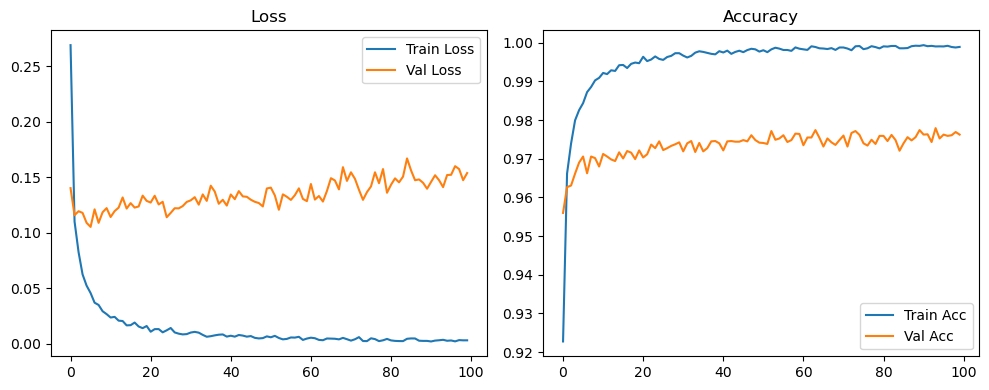

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3402, Acc: 0.9046 | Val Loss: 0.1589, Acc: 0.9511


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1591, Acc: 0.9516 | Val Loss: 0.1329, Acc: 0.9583


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1299, Acc: 0.9598 | Val Loss: 0.1243, Acc: 0.9625


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1081, Acc: 0.9661 | Val Loss: 0.1151, Acc: 0.9661


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0942, Acc: 0.9694 | Val Loss: 0.1059, Acc: 0.9675


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9734 | Val Loss: 0.1122, Acc: 0.9664


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0744, Acc: 0.9762 | Val Loss: 0.1047, Acc: 0.9697


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0673, Acc: 0.9785 | Val Loss: 0.1032, Acc: 0.9692


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9802 | Val Loss: 0.1053, Acc: 0.9702


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9792 | Val Loss: 0.1095, Acc: 0.9693


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9814 | Val Loss: 0.1054, Acc: 0.9695


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9824 | Val Loss: 0.1015, Acc: 0.9700


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9839 | Val Loss: 0.1047, Acc: 0.9713


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9846 | Val Loss: 0.1064, Acc: 0.9717


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9856 | Val Loss: 0.1130, Acc: 0.9701


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1105, Acc: 0.9717


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9856 | Val Loss: 0.1137, Acc: 0.9689


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.1105, Acc: 0.9705


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.1083, Acc: 0.9714


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9878 | Val Loss: 0.1126, Acc: 0.9720


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9875 | Val Loss: 0.1044, Acc: 0.9724


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.1091, Acc: 0.9723


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.1073, Acc: 0.9730


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.1144, Acc: 0.9718


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.1189, Acc: 0.9703


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.1114, Acc: 0.9720


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.1199, Acc: 0.9718


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1091, Acc: 0.9723


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.1119, Acc: 0.9735


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9916 | Val Loss: 0.1167, Acc: 0.9719


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1146, Acc: 0.9725


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1071, Acc: 0.9740


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9916 | Val Loss: 0.1099, Acc: 0.9740


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1142, Acc: 0.9740


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.1153, Acc: 0.9731


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.1173, Acc: 0.9731


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1140, Acc: 0.9753


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.1051, Acc: 0.9748


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1081, Acc: 0.9754


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1088, Acc: 0.9748


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.1123, Acc: 0.9738


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.1157, Acc: 0.9746


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9926 | Val Loss: 0.1145, Acc: 0.9735


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1105, Acc: 0.9740


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1128, Acc: 0.9742


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9768


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.1105, Acc: 0.9758


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1159, Acc: 0.9759


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1104, Acc: 0.9745


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1169, Acc: 0.9749


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.1087, Acc: 0.9749


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1161, Acc: 0.9740


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1114, Acc: 0.9748


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9942 | Val Loss: 0.1197, Acc: 0.9737


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.1176, Acc: 0.9745


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1197, Acc: 0.9747


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1208, Acc: 0.9741


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1277, Acc: 0.9740


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1260, Acc: 0.9743


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.1120, Acc: 0.9761


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1248, Acc: 0.9753


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1170, Acc: 0.9756


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9956 | Val Loss: 0.1179, Acc: 0.9759


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.1146, Acc: 0.9742


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1237, Acc: 0.9752


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1183, Acc: 0.9756


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1174, Acc: 0.9759


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1198, Acc: 0.9749


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1217, Acc: 0.9738


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1176, Acc: 0.9751


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1213, Acc: 0.9751


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1141, Acc: 0.9758


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1167, Acc: 0.9759


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1219, Acc: 0.9742


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1185, Acc: 0.9752


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1160, Acc: 0.9770


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1154, Acc: 0.9755


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1237, Acc: 0.9758


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1150, Acc: 0.9759


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1155, Acc: 0.9762


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1206, Acc: 0.9748


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1191, Acc: 0.9759


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1198, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1257, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1321, Acc: 0.9741


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1361, Acc: 0.9752


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1303, Acc: 0.9754


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1258, Acc: 0.9753


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1313, Acc: 0.9752


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1318, Acc: 0.9755


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1280, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1209, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1238, Acc: 0.9767


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1300, Acc: 0.9749


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1234, Acc: 0.9760


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1272, Acc: 0.9766


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.1304, Acc: 0.9752


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1205, Acc: 0.9756


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1271, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1312, Acc: 0.9750


Final Test Loss: 0.1210 Accuracy: 0.9777


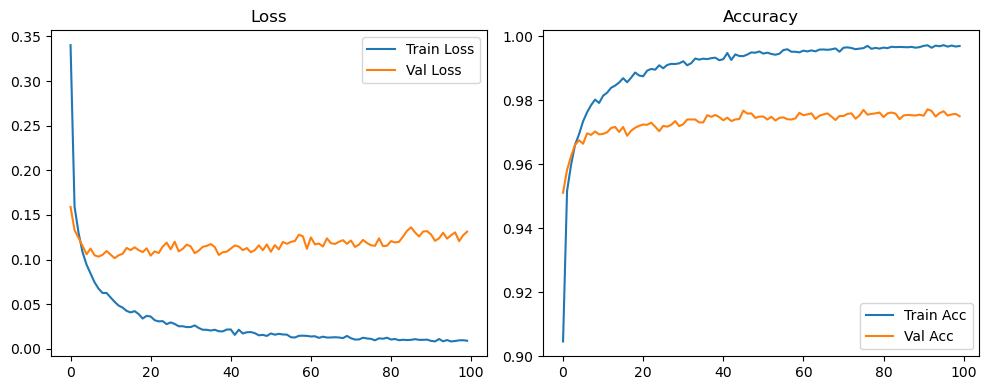

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5625, Acc: 0.8383 | Val Loss: 0.2103, Acc: 0.9370


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2874, Acc: 0.9165 | Val Loss: 0.1679, Acc: 0.9484


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2418, Acc: 0.9298 | Val Loss: 0.1529, Acc: 0.9555


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2143, Acc: 0.9373 | Val Loss: 0.1447, Acc: 0.9576


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2032, Acc: 0.9396 | Val Loss: 0.1319, Acc: 0.9609


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1859, Acc: 0.9448 | Val Loss: 0.1237, Acc: 0.9621


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1721, Acc: 0.9486 | Val Loss: 0.1190, Acc: 0.9644


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1608, Acc: 0.9518 | Val Loss: 0.1183, Acc: 0.9649


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1566, Acc: 0.9521 | Val Loss: 0.1131, Acc: 0.9667


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1538, Acc: 0.9533 | Val Loss: 0.1086, Acc: 0.9682


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1464, Acc: 0.9563 | Val Loss: 0.1104, Acc: 0.9677


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1376, Acc: 0.9581 | Val Loss: 0.1106, Acc: 0.9683


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1344, Acc: 0.9587 | Val Loss: 0.1102, Acc: 0.9674


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1307, Acc: 0.9610 | Val Loss: 0.1102, Acc: 0.9694


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1278, Acc: 0.9607 | Val Loss: 0.1126, Acc: 0.9685


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1226, Acc: 0.9619 | Val Loss: 0.1046, Acc: 0.9700


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1204, Acc: 0.9622 | Val Loss: 0.1000, Acc: 0.9714


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1158, Acc: 0.9638 | Val Loss: 0.1021, Acc: 0.9713


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1146, Acc: 0.9651 | Val Loss: 0.1007, Acc: 0.9724


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1117, Acc: 0.9656 | Val Loss: 0.0983, Acc: 0.9729


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1087, Acc: 0.9674 | Val Loss: 0.0992, Acc: 0.9730


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1046, Acc: 0.9662 | Val Loss: 0.1008, Acc: 0.9730


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1027, Acc: 0.9679 | Val Loss: 0.0999, Acc: 0.9714


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1012, Acc: 0.9684 | Val Loss: 0.1029, Acc: 0.9722


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0972, Acc: 0.9694 | Val Loss: 0.1039, Acc: 0.9718


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0986, Acc: 0.9693 | Val Loss: 0.0959, Acc: 0.9723


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.1010, Acc: 0.9690 | Val Loss: 0.1026, Acc: 0.9716


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0946, Acc: 0.9709 | Val Loss: 0.0978, Acc: 0.9731


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0957, Acc: 0.9703 | Val Loss: 0.0973, Acc: 0.9741


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0863, Acc: 0.9721 | Val Loss: 0.0977, Acc: 0.9747


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0916, Acc: 0.9718 | Val Loss: 0.0988, Acc: 0.9725


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0868, Acc: 0.9722 | Val Loss: 0.1025, Acc: 0.9735


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0815, Acc: 0.9731 | Val Loss: 0.0982, Acc: 0.9738


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9735 | Val Loss: 0.1018, Acc: 0.9741


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0817, Acc: 0.9738 | Val Loss: 0.1033, Acc: 0.9742


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0848, Acc: 0.9740 | Val Loss: 0.1016, Acc: 0.9740


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9747 | Val Loss: 0.0998, Acc: 0.9744


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9744 | Val Loss: 0.1004, Acc: 0.9723


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0746, Acc: 0.9762 | Val Loss: 0.1012, Acc: 0.9742


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9754 | Val Loss: 0.0993, Acc: 0.9740


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9754 | Val Loss: 0.1006, Acc: 0.9722


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9766 | Val Loss: 0.1020, Acc: 0.9740


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0719, Acc: 0.9768 | Val Loss: 0.1002, Acc: 0.9738


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.1019, Acc: 0.9745


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0729, Acc: 0.9773 | Val Loss: 0.1043, Acc: 0.9728


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0688, Acc: 0.9788 | Val Loss: 0.0988, Acc: 0.9740


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9776 | Val Loss: 0.0971, Acc: 0.9749


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9786 | Val Loss: 0.1013, Acc: 0.9746


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9782 | Val Loss: 0.1007, Acc: 0.9755


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0691, Acc: 0.9780 | Val Loss: 0.1055, Acc: 0.9738


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9796 | Val Loss: 0.1025, Acc: 0.9744


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9802 | Val Loss: 0.1005, Acc: 0.9727


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0658, Acc: 0.9788 | Val Loss: 0.1029, Acc: 0.9738


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9790 | Val Loss: 0.1033, Acc: 0.9739


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9788 | Val Loss: 0.0985, Acc: 0.9747


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0640, Acc: 0.9800 | Val Loss: 0.0998, Acc: 0.9739


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0602, Acc: 0.9809 | Val Loss: 0.1053, Acc: 0.9734


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0636, Acc: 0.9795 | Val Loss: 0.0999, Acc: 0.9752


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9806 | Val Loss: 0.1006, Acc: 0.9740


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0606, Acc: 0.9808 | Val Loss: 0.1057, Acc: 0.9741


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9802 | Val Loss: 0.1065, Acc: 0.9742


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.1066, Acc: 0.9732


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9815 | Val Loss: 0.1011, Acc: 0.9755


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9801 | Val Loss: 0.1014, Acc: 0.9760


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9805 | Val Loss: 0.1000, Acc: 0.9744


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0617, Acc: 0.9809 | Val Loss: 0.0979, Acc: 0.9742


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9825 | Val Loss: 0.1097, Acc: 0.9739


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9824 | Val Loss: 0.1079, Acc: 0.9742


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0548, Acc: 0.9827 | Val Loss: 0.1055, Acc: 0.9749


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9820 | Val Loss: 0.1082, Acc: 0.9732


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9829 | Val Loss: 0.1090, Acc: 0.9751


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0535, Acc: 0.9826 | Val Loss: 0.1144, Acc: 0.9728


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9822 | Val Loss: 0.1074, Acc: 0.9741


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0541, Acc: 0.9830 | Val Loss: 0.1092, Acc: 0.9742


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9828 | Val Loss: 0.1065, Acc: 0.9743


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9834 | Val Loss: 0.1039, Acc: 0.9748


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9840 | Val Loss: 0.1040, Acc: 0.9748


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9826 | Val Loss: 0.1075, Acc: 0.9744


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9844 | Val Loss: 0.1079, Acc: 0.9758


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9839 | Val Loss: 0.1069, Acc: 0.9756


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0503, Acc: 0.9839 | Val Loss: 0.1081, Acc: 0.9741


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9850 | Val Loss: 0.1066, Acc: 0.9738


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0557, Acc: 0.9831 | Val Loss: 0.1077, Acc: 0.9741


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.1068, Acc: 0.9747


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9831 | Val Loss: 0.1042, Acc: 0.9743


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9846 | Val Loss: 0.1011, Acc: 0.9758


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 0.1045, Acc: 0.9745


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.1062, Acc: 0.9743


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9842 | Val Loss: 0.1061, Acc: 0.9749


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.1073, Acc: 0.9748


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9848 | Val Loss: 0.1038, Acc: 0.9748


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9859 | Val Loss: 0.1023, Acc: 0.9758


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0995, Acc: 0.9745


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9847 | Val Loss: 0.1026, Acc: 0.9760


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9852 | Val Loss: 0.1036, Acc: 0.9750


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.1039, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9857 | Val Loss: 0.1079, Acc: 0.9739


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.1036, Acc: 0.9758


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 0.1024, Acc: 0.9756


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9853 | Val Loss: 0.1030, Acc: 0.9752


Final Test Loss: 0.1004 Accuracy: 0.9766


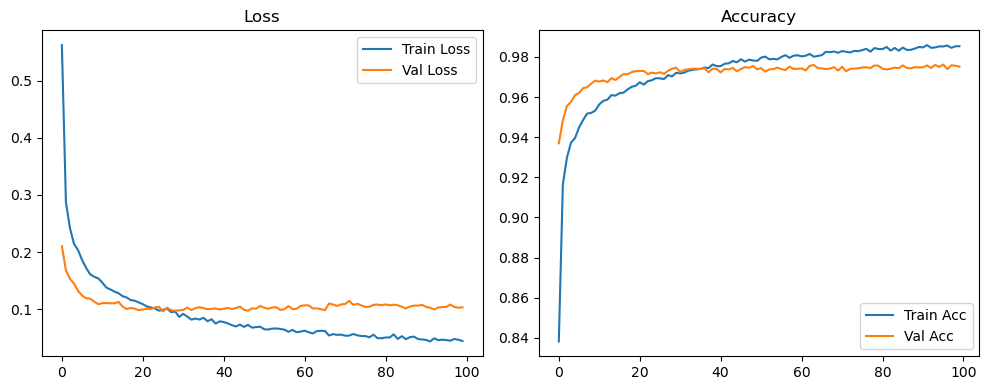

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2496, Acc: 0.9240 | Val Loss: 0.1657, Acc: 0.9512


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9620 | Val Loss: 0.1396, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1416, Acc: 0.9589


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9800 | Val Loss: 0.1304, Acc: 0.9646


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9826 | Val Loss: 0.1237, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1274, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.1278, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1291, Acc: 0.9684


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.1409, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.1421, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.1585, Acc: 0.9668


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1393, Acc: 0.9679


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1451, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1367, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1319, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.1405, Acc: 0.9714


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1345, Acc: 0.9710


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1336, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1389, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1355, Acc: 0.9730


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1548, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1588, Acc: 0.9692


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1487, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1655, Acc: 0.9716


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1288, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1823, Acc: 0.9693


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1639, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9729


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1460, Acc: 0.9733


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1550, Acc: 0.9718


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1712, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1680, Acc: 0.9722


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1457, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1835, Acc: 0.9718


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9970 | Val Loss: 0.1499, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1607, Acc: 0.9742


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1554, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1688, Acc: 0.9726


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1628, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1688, Acc: 0.9736


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1778, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1741, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1746, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1916, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1730, Acc: 0.9758


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1635, Acc: 0.9758


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1767, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1893, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1787, Acc: 0.9736


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1618, Acc: 0.9758


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1981, Acc: 0.9714


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1765, Acc: 0.9740


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1717, Acc: 0.9749


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1679, Acc: 0.9728


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1767, Acc: 0.9738


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1807, Acc: 0.9728


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1821, Acc: 0.9739


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1875, Acc: 0.9734


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1919, Acc: 0.9742


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1697, Acc: 0.9768


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1857, Acc: 0.9744


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1657, Acc: 0.9760


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1700, Acc: 0.9757


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1774, Acc: 0.9739


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1477, Acc: 0.9772


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1577, Acc: 0.9779


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1671, Acc: 0.9768


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1780, Acc: 0.9768


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1846, Acc: 0.9765


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1753, Acc: 0.9772


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.1994, Acc: 0.9737


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1830, Acc: 0.9758


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.2033, Acc: 0.9762


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9981 | Val Loss: 0.1815, Acc: 0.9757


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1858, Acc: 0.9768


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1884, Acc: 0.9751


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1873, Acc: 0.9751


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1892, Acc: 0.9759


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1797, Acc: 0.9758


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1880, Acc: 0.9762


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.2019, Acc: 0.9756


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1964, Acc: 0.9768


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1889, Acc: 0.9761


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1924, Acc: 0.9761


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1822, Acc: 0.9753


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9987 | Val Loss: 0.1813, Acc: 0.9778


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1911, Acc: 0.9771


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9990 | Val Loss: 0.1746, Acc: 0.9772


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1760, Acc: 0.9768


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1670, Acc: 0.9774


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1805, Acc: 0.9762


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2054, Acc: 0.9772


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9982 | Val Loss: 0.1905, Acc: 0.9771


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1871, Acc: 0.9773


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1962, Acc: 0.9772


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1666, Acc: 0.9779


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1801, Acc: 0.9783


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1931, Acc: 0.9758


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1945, Acc: 0.9753


Final Test Loss: 0.1602 Accuracy: 0.9776


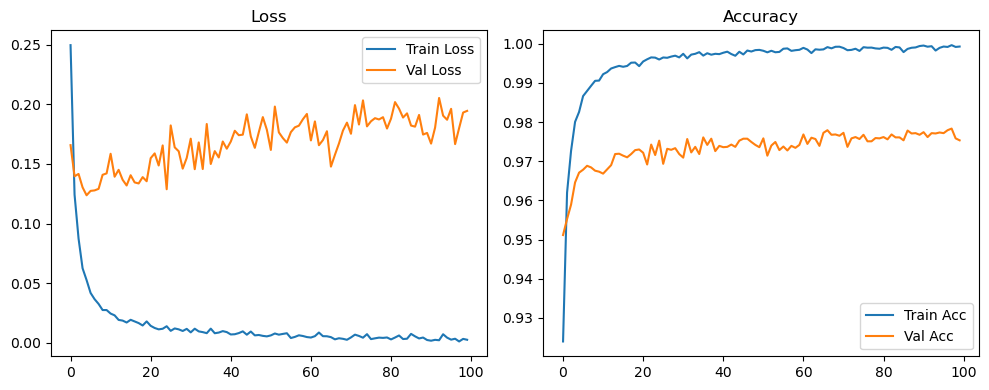

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2980, Acc: 0.9105 | Val Loss: 0.1653, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1626, Acc: 0.9498 | Val Loss: 0.1347, Acc: 0.9571


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9607 | Val Loss: 0.1293, Acc: 0.9603


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9678 | Val Loss: 0.1090, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9728 | Val Loss: 0.1178, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9760 | Val Loss: 0.1163, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9783 | Val Loss: 0.1058, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9807 | Val Loss: 0.1191, Acc: 0.9661


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9828 | Val Loss: 0.1179, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.1204, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 0.1066, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1230, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.1210, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1172, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1156, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.1191, Acc: 0.9743


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1252, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.1277, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.1240, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1153, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.1201, Acc: 0.9743


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1351, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.1284, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9913 | Val Loss: 0.1297, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.1296, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1238, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1359, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9926 | Val Loss: 0.1334, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1339, Acc: 0.9753


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9925 | Val Loss: 0.1339, Acc: 0.9745


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9925 | Val Loss: 0.1267, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1263, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1234, Acc: 0.9769


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.1484, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.1496, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1418, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.1364, Acc: 0.9761


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1419, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9936 | Val Loss: 0.1402, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1356, Acc: 0.9766


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.1415, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1402, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9941 | Val Loss: 0.1362, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1370, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9946 | Val Loss: 0.1325, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.1399, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9944 | Val Loss: 0.1504, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.1652, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1542, Acc: 0.9765


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1491, Acc: 0.9771


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1370, Acc: 0.9788


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9950 | Val Loss: 0.1426, Acc: 0.9787


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9951 | Val Loss: 0.1569, Acc: 0.9756


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9953 | Val Loss: 0.1488, Acc: 0.9772


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1615, Acc: 0.9758


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1496, Acc: 0.9780


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9950 | Val Loss: 0.1372, Acc: 0.9778


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9947 | Val Loss: 0.1405, Acc: 0.9765


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.1601, Acc: 0.9760


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1573, Acc: 0.9782


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9951 | Val Loss: 0.1571, Acc: 0.9764


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9957 | Val Loss: 0.1523, Acc: 0.9779


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1645, Acc: 0.9765


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.1562, Acc: 0.9777


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9952 | Val Loss: 0.1516, Acc: 0.9750


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1622, Acc: 0.9759


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1502, Acc: 0.9774


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9963 | Val Loss: 0.1520, Acc: 0.9786


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.1690, Acc: 0.9774


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9949 | Val Loss: 0.1589, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9959 | Val Loss: 0.1637, Acc: 0.9767


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9961 | Val Loss: 0.1734, Acc: 0.9766


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9969 | Val Loss: 0.1656, Acc: 0.9774


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9965 | Val Loss: 0.1692, Acc: 0.9754


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1713, Acc: 0.9777


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9967 | Val Loss: 0.1736, Acc: 0.9772


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9965 | Val Loss: 0.1578, Acc: 0.9768


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9963 | Val Loss: 0.1532, Acc: 0.9758


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9962 | Val Loss: 0.1613, Acc: 0.9763


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1738, Acc: 0.9775


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9968 | Val Loss: 0.1813, Acc: 0.9766


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9966 | Val Loss: 0.1729, Acc: 0.9766


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.1529, Acc: 0.9788


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9964 | Val Loss: 0.1709, Acc: 0.9777


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9963 | Val Loss: 0.1710, Acc: 0.9768


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1579, Acc: 0.9752


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9970 | Val Loss: 0.1683, Acc: 0.9766


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1672, Acc: 0.9773


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9972 | Val Loss: 0.1742, Acc: 0.9770


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9971 | Val Loss: 0.1649, Acc: 0.9788


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.1706, Acc: 0.9780


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1720, Acc: 0.9764


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1794, Acc: 0.9782


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9964 | Val Loss: 0.1799, Acc: 0.9785


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.1862, Acc: 0.9768


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9969 | Val Loss: 0.1679, Acc: 0.9779


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1836, Acc: 0.9773


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.1781, Acc: 0.9768


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1782, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.1871, Acc: 0.9769


Final Test Loss: 0.1738 Accuracy: 0.9797


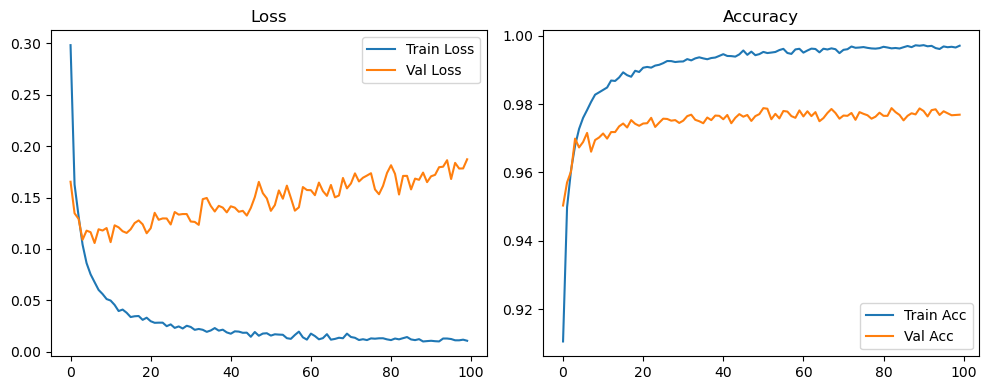

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4551, Acc: 0.8643 | Val Loss: 0.2027, Acc: 0.9382


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2808, Acc: 0.9194 | Val Loss: 0.1699, Acc: 0.9486


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2341, Acc: 0.9320 | Val Loss: 0.1424, Acc: 0.9585


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2097, Acc: 0.9396 | Val Loss: 0.1350, Acc: 0.9610


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1855, Acc: 0.9467 | Val Loss: 0.1260, Acc: 0.9645


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1705, Acc: 0.9502 | Val Loss: 0.1207, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1608, Acc: 0.9519 | Val Loss: 0.1221, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9563 | Val Loss: 0.1187, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1438, Acc: 0.9576 | Val Loss: 0.1206, Acc: 0.9664


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1358, Acc: 0.9587 | Val Loss: 0.1240, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9602 | Val Loss: 0.1125, Acc: 0.9694


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9619 | Val Loss: 0.1127, Acc: 0.9685


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9645 | Val Loss: 0.1087, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9650 | Val Loss: 0.1078, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9658 | Val Loss: 0.1163, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1120, Acc: 0.9664 | Val Loss: 0.1117, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9683 | Val Loss: 0.1113, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1057, Acc: 0.9685 | Val Loss: 0.1094, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9709 | Val Loss: 0.1155, Acc: 0.9732


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9700 | Val Loss: 0.1054, Acc: 0.9725


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9710 | Val Loss: 0.1066, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9714 | Val Loss: 0.1126, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9727 | Val Loss: 0.1113, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9729 | Val Loss: 0.1179, Acc: 0.9708


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9747 | Val Loss: 0.1113, Acc: 0.9733


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9735 | Val Loss: 0.1127, Acc: 0.9727


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9741 | Val Loss: 0.1159, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9728 | Val Loss: 0.1079, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9760 | Val Loss: 0.1070, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9754 | Val Loss: 0.1053, Acc: 0.9755


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9769 | Val Loss: 0.1188, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9761 | Val Loss: 0.1211, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9767 | Val Loss: 0.1112, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9763 | Val Loss: 0.1083, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9779 | Val Loss: 0.1151, Acc: 0.9741


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9766 | Val Loss: 0.1178, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.1262, Acc: 0.9729


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9779 | Val Loss: 0.1208, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9786 | Val Loss: 0.1143, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9784 | Val Loss: 0.1106, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9778 | Val Loss: 0.1157, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9797 | Val Loss: 0.1186, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1231, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.1247, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9811 | Val Loss: 0.1108, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9801 | Val Loss: 0.1153, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9809 | Val Loss: 0.1290, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9800 | Val Loss: 0.1252, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9793 | Val Loss: 0.1241, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9808 | Val Loss: 0.1315, Acc: 0.9738


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9809 | Val Loss: 0.1163, Acc: 0.9761


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9806 | Val Loss: 0.1258, Acc: 0.9733


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9826 | Val Loss: 0.1364, Acc: 0.9729


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9824 | Val Loss: 0.1300, Acc: 0.9748


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9810 | Val Loss: 0.1158, Acc: 0.9754


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9821 | Val Loss: 0.1296, Acc: 0.9745


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9811 | Val Loss: 0.1401, Acc: 0.9738


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9819 | Val Loss: 0.1336, Acc: 0.9741


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9826 | Val Loss: 0.1408, Acc: 0.9728


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9826 | Val Loss: 0.1265, Acc: 0.9739


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0537, Acc: 0.9840 | Val Loss: 0.1299, Acc: 0.9755


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9821 | Val Loss: 0.1285, Acc: 0.9742


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9840 | Val Loss: 0.1277, Acc: 0.9746


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9836 | Val Loss: 0.1170, Acc: 0.9751


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9839 | Val Loss: 0.1351, Acc: 0.9750


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9835 | Val Loss: 0.1286, Acc: 0.9751


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0565, Acc: 0.9835 | Val Loss: 0.1309, Acc: 0.9740


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9833 | Val Loss: 0.1265, Acc: 0.9743


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9825 | Val Loss: 0.1281, Acc: 0.9752


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9844 | Val Loss: 0.1283, Acc: 0.9756


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9844 | Val Loss: 0.1207, Acc: 0.9773


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9843 | Val Loss: 0.1328, Acc: 0.9751


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9824 | Val Loss: 0.1402, Acc: 0.9749


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9833 | Val Loss: 0.1266, Acc: 0.9753


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9855 | Val Loss: 0.1245, Acc: 0.9754


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9838 | Val Loss: 0.1342, Acc: 0.9753


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9852 | Val Loss: 0.1283, Acc: 0.9761


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9864 | Val Loss: 0.1406, Acc: 0.9750


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9852 | Val Loss: 0.1374, Acc: 0.9760


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9840 | Val Loss: 0.1232, Acc: 0.9767


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9862 | Val Loss: 0.1470, Acc: 0.9752


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9852 | Val Loss: 0.1494, Acc: 0.9748


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9842 | Val Loss: 0.1417, Acc: 0.9762


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9854 | Val Loss: 0.1324, Acc: 0.9758


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9840 | Val Loss: 0.1344, Acc: 0.9734


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9859 | Val Loss: 0.1328, Acc: 0.9762


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9856 | Val Loss: 0.1234, Acc: 0.9757


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9851 | Val Loss: 0.1331, Acc: 0.9758


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9864 | Val Loss: 0.1417, Acc: 0.9759


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9866 | Val Loss: 0.1346, Acc: 0.9768


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9866 | Val Loss: 0.1386, Acc: 0.9752


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9876 | Val Loss: 0.1493, Acc: 0.9741


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9863 | Val Loss: 0.1445, Acc: 0.9738


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9852 | Val Loss: 0.1354, Acc: 0.9749


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.1432, Acc: 0.9749


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9870 | Val Loss: 0.1442, Acc: 0.9752


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9860 | Val Loss: 0.1393, Acc: 0.9746


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9859 | Val Loss: 0.1322, Acc: 0.9757


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9865 | Val Loss: 0.1261, Acc: 0.9753


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9871 | Val Loss: 0.1383, Acc: 0.9760


Final Test Loss: 0.1323 Accuracy: 0.9791


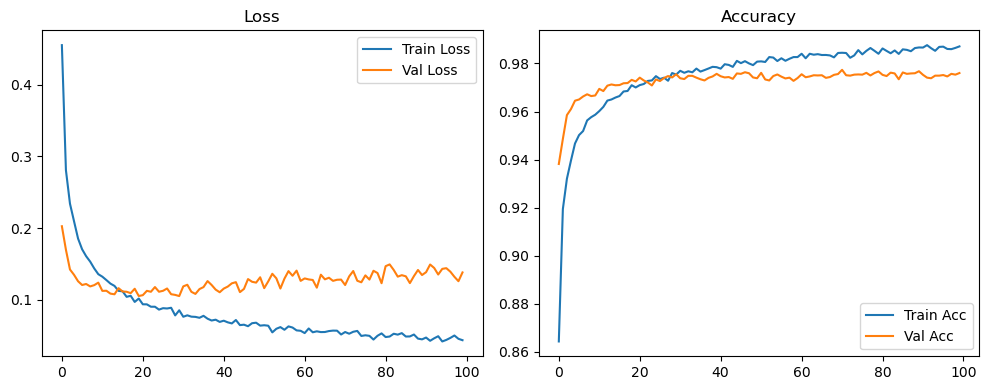

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2496, Acc: 0.9240 | Val Loss: 0.1657, Acc: 0.9512


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9620 | Val Loss: 0.1396, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1416, Acc: 0.9589


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9800 | Val Loss: 0.1304, Acc: 0.9646


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9826 | Val Loss: 0.1237, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1274, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.1278, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1291, Acc: 0.9684


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.1409, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.1421, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.1585, Acc: 0.9668


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1393, Acc: 0.9679


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1451, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1367, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1319, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.1405, Acc: 0.9714


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1345, Acc: 0.9710


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1336, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1389, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1355, Acc: 0.9730


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1548, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1588, Acc: 0.9692


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1487, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1655, Acc: 0.9716


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1288, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1823, Acc: 0.9693


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1639, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9729


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1460, Acc: 0.9733


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1550, Acc: 0.9718


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1712, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1680, Acc: 0.9722


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1457, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1835, Acc: 0.9718


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9970 | Val Loss: 0.1499, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1607, Acc: 0.9742


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1554, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1688, Acc: 0.9726


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1628, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1688, Acc: 0.9736


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1778, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1741, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1746, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1916, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1730, Acc: 0.9758


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1635, Acc: 0.9758


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1767, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1893, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1787, Acc: 0.9736


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1616, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1680, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1679, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1693, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1772, Acc: 0.9775


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1788, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1943, Acc: 0.9756


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2012, Acc: 0.9744


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1811, Acc: 0.9783


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1939, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1950, Acc: 0.9767


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2048, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2002, Acc: 0.9747


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1856, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1998, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1869, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1932, Acc: 0.9759


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1906, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1921, Acc: 0.9754


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1940, Acc: 0.9774


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1886, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.2028, Acc: 0.9752


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1922, Acc: 0.9783


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1967, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2189, Acc: 0.9752


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2100, Acc: 0.9759


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2121, Acc: 0.9761


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2260, Acc: 0.9755


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2334, Acc: 0.9755


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2165, Acc: 0.9759


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1939, Acc: 0.9770


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1989, Acc: 0.9766


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2024, Acc: 0.9768


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1989, Acc: 0.9776


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2085, Acc: 0.9769


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2058, Acc: 0.9768


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2039, Acc: 0.9767


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2027, Acc: 0.9774


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1994, Acc: 0.9776


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2067, Acc: 0.9777


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2107, Acc: 0.9773


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2117, Acc: 0.9774


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2179, Acc: 0.9779


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2120, Acc: 0.9774


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2146, Acc: 0.9785


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2150, Acc: 0.9781


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2107, Acc: 0.9787


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.2190, Acc: 0.9772


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2142, Acc: 0.9778


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2174, Acc: 0.9782


Final Test Loss: 0.1718 Accuracy: 0.9800


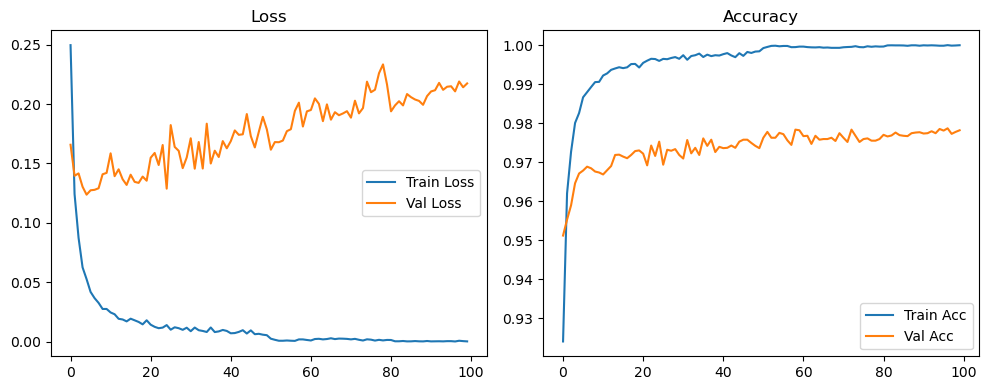

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2980, Acc: 0.9105 | Val Loss: 0.1653, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1626, Acc: 0.9498 | Val Loss: 0.1347, Acc: 0.9571


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9607 | Val Loss: 0.1293, Acc: 0.9603


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9678 | Val Loss: 0.1090, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9728 | Val Loss: 0.1178, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9760 | Val Loss: 0.1163, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9783 | Val Loss: 0.1058, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9807 | Val Loss: 0.1191, Acc: 0.9661


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9828 | Val Loss: 0.1179, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.1204, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 0.1066, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1230, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.1210, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1172, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1156, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.1191, Acc: 0.9743


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1252, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.1277, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.1240, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1153, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.1201, Acc: 0.9743


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1351, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.1284, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9913 | Val Loss: 0.1297, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.1296, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1238, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1359, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9926 | Val Loss: 0.1334, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1339, Acc: 0.9753


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9925 | Val Loss: 0.1339, Acc: 0.9745


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9925 | Val Loss: 0.1267, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1263, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1234, Acc: 0.9769


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.1484, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.1496, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1418, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.1364, Acc: 0.9761


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1419, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9936 | Val Loss: 0.1402, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1356, Acc: 0.9766


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.1415, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1402, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9941 | Val Loss: 0.1362, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1370, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9946 | Val Loss: 0.1325, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.1399, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9944 | Val Loss: 0.1504, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.1652, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1542, Acc: 0.9765


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1491, Acc: 0.9771


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1334, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1406, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1416, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1386, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1473, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1451, Acc: 0.9797


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1510, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1503, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1536, Acc: 0.9772


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1599, Acc: 0.9786


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1547, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1529, Acc: 0.9790


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1698, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1667, Acc: 0.9773


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1728, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.1536, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1625, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1542, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9978 | Val Loss: 0.1515, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1579, Acc: 0.9784


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1539, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1546, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1479, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1564, Acc: 0.9790


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1644, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1671, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1464, Acc: 0.9793


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1563, Acc: 0.9780


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1712, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1491, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1480, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1555, Acc: 0.9797


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1559, Acc: 0.9792


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1465, Acc: 0.9798


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1527, Acc: 0.9785


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1522, Acc: 0.9801


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1539, Acc: 0.9800


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1549, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1577, Acc: 0.9806


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1548, Acc: 0.9808


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1576, Acc: 0.9809


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1601, Acc: 0.9816


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1589, Acc: 0.9822


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1598, Acc: 0.9813


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1609, Acc: 0.9814


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1589, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1606, Acc: 0.9811


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1595, Acc: 0.9813


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1581, Acc: 0.9814


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1612, Acc: 0.9808


Final Test Loss: 0.1501 Accuracy: 0.9816


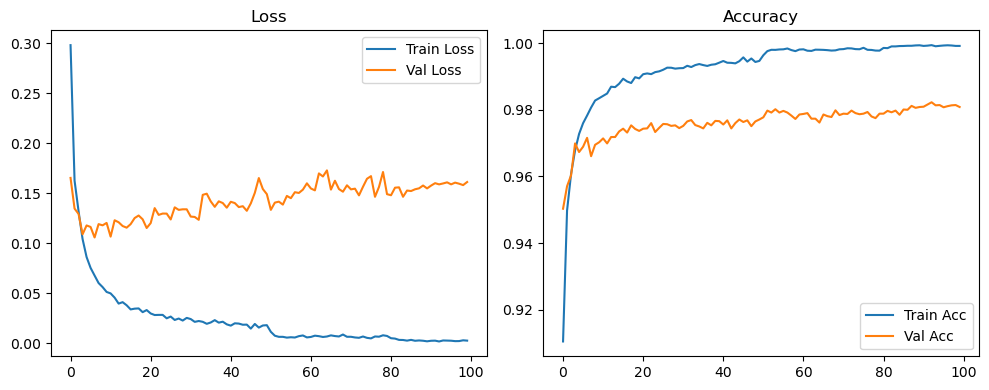

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4551, Acc: 0.8643 | Val Loss: 0.2027, Acc: 0.9382


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2808, Acc: 0.9194 | Val Loss: 0.1699, Acc: 0.9486


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2341, Acc: 0.9320 | Val Loss: 0.1424, Acc: 0.9585


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2097, Acc: 0.9396 | Val Loss: 0.1350, Acc: 0.9610


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1855, Acc: 0.9467 | Val Loss: 0.1260, Acc: 0.9645


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1705, Acc: 0.9502 | Val Loss: 0.1207, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1608, Acc: 0.9519 | Val Loss: 0.1221, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9563 | Val Loss: 0.1187, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1438, Acc: 0.9576 | Val Loss: 0.1206, Acc: 0.9664


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1358, Acc: 0.9587 | Val Loss: 0.1240, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9602 | Val Loss: 0.1125, Acc: 0.9694


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9619 | Val Loss: 0.1127, Acc: 0.9685


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9645 | Val Loss: 0.1087, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9650 | Val Loss: 0.1078, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9658 | Val Loss: 0.1163, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1120, Acc: 0.9664 | Val Loss: 0.1117, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9683 | Val Loss: 0.1113, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1057, Acc: 0.9685 | Val Loss: 0.1094, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9709 | Val Loss: 0.1155, Acc: 0.9732


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9700 | Val Loss: 0.1054, Acc: 0.9725


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9710 | Val Loss: 0.1066, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9714 | Val Loss: 0.1126, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9727 | Val Loss: 0.1113, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9729 | Val Loss: 0.1179, Acc: 0.9708


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9747 | Val Loss: 0.1113, Acc: 0.9733


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9735 | Val Loss: 0.1127, Acc: 0.9727


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9741 | Val Loss: 0.1159, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9728 | Val Loss: 0.1079, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9760 | Val Loss: 0.1070, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9754 | Val Loss: 0.1053, Acc: 0.9755


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9769 | Val Loss: 0.1188, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9761 | Val Loss: 0.1211, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9767 | Val Loss: 0.1112, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9763 | Val Loss: 0.1083, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9779 | Val Loss: 0.1151, Acc: 0.9741


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9766 | Val Loss: 0.1178, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.1262, Acc: 0.9729


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9779 | Val Loss: 0.1208, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9786 | Val Loss: 0.1143, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9784 | Val Loss: 0.1106, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9778 | Val Loss: 0.1157, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9797 | Val Loss: 0.1186, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1231, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.1247, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9811 | Val Loss: 0.1108, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9801 | Val Loss: 0.1153, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9809 | Val Loss: 0.1290, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9800 | Val Loss: 0.1252, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9793 | Val Loss: 0.1241, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9808 | Val Loss: 0.1315, Acc: 0.9738


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9836 | Val Loss: 0.1148, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 0.1160, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1257, Acc: 0.9764


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9879 | Val Loss: 0.1251, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9874 | Val Loss: 0.1198, Acc: 0.9756


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9871 | Val Loss: 0.1248, Acc: 0.9747


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9878 | Val Loss: 0.1279, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1285, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.1281, Acc: 0.9760


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9880 | Val Loss: 0.1233, Acc: 0.9755


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9885 | Val Loss: 0.1331, Acc: 0.9761


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.1272, Acc: 0.9746


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9886 | Val Loss: 0.1193, Acc: 0.9770


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.1253, Acc: 0.9748


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9891 | Val Loss: 0.1275, Acc: 0.9768


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1344, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9883 | Val Loss: 0.1338, Acc: 0.9753


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.1226, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.1236, Acc: 0.9758


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9889 | Val Loss: 0.1262, Acc: 0.9751


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9887 | Val Loss: 0.1279, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9886 | Val Loss: 0.1271, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9887 | Val Loss: 0.1247, Acc: 0.9762


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.1362, Acc: 0.9738


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9897 | Val Loss: 0.1268, Acc: 0.9756


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.1316, Acc: 0.9758


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9903 | Val Loss: 0.1253, Acc: 0.9754


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9892 | Val Loss: 0.1280, Acc: 0.9751


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.1352, Acc: 0.9760


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9893 | Val Loss: 0.1180, Acc: 0.9764


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9912 | Val Loss: 0.1223, Acc: 0.9764


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9912 | Val Loss: 0.1283, Acc: 0.9757


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1310, Acc: 0.9772


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9919 | Val Loss: 0.1296, Acc: 0.9769


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.1304, Acc: 0.9768


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.1305, Acc: 0.9771


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9913 | Val Loss: 0.1266, Acc: 0.9768


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.1251, Acc: 0.9775


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.1274, Acc: 0.9786


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9924 | Val Loss: 0.1204, Acc: 0.9781


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.1259, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9935 | Val Loss: 0.1300, Acc: 0.9778


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.1351, Acc: 0.9769


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.1347, Acc: 0.9778


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.1311, Acc: 0.9772


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.1333, Acc: 0.9782


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.1351, Acc: 0.9765


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.1346, Acc: 0.9762


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.1228, Acc: 0.9780


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.1280, Acc: 0.9775


Final Test Loss: 0.1195 Accuracy: 0.9796


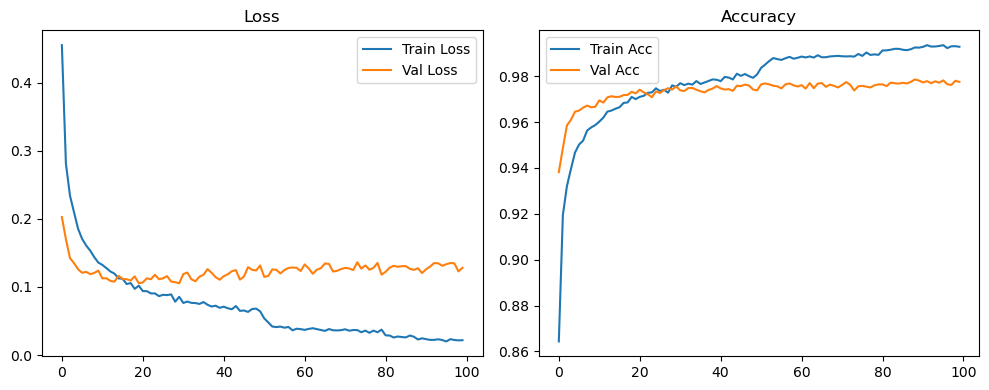

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2496, Acc: 0.9240 | Val Loss: 0.1657, Acc: 0.9512


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9620 | Val Loss: 0.1396, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1416, Acc: 0.9589


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9800 | Val Loss: 0.1304, Acc: 0.9646


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9826 | Val Loss: 0.1237, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1274, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.1278, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1291, Acc: 0.9684


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.1409, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.1421, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.1585, Acc: 0.9668


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1393, Acc: 0.9679


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1451, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1367, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1319, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.1405, Acc: 0.9714


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1345, Acc: 0.9710


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1336, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1389, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1355, Acc: 0.9730


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1548, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1588, Acc: 0.9692


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1487, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1655, Acc: 0.9716


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1288, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1823, Acc: 0.9693


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1639, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9729


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1460, Acc: 0.9733


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1550, Acc: 0.9718


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1712, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1680, Acc: 0.9722


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1457, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1835, Acc: 0.9718


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9970 | Val Loss: 0.1499, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1607, Acc: 0.9742


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1554, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1688, Acc: 0.9726


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1628, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1688, Acc: 0.9736


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1778, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1741, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1746, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1916, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1730, Acc: 0.9758


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1635, Acc: 0.9758


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1767, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1893, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1787, Acc: 0.9736


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1616, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1680, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1679, Acc: 0.9762


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1693, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1772, Acc: 0.9775


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1788, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1943, Acc: 0.9756


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2012, Acc: 0.9744


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1811, Acc: 0.9783


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1939, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1950, Acc: 0.9767


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.2048, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.2002, Acc: 0.9747


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1856, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1998, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1869, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1932, Acc: 0.9759


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1906, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1921, Acc: 0.9754


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1940, Acc: 0.9774


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1886, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.2028, Acc: 0.9752


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1922, Acc: 0.9783


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1967, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.2189, Acc: 0.9752


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.2100, Acc: 0.9759


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.2121, Acc: 0.9761


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.2260, Acc: 0.9755


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.2334, Acc: 0.9755


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.2165, Acc: 0.9759


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.2022, Acc: 0.9771


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2002, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2000, Acc: 0.9775


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1962, Acc: 0.9772


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2023, Acc: 0.9778


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1948, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1889, Acc: 0.9781


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1933, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1929, Acc: 0.9781


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1913, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1898, Acc: 0.9779


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1962, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1983, Acc: 0.9776


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1973, Acc: 0.9781


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2028, Acc: 0.9779


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1985, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2020, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2001, Acc: 0.9778


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2031, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2031, Acc: 0.9772


Final Test Loss: 0.1833 Accuracy: 0.9801


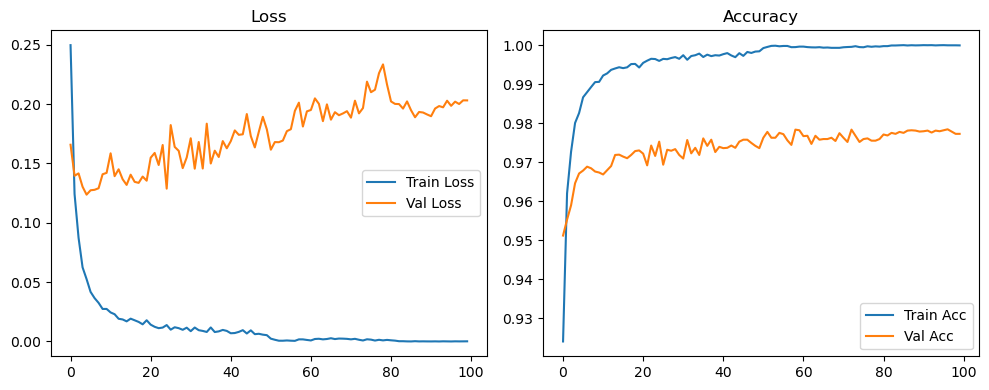

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2980, Acc: 0.9105 | Val Loss: 0.1653, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1626, Acc: 0.9498 | Val Loss: 0.1347, Acc: 0.9571


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9607 | Val Loss: 0.1293, Acc: 0.9603


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9678 | Val Loss: 0.1090, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9728 | Val Loss: 0.1178, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9760 | Val Loss: 0.1163, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9783 | Val Loss: 0.1058, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9807 | Val Loss: 0.1191, Acc: 0.9661


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9828 | Val Loss: 0.1179, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.1204, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 0.1066, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1230, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.1210, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1172, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1156, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.1191, Acc: 0.9743


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1252, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.1277, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.1240, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1153, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.1201, Acc: 0.9743


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1351, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.1284, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9913 | Val Loss: 0.1297, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.1296, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1238, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1359, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9926 | Val Loss: 0.1334, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1339, Acc: 0.9753


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9925 | Val Loss: 0.1339, Acc: 0.9745


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9925 | Val Loss: 0.1267, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1263, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1234, Acc: 0.9769


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.1484, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.1496, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1418, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.1364, Acc: 0.9761


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1419, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9936 | Val Loss: 0.1402, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1356, Acc: 0.9766


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.1415, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1402, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9941 | Val Loss: 0.1362, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1370, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9946 | Val Loss: 0.1325, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.1399, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9944 | Val Loss: 0.1504, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.1652, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1542, Acc: 0.9765


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1491, Acc: 0.9771


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1334, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1406, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1416, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1386, Acc: 0.9802


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1473, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1451, Acc: 0.9797


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1510, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1503, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1536, Acc: 0.9772


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1599, Acc: 0.9786


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1547, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1529, Acc: 0.9790


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1698, Acc: 0.9773


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1667, Acc: 0.9773


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1728, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9980 | Val Loss: 0.1536, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1625, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1542, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9978 | Val Loss: 0.1515, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1579, Acc: 0.9784


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1539, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1546, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1479, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1564, Acc: 0.9790


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1644, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1671, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1464, Acc: 0.9793


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1563, Acc: 0.9780


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1712, Acc: 0.9775


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1491, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1471, Acc: 0.9790


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1541, Acc: 0.9795


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1524, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1492, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1479, Acc: 0.9799


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1532, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1511, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1508, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1518, Acc: 0.9814


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1471, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1550, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1519, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1548, Acc: 0.9808


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1538, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1564, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1517, Acc: 0.9809


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1532, Acc: 0.9814


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1537, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1541, Acc: 0.9807


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1553, Acc: 0.9808


Final Test Loss: 0.1428 Accuracy: 0.9819


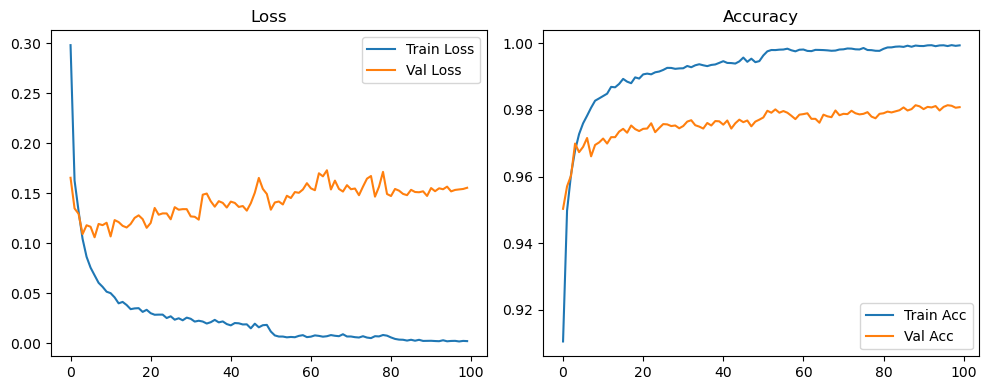

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4551, Acc: 0.8643 | Val Loss: 0.2027, Acc: 0.9382


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2808, Acc: 0.9194 | Val Loss: 0.1699, Acc: 0.9486


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2341, Acc: 0.9320 | Val Loss: 0.1424, Acc: 0.9585


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2097, Acc: 0.9396 | Val Loss: 0.1350, Acc: 0.9610


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1855, Acc: 0.9467 | Val Loss: 0.1260, Acc: 0.9645


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1705, Acc: 0.9502 | Val Loss: 0.1207, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1608, Acc: 0.9519 | Val Loss: 0.1221, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9563 | Val Loss: 0.1187, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1438, Acc: 0.9576 | Val Loss: 0.1206, Acc: 0.9664


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1358, Acc: 0.9587 | Val Loss: 0.1240, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9602 | Val Loss: 0.1125, Acc: 0.9694


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9619 | Val Loss: 0.1127, Acc: 0.9685


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9645 | Val Loss: 0.1087, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9650 | Val Loss: 0.1078, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9658 | Val Loss: 0.1163, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1120, Acc: 0.9664 | Val Loss: 0.1117, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9683 | Val Loss: 0.1113, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1057, Acc: 0.9685 | Val Loss: 0.1094, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9709 | Val Loss: 0.1155, Acc: 0.9732


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9700 | Val Loss: 0.1054, Acc: 0.9725


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9710 | Val Loss: 0.1066, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9714 | Val Loss: 0.1126, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9727 | Val Loss: 0.1113, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9729 | Val Loss: 0.1179, Acc: 0.9708


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9747 | Val Loss: 0.1113, Acc: 0.9733


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9735 | Val Loss: 0.1127, Acc: 0.9727


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9741 | Val Loss: 0.1159, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9728 | Val Loss: 0.1079, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9760 | Val Loss: 0.1070, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9754 | Val Loss: 0.1053, Acc: 0.9755


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9769 | Val Loss: 0.1188, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9761 | Val Loss: 0.1211, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9767 | Val Loss: 0.1112, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9763 | Val Loss: 0.1083, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9779 | Val Loss: 0.1151, Acc: 0.9741


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9766 | Val Loss: 0.1178, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.1262, Acc: 0.9729


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9779 | Val Loss: 0.1208, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9786 | Val Loss: 0.1143, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9784 | Val Loss: 0.1106, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9778 | Val Loss: 0.1157, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9797 | Val Loss: 0.1186, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1231, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.1247, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9811 | Val Loss: 0.1108, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9801 | Val Loss: 0.1153, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9809 | Val Loss: 0.1290, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9800 | Val Loss: 0.1252, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9793 | Val Loss: 0.1241, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9808 | Val Loss: 0.1315, Acc: 0.9738


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9836 | Val Loss: 0.1148, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9851 | Val Loss: 0.1160, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1257, Acc: 0.9764


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9879 | Val Loss: 0.1251, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9874 | Val Loss: 0.1198, Acc: 0.9756


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9871 | Val Loss: 0.1248, Acc: 0.9747


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9878 | Val Loss: 0.1279, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1285, Acc: 0.9768


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.1281, Acc: 0.9760


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9880 | Val Loss: 0.1233, Acc: 0.9755


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9885 | Val Loss: 0.1331, Acc: 0.9761


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9882 | Val Loss: 0.1272, Acc: 0.9746


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9886 | Val Loss: 0.1193, Acc: 0.9770


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9881 | Val Loss: 0.1253, Acc: 0.9748


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9891 | Val Loss: 0.1275, Acc: 0.9768


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1344, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9883 | Val Loss: 0.1338, Acc: 0.9753


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.1226, Acc: 0.9763


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.1236, Acc: 0.9758


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9889 | Val Loss: 0.1262, Acc: 0.9751


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9887 | Val Loss: 0.1279, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9886 | Val Loss: 0.1271, Acc: 0.9774


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9887 | Val Loss: 0.1247, Acc: 0.9762


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.1362, Acc: 0.9738


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9897 | Val Loss: 0.1268, Acc: 0.9756


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.1316, Acc: 0.9758


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9903 | Val Loss: 0.1253, Acc: 0.9754


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9892 | Val Loss: 0.1280, Acc: 0.9751


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9895 | Val Loss: 0.1352, Acc: 0.9760


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9893 | Val Loss: 0.1180, Acc: 0.9764


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.1201, Acc: 0.9762


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1272, Acc: 0.9757


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.1281, Acc: 0.9762


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9919 | Val Loss: 0.1251, Acc: 0.9762


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9920 | Val Loss: 0.1299, Acc: 0.9766


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1313, Acc: 0.9763


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9917 | Val Loss: 0.1270, Acc: 0.9767


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.1231, Acc: 0.9775


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.1285, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.1223, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1245, Acc: 0.9781


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.1274, Acc: 0.9769


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9932 | Val Loss: 0.1326, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.1307, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.1302, Acc: 0.9770


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1311, Acc: 0.9781


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9935 | Val Loss: 0.1316, Acc: 0.9779


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.1278, Acc: 0.9774


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.1224, Acc: 0.9776


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.1255, Acc: 0.9779


Final Test Loss: 0.1184 Accuracy: 0.9793


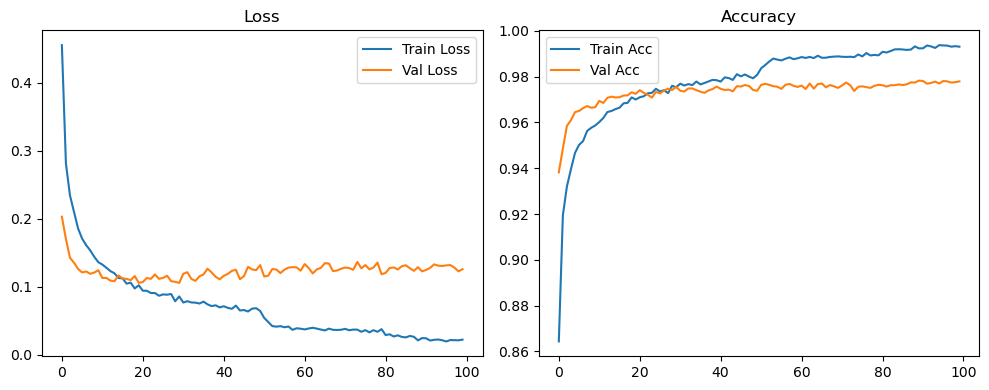

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2496, Acc: 0.9240 | Val Loss: 0.1657, Acc: 0.9512


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1242, Acc: 0.9620 | Val Loss: 0.1396, Acc: 0.9553


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9726 | Val Loss: 0.1416, Acc: 0.9589


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9800 | Val Loss: 0.1304, Acc: 0.9646


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9826 | Val Loss: 0.1237, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9866 | Val Loss: 0.1274, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.1278, Acc: 0.9688


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1291, Acc: 0.9684


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.1409, Acc: 0.9676


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.1421, Acc: 0.9673


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.1585, Acc: 0.9668


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1393, Acc: 0.9679


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1451, Acc: 0.9690


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1367, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1319, Acc: 0.9719


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9941 | Val Loss: 0.1405, Acc: 0.9714


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1345, Acc: 0.9710


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9951 | Val Loss: 0.1336, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1389, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1355, Acc: 0.9730


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1548, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1588, Acc: 0.9692


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1487, Acc: 0.9742


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1655, Acc: 0.9716


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9960 | Val Loss: 0.1288, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1823, Acc: 0.9693


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.1639, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.1606, Acc: 0.9729


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1460, Acc: 0.9733


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1550, Acc: 0.9718


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1712, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1456, Acc: 0.9757


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1680, Acc: 0.9722


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1457, Acc: 0.9737


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.1835, Acc: 0.9718


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9970 | Val Loss: 0.1499, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1607, Acc: 0.9742


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1554, Acc: 0.9758


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1688, Acc: 0.9726


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1628, Acc: 0.9739


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1688, Acc: 0.9736


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1778, Acc: 0.9737


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1741, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1746, Acc: 0.9737


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1916, Acc: 0.9752


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1730, Acc: 0.9758


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1635, Acc: 0.9758


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1767, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1893, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1787, Acc: 0.9736


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1602, Acc: 0.9769


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1578, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1590, Acc: 0.9770


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1558, Acc: 0.9782


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1585, Acc: 0.9788


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1582, Acc: 0.9784


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1573, Acc: 0.9782


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1603, Acc: 0.9784


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1613, Acc: 0.9782


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1623, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9774


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1659, Acc: 0.9791


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1673, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1717, Acc: 0.9781


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1782, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1846, Acc: 0.9774


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1810, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1902, Acc: 0.9774


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1893, Acc: 0.9773


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1963, Acc: 0.9780


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1910, Acc: 0.9780


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1962, Acc: 0.9780


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1934, Acc: 0.9780


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2067, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2040, Acc: 0.9785


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1976, Acc: 0.9795


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2067, Acc: 0.9782


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2160, Acc: 0.9777


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2204, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2136, Acc: 0.9773


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2158, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2201, Acc: 0.9774


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2082, Acc: 0.9781


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2191, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2115, Acc: 0.9773


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2082, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2145, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2156, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2057, Acc: 0.9787


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2100, Acc: 0.9793


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2074, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2153, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2089, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2056, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2068, Acc: 0.9786


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2102, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2127, Acc: 0.9785


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2134, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2115, Acc: 0.9785


Final Test Loss: 0.1704 Accuracy: 0.9807


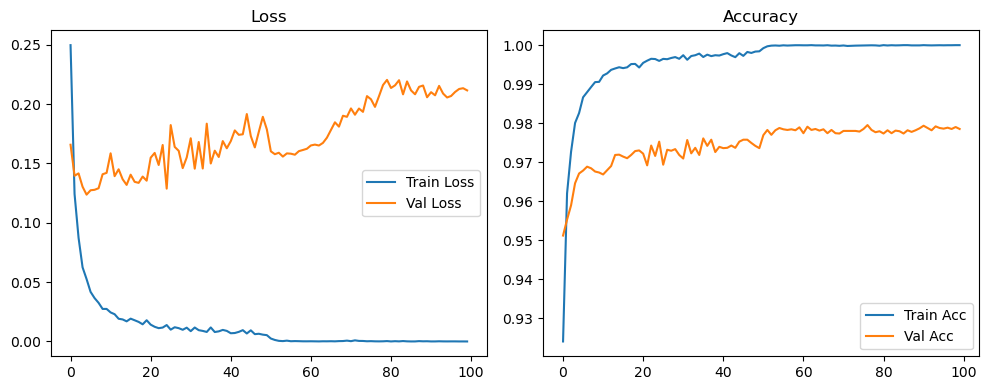

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2980, Acc: 0.9105 | Val Loss: 0.1653, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1626, Acc: 0.9498 | Val Loss: 0.1347, Acc: 0.9571


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1321, Acc: 0.9607 | Val Loss: 0.1293, Acc: 0.9603


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1043, Acc: 0.9678 | Val Loss: 0.1090, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0863, Acc: 0.9728 | Val Loss: 0.1178, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9760 | Val Loss: 0.1163, Acc: 0.9689


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9783 | Val Loss: 0.1058, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9807 | Val Loss: 0.1191, Acc: 0.9661


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9828 | Val Loss: 0.1179, Acc: 0.9695


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.1204, Acc: 0.9702


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9842 | Val Loss: 0.1066, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9849 | Val Loss: 0.1230, Acc: 0.9699


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.1210, Acc: 0.9718


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9868 | Val Loss: 0.1172, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.1156, Acc: 0.9735


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.1191, Acc: 0.9743


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1252, Acc: 0.9732


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.1277, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.1240, Acc: 0.9742


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1153, Acc: 0.9737


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9907 | Val Loss: 0.1201, Acc: 0.9743


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9909 | Val Loss: 0.1351, Acc: 0.9744


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.1284, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9913 | Val Loss: 0.1297, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.1296, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1238, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1359, Acc: 0.9757


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9926 | Val Loss: 0.1334, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1339, Acc: 0.9753


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9925 | Val Loss: 0.1339, Acc: 0.9745


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9925 | Val Loss: 0.1267, Acc: 0.9752


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1263, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1234, Acc: 0.9769


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.1484, Acc: 0.9754


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.1496, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1418, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9931 | Val Loss: 0.1364, Acc: 0.9761


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.1419, Acc: 0.9753


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9936 | Val Loss: 0.1402, Acc: 0.9767


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9941 | Val Loss: 0.1356, Acc: 0.9766


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.1415, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9941 | Val Loss: 0.1402, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9941 | Val Loss: 0.1362, Acc: 0.9744


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1370, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9946 | Val Loss: 0.1325, Acc: 0.9771


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9957 | Val Loss: 0.1399, Acc: 0.9763


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9944 | Val Loss: 0.1504, Acc: 0.9768


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.1652, Acc: 0.9751


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1542, Acc: 0.9765


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9946 | Val Loss: 0.1491, Acc: 0.9771


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1321, Acc: 0.9786


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1365, Acc: 0.9786


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1402, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1411, Acc: 0.9799


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1407, Acc: 0.9789


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1379, Acc: 0.9796


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1345, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1368, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1379, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1383, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1397, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1442, Acc: 0.9811


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1455, Acc: 0.9806


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1427, Acc: 0.9807


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1391, Acc: 0.9812


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1417, Acc: 0.9809


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1423, Acc: 0.9810


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1388, Acc: 0.9807


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1380, Acc: 0.9812


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1381, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1426, Acc: 0.9813


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1528, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1427, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1401, Acc: 0.9826


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1369, Acc: 0.9814


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1488, Acc: 0.9814


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1418, Acc: 0.9814


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1424, Acc: 0.9824


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1405, Acc: 0.9815


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1414, Acc: 0.9816


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1442, Acc: 0.9809


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1450, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1462, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1445, Acc: 0.9819


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1414, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1440, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1456, Acc: 0.9821


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1418, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1485, Acc: 0.9820


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1459, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1452, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1456, Acc: 0.9824


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1452, Acc: 0.9817


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1490, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1498, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1502, Acc: 0.9815


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1540, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1514, Acc: 0.9817


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1508, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1564, Acc: 0.9805


Final Test Loss: 0.1478 Accuracy: 0.9835


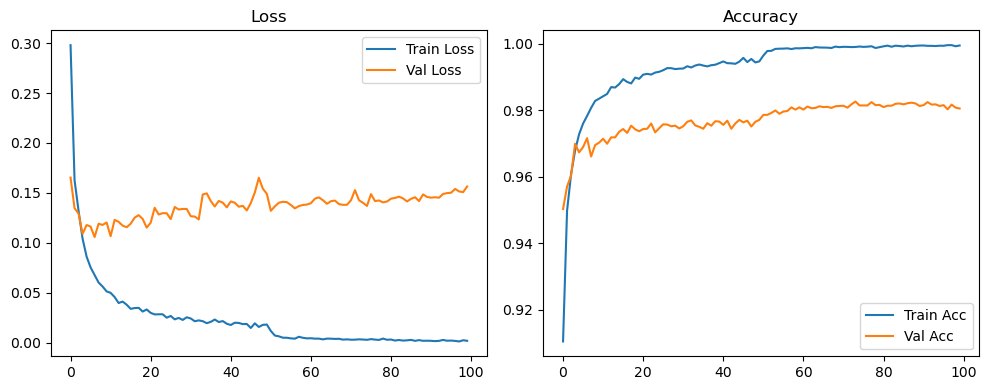

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4551, Acc: 0.8643 | Val Loss: 0.2027, Acc: 0.9382


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2808, Acc: 0.9194 | Val Loss: 0.1699, Acc: 0.9486


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2341, Acc: 0.9320 | Val Loss: 0.1424, Acc: 0.9585


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2097, Acc: 0.9396 | Val Loss: 0.1350, Acc: 0.9610


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1855, Acc: 0.9467 | Val Loss: 0.1260, Acc: 0.9645


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1705, Acc: 0.9502 | Val Loss: 0.1207, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1608, Acc: 0.9519 | Val Loss: 0.1221, Acc: 0.9663


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1533, Acc: 0.9563 | Val Loss: 0.1187, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1438, Acc: 0.9576 | Val Loss: 0.1206, Acc: 0.9664


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1358, Acc: 0.9587 | Val Loss: 0.1240, Acc: 0.9667


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1323, Acc: 0.9602 | Val Loss: 0.1125, Acc: 0.9694


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1276, Acc: 0.9619 | Val Loss: 0.1127, Acc: 0.9685


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1227, Acc: 0.9645 | Val Loss: 0.1087, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9650 | Val Loss: 0.1078, Acc: 0.9712


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1125, Acc: 0.9658 | Val Loss: 0.1163, Acc: 0.9709


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1120, Acc: 0.9664 | Val Loss: 0.1117, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1042, Acc: 0.9683 | Val Loss: 0.1113, Acc: 0.9718


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1057, Acc: 0.9685 | Val Loss: 0.1094, Acc: 0.9718


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9709 | Val Loss: 0.1155, Acc: 0.9732


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9700 | Val Loss: 0.1054, Acc: 0.9725


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9710 | Val Loss: 0.1066, Acc: 0.9741


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0938, Acc: 0.9714 | Val Loss: 0.1126, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9727 | Val Loss: 0.1113, Acc: 0.9721


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9729 | Val Loss: 0.1179, Acc: 0.9708


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9747 | Val Loss: 0.1113, Acc: 0.9733


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9735 | Val Loss: 0.1127, Acc: 0.9727


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0880, Acc: 0.9741 | Val Loss: 0.1159, Acc: 0.9739


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9728 | Val Loss: 0.1079, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9760 | Val Loss: 0.1070, Acc: 0.9742


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9754 | Val Loss: 0.1053, Acc: 0.9755


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9769 | Val Loss: 0.1188, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9761 | Val Loss: 0.1211, Acc: 0.9735


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9767 | Val Loss: 0.1112, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9763 | Val Loss: 0.1083, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9779 | Val Loss: 0.1151, Acc: 0.9741


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9766 | Val Loss: 0.1178, Acc: 0.9734


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9772 | Val Loss: 0.1262, Acc: 0.9729


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9779 | Val Loss: 0.1208, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9786 | Val Loss: 0.1143, Acc: 0.9746


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9784 | Val Loss: 0.1106, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9778 | Val Loss: 0.1157, Acc: 0.9747


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9797 | Val Loss: 0.1186, Acc: 0.9742


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9794 | Val Loss: 0.1231, Acc: 0.9743


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9786 | Val Loss: 0.1247, Acc: 0.9736


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9811 | Val Loss: 0.1108, Acc: 0.9758


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9801 | Val Loss: 0.1153, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9809 | Val Loss: 0.1290, Acc: 0.9763


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9800 | Val Loss: 0.1252, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0682, Acc: 0.9793 | Val Loss: 0.1241, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9808 | Val Loss: 0.1315, Acc: 0.9738


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0536, Acc: 0.9838 | Val Loss: 0.1145, Acc: 0.9764


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9860 | Val Loss: 0.1176, Acc: 0.9763


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9879 | Val Loss: 0.1195, Acc: 0.9763


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9883 | Val Loss: 0.1263, Acc: 0.9763


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9884 | Val Loss: 0.1194, Acc: 0.9767


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9888 | Val Loss: 0.1207, Acc: 0.9770


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9892 | Val Loss: 0.1247, Acc: 0.9766


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.1248, Acc: 0.9771


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.1237, Acc: 0.9766


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9891 | Val Loss: 0.1212, Acc: 0.9771


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.1266, Acc: 0.9760


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.1248, Acc: 0.9758


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.1230, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.1244, Acc: 0.9771


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1239, Acc: 0.9770


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9911 | Val Loss: 0.1308, Acc: 0.9766


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9906 | Val Loss: 0.1286, Acc: 0.9762


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.1246, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.1210, Acc: 0.9779


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1250, Acc: 0.9773


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9908 | Val Loss: 0.1282, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9910 | Val Loss: 0.1208, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.1214, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9909 | Val Loss: 0.1251, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.1224, Acc: 0.9769


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.1281, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.1272, Acc: 0.9775


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.1263, Acc: 0.9773


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.1256, Acc: 0.9765


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.1231, Acc: 0.9771


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9926 | Val Loss: 0.1267, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.1352, Acc: 0.9771


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1305, Acc: 0.9774


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.1294, Acc: 0.9777


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9922 | Val Loss: 0.1259, Acc: 0.9760


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1251, Acc: 0.9771


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9925 | Val Loss: 0.1224, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.1204, Acc: 0.9781


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.1254, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.1199, Acc: 0.9773


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9928 | Val Loss: 0.1213, Acc: 0.9771


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9936 | Val Loss: 0.1235, Acc: 0.9767


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1279, Acc: 0.9771


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.1225, Acc: 0.9776


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.1248, Acc: 0.9769


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1270, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.1289, Acc: 0.9768


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1247, Acc: 0.9780


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1223, Acc: 0.9775


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.1233, Acc: 0.9776


Final Test Loss: 0.1172 Accuracy: 0.9800


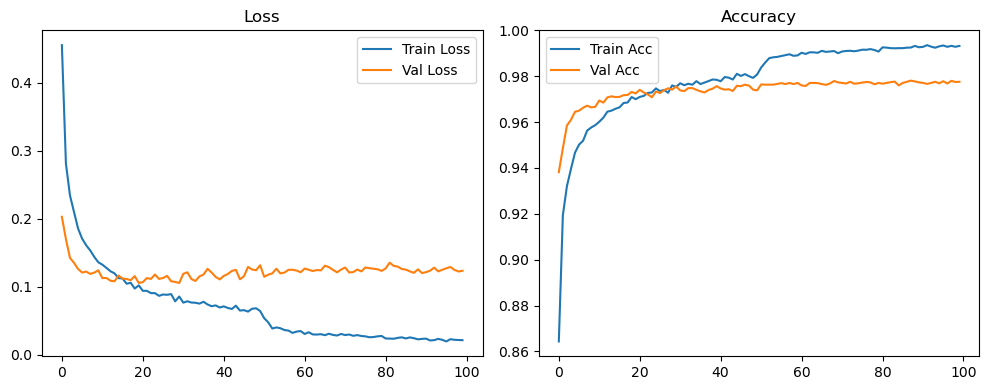

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2449, Acc: 0.9267 | Val Loss: 0.1611, Acc: 0.9512


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1138, Acc: 0.9654 | Val Loss: 0.1351, Acc: 0.9577


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9724 | Val Loss: 0.1346, Acc: 0.9605


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9792 | Val Loss: 0.1343, Acc: 0.9626


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9828 | Val Loss: 0.1280, Acc: 0.9650


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9859 | Val Loss: 0.1471, Acc: 0.9629


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9882 | Val Loss: 0.1367, Acc: 0.9659


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.1294, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1249, Acc: 0.9700


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.1148, Acc: 0.9714


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1292, Acc: 0.9686


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.1304, Acc: 0.9715


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.1421, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.1381, Acc: 0.9694


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1422, Acc: 0.9691


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1403, Acc: 0.9698


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1321, Acc: 0.9720


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1374, Acc: 0.9711


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1381, Acc: 0.9718


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1430, Acc: 0.9710


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1266, Acc: 0.9719


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1615, Acc: 0.9659


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1533, Acc: 0.9695


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1362, Acc: 0.9727


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1249, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1328, Acc: 0.9749


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1584, Acc: 0.9710


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1404, Acc: 0.9729


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1470, Acc: 0.9716


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1611, Acc: 0.9691


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.1452, Acc: 0.9718


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1444, Acc: 0.9733


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1363, Acc: 0.9743


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1370, Acc: 0.9750


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1548, Acc: 0.9725


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1426, Acc: 0.9727


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1544, Acc: 0.9712


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1449, Acc: 0.9738


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1508, Acc: 0.9731


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1429, Acc: 0.9757


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1583, Acc: 0.9722


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1307, Acc: 0.9763


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1460, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1406, Acc: 0.9742


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1469, Acc: 0.9739


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1416, Acc: 0.9759


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1334, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1476, Acc: 0.9758


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1503, Acc: 0.9743


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1392, Acc: 0.9771


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1433, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1559, Acc: 0.9770


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1542, Acc: 0.9751


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1458, Acc: 0.9732


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1391, Acc: 0.9753


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1332, Acc: 0.9760


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1572, Acc: 0.9747


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1456, Acc: 0.9758


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1700, Acc: 0.9745


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1565, Acc: 0.9748


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1394, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1570, Acc: 0.9758


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1476, Acc: 0.9774


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1445, Acc: 0.9757


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1709, Acc: 0.9744


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1520, Acc: 0.9752


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1709, Acc: 0.9760


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1784, Acc: 0.9750


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1652, Acc: 0.9750


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1535, Acc: 0.9734


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1623, Acc: 0.9755


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1654, Acc: 0.9755


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1593, Acc: 0.9742


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1523, Acc: 0.9778


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1837, Acc: 0.9758


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1722, Acc: 0.9736


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1540, Acc: 0.9770


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1675, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1665, Acc: 0.9776


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1725, Acc: 0.9758


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1768, Acc: 0.9738


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1764, Acc: 0.9740


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1721, Acc: 0.9764


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1702, Acc: 0.9767


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1759, Acc: 0.9763


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1582, Acc: 0.9783


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1688, Acc: 0.9751


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1645, Acc: 0.9768


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1742, Acc: 0.9749


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1485, Acc: 0.9778


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1675, Acc: 0.9767


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1578, Acc: 0.9778


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1717, Acc: 0.9770


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1777, Acc: 0.9768


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1822, Acc: 0.9767


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.2056, Acc: 0.9732


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1806, Acc: 0.9753


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1900, Acc: 0.9749


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1766, Acc: 0.9761


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1938, Acc: 0.9759


Final Test Loss: 0.1795 Accuracy: 0.9772


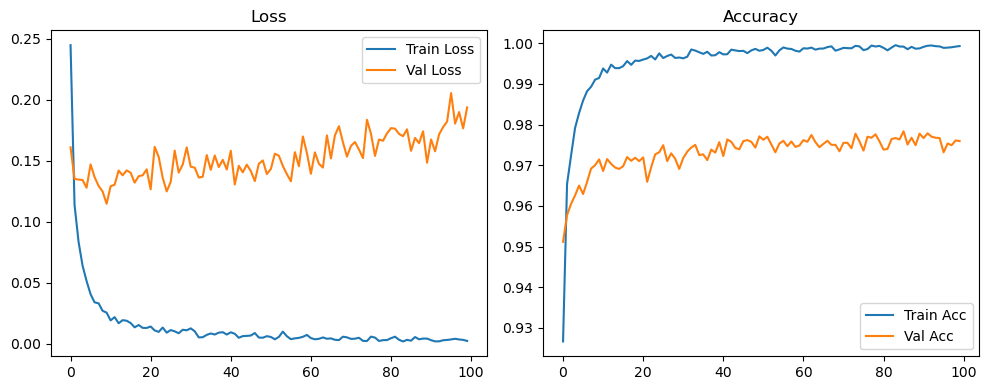

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2930, Acc: 0.9124 | Val Loss: 0.1594, Acc: 0.9517


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1556, Acc: 0.9525 | Val Loss: 0.1412, Acc: 0.9562


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1231, Acc: 0.9628 | Val Loss: 0.1238, Acc: 0.9644


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0959, Acc: 0.9702 | Val Loss: 0.1243, Acc: 0.9637


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0834, Acc: 0.9739 | Val Loss: 0.1120, Acc: 0.9687


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9762 | Val Loss: 0.1138, Acc: 0.9681


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9787 | Val Loss: 0.1113, Acc: 0.9695


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9812 | Val Loss: 0.1101, Acc: 0.9695


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9808 | Val Loss: 0.1140, Acc: 0.9683


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9832 | Val Loss: 0.1118, Acc: 0.9704


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9842 | Val Loss: 0.1051, Acc: 0.9728


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.1063, Acc: 0.9743


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.1157, Acc: 0.9708


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9873 | Val Loss: 0.1117, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9871 | Val Loss: 0.1026, Acc: 0.9759


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1100, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.1090, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.1150, Acc: 0.9712


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.1182, Acc: 0.9728


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1235, Acc: 0.9712


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.1191, Acc: 0.9719


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9906 | Val Loss: 0.1238, Acc: 0.9717


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.1134, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1281, Acc: 0.9722


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.1361, Acc: 0.9713


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1213, Acc: 0.9717


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.1263, Acc: 0.9738


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.1179, Acc: 0.9751


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1174, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1340, Acc: 0.9728


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9934 | Val Loss: 0.1166, Acc: 0.9755


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.1105, Acc: 0.9757


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1204, Acc: 0.9740


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.1316, Acc: 0.9748


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1247, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.1192, Acc: 0.9745


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1227, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1086, Acc: 0.9774


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9939 | Val Loss: 0.1179, Acc: 0.9760


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1172, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.1212, Acc: 0.9748


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1163, Acc: 0.9759


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1297, Acc: 0.9745


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1237, Acc: 0.9760


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1217, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1266, Acc: 0.9749


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1242, Acc: 0.9760


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1368, Acc: 0.9752


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.1331, Acc: 0.9749


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1302, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1312, Acc: 0.9752


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.1336, Acc: 0.9749


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1237, Acc: 0.9774


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1367, Acc: 0.9767


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9955 | Val Loss: 0.1347, Acc: 0.9758


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9964 | Val Loss: 0.1283, Acc: 0.9757


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1335, Acc: 0.9767


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1287, Acc: 0.9766


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1317, Acc: 0.9767


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1305, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1509, Acc: 0.9752


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1478, Acc: 0.9737


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1373, Acc: 0.9763


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1430, Acc: 0.9756


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1374, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1443, Acc: 0.9760


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1437, Acc: 0.9759


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9971 | Val Loss: 0.1417, Acc: 0.9773


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.1391, Acc: 0.9766


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1476, Acc: 0.9750


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1396, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1461, Acc: 0.9761


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1481, Acc: 0.9774


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1389, Acc: 0.9752


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1378, Acc: 0.9762


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1339, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1496, Acc: 0.9759


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1455, Acc: 0.9775


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1400, Acc: 0.9770


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1389, Acc: 0.9769


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1509, Acc: 0.9759


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1446, Acc: 0.9758


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1434, Acc: 0.9767


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1428, Acc: 0.9774


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1478, Acc: 0.9760


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1439, Acc: 0.9778


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1588, Acc: 0.9765


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1490, Acc: 0.9782


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1534, Acc: 0.9776


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1532, Acc: 0.9768


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1447, Acc: 0.9772


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1508, Acc: 0.9770


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9974 | Val Loss: 0.1441, Acc: 0.9795


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1501, Acc: 0.9773


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1485, Acc: 0.9778


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1541, Acc: 0.9774


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1573, Acc: 0.9775


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.1455, Acc: 0.9775


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1460, Acc: 0.9758


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1552, Acc: 0.9774


Final Test Loss: 0.1363 Accuracy: 0.9814


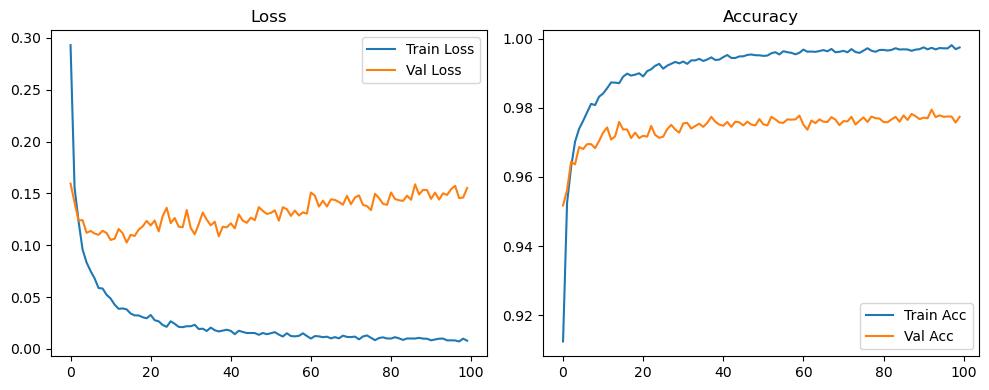

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4568, Acc: 0.8657 | Val Loss: 0.2022, Acc: 0.9400


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2713, Acc: 0.9199 | Val Loss: 0.1709, Acc: 0.9467


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2274, Acc: 0.9338 | Val Loss: 0.1447, Acc: 0.9571


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2001, Acc: 0.9417 | Val Loss: 0.1376, Acc: 0.9590


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1796, Acc: 0.9473 | Val Loss: 0.1291, Acc: 0.9633


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1697, Acc: 0.9497 | Val Loss: 0.1223, Acc: 0.9634


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1571, Acc: 0.9529 | Val Loss: 0.1222, Acc: 0.9645


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1470, Acc: 0.9563 | Val Loss: 0.1127, Acc: 0.9680


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1416, Acc: 0.9571 | Val Loss: 0.1143, Acc: 0.9672


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1346, Acc: 0.9596 | Val Loss: 0.1142, Acc: 0.9677


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1309, Acc: 0.9605 | Val Loss: 0.1094, Acc: 0.9677


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1263, Acc: 0.9620 | Val Loss: 0.1126, Acc: 0.9688


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9640 | Val Loss: 0.1097, Acc: 0.9696


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1166, Acc: 0.9639 | Val Loss: 0.1005, Acc: 0.9721


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1067, Acc: 0.9667 | Val Loss: 0.1102, Acc: 0.9693


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1062, Acc: 0.9671 | Val Loss: 0.1026, Acc: 0.9704


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1043, Acc: 0.9676 | Val Loss: 0.1129, Acc: 0.9677


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9697 | Val Loss: 0.1066, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0973, Acc: 0.9717 | Val Loss: 0.1032, Acc: 0.9720


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9707 | Val Loss: 0.1064, Acc: 0.9714


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9715 | Val Loss: 0.1061, Acc: 0.9725


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9717 | Val Loss: 0.1067, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0876, Acc: 0.9725 | Val Loss: 0.1100, Acc: 0.9724


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 0.1077, Acc: 0.9718


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0820, Acc: 0.9741 | Val Loss: 0.1122, Acc: 0.9726


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9736 | Val Loss: 0.1052, Acc: 0.9725


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0802, Acc: 0.9749 | Val Loss: 0.1136, Acc: 0.9727


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9754 | Val Loss: 0.1035, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9766 | Val Loss: 0.1059, Acc: 0.9730


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9773 | Val Loss: 0.1024, Acc: 0.9732


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9761 | Val Loss: 0.1066, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9769 | Val Loss: 0.1108, Acc: 0.9732


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9773 | Val Loss: 0.1110, Acc: 0.9728


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0699, Acc: 0.9780 | Val Loss: 0.1081, Acc: 0.9745


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9794 | Val Loss: 0.1134, Acc: 0.9732


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9782 | Val Loss: 0.1076, Acc: 0.9741


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9794 | Val Loss: 0.1140, Acc: 0.9737


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9790 | Val Loss: 0.1120, Acc: 0.9731


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.1104, Acc: 0.9746


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9793 | Val Loss: 0.1111, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9796 | Val Loss: 0.1066, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9789 | Val Loss: 0.1067, Acc: 0.9741


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9796 | Val Loss: 0.1120, Acc: 0.9728


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9809 | Val Loss: 0.1084, Acc: 0.9733


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9807 | Val Loss: 0.1136, Acc: 0.9746


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9816 | Val Loss: 0.1117, Acc: 0.9747


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9810 | Val Loss: 0.1092, Acc: 0.9746


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9815 | Val Loss: 0.1196, Acc: 0.9722


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.1152, Acc: 0.9743


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9820 | Val Loss: 0.1115, Acc: 0.9742


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 0.1041, Acc: 0.9767


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9814 | Val Loss: 0.1127, Acc: 0.9751


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9829 | Val Loss: 0.1189, Acc: 0.9740


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9839 | Val Loss: 0.1186, Acc: 0.9744


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9835 | Val Loss: 0.1119, Acc: 0.9756


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9840 | Val Loss: 0.1130, Acc: 0.9751


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9828 | Val Loss: 0.1159, Acc: 0.9743


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9835 | Val Loss: 0.1207, Acc: 0.9742


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0546, Acc: 0.9830 | Val Loss: 0.1201, Acc: 0.9748


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 0.1196, Acc: 0.9742


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9842 | Val Loss: 0.1200, Acc: 0.9739


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9845 | Val Loss: 0.1255, Acc: 0.9741


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0485, Acc: 0.9844 | Val Loss: 0.1213, Acc: 0.9745


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 0.1197, Acc: 0.9749


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9845 | Val Loss: 0.1169, Acc: 0.9766


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9839 | Val Loss: 0.1180, Acc: 0.9738


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.1212, Acc: 0.9748


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9857 | Val Loss: 0.1248, Acc: 0.9743


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.1232, Acc: 0.9749


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9852 | Val Loss: 0.1201, Acc: 0.9749


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9844 | Val Loss: 0.1255, Acc: 0.9746


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9857 | Val Loss: 0.1226, Acc: 0.9748


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9856 | Val Loss: 0.1257, Acc: 0.9755


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9858 | Val Loss: 0.1265, Acc: 0.9728


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.1278, Acc: 0.9740


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9856 | Val Loss: 0.1229, Acc: 0.9747


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9872 | Val Loss: 0.1275, Acc: 0.9752


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9862 | Val Loss: 0.1280, Acc: 0.9754


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.1223, Acc: 0.9752


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9847 | Val Loss: 0.1155, Acc: 0.9747


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9868 | Val Loss: 0.1282, Acc: 0.9760


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.1216, Acc: 0.9754


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9875 | Val Loss: 0.1236, Acc: 0.9748


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9859 | Val Loss: 0.1190, Acc: 0.9748


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9852 | Val Loss: 0.1261, Acc: 0.9732


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9874 | Val Loss: 0.1346, Acc: 0.9747


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9860 | Val Loss: 0.1271, Acc: 0.9748


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9867 | Val Loss: 0.1276, Acc: 0.9757


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9881 | Val Loss: 0.1425, Acc: 0.9740


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9878 | Val Loss: 0.1284, Acc: 0.9760


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.1390, Acc: 0.9738


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9878 | Val Loss: 0.1337, Acc: 0.9736


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1310, Acc: 0.9734


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9871 | Val Loss: 0.1285, Acc: 0.9745


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9875 | Val Loss: 0.1267, Acc: 0.9742


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9879 | Val Loss: 0.1268, Acc: 0.9742


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.1307, Acc: 0.9751


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9875 | Val Loss: 0.1217, Acc: 0.9755


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.1373, Acc: 0.9737


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.1288, Acc: 0.9742


Final Test Loss: 0.1197 Accuracy: 0.9767


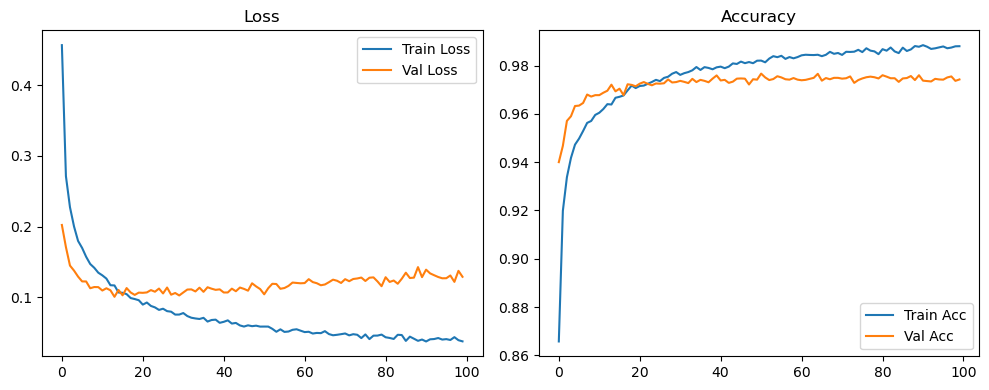

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2449, Acc: 0.9267 | Val Loss: 0.1611, Acc: 0.9512


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1138, Acc: 0.9654 | Val Loss: 0.1351, Acc: 0.9577


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9724 | Val Loss: 0.1346, Acc: 0.9605


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0640, Acc: 0.9792 | Val Loss: 0.1343, Acc: 0.9626


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9828 | Val Loss: 0.1280, Acc: 0.9650


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9859 | Val Loss: 0.1471, Acc: 0.9629


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9882 | Val Loss: 0.1367, Acc: 0.9659


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9893 | Val Loss: 0.1294, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1249, Acc: 0.9700


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.1148, Acc: 0.9714


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1292, Acc: 0.9686


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.1304, Acc: 0.9715


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.1421, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.1381, Acc: 0.9694


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.1422, Acc: 0.9691


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1403, Acc: 0.9698


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1321, Acc: 0.9720


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1374, Acc: 0.9711


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1381, Acc: 0.9718


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1430, Acc: 0.9710


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1266, Acc: 0.9719


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1615, Acc: 0.9659


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1533, Acc: 0.9695


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1362, Acc: 0.9727


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1249, Acc: 0.9732


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1328, Acc: 0.9749


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1584, Acc: 0.9710


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1404, Acc: 0.9729


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1470, Acc: 0.9716


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1611, Acc: 0.9691


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9963 | Val Loss: 0.1452, Acc: 0.9718


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1444, Acc: 0.9733


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1363, Acc: 0.9743


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1370, Acc: 0.9750


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1548, Acc: 0.9725


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1426, Acc: 0.9727


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1544, Acc: 0.9712


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1449, Acc: 0.9738


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1508, Acc: 0.9731


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1429, Acc: 0.9757


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1583, Acc: 0.9722


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1307, Acc: 0.9763


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1460, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1406, Acc: 0.9742


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1469, Acc: 0.9739


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1416, Acc: 0.9759


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1334, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1476, Acc: 0.9758


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1503, Acc: 0.9743


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1392, Acc: 0.9771


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1334, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1388, Acc: 0.9786


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1312, Acc: 0.9791


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1314, Acc: 0.9801


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1381, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1379, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1368, Acc: 0.9791


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1380, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1397, Acc: 0.9793


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1391, Acc: 0.9800


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1423, Acc: 0.9797


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1539, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1545, Acc: 0.9770


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1441, Acc: 0.9799


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1632, Acc: 0.9763


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.1555, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1612, Acc: 0.9771


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1632, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1638, Acc: 0.9779


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1580, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1666, Acc: 0.9761


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1697, Acc: 0.9779


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1630, Acc: 0.9773


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1693, Acc: 0.9783


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1816, Acc: 0.9753


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1674, Acc: 0.9775


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1702, Acc: 0.9770


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1793, Acc: 0.9764


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1734, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1709, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1622, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1649, Acc: 0.9779


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1679, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1661, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1708, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1680, Acc: 0.9786


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1696, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1735, Acc: 0.9780


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1675, Acc: 0.9776


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1703, Acc: 0.9777


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1708, Acc: 0.9790


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1727, Acc: 0.9786


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1633, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1683, Acc: 0.9790


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1711, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1711, Acc: 0.9795


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1742, Acc: 0.9787


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1738, Acc: 0.9783


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1709, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1709, Acc: 0.9781


Final Test Loss: 0.1616 Accuracy: 0.9800


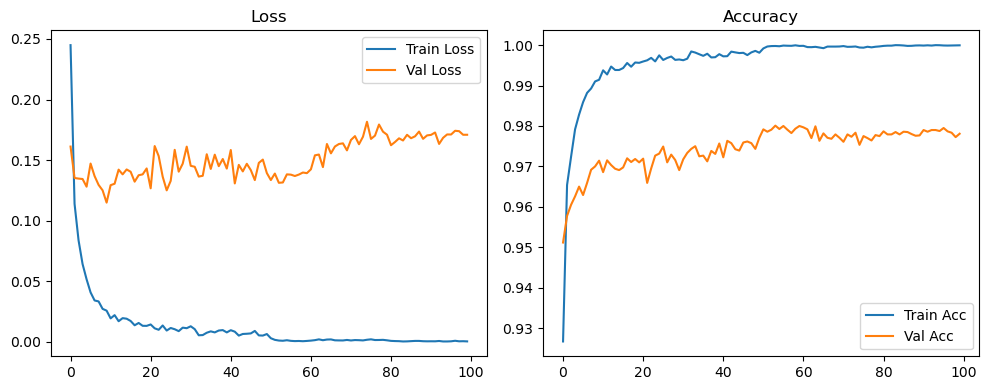

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2930, Acc: 0.9124 | Val Loss: 0.1594, Acc: 0.9517


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1556, Acc: 0.9525 | Val Loss: 0.1412, Acc: 0.9562


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1231, Acc: 0.9628 | Val Loss: 0.1238, Acc: 0.9644


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0959, Acc: 0.9702 | Val Loss: 0.1243, Acc: 0.9637


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0834, Acc: 0.9739 | Val Loss: 0.1120, Acc: 0.9687


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9762 | Val Loss: 0.1138, Acc: 0.9681


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9787 | Val Loss: 0.1113, Acc: 0.9695


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9812 | Val Loss: 0.1101, Acc: 0.9695


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9808 | Val Loss: 0.1140, Acc: 0.9683


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9832 | Val Loss: 0.1118, Acc: 0.9704


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9842 | Val Loss: 0.1051, Acc: 0.9728


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.1063, Acc: 0.9743


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.1157, Acc: 0.9708


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9873 | Val Loss: 0.1117, Acc: 0.9718


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9871 | Val Loss: 0.1026, Acc: 0.9759


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1100, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.1090, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.1150, Acc: 0.9712


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.1182, Acc: 0.9728


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.1235, Acc: 0.9712


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.1191, Acc: 0.9719


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9906 | Val Loss: 0.1238, Acc: 0.9717


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.1134, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1281, Acc: 0.9722


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.1361, Acc: 0.9713


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.1213, Acc: 0.9717


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.1263, Acc: 0.9738


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.1179, Acc: 0.9751


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9933 | Val Loss: 0.1174, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1340, Acc: 0.9728


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9934 | Val Loss: 0.1166, Acc: 0.9755


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9928 | Val Loss: 0.1105, Acc: 0.9757


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1204, Acc: 0.9740


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.1316, Acc: 0.9748


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1247, Acc: 0.9754


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.1192, Acc: 0.9745


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1227, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1086, Acc: 0.9774


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9939 | Val Loss: 0.1179, Acc: 0.9760


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1172, Acc: 0.9752


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.1212, Acc: 0.9748


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.1163, Acc: 0.9759


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1297, Acc: 0.9745


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1237, Acc: 0.9760


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.1217, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1266, Acc: 0.9749


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1242, Acc: 0.9760


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1368, Acc: 0.9752


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.1331, Acc: 0.9749


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1302, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1212, Acc: 0.9781


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9971 | Val Loss: 0.1192, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9977 | Val Loss: 0.1244, Acc: 0.9783


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1257, Acc: 0.9778


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1287, Acc: 0.9773


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1266, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1261, Acc: 0.9786


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1325, Acc: 0.9780


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1269, Acc: 0.9783


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1312, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1354, Acc: 0.9786


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1365, Acc: 0.9777


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1293, Acc: 0.9796


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1458, Acc: 0.9778


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1401, Acc: 0.9785


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1445, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1429, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1422, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1419, Acc: 0.9772


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1473, Acc: 0.9771


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1382, Acc: 0.9780


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1417, Acc: 0.9784


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1394, Acc: 0.9773


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1327, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1367, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1358, Acc: 0.9780


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1362, Acc: 0.9773


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1463, Acc: 0.9775


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1460, Acc: 0.9787


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1349, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1432, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1431, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1424, Acc: 0.9782


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1391, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1424, Acc: 0.9779


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1432, Acc: 0.9787


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1441, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1370, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1452, Acc: 0.9780


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1379, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1447, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1400, Acc: 0.9784


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1407, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1484, Acc: 0.9783


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1507, Acc: 0.9781


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1463, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1409, Acc: 0.9791


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1410, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1477, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1466, Acc: 0.9793


Final Test Loss: 0.1274 Accuracy: 0.9804


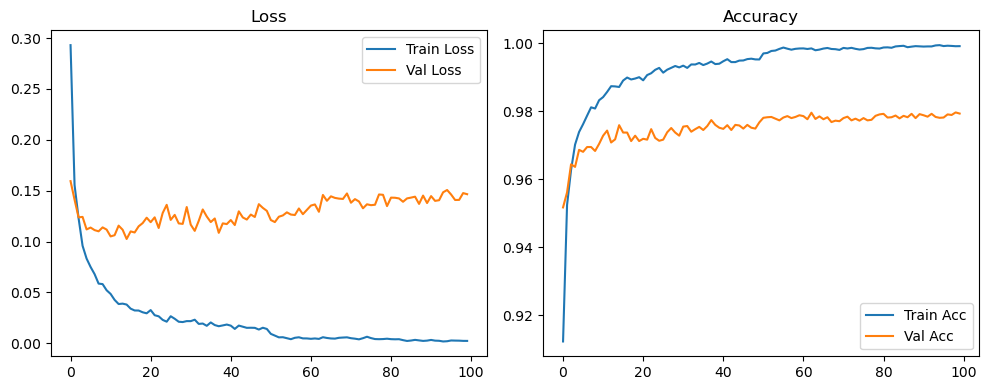

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4568, Acc: 0.8657 | Val Loss: 0.2022, Acc: 0.9400


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2713, Acc: 0.9199 | Val Loss: 0.1709, Acc: 0.9467


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2274, Acc: 0.9338 | Val Loss: 0.1447, Acc: 0.9571


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2001, Acc: 0.9417 | Val Loss: 0.1376, Acc: 0.9590


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1796, Acc: 0.9473 | Val Loss: 0.1291, Acc: 0.9633


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1697, Acc: 0.9497 | Val Loss: 0.1223, Acc: 0.9634


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1571, Acc: 0.9529 | Val Loss: 0.1222, Acc: 0.9645


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1470, Acc: 0.9563 | Val Loss: 0.1127, Acc: 0.9680


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1416, Acc: 0.9571 | Val Loss: 0.1143, Acc: 0.9672


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1346, Acc: 0.9596 | Val Loss: 0.1142, Acc: 0.9677


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1309, Acc: 0.9605 | Val Loss: 0.1094, Acc: 0.9677


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1263, Acc: 0.9620 | Val Loss: 0.1126, Acc: 0.9688


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1169, Acc: 0.9640 | Val Loss: 0.1097, Acc: 0.9696


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1166, Acc: 0.9639 | Val Loss: 0.1005, Acc: 0.9721


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1067, Acc: 0.9667 | Val Loss: 0.1102, Acc: 0.9693


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1062, Acc: 0.9671 | Val Loss: 0.1026, Acc: 0.9704


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1043, Acc: 0.9676 | Val Loss: 0.1129, Acc: 0.9677


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9697 | Val Loss: 0.1066, Acc: 0.9722


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0973, Acc: 0.9717 | Val Loss: 0.1032, Acc: 0.9720


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0957, Acc: 0.9707 | Val Loss: 0.1064, Acc: 0.9714


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9715 | Val Loss: 0.1061, Acc: 0.9725


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9717 | Val Loss: 0.1067, Acc: 0.9732


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0876, Acc: 0.9725 | Val Loss: 0.1100, Acc: 0.9724


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0855, Acc: 0.9732 | Val Loss: 0.1077, Acc: 0.9718


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0820, Acc: 0.9741 | Val Loss: 0.1122, Acc: 0.9726


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9736 | Val Loss: 0.1052, Acc: 0.9725


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0802, Acc: 0.9749 | Val Loss: 0.1136, Acc: 0.9727


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0794, Acc: 0.9754 | Val Loss: 0.1035, Acc: 0.9742


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9766 | Val Loss: 0.1059, Acc: 0.9730


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0754, Acc: 0.9773 | Val Loss: 0.1024, Acc: 0.9732


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9761 | Val Loss: 0.1066, Acc: 0.9737


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9769 | Val Loss: 0.1108, Acc: 0.9732


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9773 | Val Loss: 0.1110, Acc: 0.9728


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0699, Acc: 0.9780 | Val Loss: 0.1081, Acc: 0.9745


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9794 | Val Loss: 0.1134, Acc: 0.9732


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9782 | Val Loss: 0.1076, Acc: 0.9741


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0655, Acc: 0.9794 | Val Loss: 0.1140, Acc: 0.9737


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9790 | Val Loss: 0.1120, Acc: 0.9731


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.1104, Acc: 0.9746


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9793 | Val Loss: 0.1111, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0651, Acc: 0.9796 | Val Loss: 0.1066, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9789 | Val Loss: 0.1067, Acc: 0.9741


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9796 | Val Loss: 0.1120, Acc: 0.9728


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9809 | Val Loss: 0.1084, Acc: 0.9733


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9807 | Val Loss: 0.1136, Acc: 0.9746


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9816 | Val Loss: 0.1117, Acc: 0.9747


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9810 | Val Loss: 0.1092, Acc: 0.9746


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9815 | Val Loss: 0.1196, Acc: 0.9722


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.1152, Acc: 0.9743


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0583, Acc: 0.9820 | Val Loss: 0.1115, Acc: 0.9742


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9845 | Val Loss: 0.1100, Acc: 0.9767


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9854 | Val Loss: 0.1100, Acc: 0.9761


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9860 | Val Loss: 0.1123, Acc: 0.9763


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9883 | Val Loss: 0.1135, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.1122, Acc: 0.9768


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9880 | Val Loss: 0.1178, Acc: 0.9757


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9885 | Val Loss: 0.1185, Acc: 0.9753


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9877 | Val Loss: 0.1175, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.1184, Acc: 0.9769


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.1225, Acc: 0.9762


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9891 | Val Loss: 0.1178, Acc: 0.9764


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9895 | Val Loss: 0.1221, Acc: 0.9749


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1138, Acc: 0.9771


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1156, Acc: 0.9756


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9900 | Val Loss: 0.1167, Acc: 0.9765


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.1187, Acc: 0.9762


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9901 | Val Loss: 0.1205, Acc: 0.9760


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.1238, Acc: 0.9752


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.1197, Acc: 0.9764


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9903 | Val Loss: 0.1203, Acc: 0.9759


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.1226, Acc: 0.9765


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9903 | Val Loss: 0.1193, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.1228, Acc: 0.9766


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9898 | Val Loss: 0.1245, Acc: 0.9767


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.1209, Acc: 0.9761


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9904 | Val Loss: 0.1194, Acc: 0.9765


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.1234, Acc: 0.9760


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9909 | Val Loss: 0.1210, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9897 | Val Loss: 0.1207, Acc: 0.9757


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9893 | Val Loss: 0.1172, Acc: 0.9746


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9907 | Val Loss: 0.1186, Acc: 0.9758


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1229, Acc: 0.9759


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.1231, Acc: 0.9754


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.1236, Acc: 0.9755


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9920 | Val Loss: 0.1246, Acc: 0.9750


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.1250, Acc: 0.9763


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.1193, Acc: 0.9766


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.1213, Acc: 0.9771


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9929 | Val Loss: 0.1235, Acc: 0.9772


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.1202, Acc: 0.9775


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.1256, Acc: 0.9763


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.1219, Acc: 0.9764


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.1260, Acc: 0.9756


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.1214, Acc: 0.9765


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.1224, Acc: 0.9761


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1223, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1252, Acc: 0.9764


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9932 | Val Loss: 0.1224, Acc: 0.9766


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9925 | Val Loss: 0.1216, Acc: 0.9770


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.1223, Acc: 0.9768


Final Test Loss: 0.1186 Accuracy: 0.9787


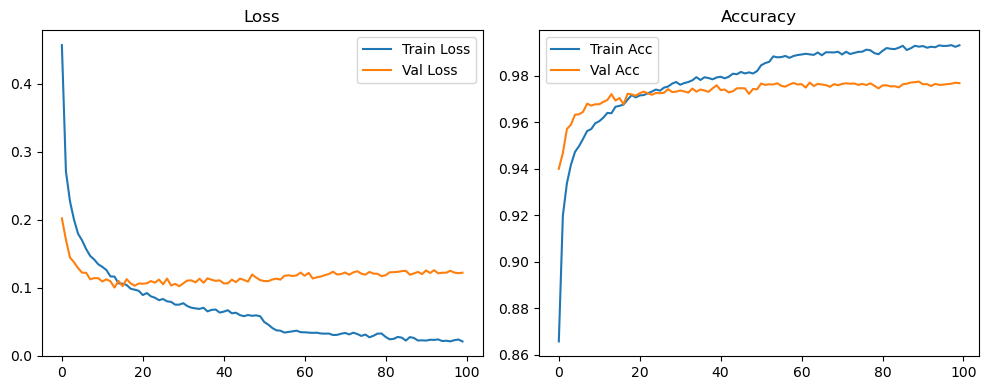

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2607, Acc: 0.9241 | Val Loss: 0.1560, Acc: 0.9517


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1084, Acc: 0.9669 | Val Loss: 0.1317, Acc: 0.9603


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0755, Acc: 0.9758 | Val Loss: 0.1240, Acc: 0.9627


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0587, Acc: 0.9814 | Val Loss: 0.1243, Acc: 0.9638


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.1169, Acc: 0.9679


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9875 | Val Loss: 0.1292, Acc: 0.9667


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.1181, Acc: 0.9680


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9897 | Val Loss: 0.1229, Acc: 0.9666


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9907 | Val Loss: 0.1232, Acc: 0.9683


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.1185, Acc: 0.9702


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.1201, Acc: 0.9701


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1207, Acc: 0.9707


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1378, Acc: 0.9670


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.1180, Acc: 0.9731


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1288, Acc: 0.9707


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1265, Acc: 0.9692


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1234, Acc: 0.9696


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1274, Acc: 0.9714


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1246, Acc: 0.9718


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1193, Acc: 0.9726


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9954 | Val Loss: 0.1250, Acc: 0.9715


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1208, Acc: 0.9730


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1294, Acc: 0.9728


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1337, Acc: 0.9717


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1372, Acc: 0.9707


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1258, Acc: 0.9715


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.1334, Acc: 0.9720


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1293, Acc: 0.9714


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1224, Acc: 0.9738


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1329, Acc: 0.9702


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1344, Acc: 0.9742


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1383, Acc: 0.9720


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1214, Acc: 0.9734


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1266, Acc: 0.9745


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1243, Acc: 0.9737


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1242, Acc: 0.9739


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1254, Acc: 0.9748


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1282, Acc: 0.9751


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1362, Acc: 0.9727


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9749


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1382, Acc: 0.9734


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1473, Acc: 0.9707


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1403, Acc: 0.9728


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1368, Acc: 0.9744


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1359, Acc: 0.9738


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1229, Acc: 0.9749


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1337, Acc: 0.9748


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1354, Acc: 0.9738


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1419, Acc: 0.9747


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1334, Acc: 0.9748


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1406, Acc: 0.9748


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1469, Acc: 0.9736


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1363, Acc: 0.9737


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1395, Acc: 0.9730


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1397, Acc: 0.9735


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1245, Acc: 0.9756


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1330, Acc: 0.9745


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1363, Acc: 0.9743


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1410, Acc: 0.9742


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1411, Acc: 0.9742


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1476, Acc: 0.9725


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1319, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1352, Acc: 0.9751


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1376, Acc: 0.9740


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1380, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1370, Acc: 0.9750


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1311, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1377, Acc: 0.9771


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1380, Acc: 0.9753


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1397, Acc: 0.9750


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1522, Acc: 0.9740


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1483, Acc: 0.9749


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1609, Acc: 0.9741


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1497, Acc: 0.9745


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1414, Acc: 0.9754


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1430, Acc: 0.9760


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1432, Acc: 0.9762


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1415, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1341, Acc: 0.9779


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1473, Acc: 0.9758


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1454, Acc: 0.9718


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1406, Acc: 0.9753


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1673, Acc: 0.9732


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1470, Acc: 0.9752


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1459, Acc: 0.9760


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1468, Acc: 0.9744


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1637, Acc: 0.9730


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1476, Acc: 0.9740


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1461, Acc: 0.9754


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1475, Acc: 0.9748


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1374, Acc: 0.9768


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1460, Acc: 0.9769


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1571, Acc: 0.9748


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1581, Acc: 0.9751


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1446, Acc: 0.9768


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1634, Acc: 0.9748


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1702, Acc: 0.9745


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1600, Acc: 0.9741


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1570, Acc: 0.9767


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1640, Acc: 0.9747


Final Test Loss: 0.1563 Accuracy: 0.9763


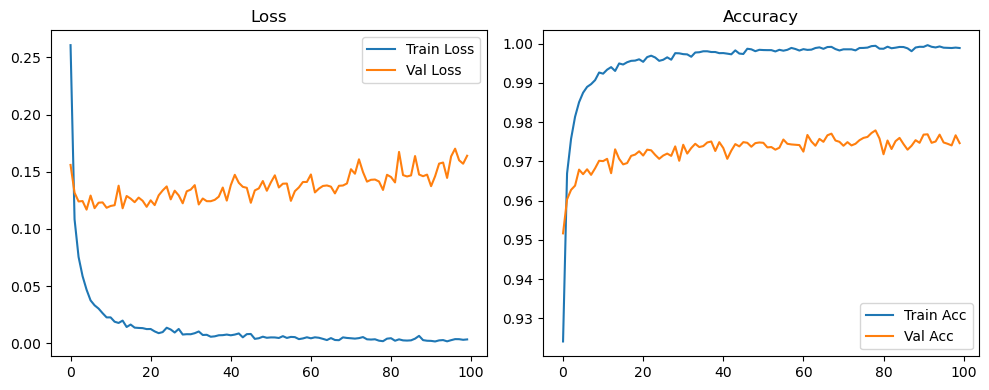

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3273, Acc: 0.9053 | Val Loss: 0.1624, Acc: 0.9493


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1523, Acc: 0.9527 | Val Loss: 0.1318, Acc: 0.9607


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1180, Acc: 0.9636 | Val Loss: 0.1266, Acc: 0.9633


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0997, Acc: 0.9691 | Val Loss: 0.1158, Acc: 0.9663


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0844, Acc: 0.9734 | Val Loss: 0.1108, Acc: 0.9671


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0753, Acc: 0.9758 | Val Loss: 0.1159, Acc: 0.9662


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0667, Acc: 0.9785 | Val Loss: 0.1112, Acc: 0.9684


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9809 | Val Loss: 0.1085, Acc: 0.9694


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9811 | Val Loss: 0.1075, Acc: 0.9699


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9813 | Val Loss: 0.1085, Acc: 0.9701


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 0.1103, Acc: 0.9724


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9847 | Val Loss: 0.1131, Acc: 0.9699


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9866 | Val Loss: 0.1194, Acc: 0.9677


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1081, Acc: 0.9712


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.1089, Acc: 0.9727


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.1108, Acc: 0.9710


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9878 | Val Loss: 0.1119, Acc: 0.9711


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.1102, Acc: 0.9726


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.1127, Acc: 0.9714


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9897 | Val Loss: 0.1132, Acc: 0.9705


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.1095, Acc: 0.9731


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9908 | Val Loss: 0.1177, Acc: 0.9712


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1164, Acc: 0.9727


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1254, Acc: 0.9700


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.1158, Acc: 0.9727


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.1184, Acc: 0.9711


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9917 | Val Loss: 0.1249, Acc: 0.9716


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1134, Acc: 0.9734


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1235, Acc: 0.9711


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1285, Acc: 0.9715


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.1175, Acc: 0.9742


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1195, Acc: 0.9725


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.1135, Acc: 0.9753


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.1220, Acc: 0.9732


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.1181, Acc: 0.9735


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1132, Acc: 0.9740


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1166, Acc: 0.9738


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1170, Acc: 0.9745


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.1262, Acc: 0.9727


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.1216, Acc: 0.9732


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1206, Acc: 0.9735


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1136, Acc: 0.9748


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.1213, Acc: 0.9732


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1158, Acc: 0.9732


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1280, Acc: 0.9718


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1176, Acc: 0.9759


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1193, Acc: 0.9739


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1204, Acc: 0.9757


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1217, Acc: 0.9753


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1199, Acc: 0.9744


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1252, Acc: 0.9742


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1220, Acc: 0.9742


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.1293, Acc: 0.9753


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1289, Acc: 0.9729


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1240, Acc: 0.9741


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1327, Acc: 0.9744


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1305, Acc: 0.9743


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1273, Acc: 0.9741


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1370, Acc: 0.9739


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1275, Acc: 0.9743


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1263, Acc: 0.9758


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1189, Acc: 0.9756


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1300, Acc: 0.9746


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1258, Acc: 0.9753


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1291, Acc: 0.9748


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1339, Acc: 0.9737


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1318, Acc: 0.9745


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1231, Acc: 0.9750


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1211, Acc: 0.9765


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1336, Acc: 0.9748


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1336, Acc: 0.9742


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1351, Acc: 0.9739


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.1279, Acc: 0.9744


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1302, Acc: 0.9753


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1294, Acc: 0.9751


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1334, Acc: 0.9750


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1332, Acc: 0.9757


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1433, Acc: 0.9746


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1346, Acc: 0.9750


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1283, Acc: 0.9760


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1374, Acc: 0.9745


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1341, Acc: 0.9743


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1378, Acc: 0.9754


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9750


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1297, Acc: 0.9757


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1308, Acc: 0.9765


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1427, Acc: 0.9741


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1360, Acc: 0.9754


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1337, Acc: 0.9755


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1335, Acc: 0.9752


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1412, Acc: 0.9739


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1297, Acc: 0.9754


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1336, Acc: 0.9756


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1302, Acc: 0.9768


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1341, Acc: 0.9752


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1346, Acc: 0.9765


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1376, Acc: 0.9762


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1317, Acc: 0.9768


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1334, Acc: 0.9762


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1366, Acc: 0.9757


Final Test Loss: 0.1278 Accuracy: 0.9789


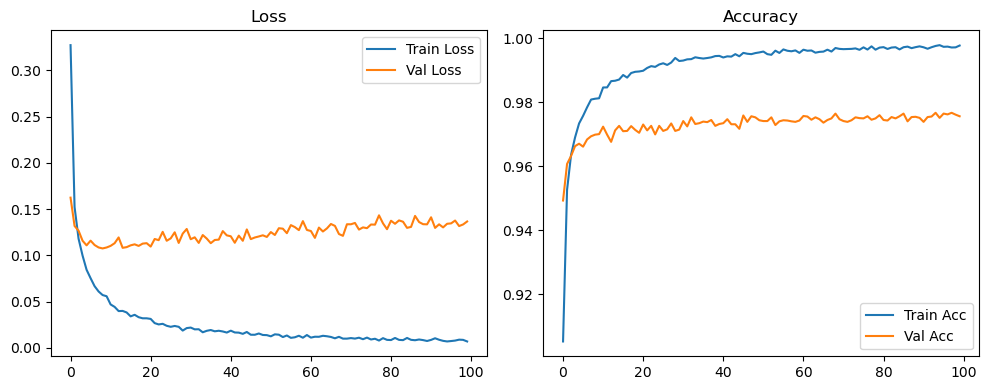

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5270, Acc: 0.8460 | Val Loss: 0.2044, Acc: 0.9400


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2735, Acc: 0.9209 | Val Loss: 0.1690, Acc: 0.9497


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2289, Acc: 0.9334 | Val Loss: 0.1503, Acc: 0.9558


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2037, Acc: 0.9394 | Val Loss: 0.1413, Acc: 0.9567


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1844, Acc: 0.9451 | Val Loss: 0.1285, Acc: 0.9619


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1708, Acc: 0.9499 | Val Loss: 0.1281, Acc: 0.9624


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1611, Acc: 0.9509 | Val Loss: 0.1289, Acc: 0.9627


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1506, Acc: 0.9551 | Val Loss: 0.1202, Acc: 0.9651


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1470, Acc: 0.9560 | Val Loss: 0.1180, Acc: 0.9653


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1420, Acc: 0.9567 | Val Loss: 0.1137, Acc: 0.9667


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1339, Acc: 0.9592 | Val Loss: 0.1115, Acc: 0.9679


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1259, Acc: 0.9616 | Val Loss: 0.1163, Acc: 0.9664


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1249, Acc: 0.9616 | Val Loss: 0.1109, Acc: 0.9683


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1185, Acc: 0.9629 | Val Loss: 0.1096, Acc: 0.9687


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1161, Acc: 0.9646 | Val Loss: 0.1069, Acc: 0.9692


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1101, Acc: 0.9674 | Val Loss: 0.1073, Acc: 0.9710


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1099, Acc: 0.9659 | Val Loss: 0.1091, Acc: 0.9692


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1072, Acc: 0.9675 | Val Loss: 0.1045, Acc: 0.9710


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1041, Acc: 0.9686 | Val Loss: 0.1030, Acc: 0.9720


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1018, Acc: 0.9686 | Val Loss: 0.1037, Acc: 0.9715


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9703 | Val Loss: 0.1053, Acc: 0.9712


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9698 | Val Loss: 0.1103, Acc: 0.9699


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0945, Acc: 0.9697 | Val Loss: 0.1080, Acc: 0.9713


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0941, Acc: 0.9705 | Val Loss: 0.1107, Acc: 0.9691


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0891, Acc: 0.9715 | Val Loss: 0.1075, Acc: 0.9719


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0871, Acc: 0.9725 | Val Loss: 0.1051, Acc: 0.9720


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0848, Acc: 0.9737 | Val Loss: 0.1022, Acc: 0.9722


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0818, Acc: 0.9746 | Val Loss: 0.1088, Acc: 0.9722


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0803, Acc: 0.9743 | Val Loss: 0.1100, Acc: 0.9719


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.1078, Acc: 0.9723


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0811, Acc: 0.9745 | Val Loss: 0.1100, Acc: 0.9720


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9750 | Val Loss: 0.1060, Acc: 0.9733


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9765 | Val Loss: 0.1024, Acc: 0.9735


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0745, Acc: 0.9767 | Val Loss: 0.1033, Acc: 0.9726


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0727, Acc: 0.9768 | Val Loss: 0.1095, Acc: 0.9723


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0728, Acc: 0.9772 | Val Loss: 0.1052, Acc: 0.9730


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9776 | Val Loss: 0.1048, Acc: 0.9728


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9776 | Val Loss: 0.1081, Acc: 0.9729


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9779 | Val Loss: 0.1066, Acc: 0.9734


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9790 | Val Loss: 0.1033, Acc: 0.9733


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9778 | Val Loss: 0.1021, Acc: 0.9737


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0661, Acc: 0.9786 | Val Loss: 0.1092, Acc: 0.9725


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9788 | Val Loss: 0.1048, Acc: 0.9730


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9798 | Val Loss: 0.1098, Acc: 0.9737


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9796 | Val Loss: 0.1081, Acc: 0.9728


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0624, Acc: 0.9800 | Val Loss: 0.1073, Acc: 0.9726


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9815 | Val Loss: 0.1030, Acc: 0.9751


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9803 | Val Loss: 0.1100, Acc: 0.9732


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0612, Acc: 0.9802 | Val Loss: 0.1108, Acc: 0.9714


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9821 | Val Loss: 0.1094, Acc: 0.9727


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9809 | Val Loss: 0.1079, Acc: 0.9723


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9816 | Val Loss: 0.1054, Acc: 0.9738


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9821 | Val Loss: 0.1065, Acc: 0.9730


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9829 | Val Loss: 0.1050, Acc: 0.9741


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9814 | Val Loss: 0.1084, Acc: 0.9742


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0551, Acc: 0.9823 | Val Loss: 0.1150, Acc: 0.9720


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9812 | Val Loss: 0.1064, Acc: 0.9738


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9820 | Val Loss: 0.1076, Acc: 0.9730


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9838 | Val Loss: 0.1153, Acc: 0.9726


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9833 | Val Loss: 0.1111, Acc: 0.9742


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9841 | Val Loss: 0.1082, Acc: 0.9744


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9829 | Val Loss: 0.1067, Acc: 0.9731


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9836 | Val Loss: 0.1102, Acc: 0.9737


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.1102, Acc: 0.9714


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9833 | Val Loss: 0.1113, Acc: 0.9727


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9833 | Val Loss: 0.1111, Acc: 0.9736


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9837 | Val Loss: 0.1062, Acc: 0.9734


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9839 | Val Loss: 0.1095, Acc: 0.9732


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9838 | Val Loss: 0.1115, Acc: 0.9736


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9844 | Val Loss: 0.1053, Acc: 0.9740


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9849 | Val Loss: 0.1040, Acc: 0.9755


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9858 | Val Loss: 0.1062, Acc: 0.9746


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0461, Acc: 0.9855 | Val Loss: 0.1053, Acc: 0.9759


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9854 | Val Loss: 0.1097, Acc: 0.9738


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9850 | Val Loss: 0.1065, Acc: 0.9752


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9854 | Val Loss: 0.1021, Acc: 0.9748


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9856 | Val Loss: 0.1054, Acc: 0.9752


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 0.1079, Acc: 0.9746


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9850 | Val Loss: 0.1062, Acc: 0.9734


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.1065, Acc: 0.9753


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.1066, Acc: 0.9738


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.1044, Acc: 0.9745


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.1098, Acc: 0.9738


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0415, Acc: 0.9861 | Val Loss: 0.1078, Acc: 0.9748


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.1148, Acc: 0.9744


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.1127, Acc: 0.9740


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0432, Acc: 0.9865 | Val Loss: 0.1083, Acc: 0.9747


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.1134, Acc: 0.9735


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9865 | Val Loss: 0.1144, Acc: 0.9745


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9871 | Val Loss: 0.1097, Acc: 0.9750


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.1149, Acc: 0.9743


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1076, Acc: 0.9747


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1105, Acc: 0.9746


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9867 | Val Loss: 0.1123, Acc: 0.9744


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.1115, Acc: 0.9758


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9879 | Val Loss: 0.1179, Acc: 0.9746


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9873 | Val Loss: 0.1137, Acc: 0.9748


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.1073, Acc: 0.9753


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.1128, Acc: 0.9749


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9871 | Val Loss: 0.1113, Acc: 0.9758


Final Test Loss: 0.1044 Accuracy: 0.9777


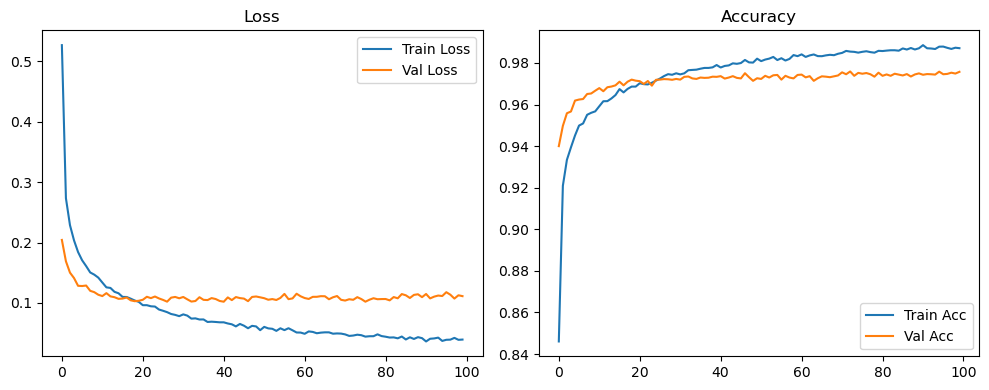

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3092, Acc: 0.9157 | Val Loss: 0.1583, Acc: 0.9533


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1110, Acc: 0.9663 | Val Loss: 0.1300, Acc: 0.9597


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0750, Acc: 0.9771 | Val Loss: 0.1255, Acc: 0.9626


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0574, Acc: 0.9811 | Val Loss: 0.1204, Acc: 0.9642


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9852 | Val Loss: 0.1189, Acc: 0.9653


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9880 | Val Loss: 0.1221, Acc: 0.9646


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9889 | Val Loss: 0.1213, Acc: 0.9685


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1149, Acc: 0.9695


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9922 | Val Loss: 0.1260, Acc: 0.9673


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9924 | Val Loss: 0.1245, Acc: 0.9675


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.1351, Acc: 0.9660


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9931 | Val Loss: 0.1188, Acc: 0.9693


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9938 | Val Loss: 0.1298, Acc: 0.9682


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1280, Acc: 0.9697


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1299, Acc: 0.9697


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.1403, Acc: 0.9671


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.1306, Acc: 0.9703


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9958 | Val Loss: 0.1319, Acc: 0.9712


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1276, Acc: 0.9694


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1290, Acc: 0.9711


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1350, Acc: 0.9697


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1270, Acc: 0.9716


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1246, Acc: 0.9728


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1321, Acc: 0.9703


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1344, Acc: 0.9702


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1257, Acc: 0.9714


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1382, Acc: 0.9709


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.1286, Acc: 0.9732


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.1381, Acc: 0.9710


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1326, Acc: 0.9725


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1375, Acc: 0.9719


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1442, Acc: 0.9721


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1351, Acc: 0.9729


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1373, Acc: 0.9730


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1397, Acc: 0.9716


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1478, Acc: 0.9716


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1554, Acc: 0.9708


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1421, Acc: 0.9721


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1330, Acc: 0.9729


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1317, Acc: 0.9726


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1398, Acc: 0.9718


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1373, Acc: 0.9741


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1411, Acc: 0.9722


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1330, Acc: 0.9743


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1326, Acc: 0.9736


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1241, Acc: 0.9740


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1227, Acc: 0.9753


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1637, Acc: 0.9710


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.1544, Acc: 0.9702


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1492, Acc: 0.9718


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1474, Acc: 0.9727


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1392, Acc: 0.9733


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1349, Acc: 0.9736


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1299, Acc: 0.9751


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1314, Acc: 0.9758


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1396, Acc: 0.9740


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1431, Acc: 0.9742


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1306, Acc: 0.9749


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1459, Acc: 0.9729


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.1418, Acc: 0.9731


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1381, Acc: 0.9751


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1342, Acc: 0.9758


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1351, Acc: 0.9762


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1400, Acc: 0.9736


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1378, Acc: 0.9752


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1430, Acc: 0.9756


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1466, Acc: 0.9740


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1538, Acc: 0.9730


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1429, Acc: 0.9749


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1544, Acc: 0.9734


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1479, Acc: 0.9748


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.1438, Acc: 0.9738


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1463, Acc: 0.9743


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1505, Acc: 0.9725


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1412, Acc: 0.9744


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1576, Acc: 0.9722


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1526, Acc: 0.9736


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1461, Acc: 0.9745


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1438, Acc: 0.9748


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1465, Acc: 0.9742


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1390, Acc: 0.9771


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1549, Acc: 0.9747


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1559, Acc: 0.9732


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1474, Acc: 0.9743


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1501, Acc: 0.9748


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1461, Acc: 0.9752


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1584, Acc: 0.9725


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1490, Acc: 0.9746


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1423, Acc: 0.9754


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1457, Acc: 0.9751


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1457, Acc: 0.9752


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1460, Acc: 0.9745


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1604, Acc: 0.9723


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1377, Acc: 0.9748


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1285, Acc: 0.9762


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1296, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1446, Acc: 0.9747


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1460, Acc: 0.9736


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1405, Acc: 0.9752


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1398, Acc: 0.9762


Final Test Loss: 0.1299 Accuracy: 0.9784


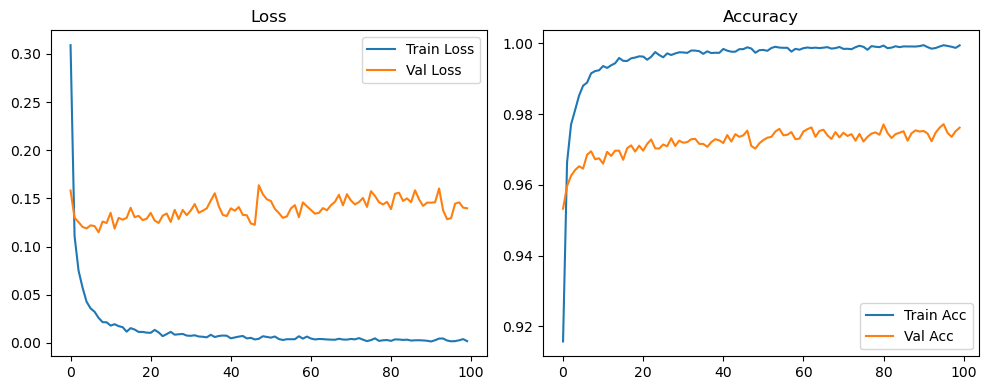

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3926, Acc: 0.8913 | Val Loss: 0.1660, Acc: 0.9490


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1616, Acc: 0.9509 | Val Loss: 0.1366, Acc: 0.9568


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1218, Acc: 0.9625 | Val Loss: 0.1278, Acc: 0.9623


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0977, Acc: 0.9697 | Val Loss: 0.1206, Acc: 0.9631


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0868, Acc: 0.9724 | Val Loss: 0.1140, Acc: 0.9678


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0792, Acc: 0.9745 | Val Loss: 0.1211, Acc: 0.9639


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0699, Acc: 0.9774 | Val Loss: 0.1065, Acc: 0.9688


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9802 | Val Loss: 0.1061, Acc: 0.9681


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9812 | Val Loss: 0.1110, Acc: 0.9689


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9829 | Val Loss: 0.1083, Acc: 0.9710


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9835 | Val Loss: 0.1066, Acc: 0.9693


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9852 | Val Loss: 0.1163, Acc: 0.9680


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9863 | Val Loss: 0.1176, Acc: 0.9702


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.1165, Acc: 0.9696


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.1080, Acc: 0.9718


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 0.1149, Acc: 0.9703


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1133, Acc: 0.9702


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 0.1054, Acc: 0.9724


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9884 | Val Loss: 0.1103, Acc: 0.9718


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.1069, Acc: 0.9702


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1081, Acc: 0.9715


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.1099, Acc: 0.9705


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.1064, Acc: 0.9733


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1076, Acc: 0.9727


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.1097, Acc: 0.9737


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.1177, Acc: 0.9708


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.1204, Acc: 0.9720


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1054, Acc: 0.9734


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1151, Acc: 0.9726


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1143, Acc: 0.9738


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1189, Acc: 0.9711


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.1187, Acc: 0.9732


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.1160, Acc: 0.9722


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1156, Acc: 0.9736


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.1204, Acc: 0.9720


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.1127, Acc: 0.9736


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1167, Acc: 0.9731


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.1131, Acc: 0.9715


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1085, Acc: 0.9746


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.1125, Acc: 0.9725


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1144, Acc: 0.9732


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9936 | Val Loss: 0.1128, Acc: 0.9742


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1093, Acc: 0.9740


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1095, Acc: 0.9751


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.1151, Acc: 0.9748


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1119, Acc: 0.9762


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1139, Acc: 0.9745


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9948 | Val Loss: 0.1095, Acc: 0.9744


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.1183, Acc: 0.9733


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1070, Acc: 0.9761


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.1117, Acc: 0.9744


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1108, Acc: 0.9748


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1186, Acc: 0.9738


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1087, Acc: 0.9745


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.1165, Acc: 0.9737


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1149, Acc: 0.9748


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1113, Acc: 0.9752


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1126, Acc: 0.9743


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1193, Acc: 0.9733


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1162, Acc: 0.9753


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1167, Acc: 0.9743


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1119, Acc: 0.9762


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1139, Acc: 0.9737


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1068, Acc: 0.9746


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1222, Acc: 0.9732


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.1162, Acc: 0.9752


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1217, Acc: 0.9747


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1214, Acc: 0.9752


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1216, Acc: 0.9734


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1216, Acc: 0.9752


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1231, Acc: 0.9756


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1199, Acc: 0.9765


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1153, Acc: 0.9760


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9958 | Val Loss: 0.1180, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1188, Acc: 0.9745


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1194, Acc: 0.9752


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1221, Acc: 0.9755


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1198, Acc: 0.9755


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1226, Acc: 0.9757


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1213, Acc: 0.9748


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1264, Acc: 0.9747


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1287, Acc: 0.9749


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1319, Acc: 0.9743


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1268, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1304, Acc: 0.9741


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1272, Acc: 0.9752


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1227, Acc: 0.9770


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1264, Acc: 0.9748


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1293, Acc: 0.9747


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1264, Acc: 0.9750


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1324, Acc: 0.9735


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1242, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1263, Acc: 0.9738


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1257, Acc: 0.9748


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1288, Acc: 0.9755


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1341, Acc: 0.9738


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1363, Acc: 0.9748


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1256, Acc: 0.9753


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.1322, Acc: 0.9745


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1236, Acc: 0.9772


Final Test Loss: 0.1136 Accuracy: 0.9782


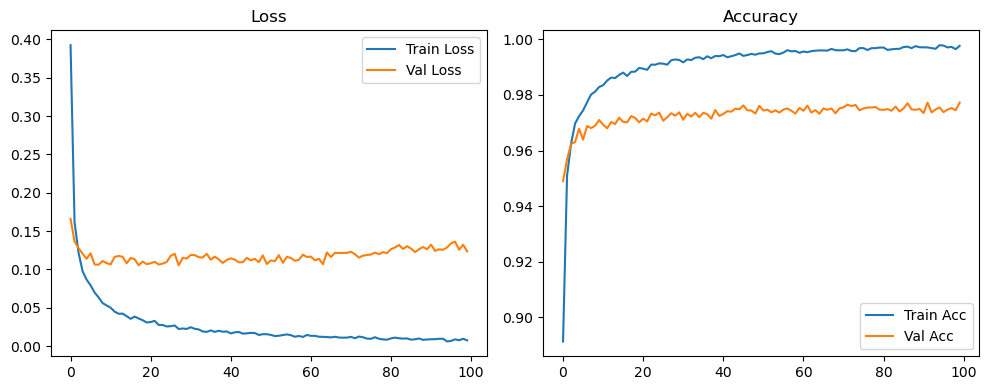

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6503, Acc: 0.8128 | Val Loss: 0.2280, Acc: 0.9323


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2978, Acc: 0.9149 | Val Loss: 0.1858, Acc: 0.9442


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2437, Acc: 0.9273 | Val Loss: 0.1604, Acc: 0.9519


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2127, Acc: 0.9374 | Val Loss: 0.1474, Acc: 0.9567


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1940, Acc: 0.9428 | Val Loss: 0.1388, Acc: 0.9603


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1834, Acc: 0.9455 | Val Loss: 0.1327, Acc: 0.9611


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1679, Acc: 0.9504 | Val Loss: 0.1267, Acc: 0.9631


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1629, Acc: 0.9517 | Val Loss: 0.1220, Acc: 0.9637


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1537, Acc: 0.9547 | Val Loss: 0.1205, Acc: 0.9653


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1458, Acc: 0.9565 | Val Loss: 0.1161, Acc: 0.9663


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1434, Acc: 0.9570 | Val Loss: 0.1153, Acc: 0.9654


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1350, Acc: 0.9597 | Val Loss: 0.1143, Acc: 0.9673


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1301, Acc: 0.9606 | Val Loss: 0.1115, Acc: 0.9680


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1274, Acc: 0.9608 | Val Loss: 0.1139, Acc: 0.9692


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1202, Acc: 0.9638 | Val Loss: 0.1101, Acc: 0.9687


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1142, Acc: 0.9650 | Val Loss: 0.1101, Acc: 0.9690


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1162, Acc: 0.9650 | Val Loss: 0.1116, Acc: 0.9687


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1145, Acc: 0.9650 | Val Loss: 0.1135, Acc: 0.9679


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1098, Acc: 0.9660 | Val Loss: 0.1085, Acc: 0.9690


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1103, Acc: 0.9658 | Val Loss: 0.1099, Acc: 0.9690


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1040, Acc: 0.9675 | Val Loss: 0.1078, Acc: 0.9699


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1014, Acc: 0.9686 | Val Loss: 0.1026, Acc: 0.9711


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1010, Acc: 0.9677 | Val Loss: 0.1086, Acc: 0.9698


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0995, Acc: 0.9697 | Val Loss: 0.1098, Acc: 0.9691


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0938, Acc: 0.9712 | Val Loss: 0.1068, Acc: 0.9702


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0957, Acc: 0.9696 | Val Loss: 0.1068, Acc: 0.9711


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0938, Acc: 0.9706 | Val Loss: 0.1074, Acc: 0.9702


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0901, Acc: 0.9715 | Val Loss: 0.1008, Acc: 0.9725


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0864, Acc: 0.9733 | Val Loss: 0.1106, Acc: 0.9713


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0873, Acc: 0.9732 | Val Loss: 0.1050, Acc: 0.9712


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0867, Acc: 0.9733 | Val Loss: 0.1050, Acc: 0.9711


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0844, Acc: 0.9724 | Val Loss: 0.1094, Acc: 0.9718


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9741 | Val Loss: 0.1017, Acc: 0.9722


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0803, Acc: 0.9741 | Val Loss: 0.1055, Acc: 0.9722


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0783, Acc: 0.9760 | Val Loss: 0.1071, Acc: 0.9706


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0790, Acc: 0.9745 | Val Loss: 0.1042, Acc: 0.9723


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0744, Acc: 0.9769 | Val Loss: 0.1048, Acc: 0.9729


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9765 | Val Loss: 0.1095, Acc: 0.9724


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0763, Acc: 0.9768 | Val Loss: 0.1056, Acc: 0.9722


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0731, Acc: 0.9770 | Val Loss: 0.1097, Acc: 0.9719


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9769 | Val Loss: 0.1098, Acc: 0.9718


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9782 | Val Loss: 0.1086, Acc: 0.9708


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0704, Acc: 0.9781 | Val Loss: 0.1090, Acc: 0.9727


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9775 | Val Loss: 0.1083, Acc: 0.9724


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0672, Acc: 0.9785 | Val Loss: 0.1050, Acc: 0.9732


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0660, Acc: 0.9788 | Val Loss: 0.1077, Acc: 0.9724


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0667, Acc: 0.9778 | Val Loss: 0.1084, Acc: 0.9725


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9783 | Val Loss: 0.1146, Acc: 0.9716


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.1079, Acc: 0.9729


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0640, Acc: 0.9796 | Val Loss: 0.1087, Acc: 0.9728


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0641, Acc: 0.9792 | Val Loss: 0.1096, Acc: 0.9728


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9798 | Val Loss: 0.1086, Acc: 0.9729


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0603, Acc: 0.9810 | Val Loss: 0.1102, Acc: 0.9725


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9806 | Val Loss: 0.1151, Acc: 0.9710


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0588, Acc: 0.9807 | Val Loss: 0.1111, Acc: 0.9730


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0631, Acc: 0.9805 | Val Loss: 0.1087, Acc: 0.9732


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0607, Acc: 0.9800 | Val Loss: 0.1054, Acc: 0.9726


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9807 | Val Loss: 0.1060, Acc: 0.9733


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0568, Acc: 0.9814 | Val Loss: 0.1068, Acc: 0.9731


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0572, Acc: 0.9818 | Val Loss: 0.1036, Acc: 0.9746


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9818 | Val Loss: 0.1023, Acc: 0.9752


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9818 | Val Loss: 0.1093, Acc: 0.9727


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9821 | Val Loss: 0.1069, Acc: 0.9739


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9823 | Val Loss: 0.1013, Acc: 0.9746


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.1048, Acc: 0.9744


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0557, Acc: 0.9822 | Val Loss: 0.1054, Acc: 0.9746


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9829 | Val Loss: 0.1069, Acc: 0.9739


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.1027, Acc: 0.9737


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9838 | Val Loss: 0.1042, Acc: 0.9747


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9833 | Val Loss: 0.1098, Acc: 0.9730


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9835 | Val Loss: 0.1086, Acc: 0.9728


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9826 | Val Loss: 0.1008, Acc: 0.9741


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9837 | Val Loss: 0.1070, Acc: 0.9740


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9836 | Val Loss: 0.1097, Acc: 0.9742


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9838 | Val Loss: 0.1084, Acc: 0.9729


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9840 | Val Loss: 0.1054, Acc: 0.9756


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9849 | Val Loss: 0.1045, Acc: 0.9762


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.1096, Acc: 0.9743


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9841 | Val Loss: 0.1087, Acc: 0.9731


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9841 | Val Loss: 0.1085, Acc: 0.9729


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9853 | Val Loss: 0.1076, Acc: 0.9751


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9845 | Val Loss: 0.1078, Acc: 0.9739


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9867 | Val Loss: 0.1129, Acc: 0.9739


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.1052, Acc: 0.9745


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9849 | Val Loss: 0.1092, Acc: 0.9737


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9851 | Val Loss: 0.1054, Acc: 0.9740


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9860 | Val Loss: 0.1130, Acc: 0.9738


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9854 | Val Loss: 0.1101, Acc: 0.9745


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9855 | Val Loss: 0.1123, Acc: 0.9732


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9869 | Val Loss: 0.1061, Acc: 0.9750


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.1093, Acc: 0.9749


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9869 | Val Loss: 0.1083, Acc: 0.9747


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.1096, Acc: 0.9741


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.1058, Acc: 0.9746


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9868 | Val Loss: 0.1097, Acc: 0.9748


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.1105, Acc: 0.9737


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.1093, Acc: 0.9739


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 0.1046, Acc: 0.9757


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.1095, Acc: 0.9753


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9857 | Val Loss: 0.1117, Acc: 0.9758


Final Test Loss: 0.1065 Accuracy: 0.9761


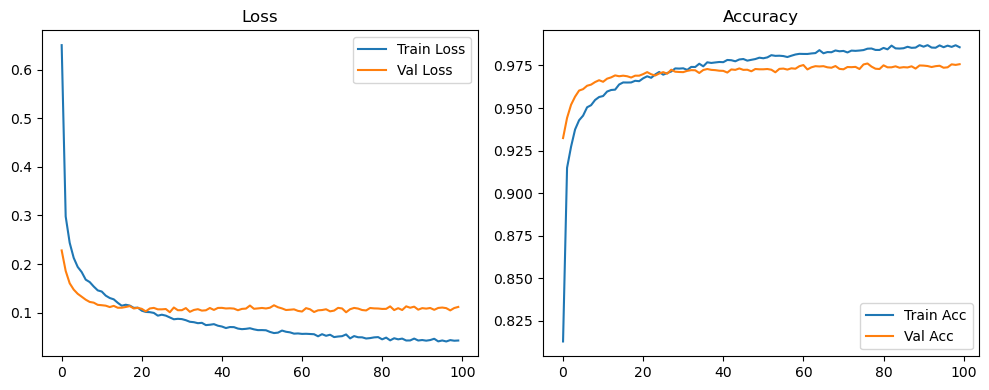

🏆 Best Config: batch256_lr0.01_0.002_0.001_dp0.2 Accuracy: 0.9835


In [8]:
root_path = "MLP_256_8bit_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)